In [8]:
import git
import requests
import os

def get_remote_url(local_path):
    try:
        repo = git.Repo(local_path)
        remote_url = next(repo.remotes.origin.urls)
        return remote_url
    except Exception as e:
        print(f"Error accessing repository at {local_path}: {e}")
        return None

def get_resolved_issues(repo_owner, repo_name, state='closed'):
    url = f"https://api.github.com/repos/{repo_owner}/{repo_name}/issues"
    params = {
        'state': state,
        'per_page': 100  # Number of issues per page (maximum is 100)
    }
    
    issues = []
    page = 1
    
    while True:
        params['page'] = page
        response = requests.get(url, params=params)
        
        if response.status_code != 200:
            print(f"Error fetching issues: {response.status_code}")
            break
        
        data = response.json()
        if not data:
            break
        
        issues.extend(data)
        page += 1
    
    print("Got issues for ", repo_name)
    return issues

In [9]:
def get_commit_hashes_from_text(text):
    if text is None:
        return []
    commit_pattern = re.compile(r'\b[0-9a-f]{40}\b')
    return commit_pattern.findall(text)

def get_commit_hashes_from_issue_comments(repo_owner, repo_name, issue_number):
    url = f"https://api.github.com/repos/{repo_owner}/{repo_name}/issues/{issue_number}/comments"
    response = requests.get(url)
    
    if response.status_code != 200:
        print(f"Error fetching comments for issue #{issue_number}: {response.status_code}")
        return []
    
    comments = response.json()
    commit_hashes = []
    
    for comment in comments:
        commit_hashes.extend(get_commit_hashes_from_text(comment['body']))
    
    return commit_hashes

In [10]:
import git

def find_bug_fixing_commits(repo_path, keywords, repo_name):
    repo = git.Repo(repo_path)
    bug_fixing_commits = []

    for commit in repo.iter_commits():
        for keyword in keywords:
            if keyword.lower() in commit.message.lower():
                bug_fixing_commits.append({
                    'repository': repo_name,
                    'commit_hash': commit.hexsha,
                    'keyword': keyword
                })
    
    unique_commits = []
    seen = set()

    for item in bug_fixing_commits:
        key = (item['repository'], item['commit_hash'])
        if key not in seen:
            seen.add(key)
            unique_commits.append(item)
    
    return unique_commits

In [11]:
import os
import pandas as pd

repos_path = os.path.join('data', 'repos', 'simulation')
keywords = ["fixed ", " bug", "fixes ","fix "," fix", " fixed", " fixes", "crash","solves", " resolves",
"resolves ", " issue", "issue ", "regression", "fall back", "assertion", "coverity", "reproducible",
"stack-wanted", "steps-wanted", "testcase", "failur", "fail", "npe ",
" npe", "except", "broken", "differential testing", "error", "addresssanitizer",
"hang ", " hang", "permaorange", "random orange", "intermittent", "test fix",
"steps to reproduce", "crash", "assertion", "failure", "leak", "stack trace", "heap overflow",
"freez", "str:", "problem ", " problem", " overflow", "overflow ", "avoid ",
" avoid",  "workaround ", " workaround", "break ", " break", " stop", "stop "];

all_fix_commits = []
for repo in os.listdir(repos_path):
    repo_folder_path = os.path.join(repos_path, repo)
    
    if os.path.isdir(repo_folder_path):    
        print("Getting fix commits of ", repo)
        bug_fixing_commits = find_bug_fixing_commits(repo_folder_path, keywords, repo)
        all_fix_commits.extend(bug_fixing_commits)

        
df = pd.DataFrame(all_fix_commits)
print(df)

Getting fix commits of  adf-sample-agent-java
Getting fix commits of  aerie
Getting fix commits of  AgentWorkbench
Getting fix commits of  amod
Getting fix commits of  amodeus
Getting fix commits of  annotation-simulator
Getting fix commits of  AutoInteraction-Library
Getting fix commits of  Black-Scholes-Option-Pricing-Model
Getting fix commits of  BoomChess-Android
Getting fix commits of  cas
Getting fix commits of  cloudsimplus
Getting fix commits of  cloudsimplus-automation
Getting fix commits of  cloudsimplus-examples
Getting fix commits of  cloudsimsdn
Getting fix commits of  computer_kurzweil
Getting fix commits of  DesSim
Getting fix commits of  ecosim
Getting fix commits of  end-game
Getting fix commits of  eqasim-java
Getting fix commits of  EVLib
Getting fix commits of  Evolving-Protozoa
Getting fix commits of  farmsim
Getting fix commits of  finmath-lib
Getting fix commits of  FlockingSimulation
Getting fix commits of  gama
Getting fix commits of  gips
Getting fix commits o

In [8]:
df['keyword'].value_counts()

keyword
fix             3899
fixed           3281
 fix            1397
 bug            1269
fixes            760
 issue           568
except           534
error            403
avoid            259
fail             196
failur           125
problem          119
 problem         107
 stop             92
issue             69
 break            52
npe               48
broken            46
stop              41
regression        35
 avoid            32
assertion         32
break             30
workaround        26
solves            26
crash             24
leak              18
 overflow         17
 npe               9
 workaround        8
freez              7
stack trace        6
 hang              5
fall back          3
overflow           3
reproducible       3
coverity           2
str:               2
hang               2
testcase           1
Name: count, dtype: int64

In [27]:
def flatten_dict(d):
    flat_dict = {}
    for outer_key, inner_dict in d.items():
        if isinstance(inner_dict, dict):
            for inner_key in inner_dict:
                flat_dict[outer_key] = inner_key
        else:
            flat_dict[outer_key] = inner_dict
    return flat_dict

In [40]:
from pydriller import Repository, Git

import os

repos_path = os.path.join('data', 'repos', 'simulation')

def get_values_by_key(list_of_dicts, key):
    return [d[key] for d in list_of_dicts if key in d]

all_inducing_commits = []

for repo in os.listdir(repos_path):
    repo_folder_path = os.path.join(repos_path, repo)
    if os.path.isdir(repo_folder_path):
        print("Getting inducing commits for ", repo)
        repository = Git(repo_folder_path)
        
        fixed_commits = df[df['repository'] == repo]
        fixed_commit_list = fixed_commits['commit_hash'].tolist()
        for fixed_commit in fixed_commit_list:
            
            commit = repository.get_commit(fixed_commit)
            prev_commits = repository.get_commits_last_modified_lines(commit)
            
            for file in prev_commits.keys():
                file_commits = prev_commits[file]
                hashes = list(file_commits)
                
                for commit_hash in hashes:
                    all_inducing_commits.append({
                    'repository': repo,
                    'fixing_commit': fixed_commit,
                    'fixing_commit_date': repository.get_commit(fixed_commit).committer_date,
                    'inducing_commit':commit_hash,
                    'inducing_commit_date': repository.get_commit(commit_hash).committer_date,
                    'file': file,
                    'keyword': fixed_commits[fixed_commits['commit_hash']==fixed_commit]['keyword'].tolist()[0]
                    })

Getting inducing commits for  adf-sample-agent-java
Getting inducing commits for  aerie
Getting inducing commits for  AgentWorkbench
Getting inducing commits for  amod
Getting inducing commits for  amodeus
Getting inducing commits for  annotation-simulator
Getting inducing commits for  AutoInteraction-Library
Getting inducing commits for  Black-Scholes-Option-Pricing-Model
Getting inducing commits for  BoomChess-Android
Getting inducing commits for  cas
Getting inducing commits for  cloudsimplus
Getting inducing commits for  cloudsimplus-automation
Getting inducing commits for  cloudsimplus-examples
Getting inducing commits for  cloudsimsdn
Getting inducing commits for  computer_kurzweil
Getting inducing commits for  DesSim
Getting inducing commits for  ecosim
Getting inducing commits for  end-game
Getting inducing commits for  eqasim-java
Getting inducing commits for  EVLib
Getting inducing commits for  Evolving-Protozoa
Getting inducing commits for  farmsim
Getting inducing commits f

In [43]:
inducing_df = pd.DataFrame(all_inducing_commits)
inducing_df = inducing_df.drop_duplicates()
inducing_df.to_csv('inducing_df.csv')
inducing_df

repository                             fixing_commit  \
0       adf-sample-agent-java  d42692cbe8be18793d0a4fd7cddb7a6ce29d53a8   
1       adf-sample-agent-java  d3631db88bd15c8f7a6048207a3e6fdd0f336a02   
2       adf-sample-agent-java  d3631db88bd15c8f7a6048207a3e6fdd0f336a02   
3       adf-sample-agent-java  d3631db88bd15c8f7a6048207a3e6fdd0f336a02   
4       adf-sample-agent-java  d3631db88bd15c8f7a6048207a3e6fdd0f336a02   
...                       ...                                       ...   
169976              workcraft  8af53c2871d9c5489eb293a2e5fd647cb41f2ca6   
169977              workcraft  8af53c2871d9c5489eb293a2e5fd647cb41f2ca6   
169978              workcraft  ce741bb20f73fd4c7aaeba66efb2aa4092189b81   
169979              workcraft  ce741bb20f73fd4c7aaeba66efb2aa4092189b81   
169980              workcraft  ce741bb20f73fd4c7aaeba66efb2aa4092189b81   

               fixing_commit_date                           inducing_commit  \
0       2022-10-03 08:41:08+02:00  ed2a18fd5c0c263d9fe27a1c442244ad0a649590   
1       2018-10-12 17:23:33+02:00  a3e60f117511ac957c5f83f45cc279262272f4aa   
2       2018-10-12 17:23:33+02:00  8d58c5c79766df9ea34fe3ea32356bbd0e90dc58   
3       2018-10-12 17:23:33+02:00  193f33f4e2ccb5e7e7bc5f979048502e9495d4fd   
4       2018-10-12 17:23:33+02:00  35f3d2b9f2a069238e3fc3c65e838a74da0ff4cd   
...                           ...                                       ...   
169976  2009-01-14 10:48:21+00:00  9104befbe5fce0e8dfbb65bcfc178900219a5448   
169977  2009-01-14 10:48:21+00:00  4e791baeafa80ce7fda92daa2338c1b0f0c57685   
169978  2009-01-05 21:28:10+00:00  09b84f0c5c782209c0225f7287347623cb8e171f   
169979  2009-01-05 21:28:10+00:00  09b84f0c5c782209c0225f7287347623cb8e171f   
169980  2009-01-05 21:28:10+00:00  09b84f0c5c782209c0225f7287347623cb8e171f   

             inducing_commit_date  \
0       2022-01-11 21:56:46+01:00   
1       2016-12-08 21:15:59+09:00   
2       2016-09-20 12:31:12+09:00   
3       2015-11-26 07:35:10+09:00   
4       2015-12-02 13:42:29+09:00   
...                           ...   
169976  2008-12-03 19:06:23+00:00   
169977  2008-12-12 23:15:24+00:00   
169978  2009-01-05 20:58:27+00:00   
169979  2009-01-05 20:58:27+00:00   
169980  2009-01-05 20:58:27+00:00   

                                                  file keyword  
0                                    config\module.cfg  fixes   
1                                            .build.sh  fixed   
2                                   .update-library.sh  fixed   
3                                   .update-library.sh  fixed   
4                                   .update-library.sh  fixed   
...                                                ...     ...  
169976  workcraft\dom\visual\VisualComponentGroup.java  fixed   
169977  workcraft\dom\visual\VisualComponentGroup.java  fixed   
169978                    workcraft\gui\Coloriser.java  fixed   
169979        workcraft\plugins\petri\VisualPlace.java  fixed   
169980   workcraft\plugins\petri\VisualTransition.java  fixed   

[169981 rows x 7 columns]

## Anazlyze Commits

In [3]:
import pandas as pd
inducing_df = pd.read_csv('inducing_df.csv')
inducing_df['inducing_commit_date'] = pd.to_datetime(inducing_df['inducing_commit_date'], utc=True)
inducing_df['fixing_commit_date'] = pd.to_datetime(inducing_df['fixing_commit_date'], utc=True)
# inducing_df = inducing_df.sort_values(by='inducing_commit_date')
# inducing_df = inducing_df.drop_duplicates(subset=['repository', 'fixing_commit', 'file'], keep='first')
inducing_df

Unnamed: 0             repository  \
0                0  adf-sample-agent-java   
1                1  adf-sample-agent-java   
2                2  adf-sample-agent-java   
3                3  adf-sample-agent-java   
4                4  adf-sample-agent-java   
...            ...                    ...   
169976      169976              workcraft   
169977      169977              workcraft   
169978      169978              workcraft   
169979      169979              workcraft   
169980      169980              workcraft   

                                   fixing_commit        fixing_commit_date  \
0       d42692cbe8be18793d0a4fd7cddb7a6ce29d53a8 2022-10-03 06:41:08+00:00   
1       d3631db88bd15c8f7a6048207a3e6fdd0f336a02 2018-10-12 15:23:33+00:00   
2       d3631db88bd15c8f7a6048207a3e6fdd0f336a02 2018-10-12 15:23:33+00:00   
3       d3631db88bd15c8f7a6048207a3e6fdd0f336a02 2018-10-12 15:23:33+00:00   
4       d3631db88bd15c8f7a6048207a3e6fdd0f336a02 2018-10-12 15:23:33+00:00   
...                                          ...                       ...   
169976  8af53c2871d9c5489eb293a2e5fd647cb41f2ca6 2009-01-14 10:48:21+00:00   
169977  8af53c2871d9c5489eb293a2e5fd647cb41f2ca6 2009-01-14 10:48:21+00:00   
169978  ce741bb20f73fd4c7aaeba66efb2aa4092189b81 2009-01-05 21:28:10+00:00   
169979  ce741bb20f73fd4c7aaeba66efb2aa4092189b81 2009-01-05 21:28:10+00:00   
169980  ce741bb20f73fd4c7aaeba66efb2aa4092189b81 2009-01-05 21:28:10+00:00   

                                 inducing_commit      inducing_commit_date  \
0       ed2a18fd5c0c263d9fe27a1c442244ad0a649590 2022-01-11 20:56:46+00:00   
1       a3e60f117511ac957c5f83f45cc279262272f4aa 2016-12-08 12:15:59+00:00   
2       8d58c5c79766df9ea34fe3ea32356bbd0e90dc58 2016-09-20 03:31:12+00:00   
3       193f33f4e2ccb5e7e7bc5f979048502e9495d4fd 2015-11-25 22:35:10+00:00   
4       35f3d2b9f2a069238e3fc3c65e838a74da0ff4cd 2015-12-02 04:42:29+00:00   
...                                          ...                       ...   
169976  9104befbe5fce0e8dfbb65bcfc178900219a5448 2008-12-03 19:06:23+00:00   
169977  4e791baeafa80ce7fda92daa2338c1b0f0c57685 2008-12-12 23:15:24+00:00   
169978  09b84f0c5c782209c0225f7287347623cb8e171f 2009-01-05 20:58:27+00:00   
169979  09b84f0c5c782209c0225f7287347623cb8e171f 2009-01-05 20:58:27+00:00   
169980  09b84f0c5c782209c0225f7287347623cb8e171f 2009-01-05 20:58:27+00:00   

                                                  file keyword  
0                                    config\module.cfg  fixes   
1                                            .build.sh  fixed   
2                                   .update-library.sh  fixed   
3                                   .update-library.sh  fixed   
4                                   .update-library.sh  fixed   
...                                                ...     ...  
169976  workcraft\dom\visual\VisualComponentGroup.java  fixed   
169977  workcraft\dom\visual\VisualComponentGroup.java  fixed   
169978                    workcraft\gui\Coloriser.java  fixed   
169979        workcraft\plugins\petri\VisualPlace.java  fixed   
169980   workcraft\plugins\petri\VisualTransition.java  fixed   

[169981 rows x 8 columns]

In [4]:
def filter_dates(group, col_name):
    filtered_rows = []
    last_date = None
    for index, row in group.iterrows():
        if last_date is None or abs((row[col_name] - last_date).days) >= 28:
            filtered_rows.append(row)
            last_date = row[col_name]
    return pd.DataFrame(filtered_rows)

# Apply the function to each repository group
inducing_df = inducing_df.groupby('repository').apply(filter_dates, col_name='inducing_commit_date').reset_index(drop=True)
inducing_df = inducing_df.groupby('repository').apply(filter_dates, col_name='fixing_commit_date').reset_index(drop=True)
inducing_df

Unnamed: 0      repository                             fixing_commit  \
0           6562  AgentWorkbench  44462f6e93288995e8b43e1bc32ccb08e1a05c57   
1           6565  AgentWorkbench  e1cdeb68b52358cfcc839c8d39954da52f2449a9   
2           6578  AgentWorkbench  2333f9e8b76dc7100b05b4dd2c3c23b853a6da60   
3           6586  AgentWorkbench  deb51dc4b1d766fb6367557b9748709cb2b31f2b   
4           6599  AgentWorkbench  fc65f2dde8492597514ec179953c60ecf13a41ee   
...          ...             ...                                       ...   
1291      169474       workcraft  3108bd24e1544221a04157ddfd685cd4893a5bb6   
1292      169484       workcraft  c31415990c0b499c9b07efd8e1f33aaa20bad223   
1293      169501       workcraft  721d53214c6a8acd84fc71c05e2f6534a2a65177   
1294      169561       workcraft  1eeab1876622b1dd1b57aae6d065599f9f49caa3   
1295      169833       workcraft  489825b8975e361c646c881d6759882ab3a72b57   

            fixing_commit_date                           inducing_commit  \
0    2023-10-10 08:58:04+00:00  c2510d8be0260eb97c960bf1fe24ebaf5f833dab   
1    2023-08-21 14:15:19+00:00  8f0ed077e2a79a838d2e1a2105569f318f1a8124   
2    2023-07-16 14:00:52+00:00  68ee6125a9bdedbcc628247e8326143c071591a9   
3    2023-04-20 16:03:58+00:00  a581543ccd53828ea38e404a2af6cb16a8e59da1   
4    2023-03-14 11:42:28+00:00  65438f8429cbe0153ece9f0c51ddf5bb5595275b   
...                        ...                                       ...   
1291 2009-07-12 22:46:56+00:00  23881e2d8339655c8aaad42efff0524194299204   
1292 2009-05-16 08:28:05+00:00  8d9018e93a6217c3ff9db28cbf0e01008bafca44   
1293 2009-03-25 09:29:37+00:00  5096f698a98a707c12190fee9fe0168763ed5a18   
1294 2009-02-25 13:56:34+00:00  ac849ca420ad8076f30a3809d708278ec4bf6f3f   
1295 2009-01-25 23:19:43+00:00  5cab9dbb682e35951e492d1758275b618414e9df   

          inducing_commit_date  \
0    2023-01-08 16:54:15+00:00   
1    2023-04-20 16:00:38+00:00   
2    2019-09-26 14:02:54+00:00   
3    2022-08-23 15:08:11+00:00   
4    2022-08-02 10:10:51+00:00   
...                        ...   
1291 2009-02-21 20:23:16+00:00   
1292 2008-07-08 15:57:32+00:00   
1293 2008-08-10 08:54:36+00:00   
1294 2008-12-06 20:57:13+00:00   
1295 2008-07-14 10:55:39+00:00   

                                                   file   keyword  
0     eclipseProjects\de.enflexit.awb\bundles\de.enf...    fixed   
1     eclipseProjects\de.enflexit.awb\bundles\org.aw...    fixed   
2     eclipseProjects\de.enflexit.awb\bundles\org.aw...  problem   
3     eclipseProjects\de.enflexit.awb\bundles\de.enf...      stop  
4     eclipseProjects\de.enflexit.awb\bundles\de.enf...    fixed   
...                                                 ...       ...  
1291              workcraft\dom\visual\VisualModel.java    fixed   
1292                             workcraft\gui\LAF.java   problem  
1293                       workcraft\dom\MathModel.java    break   
1294                workcraft\gui\CreateWorkDialog.java    fixed   
1295                       workcraft\dom\MathModel.java    fixed   

[1296 rows x 8 columns]

In [95]:
tdf_fix = inducing_df.drop_duplicates(subset=['repository', 'fixing_commit'])
tdf_ind = inducing_df.drop_duplicates(subset=['repository', 'inducing_commit'])

In [96]:
print(len(tdf_fix), len(tdf_ind))

11330 22623


In [97]:
tdf_fix = tdf_fix.groupby('repository').apply(filter_dates, col_name='fixing_commit_date').reset_index(drop=True)
tdf_ind = tdf_ind.groupby('repository').apply(filter_dates, col_name='inducing_commit_date').reset_index(drop=True)

In [99]:
print(len(tdf_fix), len(tdf_ind))
pd.merge(tdf_fix, tdf_ind)

1375 16285


Unnamed: 0      repository                             fixing_commit  \
0          6562  AgentWorkbench  44462f6e93288995e8b43e1bc32ccb08e1a05c57   
1          6565  AgentWorkbench  e1cdeb68b52358cfcc839c8d39954da52f2449a9   
2          6578  AgentWorkbench  2333f9e8b76dc7100b05b4dd2c3c23b853a6da60   
3          6586  AgentWorkbench  deb51dc4b1d766fb6367557b9748709cb2b31f2b   
4          6654  AgentWorkbench  35634ef0e7413658a77fa67b9a45057b77c80a6a   
..          ...             ...                                       ...   
478      165840       workcraft  3be6b7ca948d406e21910a03dd71ceeca1bea6cf   
479      165852       workcraft  9ba4476faf0ad0d6d70562f9e4c75f8e5cbcd4f1   
480      165943       workcraft  9216feb585adf8794cbb21300f15aa6263cf2056   
481      166301       workcraft  ef6b15b6d0a47512d60971bf53f4d58653b5f343   
482      167939       workcraft  a9265205483a19f56b766057c29141e159f7c866   

           fixing_commit_date                           inducing_commit  \
0   2023-10-10 08:58:04+00:00  c2510d8be0260eb97c960bf1fe24ebaf5f833dab   
1   2023-08-21 14:15:19+00:00  8f0ed077e2a79a838d2e1a2105569f318f1a8124   
2   2023-07-16 14:00:52+00:00  68ee6125a9bdedbcc628247e8326143c071591a9   
3   2023-04-20 16:03:58+00:00  a581543ccd53828ea38e404a2af6cb16a8e59da1   
4   2022-10-12 10:20:26+00:00  ed115d32a1f202ba873e692d5c06bba3a4dc3bf7   
..                        ...                                       ...   
478 2015-01-20 16:08:50+00:00  871fb61400fbbc6835fa2d903d5ed7470f661bcf   
479 2014-12-14 10:25:50+00:00  5f4417daa9195686764e3cedb03012939e668c65   
480 2014-11-14 23:43:09+00:00  43948490f0059fef6b2935e582a3c4ecff28527c   
481 2014-08-06 15:33:46+00:00  cb57bc73f5605c48dbfc92f4befbf3fd67deb3fb   
482 2011-05-08 18:04:59+00:00  3d268ddbbafb639d88d39f5e4d99936fefce44b6   

         inducing_commit_date  \
0   2023-01-08 16:54:15+00:00   
1   2023-04-20 16:00:38+00:00   
2   2019-09-26 14:02:54+00:00   
3   2022-08-23 15:08:11+00:00   
4   2017-08-24 15:59:55+00:00   
..                        ...   
478 2014-04-03 17:30:41+00:00   
479 2014-05-06 09:15:57+00:00   
480 2014-07-11 16:22:02+00:00   
481 2009-02-22 16:12:29+00:00   
482 2010-09-20 07:55:38+00:00   

                                                  file   keyword  
0    eclipseProjects\de.enflexit.awb\bundles\de.enf...    fixed   
1    eclipseProjects\de.enflexit.awb\bundles\org.aw...    fixed   
2    eclipseProjects\de.enflexit.awb\bundles\org.aw...  problem   
3    eclipseProjects\de.enflexit.awb\bundles\de.enf...      stop  
4    eclipseProjects\de.enflexit.awb\bundles\de.enf...       bug  
..                                                 ...       ...  
478  STGPlugin\src\org\workcraft\plugins\stg\LabelP...      fix   
479  SONPlugin\src\org\workcraft\plugins\son\elemen...      fix   
480  MpsatPlugin\src\org\workcraft\plugins\mpsat\gu...    fixes   
481  WorkcraftCore\src\org\workcraft\gui\graph\tool...    fixes   
482                             BalsaPlugin\.classpath    fixed   

[483 rows x 8 columns]

In [5]:
from git import Repo,GitCommandError
import analyze_code
import shutil
repos_path = os.path.join('data', 'repos', 'simulation')

repo_path = os.path.join('data', 'repos', 'simulation')
bug_fix_path = os.path.join('data', 'mining', 'fixed', 'simulation')
bug_inducing_path = os.path.join('data', 'mining', 'inducing', 'simulation')
dj_file_path = os.path.join('apps', 'DJ', 'DesigniteJava.jar')


for repo in os.listdir(repos_path):
    repo_folder_path = os.path.join(repos_path, repo)
    
    if os.path.isdir(repo_folder_path):
        temp_df =  inducing_df[inducing_df['repository'] == repo]
        
        # BUG FIXING COMMITS
        #################################################################
        print("Analyzing bug fixing commits of ", repo)
        resolved_commit_hashes = temp_df['fixing_commit'].unique().tolist()
        
        fix_repo_path = os.path.join(bug_fix_path, repo)
        if not os.path.exists(fix_repo_path):
            os.makedirs(fix_repo_path)
        
        count = 0
        
        # check if folder is already analyzed
        if os.path.isfile(os.path.join(fix_repo_path, "completed.txt")):
            continue

        repository = Repo(repo_folder_path)
        head_commit = repository.head.commit.hexsha

        for commit in resolved_commit_hashes:
            print("Analyzing the ", count, "th commit of ", repo)
            try:
                repository.git.reset('--hard', commit)
            except GitCommandError:
                print("encounter error while resetting, skipping commit")
                continue
            result_path = os.path.join(fix_repo_path, repo+'_'+commit)
            analyze_code.analyze_repo(repo_folder_path, result_path, os.path.abspath(dj_file_path))
            commit_info = repository.commit(commit)
            with open(os.path.join(result_path,'commit_date.txt'), 'w') as file:
                file.write(str(commit_info.authored_datetime))


            if os.path.isfile(os.path.join(result_path, "MethodMetrics.csv")):
                # do a check to see if we get metrics and stop 
                adf = pd.read_csv(os.path.join(result_path, "MethodMetrics.csv"))
                if adf.empty:
                    print("No results found for ", repo, " at ", count, "th step")
                    shutil.rmtree(result_path)
                    count+=1
                    continue

            count+=1

        # analyze_code.analyze_repo_multi(repo_path, folder_path, os.path.abspath(dj_file_path), main_branch)

        # set a file as a merker to indicate its finished analyzing
        end_file = open(os.path.join(fix_repo_path, "completed.txt"), 'w')
        end_file.write("COMPLETED")
        end_file.close()
        print("Finished Analysis of ", repo)
        repository.git.reset('--hard', head_commit)
        print("Resetting repo back to head")
        
        

Analyzing bug fixing commits of  adf-sample-agent-java
Analyzing bug fixing commits of  aerie
Analyzing bug fixing commits of  AgentWorkbench
Analyzing bug fixing commits of  amod
Analyzing bug fixing commits of  amodeus
Analyzing bug fixing commits of  annotation-simulator
Analyzing bug fixing commits of  AutoInteraction-Library
Analyzing bug fixing commits of  Black-Scholes-Option-Pricing-Model
Analyzing bug fixing commits of  BoomChess-Android
Analyzing bug fixing commits of  cas
Analyzing bug fixing commits of  cloudsimplus
Analyzing bug fixing commits of  cloudsimplus-automation
Analyzing bug fixing commits of  cloudsimplus-examples
Analyzing bug fixing commits of  cloudsimsdn
Analyzing bug fixing commits of  computer_kurzweil
Analyzing bug fixing commits of  DesSim
Analyzing bug fixing commits of  ecosim
Analyzing bug fixing commits of  end-game
Analyzing bug fixing commits of  eqasim-java
Analyzing bug fixing commits of  EVLib
Analyzing bug fixing commits of  Evolving-Protozoa
A

Analyzingdata\repos\simulation\finmath-lib ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  35 th commit of  finmath-lib
Analyzingdata\repos\simulation\finmath-lib ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  finmath-lib  at  35 th step
Analyzing the  36 th commit of  finmath-lib
Analyzingdata\repos\simulation\finmath-lib ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  finmath-lib  at  36 th step
Analyzing the  37 th commit of  finmath-lib
Analyzingdata\repos\simulation\finmath-lib ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  finmath-lib  at  37 th step
Analyzing the  38 th commit of  finmath-lib
Analyzingdata\repos\simulation\finmath-lib ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  finmath-lib  at  38 th step
Analyzing the  39 th commit of  finmath

done analyzing.
Analyzing the  7 th commit of  gips
Analyzingdata\repos\simulation\gips ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  8 th commit of  gips
Analyzingdata\repos\simulation\gips ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  9 th commit of  gips
Analyzingdata\repos\simulation\gips ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  10 th commit of  gips
Analyzingdata\repos\simulation\gips ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  11 th commit of  gips
Analyzingdata\repos\simulation\gips ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  12 th commit of  gips
Analyzingdata\repos\simulation\gips ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  13 th commit of  gips
Analyzingdata\repos\simulation\gips ...
Attempting compi

Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mars-sim  at  15 th step
Analyzing the  16 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mars-sim  at  16 th step
Analyzing the  17 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mars-sim  at  17 th step
Analyzing the  18 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mars-sim  at  18 th step
Analyzing the  19 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mars-sim  at  19 th step
Analyzing the  20 th commit of 

Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mars-sim  at  56 th step
Analyzing the  57 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mars-sim  at  57 th step
Analyzing the  58 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mars-sim  at  58 th step
Analyzing the  59 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mars-sim  at  59 th step
Analyzing the  60 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mars-sim  at  60 th step
Analyzing the  61 th commit of 

Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mars-sim  at  97 th step
Analyzing the  98 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mars-sim  at  98 th step
Analyzing the  99 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mars-sim  at  99 th step
Analyzing the  100 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mars-sim  at  100 th step
Analyzing the  101 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mars-sim  at  101 th step
Analyzing the  102 th commi

Analyzing ...
done analyzing.
No results found for  mars-sim  at  137 th step
Analyzing the  138 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mars-sim  at  138 th step
Analyzing the  139 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mars-sim  at  139 th step
Analyzing the  140 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mars-sim  at  140 th step
Analyzing the  141 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mars-sim  at  141 th step
Analyzing the  142 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilati

done analyzing.
Analyzing the  181 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  182 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  183 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  184 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  185 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  186 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  187 th commit of  mar

done analyzing.
Analyzing the  11 th commit of  microtrafficsim
Analyzingdata\repos\simulation\microtrafficsim ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
Analyzing the  12 th commit of  microtrafficsim
Analyzingdata\repos\simulation\microtrafficsim ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
Analyzing the  13 th commit of  microtrafficsim
Analyzingdata\repos\simulation\microtrafficsim ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
Analyzing the  14 th commit of  microtrafficsim
Analyzingdata\repos\simulation\microtrafficsim ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
Finished Analysis of  microtrafficsim
Resetting repo back to head
Analyzing bug fixing commits of  Mirage
Analyzing the  0 th commit of  Mirage
Analyzingdata\repos\simulation\Mirage ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  1 th commit of  M

Analyzingdata\repos\simulation\mosaic ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mosaic  at  7 th step
Analyzing the  8 th commit of  mosaic
Analyzingdata\repos\simulation\mosaic ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mosaic  at  8 th step
Analyzing the  9 th commit of  mosaic
Analyzingdata\repos\simulation\mosaic ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mosaic  at  9 th step
Analyzing the  10 th commit of  mosaic
Analyzingdata\repos\simulation\mosaic ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mosaic  at  10 th step
Analyzing the  11 th commit of  mosaic
Analyzingdata\repos\simulation\mosaic ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mosaic  at  11 th step
Analyzing the  12 th commit of  mosaic
Analyzingdata\repos\simul

done analyzing.
Analyzing the  10 th commit of  plg
Analyzingdata\repos\simulation\plg ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  11 th commit of  plg
Analyzingdata\repos\simulation\plg ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  12 th commit of  plg
Analyzingdata\repos\simulation\plg ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Finished Analysis of  plg
Resetting repo back to head
Analyzing bug fixing commits of  PowerSystemDataModel
Analyzing the  0 th commit of  PowerSystemDataModel
Analyzingdata\repos\simulation\PowerSystemDataModel ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
Analyzing the  1 th commit of  PowerSystemDataModel
Analyzingdata\repos\simulation\PowerSystemDataModel ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
Analyzing the  2 th commit of  PowerSystemDataModel
Analyzingdata\rep

Analyzing ...
done analyzing.
Analyzing the  2 th commit of  PureEdgeSim
Analyzingdata\repos\simulation\PureEdgeSim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  3 th commit of  PureEdgeSim
Analyzingdata\repos\simulation\PureEdgeSim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  4 th commit of  PureEdgeSim
Analyzingdata\repos\simulation\PureEdgeSim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  5 th commit of  PureEdgeSim
Analyzingdata\repos\simulation\PureEdgeSim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  6 th commit of  PureEdgeSim
Analyzingdata\repos\simulation\PureEdgeSim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  7 th commit of  PureEdgeSim
Analyzingdata\repos\simulation\PureEdgeSim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing 

Analyzing ...
done analyzing.
Analyzing the  31 th commit of  Robot-Overlord-App
Analyzingdata\repos\simulation\Robot-Overlord-App ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  32 th commit of  Robot-Overlord-App
Analyzingdata\repos\simulation\Robot-Overlord-App ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  33 th commit of  Robot-Overlord-App
Analyzingdata\repos\simulation\Robot-Overlord-App ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  34 th commit of  Robot-Overlord-App
Analyzingdata\repos\simulation\Robot-Overlord-App ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  35 th commit of  Robot-Overlord-App
Analyzingdata\repos\simulation\Robot-Overlord-App ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  36 th commit of  Robot-Overlord-App
Analyzingdata\repos\simulation\Robot-Overlor

done analyzing.
No results found for  simulation-construction-set-2  at  4 th step
Analyzing the  5 th commit of  simulation-construction-set-2
Analyzingdata\repos\simulation\simulation-construction-set-2 ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
No results found for  simulation-construction-set-2  at  5 th step
Analyzing the  6 th commit of  simulation-construction-set-2
Analyzingdata\repos\simulation\simulation-construction-set-2 ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
No results found for  simulation-construction-set-2  at  6 th step
Analyzing the  7 th commit of  simulation-construction-set-2
Analyzingdata\repos\simulation\simulation-construction-set-2 ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
No results found for  simulation-construction-set-2  at  7 th step
Analyzing the  8 th commit of  simulation-construction-set-2
Analyzingdata\repos\simulation\simulation-construction-set-2 

done analyzing.
Finished Analysis of  simulation-construction-set-2
Resetting repo back to head
Analyzing bug fixing commits of  sinalgo
Analyzing the  0 th commit of  sinalgo
Analyzingdata\repos\simulation\sinalgo ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
Analyzing the  1 th commit of  sinalgo
Analyzingdata\repos\simulation\sinalgo ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
Analyzing the  2 th commit of  sinalgo
Analyzingdata\repos\simulation\sinalgo ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
Finished Analysis of  sinalgo
Resetting repo back to head
Analyzing bug fixing commits of  singa
Analyzing the  0 th commit of  singa
Analyzingdata\repos\simulation\singa ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
No results found for  singa  at  0 th step
Analyzing the  1 th commit of  singa
Analyzingdata\repos\simulation\singa ...
Attempting compilation..

Analyzingdata\repos\simulation\skiverse ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Finished Analysis of  skiverse
Resetting repo back to head
Analyzing bug fixing commits of  smockin
Analyzing the  0 th commit of  smockin
Analyzingdata\repos\simulation\smockin ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  1 th commit of  smockin
Analyzingdata\repos\simulation\smockin ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  2 th commit of  smockin
Analyzingdata\repos\simulation\smockin ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  3 th commit of  smockin
Analyzingdata\repos\simulation\smockin ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  4 th commit of  smockin
Analyzingdata\repos\simulation\smockin ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  5 th comm

done analyzing.
Analyzing the  22 th commit of  synthea
Analyzingdata\repos\simulation\synthea ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
Analyzing the  23 th commit of  synthea
Analyzingdata\repos\simulation\synthea ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
Analyzing the  24 th commit of  synthea
Analyzingdata\repos\simulation\synthea ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
Analyzing the  25 th commit of  synthea
Analyzingdata\repos\simulation\synthea ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
Analyzing the  26 th commit of  synthea
Analyzingdata\repos\simulation\synthea ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
Analyzing the  27 th commit of  synthea
Analyzingdata\repos\simulation\synthea ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
Analyzing the  28 th commit of  synt

Analyzingdata\repos\simulation\synthea ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
No results found for  synthea  at  72 th step
Analyzing the  73 th commit of  synthea
Analyzingdata\repos\simulation\synthea ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
No results found for  synthea  at  73 th step
Analyzing the  74 th commit of  synthea
Analyzingdata\repos\simulation\synthea ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
No results found for  synthea  at  74 th step
Analyzing the  75 th commit of  synthea
Analyzingdata\repos\simulation\synthea ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
No results found for  synthea  at  75 th step
Analyzing the  76 th commit of  synthea
Analyzingdata\repos\simulation\synthea ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
No results found for  synthea  at  76 th step
Analyzing the  77 th commit of  syn

Analyzing ...
done analyzing.
Analyzing the  19 th commit of  varsim
Analyzingdata\repos\simulation\varsim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  20 th commit of  varsim
Analyzingdata\repos\simulation\varsim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  21 th commit of  varsim
Analyzingdata\repos\simulation\varsim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  22 th commit of  varsim
Analyzingdata\repos\simulation\varsim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  23 th commit of  varsim
Analyzingdata\repos\simulation\varsim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  24 th commit of  varsim
Analyzingdata\repos\simulation\varsim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  25 th commit of  varsim
Analyzingdata\repos\simul

Analyzingdata\repos\simulation\workcraft ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
No results found for  workcraft  at  27 th step
Analyzing the  28 th commit of  workcraft
Analyzingdata\repos\simulation\workcraft ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
No results found for  workcraft  at  28 th step
Analyzing the  29 th commit of  workcraft
Analyzingdata\repos\simulation\workcraft ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
No results found for  workcraft  at  29 th step
Analyzing the  30 th commit of  workcraft
Analyzingdata\repos\simulation\workcraft ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
No results found for  workcraft  at  30 th step
Analyzing the  31 th commit of  workcraft
Analyzingdata\repos\simulation\workcraft ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
No results found for  workcraft  at  31 

done analyzing.
No results found for  workcraft  at  66 th step
Analyzing the  67 th commit of  workcraft
Analyzingdata\repos\simulation\workcraft ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
No results found for  workcraft  at  67 th step
Analyzing the  68 th commit of  workcraft
Analyzingdata\repos\simulation\workcraft ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
No results found for  workcraft  at  68 th step
Analyzing the  69 th commit of  workcraft
Analyzingdata\repos\simulation\workcraft ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
No results found for  workcraft  at  69 th step
Analyzing the  70 th commit of  workcraft
Analyzingdata\repos\simulation\workcraft ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
No results found for  workcraft  at  70 th step
Analyzing the  71 th commit of  workcraft
Analyzingdata\repos\simulation\workcraft ...
Attemptin

done analyzing.
Analyzing the  107 th commit of  workcraft
Analyzingdata\repos\simulation\workcraft ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  108 th commit of  workcraft
Analyzingdata\repos\simulation\workcraft ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  109 th commit of  workcraft
Analyzingdata\repos\simulation\workcraft ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  110 th commit of  workcraft
Analyzingdata\repos\simulation\workcraft ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  111 th commit of  workcraft
Analyzingdata\repos\simulation\workcraft ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  112 th commit of  workcraft
Analyzingdata\repos\simulation\workcraft ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  113 th co

In [6]:
from git import Repo,GitCommandError
import analyze_code
import shutil
import os

repos_path = os.path.join('data', 'repos', 'simulation')
bug_fix_path = os.path.join('data', 'mining', 'fixed', 'simulation')
bug_inducing_path = os.path.join('data', 'mining', 'inducing', 'simulation')
dj_file_path = os.path.join('apps', 'DJ', 'DesigniteJava.jar')


for repo in os.listdir(repos_path):
    repo_folder_path = os.path.join(repos_path, repo)
    
    if os.path.isdir(repo_folder_path):
        temp_df =  inducing_df[inducing_df['repository'] == repo]
        
        # BUG INDUCING COMMITS
        #################################################################
        
        print("Analyzing bug inducing commits of ", repo)
        inducing_commit_hashes = temp_df['inducing_commit'].unique().tolist()
        
        induce_repo_path = os.path.join(bug_inducing_path, repo)
        if not os.path.exists(induce_repo_path):
            os.makedirs(induce_repo_path)
        
        count = 0
        
        # check if folder is already analyzed
        if os.path.isfile(os.path.join(induce_repo_path, "completed.txt")):
            continue

        repository = Repo(repo_folder_path)
        head_commit = repository.head.commit.hexsha

        for commit in inducing_commit_hashes:
            result_path = os.path.join(induce_repo_path, repo+'_'+commit)
            if os.path.isdir(result_path):
                print(result_path, " Already exists, no need to analyze")
                count += 1
                continue
            
            print("Analyzing the ", count, "th commit of ", repo)
            
            try:
                repository.git.reset('--hard', commit)
            except GitCommandError:
                print("encounter error while resetting, skipping commit")
                continue
                
            analyze_code.analyze_repo(repo_folder_path, result_path, os.path.abspath(dj_file_path))
            commit_info = repository.commit(commit)
            with open(os.path.join(result_path,'commit_date.txt'), 'w') as file:
                file.write(str(commit_info.authored_datetime))


            if os.path.isfile(os.path.join(result_path, "MethodMetrics.csv")):
                # do a check to see if we get metrics and stop 
                adf = pd.read_csv(os.path.join(result_path, "MethodMetrics.csv"))
                if adf.empty:
                    print("No results found for ", repo, " at ", count, "th step")
                    shutil.rmtree(result_path)
                    continue

            count+=1

        # analyze_code.analyze_repo_multi(repo_path, folder_path, os.path.abspath(dj_file_path), main_branch)

        # set a file as a merker to indicate its finished analyzing
        end_file = open(os.path.join(induce_repo_path, "completed.txt"), 'w')
        end_file.write("COMPLETED")
        end_file.close()
        print("Finished Analysis of ", repo)
        repository.git.reset('--hard', head_commit)

Analyzing bug inducing commits of  adf-sample-agent-java
Analyzing the  0 th commit of  adf-sample-agent-java
Analyzingdata\repos\simulation\adf-sample-agent-java ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
Analyzing the  1 th commit of  adf-sample-agent-java
Analyzingdata\repos\simulation\adf-sample-agent-java ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  2 th commit of  adf-sample-agent-java
Analyzingdata\repos\simulation\adf-sample-agent-java ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  3 th commit of  adf-sample-agent-java
Analyzingdata\repos\simulation\adf-sample-agent-java ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  4 th commit of  adf-sample-agent-java
Analyzingdata\repos\simulation\adf-sample-agent-java ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  5 th commit of 

Analyzing ...
done analyzing.
Analyzing the  40 th commit of  aerie
Analyzingdata\repos\simulation\aerie ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  41 th commit of  aerie
Analyzingdata\repos\simulation\aerie ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  42 th commit of  aerie
Analyzingdata\repos\simulation\aerie ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  43 th commit of  aerie
Analyzingdata\repos\simulation\aerie ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  44 th commit of  aerie
Analyzingdata\repos\simulation\aerie ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  45 th commit of  aerie
Analyzingdata\repos\simulation\aerie ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  46 th commit of  aerie
Analyzingdata\repos\simulation\aerie .

done analyzing.
No results found for  AgentWorkbench  at  0 th step
Analyzing the  0 th commit of  AgentWorkbench
Analyzingdata\repos\simulation\AgentWorkbench ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  1 th commit of  AgentWorkbench
Analyzingdata\repos\simulation\AgentWorkbench ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
No results found for  AgentWorkbench  at  1 th step
Analyzing the  1 th commit of  AgentWorkbench
Analyzingdata\repos\simulation\AgentWorkbench ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
No results found for  AgentWorkbench  at  1 th step
Analyzing the  1 th commit of  AgentWorkbench
Analyzingdata\repos\simulation\AgentWorkbench ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
No results found for  AgentWorkbench  at  1 th step
Analyzing the  1 th commit of  AgentWorkbench
Analyzingdata\repos\simulation\AgentWorkbench ...
Attempti

done analyzing.
No results found for  AgentWorkbench  at  6 th step
Analyzing the  6 th commit of  AgentWorkbench
Analyzingdata\repos\simulation\AgentWorkbench ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
No results found for  AgentWorkbench  at  6 th step
Analyzing the  6 th commit of  AgentWorkbench
Analyzingdata\repos\simulation\AgentWorkbench ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
No results found for  AgentWorkbench  at  6 th step
Analyzing the  6 th commit of  AgentWorkbench
Analyzingdata\repos\simulation\AgentWorkbench ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
No results found for  AgentWorkbench  at  6 th step
Analyzing the  6 th commit of  AgentWorkbench
Analyzingdata\repos\simulation\AgentWorkbench ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
No results found for  AgentWorkbench  at  6 th step
Analyzing the  6 th commit of  AgentWorkbench
Analyz

Analyzingdata\repos\simulation\AgentWorkbench ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  12 th commit of  AgentWorkbench
Analyzingdata\repos\simulation\AgentWorkbench ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  13 th commit of  AgentWorkbench
Analyzingdata\repos\simulation\AgentWorkbench ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  14 th commit of  AgentWorkbench
Analyzingdata\repos\simulation\AgentWorkbench ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  15 th commit of  AgentWorkbench
Analyzingdata\repos\simulation\AgentWorkbench ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  16 th commit of  AgentWorkbench
Analyzingdata\repos\simulation\AgentWorkbench ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  17 th commit of  A

done analyzing.
Analyzing the  2 th commit of  cloudsimplus
Analyzingdata\repos\simulation\cloudsimplus ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  3 th commit of  cloudsimplus
Analyzingdata\repos\simulation\cloudsimplus ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  4 th commit of  cloudsimplus
Analyzingdata\repos\simulation\cloudsimplus ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  5 th commit of  cloudsimplus
Analyzingdata\repos\simulation\cloudsimplus ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  6 th commit of  cloudsimplus
Analyzingdata\repos\simulation\cloudsimplus ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  7 th commit of  cloudsimplus
Analyzingdata\repos\simulation\cloudsimplus ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing th

Analyzing ...
done analyzing.
Analyzing the  49 th commit of  cloudsimplus
Analyzingdata\repos\simulation\cloudsimplus ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  50 th commit of  cloudsimplus
Analyzingdata\repos\simulation\cloudsimplus ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  51 th commit of  cloudsimplus
Analyzingdata\repos\simulation\cloudsimplus ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  52 th commit of  cloudsimplus
Analyzingdata\repos\simulation\cloudsimplus ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  53 th commit of  cloudsimplus
Analyzingdata\repos\simulation\cloudsimplus ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  54 th commit of  cloudsimplus
Analyzingdata\repos\simulation\cloudsimplus ...
Attempting compilation...
Found pom.xml
Analyzing ...
done ana

Analyzing ...
done analyzing.
Analyzing the  10 th commit of  eqasim-java
Analyzingdata\repos\simulation\eqasim-java ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  11 th commit of  eqasim-java
Analyzingdata\repos\simulation\eqasim-java ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  12 th commit of  eqasim-java
Analyzingdata\repos\simulation\eqasim-java ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  13 th commit of  eqasim-java
Analyzingdata\repos\simulation\eqasim-java ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  14 th commit of  eqasim-java
Analyzingdata\repos\simulation\eqasim-java ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  15 th commit of  eqasim-java
Analyzingdata\repos\simulation\eqasim-java ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Anal

Analyzing ...
done analyzing.
No results found for  finmath-lib  at  2 th step
Analyzing the  2 th commit of  finmath-lib
Analyzingdata\repos\simulation\finmath-lib ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  3 th commit of  finmath-lib
Analyzingdata\repos\simulation\finmath-lib ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  4 th commit of  finmath-lib
Analyzingdata\repos\simulation\finmath-lib ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  5 th commit of  finmath-lib
Analyzingdata\repos\simulation\finmath-lib ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  6 th commit of  finmath-lib
Analyzingdata\repos\simulation\finmath-lib ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  7 th commit of  finmath-lib
Analyzingdata\repos\simulation\finmath-lib ...
Attempting compilation...
Found

done analyzing.
Analyzing the  5 th commit of  gips
Analyzingdata\repos\simulation\gips ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  6 th commit of  gips
Analyzingdata\repos\simulation\gips ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  7 th commit of  gips
Analyzingdata\repos\simulation\gips ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  8 th commit of  gips
Analyzingdata\repos\simulation\gips ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  9 th commit of  gips
Analyzingdata\repos\simulation\gips ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  10 th commit of  gips
Analyzingdata\repos\simulation\gips ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  11 th commit of  gips
Analyzingdata\repos\simulation\gips ...
Attempting compila

Analyzing ...
done analyzing.
No results found for  mars-sim  at  0 th step
Analyzing the  0 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mars-sim  at  0 th step
Analyzing the  0 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mars-sim  at  0 th step
Analyzing the  0 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mars-sim  at  0 th step
Analyzing the  0 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mars-sim  at  0 th step
Analyzing the  0 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Found pom.xml


Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mars-sim  at  1 th step
Analyzing the  1 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mars-sim  at  1 th step
Analyzing the  1 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mars-sim  at  1 th step
Analyzing the  1 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mars-sim  at  1 th step
Analyzing the  1 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mars-sim  at  1 th step
Analyzing the  1 th commit of  mars-sim


Analyzing ...
done analyzing.
No results found for  mars-sim  at  1 th step
Analyzing the  1 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mars-sim  at  1 th step
Analyzing the  1 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mars-sim  at  1 th step
Analyzing the  1 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mars-sim  at  1 th step
Analyzing the  1 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No results found for  mars-sim  at  1 th step
Analyzing the  1 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Found pom.xml


done analyzing.
No results found for  mars-sim  at  11 th step
Analyzing the  11 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  12 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  13 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  14 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
No results found for  mars-sim  at  14 th step
Analyzing the  14 th commit of  mars-sim
Analyzingdata\repos\simulation\mars-sim ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
No results found for  mars-sim  at  14 th step
Analyzing the  14 th commit of  mars-sim
Analyzingdata\rep

done analyzing.
Analyzing the  1 th commit of  MATSim-UAM
Analyzingdata\repos\simulation\MATSim-UAM ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  2 th commit of  MATSim-UAM
Analyzingdata\repos\simulation\MATSim-UAM ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  3 th commit of  MATSim-UAM
Analyzingdata\repos\simulation\MATSim-UAM ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  4 th commit of  MATSim-UAM
Analyzingdata\repos\simulation\MATSim-UAM ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  5 th commit of  MATSim-UAM
Analyzingdata\repos\simulation\MATSim-UAM ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Finished Analysis of  MATSim-UAM
Analyzing bug inducing commits of  microtrafficsim
Analyzing the  0 th commit of  microtrafficsim
Analyzingdata\repos\simulation\microtrafficsim ...
Attempting c

Analyzing ...
done analyzing.
Analyzing the  13 th commit of  MiSim
Analyzingdata\repos\simulation\MiSim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  14 th commit of  MiSim
Analyzingdata\repos\simulation\MiSim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  15 th commit of  MiSim
Analyzingdata\repos\simulation\MiSim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  16 th commit of  MiSim
Analyzingdata\repos\simulation\MiSim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  17 th commit of  MiSim
Analyzingdata\repos\simulation\MiSim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Finished Analysis of  MiSim
Analyzing bug inducing commits of  mosaic
Analyzing the  0 th commit of  mosaic
Analyzingdata\repos\simulation\mosaic ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
No re

done analyzing.
Analyzing the  7 th commit of  plg
Analyzingdata\repos\simulation\plg ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  8 th commit of  plg
Analyzingdata\repos\simulation\plg ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  9 th commit of  plg
Analyzingdata\repos\simulation\plg ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  10 th commit of  plg
Analyzingdata\repos\simulation\plg ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  11 th commit of  plg
Analyzingdata\repos\simulation\plg ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  12 th commit of  plg
Analyzingdata\repos\simulation\plg ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Finished Analysis of  plg
Analyzing bug inducing commits of  PowerSystemDataModel
Analyzing the  0 th com

Analyzingdata\repos\simulation\PureEdgeSim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  4 th commit of  PureEdgeSim
Analyzingdata\repos\simulation\PureEdgeSim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  5 th commit of  PureEdgeSim
Analyzingdata\repos\simulation\PureEdgeSim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  6 th commit of  PureEdgeSim
Analyzingdata\repos\simulation\PureEdgeSim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  7 th commit of  PureEdgeSim
Analyzingdata\repos\simulation\PureEdgeSim ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Finished Analysis of  PureEdgeSim
Analyzing bug inducing commits of  QSPcc
Analyzing the  0 th commit of  QSPcc
Analyzingdata\repos\simulation\QSPcc ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  1

Analyzing ...
done analyzing.
Analyzing the  34 th commit of  Robot-Overlord-App
Analyzingdata\repos\simulation\Robot-Overlord-App ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  35 th commit of  Robot-Overlord-App
Analyzingdata\repos\simulation\Robot-Overlord-App ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  36 th commit of  Robot-Overlord-App
Analyzingdata\repos\simulation\Robot-Overlord-App ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  37 th commit of  Robot-Overlord-App
Analyzingdata\repos\simulation\Robot-Overlord-App ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  38 th commit of  Robot-Overlord-App
Analyzingdata\repos\simulation\Robot-Overlord-App ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  39 th commit of  Robot-Overlord-App
Analyzingdata\repos\simulation\Robot-Overlor

done analyzing.
No results found for  simulation-construction-set-2  at  1 th step
Analyzing the  1 th commit of  simulation-construction-set-2
Analyzingdata\repos\simulation\simulation-construction-set-2 ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
No results found for  simulation-construction-set-2  at  1 th step
Analyzing the  1 th commit of  simulation-construction-set-2
Analyzingdata\repos\simulation\simulation-construction-set-2 ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
No results found for  simulation-construction-set-2  at  1 th step
Analyzing the  1 th commit of  simulation-construction-set-2
Analyzingdata\repos\simulation\simulation-construction-set-2 ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
No results found for  simulation-construction-set-2  at  1 th step
Analyzing the  1 th commit of  simulation-construction-set-2
Analyzingdata\repos\simulation\simulation-construction-set-2 

Analyzingdata\repos\simulation\singa ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  12 th commit of  singa
Analyzingdata\repos\simulation\singa ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  13 th commit of  singa
Analyzingdata\repos\simulation\singa ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  14 th commit of  singa
Analyzingdata\repos\simulation\singa ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  15 th commit of  singa
Analyzingdata\repos\simulation\singa ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  16 th commit of  singa
Analyzingdata\repos\simulation\singa ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  17 th commit of  singa
Analyzingdata\repos\simulation\singa ...
Attempting compilation...
Did not compile
Analyzing .

done analyzing.
Analyzing the  3 th commit of  synthea
Analyzingdata\repos\simulation\synthea ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
Analyzing the  4 th commit of  synthea
Analyzingdata\repos\simulation\synthea ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
Analyzing the  5 th commit of  synthea
Analyzingdata\repos\simulation\synthea ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
Analyzing the  6 th commit of  synthea
Analyzingdata\repos\simulation\synthea ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
Analyzing the  7 th commit of  synthea
Analyzingdata\repos\simulation\synthea ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
Analyzing the  8 th commit of  synthea
Analyzingdata\repos\simulation\synthea ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
Analyzing the  9 th commit of  synthea
Ana

done analyzing.
Analyzing the  55 th commit of  synthea
Analyzingdata\repos\simulation\synthea ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
Analyzing the  56 th commit of  synthea
Analyzingdata\repos\simulation\synthea ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
Analyzing the  57 th commit of  synthea
Analyzingdata\repos\simulation\synthea ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
Analyzing the  58 th commit of  synthea
Analyzingdata\repos\simulation\synthea ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
No results found for  synthea  at  58 th step
Analyzing the  58 th commit of  synthea
Analyzingdata\repos\simulation\synthea ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
Analyzing the  59 th commit of  synthea
Analyzingdata\repos\simulation\synthea ...
Attempting compilation...
Found build.gradle
Analyzing ...
done anal

done analyzing.
Analyzing the  8 th commit of  varsim
Analyzingdata\repos\simulation\varsim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  9 th commit of  varsim
Analyzingdata\repos\simulation\varsim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  10 th commit of  varsim
Analyzingdata\repos\simulation\varsim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  11 th commit of  varsim
Analyzingdata\repos\simulation\varsim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  12 th commit of  varsim
Analyzingdata\repos\simulation\varsim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  13 th commit of  varsim
Analyzingdata\repos\simulation\varsim ...
Attempting compilation...
Found pom.xml
Analyzing ...
done analyzing.
Analyzing the  14 th commit of  varsim
Analyzingdata\repos\simulation\varsim ...

Analyzingdata\repos\simulation\workcraft ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
No results found for  workcraft  at  0 th step
Analyzing the  0 th commit of  workcraft
Analyzingdata\repos\simulation\workcraft ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
No results found for  workcraft  at  0 th step
Analyzing the  0 th commit of  workcraft
Analyzingdata\repos\simulation\workcraft ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
No results found for  workcraft  at  0 th step
Analyzing the  0 th commit of  workcraft
Analyzingdata\repos\simulation\workcraft ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
No results found for  workcraft  at  0 th step
Analyzing the  0 th commit of  workcraft
Analyzingdata\repos\simulation\workcraft ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
No results found for  workcraft  at  0 th step
Anal

Analyzingdata\repos\simulation\workcraft ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
No results found for  workcraft  at  1 th step
Analyzing the  1 th commit of  workcraft
Analyzingdata\repos\simulation\workcraft ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
No results found for  workcraft  at  1 th step
Analyzing the  1 th commit of  workcraft
Analyzingdata\repos\simulation\workcraft ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
No results found for  workcraft  at  1 th step
Analyzing the  1 th commit of  workcraft
Analyzingdata\repos\simulation\workcraft ...
Attempting compilation...
Found build.gradle
Analyzing ...
done analyzing.
No results found for  workcraft  at  1 th step
Analyzing the  1 th commit of  workcraft
Analyzingdata\repos\simulation\workcraft ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
No results found for  workcraft  at  1 th step
Analyzi

done analyzing.
Analyzing the  16 th commit of  workcraft
Analyzingdata\repos\simulation\workcraft ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  17 th commit of  workcraft
Analyzingdata\repos\simulation\workcraft ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  18 th commit of  workcraft
Analyzingdata\repos\simulation\workcraft ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  19 th commit of  workcraft
Analyzingdata\repos\simulation\workcraft ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  20 th commit of  workcraft
Analyzingdata\repos\simulation\workcraft ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  21 th commit of  workcraft
Analyzingdata\repos\simulation\workcraft ...
Attempting compilation...
Did not compile
Analyzing ...
done analyzing.
Analyzing the  22 th commit of

In [171]:
import os

fixed_path = os.path.join('data', 'mining','fixed', 'simulation')
inducing_path = os.path.join('data', 'mining','inducing', 'simulation')

# for row in inducing_df.iterrows():
#     print(row)
#     break

imp_agg = pd.DataFrame(columns=['Project','Package', 'Type','Method', 'Smell','commit'])
des_agg = pd.DataFrame(columns=['Project','Package', 'Type', 'Smell', 'commit'])
arch_agg = pd.DataFrame(columns=['Project', 'Package', 'Smell', 'commit'])
        
for repo in os.listdir(fixed_path):
    repo_path = os.path.join(fixed_path, repo)
    
    print("Analyzing repo ", repo)
    
    sub_imp_agg = pd.DataFrame(columns=['Project','Package', 'Type','Method', 'Smell', 'commit'])
    sub_des_agg = pd.DataFrame(columns=['Project','Package', 'Type', 'Smell', 'commit'])
    sub_arch_agg = pd.DataFrame(columns=['Project', 'Package', 'Smell', 'commit'])
    for subfolder in os.listdir(repo_path):
        subfolder_path = os.path.join(repo_path, subfolder)
        
        if os.path.isdir(subfolder_path):
            commit = subfolder_path.split('_')[1]
            print('Analyzing commit ', commit, ' of ', repo)
            
            metrics_path = os.path.join(subfolder_path, 'MethodMetrics.csv')
            implementaion_path = os.path.join(subfolder_path, 'ImplementationSmells.csv')
            design_path = os.path.join(subfolder_path, 'DesignSmells.csv')
            arch_path = os.path.join(subfolder_path, 'ArchitectureSmells.csv')
            
            implementation = pd.read_csv(implementaion_path, on_bad_lines='warn')
            implementation = implementation.drop_duplicates()
            implementation = implementation.rename(columns={
                'Project Name': 'Project',
                'Package Name': 'Package',
                'Type Name': 'Type',
                'Method Name': 'Method',
                'Implementation Smell': 'Smell'
            })
            implementation['commit'] = commit;
            
            design = pd.read_csv(design_path, on_bad_lines='warn')
            design = design.drop_duplicates()
            
            design = design.rename(columns={
                'Project Name': 'Project',
                'Package Name': 'Package',
                'Type Name': 'Type',
                'Design Smell': 'Smell'
            })
            design['commit'] = commit;
            
            architecture = pd.read_csv(arch_path, on_bad_lines='warn')
            architecture = architecture.drop_duplicates()
            
            architecture = architecture.rename(columns={
                'Project Name': 'Project',
                'Package Name': 'Package',
                'Architecture Smell': 'Smell'
            })
            architecture['commit'] = commit;
            
            sub_imp_agg = pd.concat([sub_imp_agg, implementation])
            sub_des_agg = pd.concat([sub_des_agg, design])
            sub_arch_agg = pd.concat([sub_arch_agg, architecture])
            
            sub_imp_agg = sub_imp_agg.drop_duplicates()
            sub_des_agg = sub_des_agg.drop_duplicates()
            sub_arch_agg = sub_arch_agg.drop_duplicates()

        imp_agg = pd.concat([sub_imp_agg, imp_agg])
        des_agg = pd.concat([sub_des_agg, des_agg])
        arch_agg = pd.concat([sub_arch_agg, arch_agg])


Analyzing repo  adf-sample-agent-java
Analyzing commit  25425d84a4e8468ab8eda39fade794de7435066f  of  adf-sample-agent-java


Skipping line 14: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6



Analyzing commit  3e3e687d8af5ea5649a8132e9c6618837331f9a1  of  adf-sample-agent-java
Analyzing commit  43761337ea5d25893ebd25222869826c84b562da  of  adf-sample-agent-java


Skipping line 4: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6

Skipping line 14: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6



Analyzing commit  6d26a9cd292e738b20cea2adcf23210fbee3c33c  of  adf-sample-agent-java
Analyzing commit  84598cff8c2498e56d6a845bea9597f5e281f356  of  adf-sample-agent-java
Analyzing commit  a84eb7bb8e1d7f7baf0248b5cfef25202ff8b7a5  of  adf-sample-agent-java


Skipping line 3: expected 5 fields, saw 6
Skipping line 6: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6

Skipping line 3: expected 5 fields, saw 6
Skipping line 6: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6



Analyzing commit  ca7b8212cb00cfa755e4f972bbaf8686fb95da92  of  adf-sample-agent-java
Analyzing commit  d3631db88bd15c8f7a6048207a3e6fdd0f336a02  of  adf-sample-agent-java
Analyzing commit  d42692cbe8be18793d0a4fd7cddb7a6ce29d53a8  of  adf-sample-agent-java


Skipping line 14: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6

Skipping line 4: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6



Analyzing commit  e1f521d0bfe0ad707756d89fc8630c02a0c8262c  of  adf-sample-agent-java
Analyzing commit  e281a88777c7a226e7da2147adf0f8b12ed0cb50  of  adf-sample-agent-java


Skipping line 14: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6



Analyzing repo  aerie
Analyzing commit  01bdc9ba7588b2741809ddab9d7c833d1f8c4848  of  aerie


Skipping line 5: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line

Analyzing commit  095141502da4e206c518fb3bdf6c440c6c790e45  of  aerie
Analyzing commit  0ab6f1d4a82df587595c6151b72deb099b45c51e  of  aerie


Skipping line 19: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 104: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 135: expected 5 fields, saw 6
Skipping line 137: expected 5 fields, saw 6
Skipping line 140: expected 5 fields, saw 6
Skipping line 142: expected 5 fields, saw 6
Skipping line 144: expected 5 fields, saw 6
Skipping line 146: expected 5 fields, saw 6
Skipping line 148: expected 5 fields, saw 6
Skipping line 150: expected 5 fields, saw 6
Skipping line 154: expected 5 fields, saw 6
Skipping line 156: expected 5 fields, saw 6
Skipping line 158: expected 5 fields, saw 6
Skipping line 160: expected 5 fields, saw 6
Skipping line 162: expected 5 fields, sa

Analyzing commit  0efffae5e049465f40ccc56102bfed95b25c9d4e  of  aerie
Analyzing commit  1e3c9f02ce0d600f74814be36f8cb400a836f06d  of  aerie


Skipping line 20: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping line 136: expected 5 fields, saw 6
Skipping line 138: expected 5 fields, saw 6
Skipping line 141: expected 5 fields, saw 6
Skipping line 143: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 147: expected 5 fields, saw 6
Skipping line 149: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 155: expected 5 fields, saw 6
Skipping line 157: expected 5 fields, saw 6
Skipping line 159: expected 5 fields, saw 6
Skipping line 161: expected 5 fields, saw 6
Skipping line 163: expected 5 fields, sa

Analyzing commit  207c04b021520a779fdeb08f8beb7c2ba249a355  of  aerie
Analyzing commit  23dbb85f98bed7656c6e3ab23fe02e1f232e520f  of  aerie


Skipping line 18: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 120: expected 5 fields, saw 6
Skipping line 122: expected 5 fields, saw 6
Skipping line 124: expected 5 fields, saw 6
Skipping line 126: expected 5 fields, saw 6
Skipping line 128: expected 5 fields, saw 6
Skipping line 130: expected 5 fields, saw 6
Skipping line 137: expected 5 fields, saw 6
Skipping line 140: expected 5 fields, saw 6
Skipping line 143: expected 5 fields, saw 6
Skipping line 146: expected 5 fields, saw 6
Skipping line 153: expected 5 fields, saw 

Analyzing commit  27d7971df4de4cd3ea06c7fda6423e1e0d0b1ba8  of  aerie
Analyzing commit  3394d126b91b8c7ad826ff58a90ca67118867551  of  aerie


Skipping line 5: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line

Analyzing commit  3bd60718c100947ae4f6611cc166430ea1f70503  of  aerie
Analyzing commit  3dabcbaad874d2604b7b5b3de9092053f0f0b7c7  of  aerie


Skipping line 8: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 113: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 119: expected 5 fields, saw 6
Skipping line 126: expected 5 fields, saw 6
Skipping line 128: expected 5 fields, saw 6
Skipping line 130: expected 5 fields, saw 6
Skipping line 135: expected 5 fields, saw 6
Skipping line 137: expected 5 fields, saw 6
Skipping line 141: expected 5 fields, saw 6
Skipping line 144: expected 5 fields, saw 6
Skipping line 150: expected 5 fields, saw 6
Skipping line 153: expected 5 fields, saw 6
Skipping line 157: expected 5 fields, saw 6
Skipping line 163: expected 5 fields, saw 

Analyzing commit  3e30318a9bac52944162de1af59da1968e654c0a  of  aerie
Analyzing commit  41084f82b2e328828dc4baa4b7eb7de133b1d3ab  of  aerie


Skipping line 6: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line

Analyzing commit  47a654a7737be3b2aeb679537994522df3d73186  of  aerie


Skipping line 10: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 132: expected 5 fields, saw 6
Skipping line 134: expected 5 fields, saw 6
Skipping line 136: expected 5 fields, saw 6
Skipping line 138: expected 5 fields, saw 6
Skipping line 141: expected 5 fields, saw 6
Skipping line 143: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 147: expected 5 fields, saw 6
Skipping line 149: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 153: expected 5 fields, saw 6
Skipping line 156: expected 5 fields, saw

Analyzing commit  4a8e518d90fd2ea6ec5c846038ed6932eba2ad76  of  aerie
Analyzing commit  4c57b2adfa4ad90c211803beb016280ddd380dd0  of  aerie


Skipping line 6: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line

Analyzing commit  4d21f84644c0854101231be0276dd7dd5ee85c44  of  aerie
Analyzing commit  4da8c1ea8640f45672c210f11b48972f5aa09819  of  aerie


Skipping line 8: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 114: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 123: expected 5 fields, saw 6
Skipping line 125: expected 5 fields, saw 6
Skipping line 129: expected 5 fields, saw 6
Skipping line 132: expected 5 fields, saw 6
Skipping line 138: expected 5 fields, saw 6
Skipping line 141: expected 5 fields, saw 6
Skipping line 148: expected 5 fields, saw 6
Skipping line 154: expected 5 fields, saw 6
Skipping line 157: expected 5 fields, saw 6
Skipping line 160: expected 5 fields, saw 6
Skipping line 165: expected 5 fields, saw 

Analyzing commit  5864853117257a35446dae18857457a650e06ac4  of  aerie


Skipping line 10: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 106: expected 5 fields, saw 6
Skipping line 132: expected 5 fields, saw 6
Skipping line 134: expected 5 fields, saw 6
Skipping line 136: expected 5 fields, saw 6
Skipping line 138: expected 5 fields, saw 6
Skipping line 141: expected 5 fields, saw 6
Skipping line 143: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 147: expected 5 fields, saw 6
Skipping line 149: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 153: expected 5 fields, saw 

Analyzing commit  60f1825683da36dc4599c796233127e21e947e10  of  aerie
Analyzing commit  614ce019862c7f9a9183b8ccb5b80e3e07ba9bdf  of  aerie


Skipping line 36: expected 4 fields, saw 5
Skipping line 46: expected 4 fields, saw 5
Skipping line 123: expected 4 fields, saw 5

Skipping line 22: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping line 136: expected 5 fields, saw 6
Skipping line 138: expected 5 fields, saw 6
Skipping line 141: expected 5 fields, saw 6
Skipping line 143: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 147: expected 5 fields, saw 6
Skipping line 149: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 155: expected 5 fields, saw 6
Skipping line 157: expected 5 fields, saw

Analyzing commit  65cc6b3a141a3e06221ed3d2f16b92c9accec94a  of  aerie
Analyzing commit  6b6f45f4c47309e7542a8aad5099f1c5ed942311  of  aerie


Skipping line 14: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6

Skipping line 62: expected 4 fields, saw 5

Skipping line 20: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 122: expected 5 fields, saw 6
Skipping line 124: expected 5 fields, saw 6
Skipping line 127: expected 5 fields, saw 6
Skipping line 129: expected 5 fields, saw 6
Skipping line 131: expected 5 fields, saw 6
Skipping line 133: expected 5 fields, saw 6
Skipping line 135: expected 5 fields, saw 6
Skipping line 137: expected 5 fields, saw 6
S

Analyzing commit  6dd94152c655597365f8f95d440773444d81ee18  of  aerie


Skipping line 40: expected 4 fields, saw 5
Skipping line 137: expected 4 fields, saw 5



Analyzing commit  78eb00192e7038a9444d306eb39125e530182a42  of  aerie


Skipping line 20: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 134: expected 5 fields, saw 6
Skipping line 136: expected 5 fields, saw 6
Skipping line 138: expected 5 fields, saw 6
Skipping line 140: expected 5 fields, saw 6
Skipping line 143: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 147: expected 5 fields, saw 6
Skipping line 149: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 153: expected 5 fields, saw 6
Skipping line 155: expected 5 fields, saw 6
Skipping line 157: expected 5 fields, saw 6
Skipping line 161: expected 5 fields, sa

Analyzing commit  8270f548a6f25209f65292ff287217991e126698  of  aerie
Analyzing commit  99d3460d2424fe45c248caf53b4937b77dd86c4c  of  aerie


Skipping line 8: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping line 114: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping line 119: expected 5 fields, saw 6
Skipping line 122: expected 5 fields, saw 6
Skipping line 127: expected 5 fields, saw 6
Skipping line 132: expected 5 fields, saw 6
Skipping line 156: expected 5 fields, saw 6
Skipping line 159: expected 5 fields, saw 6
Skipping line 162: expected 5 fields, saw 6
Skipping line 170: expected 5 fields, saw 6
Skipping line 173: expected 5 fields, saw 6

Analyzing commit  a2e0aa47523dab299171c5563d79534cb6f743b3  of  aerie


Skipping line 20: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 134: expected 5 fields, saw 6
Skipping line 136: expected 5 fields, saw 6
Skipping line 138: expected 5 fields, saw 6
Skipping line 140: expected 5 fields, saw 6
Skipping line 143: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 148: expected 5 fields, saw 6
Skipping line 150: expected 5 fields, saw 6
Skipping line 152: expected 5 fields, saw 6
Skipping line 154: expected 5 fields, saw 6
Skipping line 156: expected 5 fields, saw 6
Skipping line 158: expected 5 fields, saw 6
Skipping line 162: expected 5 fields, sa

Analyzing commit  a55f2beb6be890556cccb6935121ca98a48a356b  of  aerie


Skipping line 21: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 120: expected 5 fields, saw 6
Skipping line 122: expected 5 fields, saw 6
Skipping line 124: expected 5 fields, saw 6
Skipping line 126: expected 5 fields, saw 6
Skipping line 128: expected 5 fields, saw 6
Skipping line 130: expected 5 fields, saw 6
Skipping line 133: expected 5 fields, saw 6
Skipping line 135: expected 5 fields, saw 6
Skipping line 142: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 148: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 158: expected 5 fields, saw 

Analyzing commit  a5a1f5f96ffe12a0b889896388f419230153bf2c  of  aerie


Skipping line 20: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 122: expected 5 fields, saw 6
Skipping line 124: expected 5 fields, saw 6
Skipping line 127: expected 5 fields, saw 6
Skipping line 129: expected 5 fields, saw 6
Skipping line 131: expected 5 fields, saw 6
Skipping line 133: expected 5 fields, saw 6
Skipping line 135: expected 5 fields, saw 6
Skipping line 137: expected 5 fields, saw 6
Skipping line 140: expected 5 fields, saw 6
Skipping line 142: expected 5 fields, saw 6
Skipping line 150: expected 5 fields, saw 6
Skipping line 153: expected 5 fields, saw 6
Skipping line 156: expected 5 fields, saw 

Analyzing commit  afcccc3fcaa938c3b1afd0826a9d031a3679914b  of  aerie


Skipping line 19: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 130: expected 5 fields, saw 6
Skipping line 132: expected 5 fields, saw 6
Skipping line 135: expected 5 fields, saw 6
Skipping line 137: expected 5 fields, saw 6
Skipping line 139: expected 5 fields, saw 6
Skipping line 141: expected 5 fields, saw 6
Skipping line 143: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 148: expected 5 fields, saw 6
Skipping line 150: expected 5 fields, saw 6
Skipping line 158: expected 5 fields, saw 6
Skipping line 161: expected 5 fields, saw 6
Skipping line 164: expected 5 fields, sa

Analyzing commit  b136c653429fc386540c98c0f6e28114243da6e8  of  aerie


Skipping line 5: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line

Analyzing commit  b1cfdbb01d6a57fd3fd3fa69c2f7f53f03bbbc33  of  aerie


Skipping line 10: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 133: expected 5 fields, saw 6
Skipping line 135: expected 5 fields, saw 6
Skipping line 137: expected 5 fields, saw 6
Skipping line 139: expected 5 fields, saw 6
Skipping line 142: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 147: expected 5 fields, saw 6
Skipping line 149: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 153: expected 5 fields, saw 6
Skipping line 155: expected 5 fields, saw 6
Skipping line 159: expected 5 fields, saw

Analyzing commit  b1eacd3aee4774c60b712150c888f1998efbeab0  of  aerie


Skipping line 8: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping line 122: expected 5 fields, saw 6
Skipping line 146: expected 5 fields, saw 6
Skipping line 149: expected 5 fields, saw 6
Skipping line 152: expected 5 fields, saw 6
Skipping line 160: expected 5 fields, saw 6
Skipping line 163: expected 5 fields, saw 6
Skipping line 166: expected 5 fields, saw 6
Skipping line 172: expected 5 fields, saw 6
Skipping line 174: expected 5 fields, saw 6
Skipping line 178: expected 5 fields, saw 6
Skipping line 180: expected 5 fields, saw 6
Skipping line 186: expected 5 fields, saw 

Analyzing commit  b2fbdc2cbf9aa5552cea28f28a279a087babc366  of  aerie


Skipping line 20: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping line 136: expected 5 fields, saw 6
Skipping line 138: expected 5 fields, saw 6
Skipping line 141: expected 5 fields, saw 6
Skipping line 143: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 147: expected 5 fields, saw 6
Skipping line 149: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 155: expected 5 fields, saw 6
Skipping line 157: expected 5 fields, saw 6
Skipping line 159: expected 5 fields, saw 6
Skipping line 161: expected 5 fields, saw 6
Skipping line 163: expected 5 fields, sa

Analyzing commit  b719884ef0b39ba418048c386eaea5e330a65951  of  aerie


Skipping line 5: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping l

Analyzing commit  bcc40c42be8de7a41b35ee4d6bb47bae7fc5e23e  of  aerie


Skipping line 10: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 133: expected 5 fields, saw 6
Skipping line 135: expected 5 fields, saw 6
Skipping line 137: expected 5 fields, saw 6
Skipping line 139: expected 5 fields, saw 6
Skipping line 142: expected 5 fields, saw 6
Skipping line 144: expected 5 fields, saw 6
Skipping line 146: expected 5 fields, saw 6
Skipping line 148: expected 5 fields, saw 6
Skipping line 150: expected 5 fields, saw 6
Skipping line 152: expected 5 fields, saw 6
Skipping line 154: expected 5 fields, saw 

Analyzing commit  cb6062d5b283ad1484dfd65592798804cfafb572  of  aerie


Skipping line 10: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping line 129: expected 5 fields, saw 6
Skipping line 131: expected 5 fields, saw 6
Skipping line 133: expected 5 fields, saw 6
Skipping line 135: expected 5 fields, saw 6
Skipping line 138: expected 5 fields, saw 6
Skipping line 140: expected 5 fields, saw 6
Skipping line 142: expected 5 fields, saw 6
Skipping line 144: expected 5 fields, saw 6
Skipping line 146: expected 5 fields, saw 6
Skipping line 148: expected 5 fields, saw 6
Skipping line 150: expected 5 fields, saw 6
Skipping line 153: expected 5 fields, saw 

Analyzing commit  cefb2d41841f8f2d240a7598c79e2752fe997f1c  of  aerie


Skipping line 5: expected 5 fields, saw 6
Skipping line 7: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 106: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 123: expected 5 fields, saw 6
Skipping line 152: expected 5 fields, saw 6
Skipping line 154: expected 5 fields, saw 6
Skipping line 158: expected 5 fields, saw 6
Skipping line 167: expected 5 fields, saw 6
Skipping line 170: expected 5 fields, saw 6
Skipping line 177: expected 5 fields, saw 6
Skipping line 180: expected 5 fields, saw 6
Skipping line 184: expected 5 fields, saw 6
Sk

Analyzing commit  d668745183a22ac0940798455e4bdd3687f369a6  of  aerie


Skipping line 20: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 134: expected 5 fields, saw 6
Skipping line 136: expected 5 fields, saw 6
Skipping line 138: expected 5 fields, saw 6
Skipping line 140: expected 5 fields, saw 6
Skipping line 143: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 148: expected 5 fields, saw 6
Skipping line 150: expected 5 fields, saw 6
Skipping line 152: expected 5 fields, saw 6
Skipping line 154: expected 5 fields, saw 6
Skipping line 156: expected 5 fields, saw 6
Skipping line 158: expected 5 fields, saw 6
Skipping line 162: expected 5 fields, sa

Analyzing commit  de93e9b293c1d0c320cfa7d5199dafc530bb4f48  of  aerie


Skipping line 5: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line

Analyzing commit  df4ad7ac045879be62c85ceef94cf04b0bd15a36  of  aerie


Skipping line 10: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 133: expected 5 fields, saw 6
Skipping line 135: expected 5 fields, saw 6
Skipping line 137: expected 5 fields, saw 6
Skipping line 139: expected 5 fields, saw 6
Skipping line 142: expected 5 fields, saw 6
Skipping line 144: expected 5 fields, saw 6
Skipping line 146: expected 5 fields, saw 6
Skipping line 148: expected 5 fields, saw 6
Skipping line 150: expected 5 fields, saw 6
Skipping line 152: expected 5 fields, saw 6
Skipping line 154: expected 5 fields, saw 

Analyzing commit  e010dad7cac8fe88ee7f5d65c3d1efb2876ac675  of  aerie


Skipping line 5: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line

Analyzing commit  e0188c4933f17746be9b5bea2dee8b93db6be1e8  of  aerie


Skipping line 20: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 123: expected 5 fields, saw 6
Skipping line 125: expected 5 fields, saw 6
Skipping line 127: expected 5 fields, saw 6
Skipping line 129: expected 5 fields, saw 6
Skipping line 131: expected 5 fields, saw 6
Skipping line 134: expected 5 fields, saw 6
Skipping line 136: expected 5 fields, saw 6
Skipping line 143: expected 5 fields, saw 6
Skipping line 146: expected 5 fields, saw 6
Skipping line 149: expected 5 fields, saw 

Analyzing commit  e500ac56c4198992b8075231c96621144caa780e  of  aerie


Skipping line 19: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 123: expected 5 fields, saw 6
Skipping line 126: expected 5 fields, saw 6
Skipping line 128: expected 5 fields, saw 6
Skipping line 130: expected 5 fields, saw 6
Skipping line 132: expected 5 fields, saw 6
Skipping line 134: expected 5 fields, saw 6
Skipping line 136: expected 5 fields, saw 6
Skipping line 139: expected 5 fields, saw 6
Skipping line 141: expected 5 fields, saw 6
Skipping line 149: expected 5 fields, saw 6
Skipping line 152: expected 5 fields, saw 6
Skipping line 155: expected 5 fields, saw 

Analyzing commit  e72aebf36f87341b42fb0cd0c9b7f94dd237476e  of  aerie


Skipping line 6: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line

Analyzing commit  ea764d1e1ea1b71e5bfa0448799e951319c0ca8f  of  aerie


Skipping line 5: expected 5 fields, saw 6
Skipping line 7: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line

Analyzing commit  eb381f3c331c63aae318f344f488b3d0253dffba  of  aerie


Skipping line 63: expected 4 fields, saw 5



Analyzing commit  ec272a7fd5f30c9ff824df5dea7686097bae0e47  of  aerie


Skipping line 6: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping l

Analyzing commit  eedfd38c2327b585f9c3231de3d25307b5067d34  of  aerie


Skipping line 18: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 120: expected 5 fields, saw 6
Skipping line 122: expected 5 fields, saw 6
Skipping line 124: expected 5 fields, saw 6
Skipping line 126: expected 5 fields, saw 6
Skipping line 129: expected 5 fields, saw 6
Skipping line 131: expected 5 fields, saw 6
Skipping line 138: expected 5 fields, saw 6
Skipping line 141: expected 5 fields, saw 6
Skipping line 144: expected 5 fields, saw 6
Skipping line 147: expected 5 fields, saw 6
Skipping line 154: expected 5 fields, saw 

Analyzing commit  f59f191d32ab8508c11e4d1cf7f1d7640a293b8d  of  aerie


Skipping line 3: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6



Analyzing commit  f8755971414a1c41771a5f4b6632c220a7813214  of  aerie


Skipping line 34: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6



Analyzing commit  f99c1dc0d9685000bb8346345e9772028722822e  of  aerie


Skipping line 5: expected 5 fields, saw 6
Skipping line 7: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line

Analyzing commit  fa134e07a92611d426ccea7e6a1f79a0f0738c41  of  aerie


Skipping line 5: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping line 106: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping line 113: expected 5 fields, saw 6
Skipping line 119: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skip

Analyzing repo  AgentWorkbench
Analyzing commit  29ee67262e9bcf23030a4594fdb359fa9f6f6101  of  AgentWorkbench


Skipping line 7: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping lin

Analyzing commit  3392a798175ee993e246f5196aeb37549139459f  of  AgentWorkbench


Skipping line 18: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 104: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 113: expected 5 fields, saw 6
Skippin

Analyzing commit  451f445a72bb548a2b6792400f1d62df8a144c43  of  AgentWorkbench


Skipping line 7: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping lin

Analyzing commit  656305f26d70ebddbef3a1375f40cd548506a07f  of  AgentWorkbench


Skipping line 11: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping li

Analyzing commit  663243f8b8d88d71bf2a61da2e4e8851ce05f901  of  AgentWorkbench


Skipping line 14: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping line 138: expected 5 fields, saw 6
Skipping line 142: expected 5 fields, saw 6
Skipping line 144: expected 5 fields, saw 6
Skipping line 153: expected 5 fields, saw 6
Skipping line 156: expected 5 fields, saw 6
Skipping line 160: expected 5 fields, saw 6
Skipping line 162: expected 5 fields, saw 6
Skipping line 166: expected 5 fields, saw 6
Sk

Analyzing commit  7e291dd1bf7db7e2cb9061ea57878f9f9971d759  of  AgentWorkbench


Skipping line 8: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6



Analyzing commit  8102af42ba2be8c264cb7053388850a10da02633  of  AgentWorkbench


Skipping line 7: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping lin

Analyzing commit  847012f9713856ea2891b8b43ea6218a64328891  of  AgentWorkbench


Skipping line 10: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping li

Analyzing commit  c0b064e47b56eef883649a57ef1e0ccfbac87406  of  AgentWorkbench
Analyzing commit  de5da715accbc0a248f41156c45e186416afe925  of  AgentWorkbench


Skipping line 7: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping lin

Analyzing commit  deb536cabf07d65de28f9896bd243c9691ac3910  of  AgentWorkbench


Skipping line 12: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping li

Analyzing commit  f70ad8e8732172f4f353c0a6c6660062f2ec684f  of  AgentWorkbench


Skipping line 27: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skippin

Analyzing repo  amod
Analyzing commit  071733b051b08cb8cf3b7f4af6b9874de3d3a65d  of  amod
Analyzing commit  14aaee7f5e8043d56467bb144f93620815d0c243  of  amod
Analyzing commit  1933793cfe4d66e547fd137d31ecbe46e6d29e3b  of  amod
Analyzing commit  2faec3788769283c47b4fd4fc76eb3c013a91c03  of  amod
Analyzing commit  4ade0ff27657630321179386e60aa08f33ac8da4  of  amod
Analyzing commit  a228edaddedb61970ade700b82fc8d8134f2d513  of  amod
Analyzing commit  bff28ec13ae55c1bad79d206ec92f2d28579c771  of  amod
Analyzing commit  c1aa1c249d010a17764d34c4a26f38a6a3bc2217  of  amod
Analyzing commit  f243401797259642af362bbe34302817fc856aa9  of  amod
Analyzing commit  f77c4ae522ef2f99045bed9e024d96d57280cc3c  of  amod
Analyzing commit  fbcc54c9aa7702f18143377682b1c6a39cefe1b5  of  amod
Analyzing repo  amodeus
Analyzing commit  17f0e7f1e10f237f0a9fefc3948dd6c7e5a74b82  of  amodeus
Analyzing commit  2b26847a7b7b7eb6a11b2bd1a35fda952f4d2b26  of  amodeus
Analyzing commit  314589b75e762fb73a90d38581f7aeed6c

Skipping line 5: expected 5 fields, saw 6
Skipping line 6: expected 5 fields, saw 6
Skipping line 7: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 

Analyzing commit  565b2e0986458b5512acfd457022ca6e24f4bf75  of  amodeus


Skipping line 3: expected 5 fields, saw 6
Skipping line 6: expected 5 fields, saw 6
Skipping line 7: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 8

Analyzing commit  737e78b775b446f9b5168810f935c360816d9ff3  of  amodeus
Analyzing commit  863c0a2de90c9b49c3421a5b4f2a09e4f328a11c  of  amodeus
Analyzing commit  8c17ebe3090444c718cac02857e85be75bd26860  of  amodeus


Skipping line 3: expected 5 fields, saw 6
Skipping line 5: expected 5 fields, saw 6
Skipping line 6: expected 5 fields, saw 6
Skipping line 7: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48

Analyzing commit  8cce5378e10f3967f4cee90335604b2adcb0e800  of  amodeus
Analyzing commit  92702d6c42bd3c60e2ccdbe7eccc0a6abc7590e1  of  amodeus
Analyzing commit  9c4a1d7f1a80af9eaa54e6f1492b58a6b72bd6b3  of  amodeus


Skipping line 3: expected 5 fields, saw 6
Skipping line 5: expected 5 fields, saw 6
Skipping line 6: expected 5 fields, saw 6
Skipping line 7: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48

Analyzing commit  b7bfc46bb9c9ca934c32c32d863e44a8d7d6e130  of  amodeus


Skipping line 3: expected 5 fields, saw 6
Skipping line 5: expected 5 fields, saw 6
Skipping line 6: expected 5 fields, saw 6
Skipping line 7: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48

Analyzing commit  bb6224616980e58db7473ceac762246736f4ea7b  of  amodeus
Analyzing commit  bf740d44f8c7af3456206b4176fb258d66e30a2c  of  amodeus


Skipping line 3: expected 5 fields, saw 6
Skipping line 7: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 

Analyzing commit  c8d861fc76a89d241207fac0c8387f6451162238  of  amodeus
Analyzing commit  d32aecd6442b010782dffa2551c3c6e3549e7706  of  amodeus
Analyzing commit  d3c8581eb82ca1cea4066b6c6dab373787e737c1  of  amodeus


Skipping line 4: expected 5 fields, saw 6
Skipping line 6: expected 5 fields, saw 6
Skipping line 7: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 4

Analyzing commit  ea5224adb2830def322193c1ae892538972e07cf  of  amodeus
Analyzing commit  ebe200830a7b0a02497340d1207c948fbd8877e1  of  amodeus
Analyzing commit  ef92783f16a99a62aa7e27dae5715db42b9f2a57  of  amodeus


Skipping line 3: expected 5 fields, saw 6
Skipping line 5: expected 5 fields, saw 6
Skipping line 6: expected 5 fields, saw 6
Skipping line 7: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48

Analyzing commit  f9743475d8c7308a425aeeadc8bf636d7526c067  of  amodeus


Skipping line 8: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping lin

Analyzing repo  annotation-simulator
Analyzing repo  AutoInteraction-Library
Analyzing repo  Black-Scholes-Option-Pricing-Model
Analyzing repo  BoomChess-Android
Analyzing commit  436c6f06ac20168c02bbb9784d464eb070c25376  of  BoomChess-Android


Skipping line 7: expected 5 fields, saw 6



Analyzing repo  cas
Analyzing commit  03ef0a524038277917d851d69b6801600f0d8ae4  of  cas
Analyzing commit  4f4e2189385a7bf13cec12f22a0cfad23812c60e  of  cas
Analyzing commit  81911d0bdeb5592cadcc28f845edd38366c285c6  of  cas
Analyzing commit  ad51f9ae3aaf79f3cd6efa98e767987872f5dba2  of  cas


Skipping line 5: expected 5 fields, saw 6
Skipping line 6: expected 5 fields, saw 6
Skipping line 7: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6



Analyzing commit  cf53ea33d2a72d397fc7721b881d397f4c4788cd  of  cas
Analyzing commit  fe7b3cfdd7bee665ae26dec4de03acf3aee26528  of  cas
Analyzing repo  cloudsimplus
Analyzing commit  06009efd1d489a73272715d1d035f29309504bc3  of  cloudsimplus


Skipping line 29: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 148: expected 5 fields, saw 6
Skipping line 185: expected 5 fields, saw 6
Skipping line 189: expected 5 fields, saw 6
Skipping line 263: expected 5 fields, saw 6



Analyzing commit  079db10f1c39cc4829ac829b25094cf5e82ae8f5  of  cloudsimplus
Analyzing commit  07dc14ddc80dfb951bcf7e0de8fb231b6aedbf8e  of  cloudsimplus
Analyzing commit  0afc575801b9fb9757bb7f99ac4400d3896fdbad  of  cloudsimplus


Skipping line 44: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 164: expected 5 fields, saw 6
Skipping line 207: expected 5 fields, saw 6
Skipping line 217: expected 5 fields, saw 6
Skipping line 287: expected 5 fields, saw 6
Skipping line 290: expected 5 fields, saw 6
Skipping line 292: expected 5 fields, saw 6
Skipping line 294: expected 5 fields, saw 6
Skipping line 298: expected 5 fields, saw 6
Skipping line 301: expected 5 fields, saw 6
Skipping line 305: expected 5 fields, saw 6
Skipping line 316: expected 5 fields, saw 6



Analyzing commit  119577de99746c2c44b548ab2d4ce67e16eb3d2b  of  cloudsimplus
Analyzing commit  1e5c376836ed98904f112501dfe3474d05840de2  of  cloudsimplus


Skipping line 44: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 162: expected 5 fields, saw 6
Skipping line 205: expected 5 fields, saw 6
Skipping line 215: expected 5 fields, saw 6
Skipping line 286: expected 5 fields, saw 6
Skipping line 289: expected 5 fields, saw 6
Skipping line 291: expected 5 fields, saw 6
Skipping line 293: expected 5 fields, saw 6
Skipping line 297: expected 5 fields, saw 6
Skipping line 300: expected 5 fields, saw 6
Skipping line 305: expected 5 fields, saw 6
Skipping line 316: expected 5 fields, saw 6



Analyzing commit  21ead7f6afd75ae43e4422e3ddd54bc448bef8fe  of  cloudsimplus


Skipping line 30: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 150: expected 5 fields, saw 6
Skipping line 190: expected 5 fields, saw 6
Skipping line 262: expected 5 fields, saw 6



Analyzing commit  24a918fe7b778685b8a3bd98c2b4da9f436445b7  of  cloudsimplus


Skipping line 30: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 188: expected 5 fields, saw 6
Skipping line 192: expected 5 fields, saw 6
Skipping line 264: expected 5 fields, saw 6



Analyzing commit  2987722bcb7eea898c034a2c61ac05906009c4e7  of  cloudsimplus


Skipping line 40: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 159: expected 5 fields, saw 6
Skipping line 203: expected 5 fields, saw 6
Skipping line 213: expected 5 fields, saw 6
Skipping line 290: expected 5 fields, saw 6
Skipping line 293: expected 5 fields, saw 6
Skipping line 295: expected 5 fields, saw 6
Skipping line 297: expected 5 fields, saw 6
Skipping line 301: expected 5 fields, saw 6
Skipping line 304: expected 5 fields, saw 6
Skipping line 311: expected 5 fields, saw 6
Skipping line 322: expected 5 fields, saw 6



Analyzing commit  29c3edf5c12f9729e59982d25c773e79a9e4df3e  of  cloudsimplus
Analyzing commit  2c36a95051220ee7a35ace5aa1aba51d94b3db14  of  cloudsimplus


Skipping line 43: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 158: expected 5 fields, saw 6
Skipping line 201: expected 5 fields, saw 6
Skipping line 209: expected 5 fields, saw 6
Skipping line 278: expected 5 fields, saw 6
Skipping line 281: expected 5 fields, saw 6
Skipping line 283: expected 5 fields, saw 6
Skipping line 285: expected 5 fields, saw 6
Skipping line 289: expected 5 fields, saw 6
Skipping line 292: expected 5 fields, saw 6
Skipping line 296: expected 5 fields, saw 6
Skipping line 307: expected 5 fields, saw 6



Analyzing commit  2c599aab0649551667dd815dc09d8a39f0bd250f  of  cloudsimplus


Skipping line 44: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 164: expected 5 fields, saw 6
Skipping line 207: expected 5 fields, saw 6
Skipping line 217: expected 5 fields, saw 6
Skipping line 287: expected 5 fields, saw 6
Skipping line 290: expected 5 fields, saw 6
Skipping line 292: expected 5 fields, saw 6
Skipping line 294: expected 5 fields, saw 6
Skipping line 298: expected 5 fields, saw 6
Skipping line 301: expected 5 fields, saw 6
Skipping line 305: expected 5 fields, saw 6
Skipping line 316: expected 5 fields, saw 6



Analyzing commit  2cf63b4dd03b3efe87958485e1a5bcccf9779d4d  of  cloudsimplus


Skipping line 32: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 148: expected 5 fields, saw 6
Skipping line 191: expected 5 fields, saw 6
Skipping line 198: expected 5 fields, saw 6
Skipping line 264: expected 5 fields, saw 6
Skipping line 267: expected 5 fields, saw 6
Skipping line 269: expected 5 fields, saw 6
Skipping line 271: expected 5 fields, saw 6
Skipping line 275: expected 5 fields, saw 6
Skipping line 278: expected 5 fields, saw 6
Skipping line 282: expected 5 fields, saw 6



Analyzing commit  2d5dfca845fc3b063fc9d620931f3c60eb01ec1b  of  cloudsimplus
Analyzing commit  2f348dad9b7e366ba974a5678992e12e1a69de3b  of  cloudsimplus


Skipping line 7: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 156: expected 5 fields, saw 6
Skipping line 170: expected 5 fields, saw 6
Skipping line 180: expected 5 fields, saw 6
Skipping line 184: expected 5 fields, saw 6
Skipping line 187: expected 5 fields, saw 6
Skipping line 205: expected 5 fields, saw 6
Skipping line 208: expected 5 fields, saw 6
Skipping line 226: expected 5 fields, saw 6
Skipping line 263: expected 5 fields, saw 6
Skipping line 289: expected 5 fields, saw 6



Analyzing commit  2fed54ffaffb23d309b13c6bbab6640ccd4da9f2  of  cloudsimplus


Skipping line 37: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 131: expected 5 fields, saw 6
Skipping line 158: expected 5 fields, saw 6
Skipping line 204: expected 5 fields, saw 6
Skipping line 213: expected 5 fields, saw 6
Skipping line 299: expected 5 fields, saw 6
Skipping line 303: expected 5 fields, saw 6
Skipping line 304: expected 5 fields, saw 6
Skipping line 305: expected 5 fields, saw 6
Skipping line 308: expected 5 fields, saw 6
Skipping line 309: expected 5 fields, saw 6
Skipping line 317: expected 5 fields, saw 6
Skipping line 328: expected 5 fields, saw 6



Analyzing commit  303b0297e7c97373a44ff8126747793c2457a11d  of  cloudsimplus
Analyzing commit  3093cb4e1e6241cce62d536f101981d9d7ad5d40  of  cloudsimplus


Skipping line 30: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 147: expected 5 fields, saw 6
Skipping line 190: expected 5 fields, saw 6
Skipping line 261: expected 5 fields, saw 6
Skipping line 264: expected 5 fields, saw 6
Skipping line 266: expected 5 fields, saw 6
Skipping line 268: expected 5 fields, saw 6
Skipping line 272: expected 5 fields, saw 6
Skipping line 274: expected 5 fields, saw 6
Skipping line 279: expected 5 fields, saw 6



Analyzing commit  31596116ffe0af41b6be9ce1280e3b642a7278ac  of  cloudsimplus


Skipping line 39: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 159: expected 5 fields, saw 6
Skipping line 202: expected 5 fields, saw 6
Skipping line 212: expected 5 fields, saw 6
Skipping line 292: expected 5 fields, saw 6
Skipping line 295: expected 5 fields, saw 6
Skipping line 297: expected 5 fields, saw 6
Skipping line 299: expected 5 fields, saw 6
Skipping line 303: expected 5 fields, saw 6
Skipping line 306: expected 5 fields, saw 6
Skipping line 313: expected 5 fields, saw 6
Skipping line 324: expected 5 fields, saw 6



Analyzing commit  38bf8b0b7acadaee53cbfa06cea4d6cff5e3d817  of  cloudsimplus
Analyzing commit  3d16c3937bc65e749d04d3bbf7ad4bda3541ffb1  of  cloudsimplus


Skipping line 26: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 179: expected 5 fields, saw 6
Skipping line 183: expected 5 fields, saw 6
Skipping line 243: expected 5 fields, saw 6
Skipping line 260: expected 5 fields, saw 6



Analyzing commit  42b131a397f00ca587c580b05f6bb1ef43698230  of  cloudsimplus
Analyzing commit  432ff96590e285b6ef064fe57232f52bd754291e  of  cloudsimplus
Analyzing commit  4bc726a7bcbe01a727459737b018fce76e4df89f  of  cloudsimplus
Analyzing commit  4e36c1eebd17e6166fe7133403c76f525fc4e1a9  of  cloudsimplus


Skipping line 38: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 159: expected 5 fields, saw 6
Skipping line 200: expected 5 fields, saw 6
Skipping line 210: expected 5 fields, saw 6
Skipping line 292: expected 5 fields, saw 6
Skipping line 295: expected 5 fields, saw 6
Skipping line 297: expected 5 fields, saw 6
Skipping line 299: expected 5 fields, saw 6
Skipping line 303: expected 5 fields, saw 6
Skipping line 306: expected 5 fields, saw 6
Skipping line 313: expected 5 fields, saw 6
Skipping line 324: expected 5 fields, saw 6



Analyzing commit  50db4938b9ead244d05641e0d73a3816ad53dffa  of  cloudsimplus
Analyzing commit  5165b87e2dd6720aaa2ffdc827a0f22647a57fcd  of  cloudsimplus


Skipping line 32: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 148: expected 5 fields, saw 6
Skipping line 191: expected 5 fields, saw 6
Skipping line 262: expected 5 fields, saw 6
Skipping line 265: expected 5 fields, saw 6
Skipping line 267: expected 5 fields, saw 6
Skipping line 269: expected 5 fields, saw 6
Skipping line 273: expected 5 fields, saw 6
Skipping line 275: expected 5 fields, saw 6
Skipping line 279: expected 5 fields, saw 6



Analyzing commit  5b55dd0d8fec52159364764ad5e12a42645d0f34  of  cloudsimplus


Skipping line 23: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 129: expected 5 fields, saw 6
Skipping line 155: expected 5 fields, saw 6
Skipping line 159: expected 5 fields, saw 6
Skipping line 206: expected 5 fields, saw 6
Skipping line 209: expected 5 fields, saw 6
Skipping line 213: expected 5 fields, saw 6
Skipping line 230: expected 5 fields, saw 6



Analyzing commit  5e6057e4770b26f8485a869820d63f0706b88345  of  cloudsimplus


Skipping line 23: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 164: expected 5 fields, saw 6
Skipping line 179: expected 5 fields, saw 6
Skipping line 189: expected 5 fields, saw 6
Skipping line 193: expected 5 fields, saw 6
Skipping line 198: expected 5 fields, saw 6
Skipping line 216: expected 5 fields, saw 6
Skipping line 219: expected 5 fields, saw 6
Skipping line 237: expected 5 fields, saw 6
Skipping line 274: expected 5 fields, saw 6
Skipping line 300: expected 5 fields, saw 6



Analyzing commit  60e69f4a3ced00d32b62e7fa9ff6c4360c0ee712  of  cloudsimplus
Analyzing commit  610f57ec9b4e27ea340ad9de256494618bec22dd  of  cloudsimplus


Skipping line 39: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 159: expected 5 fields, saw 6
Skipping line 202: expected 5 fields, saw 6
Skipping line 212: expected 5 fields, saw 6
Skipping line 289: expected 5 fields, saw 6
Skipping line 292: expected 5 fields, saw 6
Skipping line 294: expected 5 fields, saw 6
Skipping line 296: expected 5 fields, saw 6
Skipping line 300: expected 5 fields, saw 6
Skipping line 303: expected 5 fields, saw 6
Skipping line 310: expected 5 fields, saw 6
Skipping line 321: expected 5 fields, saw 6



Analyzing commit  617a202dd7840125e838af040ff6733c6e08c19f  of  cloudsimplus


Skipping line 22: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 124: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 184: expected 5 fields, saw 6
Skipping line 187: expected 5 fields, saw 6
Skipping line 197: expected 5 fields, saw 6
Skipping line 214: expected 5 fields, saw 6



Analyzing commit  646c1e5e3ee9e4fb3c1c5fb314cb79a9757cd803  of  cloudsimplus


Skipping line 20: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 154: expected 5 fields, saw 6
Skipping line 168: expected 5 fields, saw 6
Skipping line 176: expected 5 fields, saw 6
Skipping line 194: expected 5 fields, saw 6
Skipping line 197: expected 5 fields, saw 6
Skipping line 211: expected 5 fields, saw 6
Skipping line 246: expected 5 fields, saw 6
Skipping line 272: expected 5 fields, saw 6



Analyzing commit  67a33d1e760f21844927c72a4e18c52036927e22  of  cloudsimplus
Analyzing commit  6d569244631b637286f0f9215e0b1047d15c1ce5  of  cloudsimplus


Skipping line 40: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 159: expected 5 fields, saw 6
Skipping line 201: expected 5 fields, saw 6
Skipping line 211: expected 5 fields, saw 6
Skipping line 287: expected 5 fields, saw 6
Skipping line 290: expected 5 fields, saw 6
Skipping line 292: expected 5 fields, saw 6
Skipping line 294: expected 5 fields, saw 6
Skipping line 298: expected 5 fields, saw 6
Skipping line 301: expected 5 fields, saw 6
Skipping line 306: expected 5 fields, saw 6
Skipping line 317: expected 5 fields, saw 6



Analyzing commit  6f8849223ad0e3f497aa0d7123deeb4af11cb8e7  of  cloudsimplus


Skipping line 44: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 159: expected 5 fields, saw 6
Skipping line 202: expected 5 fields, saw 6
Skipping line 211: expected 5 fields, saw 6
Skipping line 280: expected 5 fields, saw 6
Skipping line 283: expected 5 fields, saw 6
Skipping line 285: expected 5 fields, saw 6
Skipping line 287: expected 5 fields, saw 6
Skipping line 291: expected 5 fields, saw 6
Skipping line 294: expected 5 fields, saw 6
Skipping line 298: expected 5 fields, saw 6
Skipping line 309: expected 5 fields, saw 6



Analyzing commit  7677cc97d461ffc15dabea27440927c8cc66d7bc  of  cloudsimplus


Skipping line 30: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 148: expected 5 fields, saw 6
Skipping line 190: expected 5 fields, saw 6
Skipping line 260: expected 5 fields, saw 6
Skipping line 263: expected 5 fields, saw 6
Skipping line 265: expected 5 fields, saw 6
Skipping line 267: expected 5 fields, saw 6
Skipping line 271: expected 5 fields, saw 6
Skipping line 274: expected 5 fields, saw 6
Skipping line 278: expected 5 fields, saw 6



Analyzing commit  79a9dbffd27649572d9b60569f6ea287e515dc40  of  cloudsimplus


Skipping line 44: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 159: expected 5 fields, saw 6
Skipping line 201: expected 5 fields, saw 6
Skipping line 210: expected 5 fields, saw 6
Skipping line 279: expected 5 fields, saw 6
Skipping line 282: expected 5 fields, saw 6
Skipping line 284: expected 5 fields, saw 6
Skipping line 286: expected 5 fields, saw 6
Skipping line 290: expected 5 fields, saw 6
Skipping line 293: expected 5 fields, saw 6
Skipping line 297: expected 5 fields, saw 6
Skipping line 308: expected 5 fields, saw 6



Analyzing commit  7b51aa742b9c5b6b9e49dbaf81cf97a269ab92e6  of  cloudsimplus


Skipping line 28: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 156: expected 5 fields, saw 6
Skipping line 193: expected 5 fields, saw 6
Skipping line 198: expected 5 fields, saw 6
Skipping line 270: expected 5 fields, saw 6



Analyzing commit  817a678296c7d22c94d395a9cd95cc50a6c2c0f3  of  cloudsimplus
Analyzing commit  825cec97b424f222f0ffcf6388345cfb051c1330  of  cloudsimplus
Analyzing commit  8f47170ba402bae02e0028d5cad3bce1e1821108  of  cloudsimplus


Skipping line 39: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 160: expected 5 fields, saw 6
Skipping line 205: expected 5 fields, saw 6
Skipping line 215: expected 5 fields, saw 6
Skipping line 295: expected 5 fields, saw 6
Skipping line 298: expected 5 fields, saw 6
Skipping line 300: expected 5 fields, saw 6
Skipping line 302: expected 5 fields, saw 6
Skipping line 306: expected 5 fields, saw 6
Skipping line 309: expected 5 fields, saw 6
Skipping line 316: expected 5 fields, saw 6
Skipping line 327: expected 5 fields, saw 6



Analyzing commit  97825bf131a5c198e2aa68059f194dbe219dc640  of  cloudsimplus


Skipping line 27: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 152: expected 5 fields, saw 6
Skipping line 187: expected 5 fields, saw 6
Skipping line 192: expected 5 fields, saw 6
Skipping line 260: expected 5 fields, saw 6
Skipping line 277: expected 5 fields, saw 6



Analyzing commit  9abb292ecd542f7f54720b7923989341bbe78ec1  of  cloudsimplus


Skipping line 32: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 148: expected 5 fields, saw 6
Skipping line 191: expected 5 fields, saw 6
Skipping line 198: expected 5 fields, saw 6
Skipping line 264: expected 5 fields, saw 6
Skipping line 267: expected 5 fields, saw 6
Skipping line 269: expected 5 fields, saw 6
Skipping line 271: expected 5 fields, saw 6
Skipping line 275: expected 5 fields, saw 6
Skipping line 278: expected 5 fields, saw 6
Skipping line 282: expected 5 fields, saw 6



Analyzing commit  9e947156704f6b9aa6d222e7fcd550aa893e5289  of  cloudsimplus


Skipping line 32: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 148: expected 5 fields, saw 6
Skipping line 191: expected 5 fields, saw 6
Skipping line 261: expected 5 fields, saw 6
Skipping line 264: expected 5 fields, saw 6
Skipping line 266: expected 5 fields, saw 6
Skipping line 268: expected 5 fields, saw 6
Skipping line 272: expected 5 fields, saw 6
Skipping line 275: expected 5 fields, saw 6
Skipping line 279: expected 5 fields, saw 6



Analyzing commit  a2721fda2b1b88be1427e31eb5cfde85189e3a9e  of  cloudsimplus


Skipping line 44: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 159: expected 5 fields, saw 6
Skipping line 202: expected 5 fields, saw 6
Skipping line 212: expected 5 fields, saw 6
Skipping line 282: expected 5 fields, saw 6
Skipping line 285: expected 5 fields, saw 6
Skipping line 287: expected 5 fields, saw 6
Skipping line 289: expected 5 fields, saw 6
Skipping line 293: expected 5 fields, saw 6
Skipping line 296: expected 5 fields, saw 6
Skipping line 300: expected 5 fields, saw 6
Skipping line 311: expected 5 fields, saw 6



Analyzing commit  b4f3d52f3516048d8cfdc46356be863404ba8037  of  cloudsimplus


Skipping line 23: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 129: expected 5 fields, saw 6
Skipping line 155: expected 5 fields, saw 6
Skipping line 159: expected 5 fields, saw 6
Skipping line 206: expected 5 fields, saw 6
Skipping line 209: expected 5 fields, saw 6
Skipping line 213: expected 5 fields, saw 6
Skipping line 230: expected 5 fields, saw 6



Analyzing commit  b7556a2c7e08d5507e1c24a3a2a23ee8c10081fa  of  cloudsimplus


Skipping line 44: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 162: expected 5 fields, saw 6
Skipping line 205: expected 5 fields, saw 6
Skipping line 215: expected 5 fields, saw 6
Skipping line 286: expected 5 fields, saw 6
Skipping line 289: expected 5 fields, saw 6
Skipping line 291: expected 5 fields, saw 6
Skipping line 293: expected 5 fields, saw 6
Skipping line 297: expected 5 fields, saw 6
Skipping line 300: expected 5 fields, saw 6
Skipping line 305: expected 5 fields, saw 6
Skipping line 316: expected 5 fields, saw 6



Analyzing commit  b75db842ee7e89703acde006dc0d7c11eac30c3a  of  cloudsimplus
Analyzing commit  b82769782788e1a76b00c544ca6f7a0caeac9989  of  cloudsimplus


Skipping line 33: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 146: expected 5 fields, saw 6
Skipping line 189: expected 5 fields, saw 6
Skipping line 197: expected 5 fields, saw 6
Skipping line 265: expected 5 fields, saw 6
Skipping line 268: expected 5 fields, saw 6
Skipping line 270: expected 5 fields, saw 6
Skipping line 272: expected 5 fields, saw 6
Skipping line 276: expected 5 fields, saw 6
Skipping line 279: expected 5 fields, saw 6
Skipping line 283: expected 5 fields, saw 6
Skipping line 294: expected 5 fields, saw 6



Analyzing commit  c1f1c6a10c346bf408465a80837231ee4a48e5b2  of  cloudsimplus
Analyzing commit  c212f8e545651ad541cfd9fb921e113c52e390c4  of  cloudsimplus


Skipping line 44: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 159: expected 5 fields, saw 6
Skipping line 201: expected 5 fields, saw 6
Skipping line 210: expected 5 fields, saw 6
Skipping line 279: expected 5 fields, saw 6
Skipping line 282: expected 5 fields, saw 6
Skipping line 284: expected 5 fields, saw 6
Skipping line 286: expected 5 fields, saw 6
Skipping line 290: expected 5 fields, saw 6
Skipping line 293: expected 5 fields, saw 6
Skipping line 297: expected 5 fields, saw 6
Skipping line 308: expected 5 fields, saw 6



Analyzing commit  c380d346e1d9ce6cc7cd2b9a42d7f96951368c62  of  cloudsimplus


Skipping line 44: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 159: expected 5 fields, saw 6
Skipping line 202: expected 5 fields, saw 6
Skipping line 212: expected 5 fields, saw 6
Skipping line 282: expected 5 fields, saw 6
Skipping line 285: expected 5 fields, saw 6
Skipping line 287: expected 5 fields, saw 6
Skipping line 289: expected 5 fields, saw 6
Skipping line 293: expected 5 fields, saw 6
Skipping line 296: expected 5 fields, saw 6
Skipping line 300: expected 5 fields, saw 6
Skipping line 311: expected 5 fields, saw 6



Analyzing commit  c9ef90d3b3ff2eaee699a0c85e67ed88d505a151  of  cloudsimplus


Skipping line 39: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 160: expected 5 fields, saw 6
Skipping line 205: expected 5 fields, saw 6
Skipping line 215: expected 5 fields, saw 6
Skipping line 295: expected 5 fields, saw 6
Skipping line 298: expected 5 fields, saw 6
Skipping line 300: expected 5 fields, saw 6
Skipping line 302: expected 5 fields, saw 6
Skipping line 306: expected 5 fields, saw 6
Skipping line 309: expected 5 fields, saw 6
Skipping line 316: expected 5 fields, saw 6
Skipping line 327: expected 5 fields, saw 6



Analyzing commit  d55e7f82540a79c8cb11a4172b35825f94755a25  of  cloudsimplus


Skipping line 29: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 158: expected 5 fields, saw 6
Skipping line 196: expected 5 fields, saw 6
Skipping line 201: expected 5 fields, saw 6
Skipping line 272: expected 5 fields, saw 6



Analyzing commit  e1d8049eadbb1f5c6a9095bb3cb5ed6b72bf2f21  of  cloudsimplus
Analyzing commit  e63b451600b2b1aa336c85f3deb0699db7b4ee1d  of  cloudsimplus
Analyzing commit  e82fea9af59ce93bcb9f931deaf2e340ea3f5468  of  cloudsimplus
Analyzing commit  e9c20ce5ecfcc5fff23b8580a603d6c1e2aa54e4  of  cloudsimplus


Skipping line 20: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 153: expected 5 fields, saw 6
Skipping line 167: expected 5 fields, saw 6
Skipping line 176: expected 5 fields, saw 6
Skipping line 194: expected 5 fields, saw 6
Skipping line 197: expected 5 fields, saw 6
Skipping line 213: expected 5 fields, saw 6
Skipping line 248: expected 5 fields, saw 6
Skipping line 274: expected 5 fields, saw 6



Analyzing commit  ec2598453a5a0b8ba940821f2985426d94d0fffa  of  cloudsimplus
Analyzing commit  ef22a9697bcda4e85a07f71d37a80078e93acdf2  of  cloudsimplus


Skipping line 13: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 134: expected 5 fields, saw 6
Skipping line 167: expected 5 fields, saw 6
Skipping line 170: expected 5 fields, saw 6
Skipping line 187: expected 5 fields, saw 6
Skipping line 204: expected 5 fields, saw 6
Skipping line 207: expected 5 fields, saw 6
Skipping line 248: expected 5 fields, saw 6
Skipping line 274: expected 5 fields, saw 6
Skipping line 293: expected 5 fields, saw 6



Analyzing commit  f0662234fe70dc5e1a9c41a105da342d2b95c9c2  of  cloudsimplus
Analyzing commit  f7f3f15aa2c70d92e0d6cccc9597156e99f61f9b  of  cloudsimplus
Analyzing repo  cloudsimplus-automation
Analyzing commit  35ac00de4c7e91b31e15c167eb87dac1e822c20b  of  cloudsimplus-automation
Analyzing commit  757421a2e6441c628adc724caf3f1bf46bb4d5cc  of  cloudsimplus-automation
Analyzing commit  9f27b08b73544b7157960e59c47d3c88a0ad57e2  of  cloudsimplus-automation
Analyzing repo  cloudsimplus-examples
Analyzing commit  3a41240147bf1733e18db52f3f8a8fff959a4535  of  cloudsimplus-examples
Analyzing commit  aa4b38b35af452c8b4a1249aeeb661fe0a316c67  of  cloudsimplus-examples
Analyzing repo  cloudsimsdn
Analyzing commit  0fa9cd2fc96e2db104290c83d5e450cfbab14f6a  of  cloudsimsdn


Skipping line 18: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 124: expected 5 fields, saw 6
Skipping line 146: expected 5 fields, saw 6
Skipping line 152: expected 5 fields, saw 6



Analyzing commit  cda04257ac65bd20b74d730f959a77c5325dfe7e  of  cloudsimsdn


Skipping line 21: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 104: expected 5 fields, saw 6
Skipping line 120: expected 5 fields, saw 6



Analyzing commit  eb77734fa3a5f38f901d33c58a86adef46ca4f78  of  cloudsimsdn


Skipping line 21: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 104: expected 5 fields, saw 6
Skipping line 120: expected 5 fields, saw 6



Analyzing repo  computer_kurzweil
Analyzing commit  kurzweil\computer  of  computer_kurzweil


Skipping line 8: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 115: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping

Analyzing commit  kurzweil\computer  of  computer_kurzweil


Skipping line 7: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 104: expected 5 fields, saw 6
Skipping line 106: expected 5 fields, saw 6
Skipping line 114: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping

Analyzing commit  kurzweil\computer  of  computer_kurzweil


Skipping line 8: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 115: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping

Analyzing repo  DesSim
Analyzing commit  efb651e45e5d8811ecedf7ff7394ee27e36dc85a  of  DesSim


Skipping line 13: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6



Analyzing commit  fcdec4f19049d22713026baeb6dcbfb9cdaeda94  of  DesSim


Skipping line 12: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6



Analyzing repo  ecosim
Analyzing commit  0fe431915b6f1e900cc846b70b1110b278a4e3aa  of  ecosim


Skipping line 4: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6



Analyzing commit  2e4e403213ccfbdd924c091a779c1c79bf0ad68b  of  ecosim


Skipping line 4: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6



Analyzing commit  43f6fb6506ef1c7a715a65d3fcf6ea891c420f37  of  ecosim


Skipping line 4: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6



Analyzing commit  63c109eadc83419cf09c5c04098bee74228681fb  of  ecosim


Skipping line 4: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6



Analyzing commit  6ec9a639136b16bddb7cf0bbb6312d63bb69252a  of  ecosim


Skipping line 4: expected 5 fields, saw 6
Skipping line 6: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6



Analyzing commit  7ddb78c46767f68b9896d4305a38c7f320e4b58b  of  ecosim


Skipping line 4: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6



Analyzing commit  7fa338f997c4653c5f1adce2a8333d0916ae360a  of  ecosim


Skipping line 4: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6



Analyzing commit  812482c914862a6ce3a8cca89bc14c5f52d41445  of  ecosim


Skipping line 4: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6



Analyzing commit  817a5a2961323dcc7ad7c7f46570781f3cf0f6ad  of  ecosim


Skipping line 4: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6



Analyzing commit  864a9b65b0aa11ee971f7e3dd25ff7680d2c948e  of  ecosim


Skipping line 6: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6



Analyzing commit  8718cb93256f3fd36dc040100e1dabfc99798532  of  ecosim


Skipping line 6: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6



Analyzing commit  959f229993875806557939e954d77b0c1a4c8145  of  ecosim


Skipping line 4: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6



Analyzing commit  9757978c99a78569290658420128e41c6ec01cbd  of  ecosim


Skipping line 4: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6



Analyzing commit  add6d056d0bd3cdcff47651ff21e1228af06ea38  of  ecosim


Skipping line 4: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6



Analyzing commit  cf07a2646f27ab1ff568da28f05276a2ac7e822d  of  ecosim


Skipping line 4: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6



Analyzing commit  d220f4e9868f12111c0554ef462c0c9d29ba4d71  of  ecosim


Skipping line 4: expected 5 fields, saw 6
Skipping line 6: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6



Analyzing commit  d374bab1d543440e199cc55fb6525b1cabab1824  of  ecosim


Skipping line 4: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6



Analyzing commit  dca627a05adf0425d6a9d6bf9dccbd8852f9befe  of  ecosim


Skipping line 4: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6



Analyzing commit  df432a8e675ef4fda6621a80da13795e5123ec49  of  ecosim


Skipping line 4: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6



Analyzing commit  eb965f5b97c13b47af8d1b8708c56a4585b63fa4  of  ecosim


Skipping line 4: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6



Analyzing commit  f21701a1bf8734afb0abc540f2336eda48b6d563  of  ecosim


Skipping line 4: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6



Analyzing commit  f6fbdb314b9c83f706602f4d65ed337959030d86  of  ecosim


Skipping line 4: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6



Analyzing repo  end-game
Analyzing commit  724656f828c2f20966c0711821a6840d40a3abae  of  end-game


Skipping line 5: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6

Skipping line 28: expected 4 fields, saw 5



Analyzing repo  eqasim-java
Analyzing commit  0de8c813f6bfd4603b521b87c7733f3d6525dfde  of  eqasim-java


Skipping line 16: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 115: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 124: expected 5 fields, saw 6
Skipping line 131: expected 5 fields, saw 6
Skipping line 134: expected 5 fields, saw 6
Skipping line 138: expected 5 fields, saw 6
Skipping line 141: expected 5 fields, saw 6
S

Analyzing commit  28a320b96a7f5669882f348f097fa63eb17bab80  of  eqasim-java


Skipping line 17: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 124: expected 5 fields, saw 6
Skipping line 129: expected 5 fields, saw 6
Skipping line 132: expected 5 fields, saw 6
Skipping line 135: expected 5 fields, saw 6
Skipping line 139: expected 5 fields, saw 6
S

Analyzing commit  33badde51c2199a7e47cff21776dd026a80b067c  of  eqasim-java
Analyzing commit  3e96cf1f9c211f0a1aa4064a81cc975d7e33ab85  of  eqasim-java


Skipping line 17: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 124: expected 5 fields, saw 6
Skipping line 129: expected 5 fields, saw 6
Skipping line 132: expected 5 fields, saw 6
Skipping line 135: expected 5 fields, saw 6
Skipping line 139: expected 5 fields, saw 6
S

Analyzing commit  492c97ccd43158fff3d03e5e2b2d106f127e4560  of  eqasim-java


Skipping line 12: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 106: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 114: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping line 120: expected 5 fields, saw 6
Skipping line 124: expected 5 fields, saw 6
Skipping line 127: expected 5 fields, saw 6
Skip

Analyzing commit  53f5535116538f79b019e1a7a5e2aed739fc9446  of  eqasim-java
Analyzing commit  5693f5170094e6da2f96d9b73e3606c3bd64e772  of  eqasim-java


Skipping line 16: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping line 115: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 127: expected 5 fields, saw 6
Skipping line 130: expected 5 fields, saw 6
Skipping line 137: expected 5 fields, saw 6
Skipping line 140: expected 5 fields, saw 6
Skipping line 144: expected 5 fields, saw 6
Skipping line 147: expected 5 fields, saw 6
S

Analyzing commit  582f4015f9c09b99e431dc8b19c75233729a0e0d  of  eqasim-java
Analyzing commit  77bd90be512591ae204ca9b6659e6fa300467738  of  eqasim-java
Analyzing commit  7ae6c8b953b9fb49f25dc3c666b5e428ea109373  of  eqasim-java
Analyzing commit  8128053aa0cacf2464991c7df523a500c9122dc7  of  eqasim-java


Skipping line 16: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 115: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 124: expected 5 fields, saw 6
Skipping line 131: expected 5 fields, saw 6
Skipping line 134: expected 5 fields, saw 6
Skipping line 138: expected 5 fields, saw 6
Skipping line 141: expected 5 fields, saw 6
S

Analyzing commit  8a8e825127c2acda85080af4ed24514a18788c13  of  eqasim-java


Skipping line 5: expected 5 fields, saw 6
Skipping line 7: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 104: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping l

Analyzing commit  99333bd88b9ef71ebb04989fed07724461774b13  of  eqasim-java


Skipping line 17: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 124: expected 5 fields, saw 6
Skipping line 129: expected 5 fields, saw 6
Skipping line 132: expected 5 fields, saw 6
Skipping line 135: expected 5 fields, saw 6
Skipping line 139: expected 5 fields, saw 6
S

Analyzing commit  c0eb9cae47ac0374630a4b76366dd77c4a43e64a  of  eqasim-java


Skipping line 17: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 124: expected 5 fields, saw 6
Skipping line 129: expected 5 fields, saw 6
Skipping line 132: expected 5 fields, saw 6
Skipping line 135: expected 5 fields, saw 6
Skipping line 139: expected 5 fields, saw 6
S

Analyzing commit  e23f64398db20f3ed4a8b385cb3efe7ee6d9ea06  of  eqasim-java
Analyzing commit  f672d77844f3647cc9434957c2d3d07b69963a9d  of  eqasim-java


Skipping line 16: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 115: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 124: expected 5 fields, saw 6
Skipping line 131: expected 5 fields, saw 6
Skipping line 134: expected 5 fields, saw 6
Skipping line 138: expected 5 fields, saw 6
Skipping line 141: expected 5 fields, saw 6
S

Analyzing commit  f8513b56ebfa8c1b3e78698020ca7a99e661a0fa  of  eqasim-java
Analyzing commit  fbac5552bfca43668680b4013144877540989546  of  eqasim-java


Skipping line 5: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping line 113: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping line 120: expected 5 fields, saw 6
Skipping line 124: expected 5 fields, saw 6
Skipping line 127: expected 5 fields, saw 6
Skipp

Analyzing commit  ffadf3417e13b1f41299effac048b911a006310f  of  eqasim-java
Analyzing repo  EVLib
Analyzing commit  082c071a59fa6c0fd9c8328583f4800159357199  of  EVLib


Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6



Analyzing commit  27d24cfbb9e0534a104782f3c2d729dbe911c65a  of  EVLib


Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6



Analyzing commit  2dc4267add5e0d62eb03eb427a7a0362b252942f  of  EVLib


Skipping line 17: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6



Analyzing commit  caeeb0f82c9e9a9cf5a9299d1a62a6c5bbdfef10  of  EVLib


Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6



Analyzing commit  d1a8f66c7b8027b6d54690d981034197dc2300cb  of  EVLib


Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6



Analyzing commit  dbd13aee942fe60534ad77395c2cc3d37900da06  of  EVLib


Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6



Analyzing repo  Evolving-Protozoa
Analyzing commit  1252b4ef081055b1cd8afa7fb155dce60f658809  of  Evolving-Protozoa


Skipping line 6: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6



Analyzing commit  24df11e9806a173b8174e2689d5e87991684c322  of  Evolving-Protozoa


Skipping line 6: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6



Analyzing commit  4f06c6f8767d14d2d1e33db717df07ca12496516  of  Evolving-Protozoa


Skipping line 7: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6



Analyzing commit  565b36a2189ea61ce92edfc8577cd1c57ff28265  of  Evolving-Protozoa


Skipping line 6: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6



Analyzing repo  farmsim
Analyzing commit  d89ea5a7d424ff4e60ce8739f91a7735c09aeea4  of  farmsim


Skipping line 6: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 115: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 127: expected 5 fields, saw 6
Skipping line 137: expected 5 fields, saw 6
Skipping line 138: expected 5 fields, saw 6
Skipping line 143: expected 5 fields, saw 6
Skipping line 144: expected 5 fields, saw 6
Skipping line 148: expected 5 fields, saw 6
Skipping line 178: expected 5 fields, saw 6
Skipping line 198: expected 5 fields, saw 6
Skipping line 201: expected 5 fields, saw 6
Skipping line 205: expected 5 fields, saw 6
Skipping line 207: expected 5 fields, saw 6
Skipping line 209: expected 5 fields, saw 6
Skipping line 211: expected 5 fields, saw 6
Skipping line 213: expected 5 fields, saw

Analyzing repo  finmath-lib
Analyzing commit  021be8d98c41801b9dc7e45db12f22adf8e2d634  of  finmath-lib


Skipping line 12: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 114: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 119: expected 5 fields, saw 6
Skipping line 134: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Sk

Analyzing commit  09afb9a1d7c55980609bbd0604656481530f82a8  of  finmath-lib


Skipping line 12: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 114: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 136: expected 5 fields, saw 6
Skipping line 147: expected 5 fields, saw 6
Sk

Analyzing commit  1323eed7a61b36239fb2b25e44c88bb78c8377cb  of  finmath-lib


Skipping line 12: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 125: expected 5 fields, saw 6
Skipping line 136: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Ski

Analyzing commit  177b075c22579e271d3dce4e23ce0521dd3f5730  of  finmath-lib


Skipping line 12: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 125: expected 5 fields, saw 6
Skipping line 136: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Ski

Analyzing commit  1c81d2a67ad1e032ad7097383d01a7b073988377  of  finmath-lib


Skipping line 4: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 134: expected 5 fields, saw 6
Skipping line 138: expected 5 fields, saw 6
Skipping line 143: expected 5 fields, saw 6
Skipping line 148: expected 5 fields, saw 6
Skipping line 157: expected 5 fields, saw 6
Skipping

Analyzing commit  24cdb3a1d8d30075ecfd09b4b654b0f307c74543  of  finmath-lib


Skipping line 3: expected 5 fields, saw 6
Skipping line 5: expected 5 fields, saw 6
Skipping line 7: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6



Analyzing commit  30e0035dac44c1c40a13ee63e42a5994908fea9d  of  finmath-lib


Skipping line 12: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 114: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 119: expected 5 fields, saw 6
Skipping line 134: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Sk

Analyzing commit  34dd3d3e0bbc61b1a6c41ab22e2307455daa37e5  of  finmath-lib


Skipping line 4: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6



Analyzing commit  35f810a2a13e66fb9e1db490ede409308e555545  of  finmath-lib


Skipping line 12: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping line 123: expected 5 fields, saw 6
Skipping line 132: expected 5 fields, saw 6
Skipping line 139: expected 5 fields, saw 6
Ski

Analyzing commit  4016e95ec11b0d8ee139088a9c590f1d4a084112  of  finmath-lib
Analyzing commit  4082e0cc41bfda683195d5e1c739b24b59251fc1  of  finmath-lib


Skipping line 4: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 130: expected 5 fields, saw 6
Skipping line 134: expected 5 fields, saw 6
Skipping line 139: expected 5 fields, saw 6
Skipping line 144: expected 5 fields, saw 6
Skipping line 153: expected 5 fields, saw 6
Skipping

Analyzing commit  52016ed90f4d974c6b3d14231e097b9e62e36dba  of  finmath-lib


Skipping line 12: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 114: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 119: expected 5 fields, saw 6
Skipping line 134: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Sk

Analyzing commit  7692b71001cbc8e6e788e97b75ee1a10ade8fd82  of  finmath-lib


Skipping line 11: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 120: expected 5 fields, saw 6
Skipping line 167: expected 5 fields, saw 6
Skippin

Analyzing commit  7af4049343179fd42b06cf0e4f273a569cb9fb83  of  finmath-lib


Skipping line 12: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 114: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 119: expected 5 fields, saw 6
Skipping line 134: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Sk

Analyzing commit  7ccef2a323355175bcddf89882868794627bb423  of  finmath-lib


Skipping line 12: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 104: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping line 113: expected 5 fields, saw 6
Skipping line 115: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping line 120: expected 5 fields, saw 6
Skipping line 137: expected 5 fields, saw 6
Skipping line 148: expected 5 fields, saw 6
Sk

Analyzing commit  889c43ebae695ee7e9bac86c3aba1d0ae541697f  of  finmath-lib


Skipping line 11: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 154: expected 5 fields, saw 6
Skipping line 158: expected 5 fields, saw 6
Skipping line 163: expected 5 fields, saw 6
Skippin

Analyzing commit  989938aa23a4acd63046c9e8c79ea73f6d24e0ae  of  finmath-lib


Skipping line 12: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 125: expected 5 fields, saw 6
Skipping line 136: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Ski

Analyzing commit  ac8a8311f5cb30181f94efd195a0bc52cc9aaf84  of  finmath-lib


Skipping line 11: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 120: expected 5 fields, saw 6
Skipping line 167: expected 5 fields, saw 6
Skippin

Analyzing commit  b24928e5067e10a5a36a254929de03bd8eb649fe  of  finmath-lib
Analyzing commit  c70b7a4880d3d8ac4c78cbc7031861e69e8e2e2d  of  finmath-lib


Skipping line 3: expected 5 fields, saw 6
Skipping line 5: expected 5 fields, saw 6
Skipping line 7: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6



Analyzing commit  d5408e11212169b10b670c7bc1553dad48f847fb  of  finmath-lib


Skipping line 12: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping line 113: expected 5 fields, saw 6
Skipping line 115: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 135: expected 5 fields, saw 6
Skipping line 146: expected 5 fields, saw 6
Ski

Analyzing commit  e2fdccee2aaac91036d438c47846da20a0e85ea4  of  finmath-lib


Skipping line 12: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping line 119: expected 5 fields, saw 6
Skipping line 124: expected 5 fields, saw 6
Skippin

Analyzing commit  e4ae54f08765d8af494a50fdb43ee93bc0cf39f3  of  finmath-lib


Skipping line 12: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping line 123: expected 5 fields, saw 6
Skipping line 132: expected 5 fields, saw 6
Skipping line 141: expected 5 fields, saw 6
Ski

Analyzing commit  ed92499a5bdc52643357783b62fd4d416fa979ac  of  finmath-lib
Analyzing commit  f03c79af3e017afda97aa79e17ddfed31eacbcaf  of  finmath-lib


Skipping line 4: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6



Analyzing repo  FlockingSimulation
Analyzing repo  gama
Analyzing repo  gips
Analyzing commit  07f3e18ba932687a5a6ae18d721701449eb282a9  of  gips


Skipping line 3: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6



Analyzing commit  0935a061ba954cfc9700c6e2f15ee9036c321242  of  gips


Skipping line 3: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6



Analyzing commit  21520cb00d9363fa60b10612ea7100f38088b37e  of  gips


Skipping line 3: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6



Analyzing commit  3f98df29f6ee890b455c1efab5ff9f1b33a7e9ee  of  gips


Skipping line 3: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6



Analyzing commit  41891d54e0941ed5a365e81dd8cafe3c746b7279  of  gips


Skipping line 4: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 106: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping line 113: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 123: expected 5 fields, saw 6



Analyzing commit  4d1241ab8a304c0b0edb8c29eb4ca32c316c9dfe  of  gips


Skipping line 3: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6



Analyzing commit  6be66ad8c024f538703831fe253605c24298ee53  of  gips


Skipping line 3: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6



Analyzing commit  839dd902d855b25d6d467cde4a186ba10d920313  of  gips


Skipping line 3: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6



Analyzing commit  9056f22c7d4331cf661a210382a3b72e5ef050c8  of  gips


Skipping line 3: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6



Analyzing commit  9887210ebf04859ad4100a18e1f0a4ee181e19be  of  gips


Skipping line 3: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6



Analyzing commit  b742bed6a6f6936531b6e3e5f2d0d8932c341f1b  of  gips


Skipping line 3: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6



Analyzing commit  c405dbb0b9de7bc9812532f805cad59b159e1b6b  of  gips


Skipping line 3: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6



Analyzing commit  c708636ada3c7873b51e9997e32fafb4660e0650  of  gips


Skipping line 3: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6



Analyzing commit  d23b8363b32f9343c4fd9d9f88891fa582689477  of  gips


Skipping line 3: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 104: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 114: expected 5 fields, saw 6
Skipping line 119: expected 5 fields, saw 6



Analyzing commit  fd33f413b1c92c252ead8e35cc426b073a8af8d7  of  gips


Skipping line 3: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6



Analyzing repo  iflye
Analyzing commit  2258a6b1fb0a72fc13908a65fc6d1bb79019d802  of  iflye


Skipping line 29: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 114: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 141: expected 5 fields, saw 6
Skipping line 143: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 147: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 154: expected 5 fields, saw 6



Analyzing commit  2a6833ff198c2859b6283bd38343ef880c9b81f0  of  iflye


Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 147: expected 5 fields, saw 6
Skipping line 149: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 153: expected 5 fields, saw 6
Skipping line 176: expected 5 fields, saw 6
Skipping line 178: expected 5 fields, saw 6
Skipping line 180: expected 5 fields, saw 6
Skipping line 182: expected 5 fields, saw 6
Skipping line 184: expected 5 fields, saw 6
Skipping line 186: expected 5 fields, saw 6
Skipping line 188: expected 5 fields, saw 6



Analyzing commit  358fc441ea4a7ae869bd088d4a298004b89c3db6  of  iflye


Skipping line 40: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 156: expected 5 fields, saw 6
Skipping line 158: expected 5 fields, saw 6
Skipping line 160: expected 5 fields, saw 6
Skipping line 162: expected 5 fields, saw 6
Skipping line 164: expected 5 fields, saw 6
Skipping line 178: expected 5 fields, saw 6
Skipping line 180: expected 5 fields, saw 6
Skipping line 182: expected 5 fields, saw 6
Skipping line 184: expected 5 fields, saw 6
Skipping line 186: expected 5 fields, saw 6
Skipping line 188: expected 5 fields, saw 6
Skipping line 190: expected 5 fields, saw 6



Analyzing commit  491567bc8cac6660c2c5e92707b8e5eee8caf30a  of  iflye


Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 150: expected 5 fields, saw 6
Skipping line 152: expected 5 fields, saw 6
Skipping line 154: expected 5 fields, saw 6
Skipping line 156: expected 5 fields, saw 6
Skipping line 158: expected 5 fields, saw 6
Skipping line 181: expected 5 fields, saw 6
Skipping line 183: expected 5 fields, saw 6
Skipping line 185: expected 5 fields, saw 6
Skipping line 187: expected 5 fields, saw 6
Skipping line 189: expected 5 fields, saw 6
Skipping line 191: expected 5 fields, saw 6
Skipping line 193: expected 5 fields, saw 6



Analyzing commit  621e428821ef8dccea6bf8f7cbbde5a2b0c8fa3c  of  iflye


Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 142: expected 5 fields, saw 6
Skipping line 144: expected 5 fields, saw 6
Skipping line 146: expected 5 fields, saw 6
Skipping line 148: expected 5 fields, saw 6
Skipping line 150: expected 5 fields, saw 6
Skipping line 173: expected 5 fields, saw 6
Skipping line 175: expected 5 fields, saw 6
Skipping line 177: expected 5 fields, saw 6
Skipping line 179: expected 5 fields, saw 6
Skipping line 183: expected 5 fields, saw 6
Skipping line 185: expected 5 fields, saw 6



Analyzing commit  6afabfb069ccedd234536eb61c235bc828787bfe  of  iflye


Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 147: expected 5 fields, saw 6
Skipping line 149: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 153: expected 5 fields, saw 6
Skipping line 176: expected 5 fields, saw 6
Skipping line 178: expected 5 fields, saw 6
Skipping line 180: expected 5 fields, saw 6
Skipping line 182: expected 5 fields, saw 6
Skipping line 184: expected 5 fields, saw 6
Skipping line 186: expected 5 fields, saw 6
Skipping line 188: expected 5 fields, saw 6



Analyzing commit  74235f186c9bfbb3024a6dbd16d7aba9987efe2a  of  iflye


Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 147: expected 5 fields, saw 6
Skipping line 149: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 153: expected 5 fields, saw 6
Skipping line 176: expected 5 fields, saw 6
Skipping line 178: expected 5 fields, saw 6
Skipping line 180: expected 5 fields, saw 6
Skipping line 182: expected 5 fields, saw 6
Skipping line 184: expected 5 fields, saw 6
Skipping line 186: expected 5 fields, saw 6
Skipping line 188: expected 5 fields, saw 6



Analyzing commit  8bf293772a8ebf017fcd302a91419da9e03afd25  of  iflye


Skipping line 40: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 147: expected 5 fields, saw 6
Skipping line 149: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 153: expected 5 fields, saw 6
Skipping line 167: expected 5 fields, saw 6
Skipping line 169: expected 5 fields, saw 6
Skipping line 171: expected 5 fields, saw 6
Skipping line 173: expected 5 fields, saw 6
Skipping line 175: expected 5 fields, saw 6
Skipping line 177: expected 5 fields, saw 6
Skipping line 179: expected 5 fields, saw 6



Analyzing commit  c0f92d93f28b6b3f067fde677ac57f88f869e789  of  iflye


Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 152: expected 5 fields, saw 6
Skipping line 154: expected 5 fields, saw 6
Skipping line 156: expected 5 fields, saw 6
Skipping line 158: expected 5 fields, saw 6
Skipping line 160: expected 5 fields, saw 6
Skipping line 183: expected 5 fields, saw 6
Skipping line 185: expected 5 fields, saw 6
Skipping line 187: expected 5 fields, saw 6
Skipping line 189: expected 5 fields, saw 6
Skipping line 191: expected 5 fields, saw 6
Skipping line 193: expected 5 fields, saw 6
Skipping line 195: expected 5 fields, saw 6



Analyzing commit  c7cfb875cf1e560bc30e19e7955864b514f7bbb3  of  iflye


Skipping line 40: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 147: expected 5 fields, saw 6
Skipping line 149: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 153: expected 5 fields, saw 6
Skipping line 167: expected 5 fields, saw 6
Skipping line 169: expected 5 fields, saw 6
Skipping line 171: expected 5 fields, saw 6
Skipping line 173: expected 5 fields, saw 6
Skipping line 175: expected 5 fields, saw 6
Skipping line 177: expected 5 fields, saw 6
Skipping line 179: expected 5 fields, saw 6



Analyzing commit  ddab07e62332db72008887bda65ce483205ad858  of  iflye


Skipping line 25: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6



Analyzing commit  ffe12d5e03652b939ca06570d74d9969779f4723  of  iflye


Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 152: expected 5 fields, saw 6
Skipping line 154: expected 5 fields, saw 6
Skipping line 156: expected 5 fields, saw 6
Skipping line 158: expected 5 fields, saw 6
Skipping line 160: expected 5 fields, saw 6
Skipping line 183: expected 5 fields, saw 6
Skipping line 185: expected 5 fields, saw 6
Skipping line 189: expected 5 fields, saw 6
Skipping line 191: expected 5 fields, saw 6
Skipping line 193: expected 5 fields, saw 6
Skipping line 195: expected 5 fields, saw 6
Skipping line 197: expected 5 fields, saw 6



Analyzing repo  imp_city
Analyzing commit  city\imp  of  imp_city


Skipping line 10: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 122: expected 5 fields, saw 6
Skipping line 131: expected 5 fields, saw 6
Skipping line 133: expected 5 fields, saw 6
Skipping line 135: expected 5 fields, saw 6
Skipping line 139: expected 5 fields, saw 6



Analyzing commit  city\imp  of  imp_city


Skipping line 5: expected 5 fields, saw 6
Skipping line 7: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 130: expected 5 fields, saw 6
Skipping line 140: expected 5 fields, saw 6
Skipping line 149: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 153: expected 5 fields, saw 6
Skipping line 157: expected 5 fields, saw 6



Analyzing repo  jabs
Analyzing commit  4ac2adc99f0c75a1d3eb4e6cfc6201a29f654f5c  of  jabs


Skipping line 3: expected 5 fields, saw 6
Skipping line 6: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 134: expected 5 fields, saw 6



Analyzing commit  4d5ca42919ce56d04338d2d4b5506007141aca02  of  jabs


Skipping line 5: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6



Analyzing commit  9a859825a50df5dd9e76bdc8f6227eb3e65d60db  of  jabs


Skipping line 3: expected 5 fields, saw 6
Skipping line 6: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 129: expected 5 fields, saw 6



Analyzing repo  JSimpleSim
Analyzing commit  1143ddc6ebad9ec2eb76e3f9ff511db4dd8ff086  of  JSimpleSim


Skipping line 3: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6

Skipping line 6: expected 4 fields, saw 5



Analyzing commit  1c098e46b7761efc76dbc3d21134f0a5ceb0bbed  of  JSimpleSim


Skipping line 3: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6



Analyzing repo  Logisim
Analyzing repo  mars-sim
Analyzing commit  0f587b2a558b3afbc4f1d27a67c0cede65ddc4e5  of  mars-sim


Skipping line 14: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping line 160: expected 5 fields, saw 6
Skipping line 180: expected 5 fields, saw 6
Skipping line 187: expected 5 fields, saw 6
Skipping line 200: expected 5 fields, saw 6
Skipping line 207: expected 5 fields, saw 6
Skipping line 210: expected 5 fields, saw 6
Skipping line 212: expected 5 fields, saw 6
Skipping line 221: expected 5 fields, saw 6
Skipping line 243: expected 5 fields, saw 6
Skipping line 245: expected 5 fields, saw 6
Skipping line 257: expected 5 fields, saw 6
Skipping line 262: expected 5 fields, saw 6
Skipping line 266: expected 5 fields, saw 6
Skipping line 269: expected 5 fields, saw 6
Skipping line 275: expected 5 fields, saw 6
Skipping line 281: expected 5 fields, saw 6
Skipping line 284: expected 5 fields, saw 6



Analyzing commit  164b91d6e747c6f8531ae57aeeedb162c65daf07  of  mars-sim


Skipping line 20: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 132: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 159: expected 5 fields, saw 6
Skipping line 169: expected 5 fields, saw 6
Skipping line 176: expected 5 fields, saw 6
Skipping line 181: expected 5 fields, saw 6
Skipping line 183: expected 5 fields, saw 6
Skipping line 207: expected 5 fields, saw 6
Skipping line 209: expected 5 fields, saw 6
Skipping line 221: expected 5 fields, saw 6
Skipping line 225: expected 5 fields, saw 6
Skipping line 229: expected 5 fields, saw 6
Skipping line 233: expected 5 fields, saw 6
Skipping line 236: expected 5 fields, saw 6
Skipping line 241: expected 5 fields, saw 6



Analyzing commit  170545cbe8982bba7ecedbb5c6fe20a22865db03  of  mars-sim
Analyzing commit  1c8ae1e122824b3a5bfa058740973a2aa4354e42  of  mars-sim


Skipping line 16: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 131: expected 5 fields, saw 6
Skipping line 143: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 195: expected 5 fields, saw 6
Skipping line 217: expected 5 fields, saw 6
Skipping line 224: expected 5 fields, saw 6
Skipping line 238: expected 5 fields, saw 6
Skipping line 245: expected 5 fields, saw 6
Skipping line 248: expected 5 fields, saw 6
Skipping line 250: expected 5 fields, saw 6
Skipping line 260: expected 5 fields, saw 6
Skipping line 282: expected 5 fields, saw 6
Skipping line 284: expected 5 fields, saw 6
Skipping line 296: expected 5 fields, saw 6
Skipping line 301: expected 5 fields, saw 6
Skipping line 305: expected 5 fields, saw 6
Skipping line 308: expected 5 fields, saw 6
Skipping line 314: expected 5 fields, saw 6
Skipping line 320: expected 5 fields, saw 6
Skipping line 323: expected 5 fields, saw 6



Analyzing commit  26c2898f5b7fbed39bdc4f8a11a0cf964bc02ee8  of  mars-sim


Skipping line 16: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 125: expected 5 fields, saw 6
Skipping line 136: expected 5 fields, saw 6
Skipping line 138: expected 5 fields, saw 6
Skipping line 185: expected 5 fields, saw 6
Skipping line 206: expected 5 fields, saw 6
Skipping line 213: expected 5 fields, saw 6
Skipping line 227: expected 5 fields, saw 6
Skipping line 234: expected 5 fields, saw 6
Skipping line 237: expected 5 fields, saw 6
Skipping line 239: expected 5 fields, saw 6
Skipping line 249: expected 5 fields, saw 6
Skipping line 271: expected 5 fields, saw 6
Skipping line 273: expected 5 fields, saw 6
Skipping line 285: expected 5 fields, saw 6
Skipping line 290: expected 5 fields, saw 6
Skipping line 294: expected 5 fields, saw 6
Skipping line 297: expected 5 fields, saw 6
Skipping line 303: expected 5 fields, saw 6
Skipping line 309: expected 5 fields, saw 6
Skipping line 312: expected 5 fields, saw 6



Analyzing commit  2adb1140e607541507324e47e1d69c79d4bac494  of  mars-sim


Skipping line 14: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 148: expected 5 fields, saw 6
Skipping line 167: expected 5 fields, saw 6
Skipping line 174: expected 5 fields, saw 6
Skipping line 185: expected 5 fields, saw 6
Skipping line 193: expected 5 fields, saw 6
Skipping line 197: expected 5 fields, saw 6
Skipping line 199: expected 5 fields, saw 6
Skipping line 208: expected 5 fields, saw 6
Skipping line 229: expected 5 fields, saw 6
Skipping line 231: expected 5 fields, saw 6
Skipping line 243: expected 5 fields, saw 6
Skipping line 247: expected 5 fields, saw 6
Skipping line 251: expected 5 fields, saw 6
Skipping line 253: expected 5 fields, saw 6
Skipping line 256: expected 5 fields, saw 6
Skipping line 261: expected 5 fields, saw 6



Analyzing commit  2cdb33e6902169182b81f5c39d6c2634dae4e07b  of  mars-sim


Skipping line 14: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 113: expected 5 fields, saw 6
Skipping line 162: expected 5 fields, saw 6
Skipping line 183: expected 5 fields, saw 6
Skipping line 190: expected 5 fields, saw 6
Skipping line 204: expected 5 fields, saw 6
Skipping line 211: expected 5 fields, saw 6
Skipping line 214: expected 5 fields, saw 6
Skipping line 216: expected 5 fields, saw 6
Skipping line 225: expected 5 fields, saw 6
Skipping line 247: expected 5 fields, saw 6
Skipping line 249: expected 5 fields, saw 6
Skipping line 261: expected 5 fields, saw 6
Skipping line 266: expected 5 fields, saw 6
Skipping line 270: expected 5 fields, saw 6
Skipping line 273: expected 5 fields, saw 6
Skipping line 279: expected 5 fields, saw 6
Skipping line 285: expected 5 fields, saw 6
Skipping line 288: expected 5 fields, saw 6



Analyzing commit  2e035cc7f84096ebc7ec8c66ec10ff6ad83f9387  of  mars-sim


Skipping line 15: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 142: expected 5 fields, saw 6
Skipping line 154: expected 5 fields, saw 6
Skipping line 156: expected 5 fields, saw 6
Skipping line 216: expected 5 fields, saw 6
Skipping line 239: expected 5 fields, saw 6
Skipping line 246: expected 5 fields, saw 6
Skipping line 268: expected 5 fields, saw 6
Skipping line 273: expected 5 fields, saw 6
Skipping line 277: expected 5 fields, saw 6
Skipping line 279: expected 5 fields, saw 6
Skipping line 281: expected 5 fields, saw 6
Skipping line 285: expected 5 fields, saw 6
Skipping line 287: expected 5 fields, saw 6
Skipping line 290: expected 5 fields, saw 6
Skipping line 292: expected 5 fields, saw 6
Skipping line 296: expected 5 fields, saw 6
Skipping line 300: expected 5 fields, saw 6
Skipping line 307: expected 5 fields, saw 6
Skipping line 314: expected 5 fields, saw 6
Skipping line 316: expected 5 fields, saw 6
Skipping line 325: expected 5 fiel

Analyzing commit  31bc6527f00a2986a38e8b0d98f1968234c0eee5  of  mars-sim


Skipping line 16: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 141: expected 5 fields, saw 6
Skipping line 153: expected 5 fields, saw 6
Skipping line 155: expected 5 fields, saw 6
Skipping line 208: expected 5 fields, saw 6
Skipping line 231: expected 5 fields, saw 6
Skipping line 238: expected 5 fields, saw 6
Skipping line 259: expected 5 fields, saw 6
Skipping line 262: expected 5 fields, saw 6
Skipping line 264: expected 5 fields, saw 6
Skipping line 273: expected 5 fields, saw 6
Skipping line 277: expected 5 fields, saw 6
Skipping line 292: expected 5 fields, saw 6
Skipping line 294: expected 5 fields, saw 6
Skipping line 296: expected 5 fields, saw 6
Skipping line 298: expected 5 fields, saw 6
Skipping line 300: expected 5 fields, saw 6
Skipping line 303: expected 5 fields, saw 6
Skipping line 308: expected 5 fields, saw 6
Skipping line 310: expected 5 fields, saw 6
Skipping line 312: expected 5 fields, saw 6
Skipping line 318: expected 5 fiel

Analyzing commit  3c896cdd1b6845e4d89a0d02258d2a6fc2e9ab0f  of  mars-sim
Analyzing commit  3f73a66824430133ee9f4e43ac4b3ad575f4a01f  of  mars-sim


Skipping line 15: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 157: expected 5 fields, saw 6
Skipping line 159: expected 5 fields, saw 6
Skipping line 220: expected 5 fields, saw 6
Skipping line 243: expected 5 fields, saw 6
Skipping line 250: expected 5 fields, saw 6
Skipping line 272: expected 5 fields, saw 6
Skipping line 277: expected 5 fields, saw 6
Skipping line 281: expected 5 fields, saw 6
Skipping line 283: expected 5 fields, saw 6
Skipping line 285: expected 5 fields, saw 6
Skipping line 289: expected 5 fields, saw 6
Skipping line 291: expected 5 fields, saw 6
Skipping line 294: expected 5 fields, saw 6
Skipping line 296: expected 5 fields, saw 6
Skipping line 300: expected 5 fields, saw 6
Skipping line 304: expected 5 fields, saw 6
Skipping line 311: expected 5 fields, saw 6
Skipping line 318: expected 5 fields, saw 6
Skipping line 320: expected 5 fields, saw 6
Skipping line 329: expected 5 fiel

Analyzing commit  400085f62b7d84c541a584abd6553cb5d66d1acd  of  mars-sim


Skipping line 17: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 124: expected 5 fields, saw 6
Skipping line 129: expected 5 fields, saw 6
Skipping line 131: expected 5 fields, saw 6



Analyzing commit  467e60c326216f436860ab7f100c1b5e0d993e76  of  mars-sim
Analyzing commit  5aeb16de3a722d663437181d2d62e0c7e77fc510  of  mars-sim


Skipping line 17: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 137: expected 5 fields, saw 6
Skipping line 149: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 202: expected 5 fields, saw 6
Skipping line 224: expected 5 fields, saw 6
Skipping line 231: expected 5 fields, saw 6
Skipping line 251: expected 5 fields, saw 6
Skipping line 254: expected 5 fields, saw 6
Skipping line 256: expected 5 fields, saw 6
Skipping line 264: expected 5 fields, saw 6
Skipping line 274: expected 5 fields, saw 6
Skipping line 277: expected 5 fields, saw 6
Skipping line 279: expected 5 fields, saw 6
Skipping line 285: expected 5 fields, saw 6
Skipping line 306: expected 5 fields, saw 6
Skipping line 308: expected 5 fields, saw 6
Skipping line 320: expected 5 fields, saw 6
Skipping line 325: expected 5 fields, saw 6
Skipping line 329: expected 5 fields, saw 6
Skipping line 332: expected 5 fields, saw 6
Skipping line 338: expected 5 fiel

Analyzing commit  5fda2950c143ad8d1b0e934bde42458164834421  of  mars-sim


Skipping line 18: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 143: expected 5 fields, saw 6
Skipping line 155: expected 5 fields, saw 6
Skipping line 157: expected 5 fields, saw 6
Skipping line 210: expected 5 fields, saw 6
Skipping line 233: expected 5 fields, saw 6
Skipping line 240: expected 5 fields, saw 6
Skipping line 261: expected 5 fields, saw 6
Skipping line 264: expected 5 fields, saw 6
Skipping line 266: expected 5 fields, saw 6
Skipping line 275: expected 5 fields, saw 6
Skipping line 279: expected 5 fields, saw 6
Skipping line 287: expected 5 fields, saw 6
Skipping line 289: expected 5 fields, saw 6
Skipping line 291: expected 5 fields, saw 6
Skipping line 293: expected 5 fields, saw 6
Skipping line 295: expected 5 fields, saw 6
Skipping line 298: expected 5 fields, saw 6
Skipping line 303: expected 5 fields, saw 6
Skipping line 305: expected 5 fields, saw 6
Skipping line 307: expected 5 fields, saw 6
Skipping line 311: expected 5 fiel

Analyzing commit  614e79c765c74186b49f88e4aa10f514061c0a4e  of  mars-sim


Skipping line 16: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 126: expected 5 fields, saw 6
Skipping line 138: expected 5 fields, saw 6
Skipping line 140: expected 5 fields, saw 6
Skipping line 190: expected 5 fields, saw 6
Skipping line 212: expected 5 fields, saw 6
Skipping line 219: expected 5 fields, saw 6
Skipping line 233: expected 5 fields, saw 6
Skipping line 240: expected 5 fields, saw 6
Skipping line 243: expected 5 fields, saw 6
Skipping line 245: expected 5 fields, saw 6
Skipping line 255: expected 5 fields, saw 6
Skipping line 277: expected 5 fields, saw 6
Skipping line 279: expected 5 fields, saw 6
Skipping line 291: expected 5 fields, saw 6
Skipping line 296: expected 5 fields, saw 6
Skipping line 300: expected 5 fields, saw 6
Skipping line 303: expected 5 fields, saw 6
Skipping line 309: expected 5 fields, saw 6
Skipping line 315: expected 5 fields, saw 6
Skipping line 318: expected 5 fields, saw 6



Analyzing commit  64215e4c1ea1d1a2ce2f13f411a333e090de056c  of  mars-sim


Skipping line 20: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 135: expected 5 fields, saw 6
Skipping line 154: expected 5 fields, saw 6
Skipping line 162: expected 5 fields, saw 6
Skipping line 172: expected 5 fields, saw 6
Skipping line 179: expected 5 fields, saw 6
Skipping line 184: expected 5 fields, saw 6
Skipping line 186: expected 5 fields, saw 6
Skipping line 193: expected 5 fields, saw 6
Skipping line 214: expected 5 fields, saw 6
Skipping line 216: expected 5 fields, saw 6
Skipping line 228: expected 5 fields, saw 6
Skipping line 232: expected 5 fields, saw 6
Skipping line 236: expected 5 fields, saw 6
Skipping line 240: expected 5 fields, saw 6
Skipping line 243: expected 5 fields, saw 6
Skipping line 248: expected 5 fields, saw 6



Analyzing commit  648e8ad8f42c5bcd02fea3ec4baf4761299665cb  of  mars-sim


Skipping line 14: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping line 152: expected 5 fields, saw 6
Skipping line 171: expected 5 fields, saw 6
Skipping line 178: expected 5 fields, saw 6
Skipping line 191: expected 5 fields, saw 6
Skipping line 198: expected 5 fields, saw 6
Skipping line 201: expected 5 fields, saw 6
Skipping line 203: expected 5 fields, saw 6
Skipping line 211: expected 5 fields, saw 6
Skipping line 232: expected 5 fields, saw 6
Skipping line 234: expected 5 fields, saw 6
Skipping line 246: expected 5 fields, saw 6
Skipping line 251: expected 5 fields, saw 6
Skipping line 255: expected 5 fields, saw 6
Skipping line 258: expected 5 fields, saw 6
Skipping line 264: expected 5 fields, saw 6
Skipping line 270: expected 5 fields, saw 6
Skipping line 273: expected 5 fields, saw 6



Analyzing commit  6d439a149a56597377a737a67ea469bfa6a3cf1f  of  mars-sim


Skipping line 15: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6



Analyzing commit  704f72b33b91d0eb2d8d5c9b14c3de1c8f1575fb  of  mars-sim


Skipping line 16: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 141: expected 5 fields, saw 6
Skipping line 153: expected 5 fields, saw 6
Skipping line 155: expected 5 fields, saw 6
Skipping line 208: expected 5 fields, saw 6
Skipping line 231: expected 5 fields, saw 6
Skipping line 238: expected 5 fields, saw 6
Skipping line 260: expected 5 fields, saw 6
Skipping line 265: expected 5 fields, saw 6
Skipping line 269: expected 5 fields, saw 6
Skipping line 271: expected 5 fields, saw 6
Skipping line 275: expected 5 fields, saw 6
Skipping line 279: expected 5 fields, saw 6
Skipping line 286: expected 5 fields, saw 6
Skipping line 289: expected 5 fields, saw 6
Skipping line 291: expected 5 fields, saw 6
Skipping line 300: expected 5 fields, saw 6
Skipping line 304: expected 5 fields, saw 6
Skipping line 319: expected 5 fields, saw 6
Skipping line 321: expected 5 fields, saw 6
Skipping line 323: expected 5 fields, saw 6
Skipping line 325: expected 5 fiel

Analyzing commit  79ffb942cd5bc014e1339e4c88e442b258ef1066  of  mars-sim


Skipping line 19: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 130: expected 5 fields, saw 6
Skipping line 149: expected 5 fields, saw 6
Skipping line 160: expected 5 fields, saw 6
Skipping line 178: expected 5 fields, saw 6
Skipping line 193: expected 5 fields, saw 6
Skipping line 201: expected 5 fields, saw 6
Skipping line 206: expected 5 fields, saw 6
Skipping line 208: expected 5 fields, saw 6
Skipping line 213: expected 5 fields, saw 6
Skipping line 215: expected 5 fields, saw 6
Skipping line 223: expected 5 fields, saw 6
Skipping line 227: expected 5 fields, saw 6
Skipping line 232: expected 5 fields, saw 6
Skipping line 236: expected 5 fields, saw 6
Skipping line 239: expected 5 fields, saw 6
Skipping line 244: expected 5 fields, saw 6



Analyzing commit  7be17a99ab9aa1801140c880a937365742b17fa0  of  mars-sim
Analyzing commit  7e94163049c894c74dae6a61ed7a6f5b4fccb9a2  of  mars-sim
Analyzing commit  7fcb8a64f097c284fa0ec500c7cbf62e07a9780c  of  mars-sim


Skipping line 20: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 135: expected 5 fields, saw 6
Skipping line 154: expected 5 fields, saw 6
Skipping line 162: expected 5 fields, saw 6
Skipping line 172: expected 5 fields, saw 6
Skipping line 180: expected 5 fields, saw 6
Skipping line 184: expected 5 fields, saw 6
Skipping line 186: expected 5 fields, saw 6
Skipping line 195: expected 5 fields, saw 6
Skipping line 216: expected 5 fields, saw 6
Skipping line 218: expected 5 fields, saw 6
Skipping line 230: expected 5 fields, saw 6
Skipping line 234: expected 5 fields, saw 6
Skipping line 238: expected 5 fields, saw 6
Skipping line 242: expected 5 fields, saw 6
Skipping line 245: expected 5 fields, saw 6
Skipping line 250: expected 5 fields, saw 6



Analyzing commit  8254d91eb17c1f72be2a38216fa2f07571aed0f5  of  mars-sim


Skipping line 14: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 125: expected 5 fields, saw 6



Analyzing commit  82a33a5d2319c4ae5570eb7dedc693a82d8823d9  of  mars-sim


Skipping line 21: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 136: expected 5 fields, saw 6
Skipping line 155: expected 5 fields, saw 6
Skipping line 163: expected 5 fields, saw 6
Skipping line 173: expected 5 fields, saw 6
Skipping line 180: expected 5 fields, saw 6
Skipping line 185: expected 5 fields, saw 6
Skipping line 187: expected 5 fields, saw 6
Skipping line 196: expected 5 fields, saw 6
Skipping line 217: expected 5 fields, saw 6
Skipping line 219: expected 5 fields, saw 6
Skipping line 231: expected 5 fields, saw 6
Skipping line 235: expected 5 fields, saw 6
Skipping line 239: expected 5 fields, saw 6
Skipping line 243: expected 5 fields, saw 6
Skipping line 246: expected 5 fields, saw 6
Skipping line 251: expected 5 fields, saw 6



Analyzing commit  85842b5527fd10645be5e63493b370dff896e925  of  mars-sim


Skipping line 14: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 146: expected 5 fields, saw 6
Skipping line 165: expected 5 fields, saw 6
Skipping line 172: expected 5 fields, saw 6
Skipping line 185: expected 5 fields, saw 6
Skipping line 192: expected 5 fields, saw 6
Skipping line 195: expected 5 fields, saw 6
Skipping line 197: expected 5 fields, saw 6
Skipping line 205: expected 5 fields, saw 6
Skipping line 226: expected 5 fields, saw 6
Skipping line 228: expected 5 fields, saw 6
Skipping line 240: expected 5 fields, saw 6
Skipping line 245: expected 5 fields, saw 6
Skipping line 249: expected 5 fields, saw 6
Skipping line 251: expected 5 fields, saw 6
Skipping line 254: expected 5 fields, saw 6
Skipping line 259: expected 5 fields, saw 6



Analyzing commit  860fdf5bc719aeffbddc243de55450f5e855200f  of  mars-sim


Skipping line 16: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 142: expected 5 fields, saw 6
Skipping line 158: expected 5 fields, saw 6
Skipping line 165: expected 5 fields, saw 6
Skipping line 176: expected 5 fields, saw 6
Skipping line 184: expected 5 fields, saw 6
Skipping line 188: expected 5 fields, saw 6
Skipping line 190: expected 5 fields, saw 6
Skipping line 199: expected 5 fields, saw 6
Skipping line 220: expected 5 fields, saw 6
Skipping line 222: expected 5 fields, saw 6
Skipping line 234: expected 5 fields, saw 6
Skipping line 238: expected 5 fields, saw 6
Skipping line 242: expected 5 fields, saw 6
Skipping line 244: expected 5 fields, saw 6
Skipping line 247: expected 5 fields, saw 6
Skipping line 252: expected 5 fields, saw 6



Analyzing commit  865a92d88739791bed6b7626a79b484c933e2ae4  of  mars-sim


Skipping line 16: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 131: expected 5 fields, saw 6
Skipping line 143: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 195: expected 5 fields, saw 6
Skipping line 217: expected 5 fields, saw 6
Skipping line 224: expected 5 fields, saw 6
Skipping line 240: expected 5 fields, saw 6
Skipping line 250: expected 5 fields, saw 6
Skipping line 253: expected 5 fields, saw 6
Skipping line 255: expected 5 fields, saw 6
Skipping line 265: expected 5 fields, saw 6
Skipping line 287: expected 5 fields, saw 6
Skipping line 289: expected 5 fields, saw 6
Skipping line 301: expected 5 fields, saw 6
Skipping line 306: expected 5 fields, saw 6
Skipping line 310: expected 5 fields, saw 6
Skipping line 313: expected 5 fields, saw 6
Skipping line 319: expected 5 fields, saw 6
Skipping line 325: expected 5 fields, saw 6
Skipping line 328: expected 5 fields, saw 6



Analyzing commit  8aa1f258322f3d94536be7fea5730af15ca2d9e7  of  mars-sim
Analyzing commit  964c42632c5665dc588ee5a000eb447dd08db5bd  of  mars-sim


Skipping line 15: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 136: expected 5 fields, saw 6
Skipping line 143: expected 5 fields, saw 6
Skipping line 148: expected 5 fields, saw 6
Skipping line 150: expected 5 fields, saw 6



Analyzing commit  97dc30d528650604b87550da3da1d51a032fb453  of  mars-sim


Skipping line 19: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 129: expected 5 fields, saw 6
Skipping line 147: expected 5 fields, saw 6
Skipping line 171: expected 5 fields, saw 6
Skipping line 186: expected 5 fields, saw 6
Skipping line 194: expected 5 fields, saw 6
Skipping line 199: expected 5 fields, saw 6
Skipping line 201: expected 5 fields, saw 6



Analyzing commit  9b4e2107aee4392a697bd8fac89ebf2028a91900  of  mars-sim


Skipping line 17: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 136: expected 5 fields, saw 6
Skipping line 153: expected 5 fields, saw 6
Skipping line 160: expected 5 fields, saw 6
Skipping line 171: expected 5 fields, saw 6
Skipping line 179: expected 5 fields, saw 6
Skipping line 183: expected 5 fields, saw 6
Skipping line 185: expected 5 fields, saw 6
Skipping line 194: expected 5 fields, saw 6
Skipping line 215: expected 5 fields, saw 6
Skipping line 217: expected 5 fields, saw 6
Skipping line 229: expected 5 fields, saw 6
Skipping line 233: expected 5 fields, saw 6
Skipping line 237: expected 5 fields, saw 6
Skipping line 239: expected 5 fields, saw 6
Skipping line 242: expected 5 fields, saw 6
Skipping line 247: expected 5 fields, saw 6



Analyzing commit  a2ce15ad2eb0d7db800e4947d7b09b24ebfae96d  of  mars-sim


Skipping line 11: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 115: expected 5 fields, saw 6



Analyzing commit  aa838b0913ba0641d8d9b79f2118b6ea905a5db9  of  mars-sim
Analyzing commit  bb0251c2762ba7c3ac24ad168dcd31d6b198a81a  of  mars-sim
Analyzing commit  c4f753a46a843c9f85ffac1b48ec1ce26def4be4  of  mars-sim
Analyzing commit  c8fc3421b60d47084fb55922e4854c842bc9448a  of  mars-sim


Skipping line 15: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 142: expected 5 fields, saw 6
Skipping line 154: expected 5 fields, saw 6
Skipping line 156: expected 5 fields, saw 6
Skipping line 209: expected 5 fields, saw 6
Skipping line 232: expected 5 fields, saw 6
Skipping line 239: expected 5 fields, saw 6
Skipping line 261: expected 5 fields, saw 6
Skipping line 266: expected 5 fields, saw 6
Skipping line 270: expected 5 fields, saw 6
Skipping line 272: expected 5 fields, saw 6
Skipping line 274: expected 5 fields, saw 6
Skipping line 278: expected 5 fields, saw 6
Skipping line 280: expected 5 fields, saw 6
Skipping line 283: expected 5 fields, saw 6
Skipping line 285: expected 5 fields, saw 6
Skipping line 289: expected 5 fields, saw 6
Skipping line 293: expected 5 fields, saw 6
Skipping line 300: expected 5 fields, saw 6
Skipping line 307: expected 5 fields, saw 6
Skipping line 309: expected 5 fields, saw 6
Skipping line 318: expected 5 fiel

Analyzing commit  c955a862be936e0be4e8d976f1937dbdd8b78f7c  of  mars-sim


Skipping line 16: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping line 132: expected 5 fields, saw 6
Skipping line 138: expected 5 fields, saw 6
Skipping line 143: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6



Analyzing commit  cd09e2465f4a74b9f05b7bc66fcc04350e40eb25  of  mars-sim


Skipping line 17: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6



Analyzing commit  d537b2ec45a587c70860637d864c0f60a0fcc89a  of  mars-sim


Skipping line 17: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 128: expected 5 fields, saw 6
Skipping line 152: expected 5 fields, saw 6
Skipping line 167: expected 5 fields, saw 6
Skipping line 175: expected 5 fields, saw 6
Skipping line 180: expected 5 fields, saw 6
Skipping line 182: expected 5 fields, saw 6



Analyzing commit  e86f271a25d4a7b26858b7961d60be6bbd738541  of  mars-sim


Skipping line 14: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 149: expected 5 fields, saw 6
Skipping line 168: expected 5 fields, saw 6
Skipping line 175: expected 5 fields, saw 6
Skipping line 188: expected 5 fields, saw 6
Skipping line 195: expected 5 fields, saw 6
Skipping line 198: expected 5 fields, saw 6
Skipping line 200: expected 5 fields, saw 6
Skipping line 208: expected 5 fields, saw 6
Skipping line 229: expected 5 fields, saw 6
Skipping line 231: expected 5 fields, saw 6
Skipping line 243: expected 5 fields, saw 6
Skipping line 248: expected 5 fields, saw 6
Skipping line 252: expected 5 fields, saw 6
Skipping line 255: expected 5 fields, saw 6
Skipping line 261: expected 5 fields, saw 6
Skipping line 267: expected 5 fields, saw 6
Skipping line 270: expected 5 fields, saw 6



Analyzing commit  ebaa356303051c651e627fd7c7656648b8aa8a91  of  mars-sim


Skipping line 19: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 134: expected 5 fields, saw 6
Skipping line 158: expected 5 fields, saw 6
Skipping line 173: expected 5 fields, saw 6
Skipping line 181: expected 5 fields, saw 6
Skipping line 186: expected 5 fields, saw 6
Skipping line 188: expected 5 fields, saw 6



Analyzing commit  f3b449408327ee0afe4447cecf29487e27277ce9  of  mars-sim


Skipping line 18: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 135: expected 5 fields, saw 6
Skipping line 154: expected 5 fields, saw 6
Skipping line 162: expected 5 fields, saw 6
Skipping line 172: expected 5 fields, saw 6
Skipping line 180: expected 5 fields, saw 6
Skipping line 184: expected 5 fields, saw 6
Skipping line 186: expected 5 fields, saw 6
Skipping line 195: expected 5 fields, saw 6
Skipping line 216: expected 5 fields, saw 6
Skipping line 218: expected 5 fields, saw 6
Skipping line 230: expected 5 fields, saw 6
Skipping line 234: expected 5 fields, saw 6
Skipping line 238: expected 5 fields, saw 6
Skipping line 242: expected 5 fields, saw 6
Skipping line 245: expected 5 fields, saw 6
Skipping line 250: expected 5 fields, saw 6



Analyzing commit  fa338614a72f67d8536cf5cbde936df32437e6ec  of  mars-sim


Skipping line 15: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 157: expected 5 fields, saw 6
Skipping line 159: expected 5 fields, saw 6
Skipping line 221: expected 5 fields, saw 6
Skipping line 244: expected 5 fields, saw 6
Skipping line 251: expected 5 fields, saw 6
Skipping line 273: expected 5 fields, saw 6
Skipping line 278: expected 5 fields, saw 6
Skipping line 282: expected 5 fields, saw 6
Skipping line 284: expected 5 fields, saw 6
Skipping line 286: expected 5 fields, saw 6
Skipping line 290: expected 5 fields, saw 6
Skipping line 292: expected 5 fields, saw 6
Skipping line 295: expected 5 fields, saw 6
Skipping line 297: expected 5 fields, saw 6
Skipping line 301: expected 5 fields, saw 6
Skipping line 305: expected 5 fields, saw 6
Skipping line 309: expected 5 fields, saw 6
Skipping line 311: expected 5 fields, saw 6
Skipping line 318: expected 5 fields, saw 6
Skipping line 325: expected 5 fiel

Analyzing repo  MATSim-UAM
Analyzing commit  24c5a822e874422626d4556d8ffa00992e55b906  of  MATSim-UAM


Skipping line 9: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6



Analyzing commit  33a3978228dd4e8b78f4579cfef627905954271b  of  MATSim-UAM


Skipping line 11: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 104: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6



Analyzing commit  3f62d712c32a9979a909d7494f422442c60105bf  of  MATSim-UAM


Skipping line 9: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 113: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 124: expected 5 fields, saw 6



Analyzing commit  9b2591e189d3783ada2cc23dfde44e4b785d4956  of  MATSim-UAM


Skipping line 9: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping line 106: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 122: expected 5 fields, saw 6
Skipping line 141: expected 5 fields, saw 6
Skippi

Analyzing commit  d94b203b00f83a4f5832fefd826f625b09e03bb4  of  MATSim-UAM


Skipping line 9: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6



Analyzing commit  f568f15e5641504177f19a04a8d9612c5ceeea1a  of  MATSim-UAM


Skipping line 9: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 104: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 140: expected 5 fields, saw 6
Skipping line 143: expected 5 fields, saw 6
Skippin

Analyzing commit  f8a5626e15b52f401f58a51f174e3fae30a6c2ef  of  MATSim-UAM


Skipping line 11: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 104: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6



Analyzing commit  fac8fe5668342e4d54be42e68f0f040c081fef5b  of  MATSim-UAM


Skipping line 9: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6



Analyzing repo  microtrafficsim
Analyzing commit  02fece33f1baebc0e4bd41058b83ee9b14efe51a  of  microtrafficsim


Skipping line 11: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 106: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 120: expected 5 fields, saw 6
Skipping line 122: expected 5 fields, saw 6
Skip

Analyzing commit  05341d6245e26a21f0b1a43293ea7397978d89a1  of  microtrafficsim


Skipping line 7: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 113: expected 5 fields, saw 6
Skipping line 131: expected 5 fields, saw 6
Skipping line 133: expected 5 fields, saw 6
Skipping line 150: expected 5 fields, saw 6
Skipping line 160: expected 5 fields, saw 6
Skipping line 187: expected 5 fields, saw 6
Skipping line 189: expected 5 fields, saw 6
Skipping line 191: expected 5 fields, saw 6
Skipping line 200: expected 5 fields, saw 6
Ski

Analyzing commit  06d7f4c9ab559690c2dead5aa174c00e3f923e58  of  microtrafficsim


Skipping line 3: expected 5 fields, saw 6
Skipping line 5: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping line 129: expected 5 fields, saw 6
Skipping line 137: expected 5 fields, saw 6
Skipping line 165: expected 5 fields, saw 6
Skipping line 167: expected 5 fields, saw 6
Skipping line 170: expected 5 fields, saw 6
Skipping

Analyzing commit  134689d7a802732560900935818a56c23e99efe8  of  microtrafficsim


Skipping line 7: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 104: expected 5 fields, saw 6
Skipping line 106: expected 5 fields, saw 6
Skipping line 142: expected 5 fields, saw 6
Skipping line 170: expected 5 fields, saw 6
Skipping line 172: expected 5 fields, saw 6
Skipping line 175: expected 5 fields, saw 6
Skippi

Analyzing commit  4536eedf0fa9d8f9fabe16fb2ab9bd606fccb71a  of  microtrafficsim


Skipping line 4: expected 5 fields, saw 6
Skipping line 7: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 104: expected 5 fields, saw 6
Skipping line 113: expected 5 fields, saw 6
Skipping li

Analyzing commit  9812ac945727a91bc9dc45d57baf42343d7e4707  of  microtrafficsim


Skipping line 7: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 104: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 127: expected 5 fields, saw 6
Skipping line 152: expected 5 fields, saw 6
Skipping line 159: expected 5 fields, saw 6
Skippi

Analyzing commit  98e6ece56d58c81b6c5f41e87151d3489bd11d05  of  microtrafficsim


Skipping line 11: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 106: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 120: expected 5 fields, saw 6
Skipping line 122: expected 5 fields, saw 6
Skip

Analyzing commit  991b4b0294826c6c82a21f022796d81f4484229e  of  microtrafficsim


Skipping line 11: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 106: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 120: expected 5 fields, saw 6
Skipping line 122: expected 5 fields, saw 6
Skip

Analyzing commit  a5978c5c39c1957d1a00f459a521165dcf4e3593  of  microtrafficsim


Skipping line 4: expected 5 fields, saw 6
Skipping line 6: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 104: expected 5 fields, saw 6
Skipping line 106: expected 5 fields, saw 6
Skipping line 138: expected 5 fields, saw 6
Skipping line 146: expected 5 fields, saw 6
Skipping line 174: expected 5 fields, saw 6
Skipping line 176: expected 5 fields, saw 6
Skippi

Analyzing commit  ad37a131c5877b1c0790ba6eadd512b42ac94b8d  of  microtrafficsim


Skipping line 7: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 136: expected 5 fields, saw 6
Skipping line 163: expected 5 fields, saw 6
Skipping line 165: expected 5 fields, saw 6
Skipping line 167: expected 5 fields, saw 6
Skipping line 178: expected 5 fields, saw 6
Skipping line 180: expected 5 fields, saw 6
Skipping line 183: expected 5 fields, saw 6
Skipping line 185: expected 5 fields, saw 6
Skipping line 195: expected 5 fields, saw 6
Skipping line 201: expected 5 fields, saw 6
Ski

Analyzing commit  ae522ada2e25d77ea008982c7a05b7a993e76d1a  of  microtrafficsim


Skipping line 4: expected 5 fields, saw 6
Skipping line 6: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 124: expected 5 fields, saw 6
Skipping line 130: expected 5 fields, saw 6
Skipping line 140: expected 5 fields, saw 6
Skipping line 168: expected 5 fields, saw 6
Skipping

Analyzing commit  e529b29917ed7b47349f3caa97176e3e5bf7612f  of  microtrafficsim


Skipping line 3: expected 5 fields, saw 6
Skipping line 6: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 124: expected 5 fields, saw 6
Skipping line 154: expected 5 fields, saw 6
Skipping line 156: expected 5 fields, saw 6
Skipping line 158: expected 5 fields, saw 6
Skipping 

Analyzing commit  e815954c65a194632115504d422cacbe0f92567c  of  microtrafficsim


Skipping line 7: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 104: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping line 120: expected 5 fields, saw 6
Skipping line 124: expected 5 fields, saw 6
Skippi

Analyzing commit  f3e66086144342196c514125e9e07ebf6ef3ba76  of  microtrafficsim


Skipping line 7: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 138: expected 5 fields, saw 6
Skipping line 165: expected 5 fields, saw 6
Skipping line 167: expected 5 fields, saw 6
Skipping line 169: expected 5 fields, saw 6
Skipping line 180: expected 5 fields, saw 6
Skipping line 182: expected 5 fields, saw 6
Skipping line 185: expected 5 fields, saw 6
Skipping line 187: expected 5 fields, saw 6
Skipping line 197: expected 5 fields, saw 6
Sk

Analyzing commit  f70e9f5f39bd2a99c2c0ce117a5924210f3c97d5  of  microtrafficsim


Skipping line 11: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 106: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 120: expected 5 fields, saw 6
Skipping line 122: expected 5 fields, saw 6
Skipping line 124: expected 5 fields, saw 6
Skipping line 126: expected 5 fields, saw 6
Skip

Analyzing repo  Mirage
Analyzing commit  2077367f916d962739fde83c20ad6bd76a4a62c6  of  Mirage


Skipping line 6: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6



Analyzing commit  286b2a8c14a81a933bdd8def2625c89a13db1a1b  of  Mirage


Skipping line 3: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6



Analyzing commit  339099f54e44a6374428b814cb47c3dafc7d82fa  of  Mirage


Skipping line 6: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 104: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 126: expected 5 fields, saw 6



Analyzing commit  3c37a3ab15336ec3de5163c88f13402d693059ef  of  Mirage


Skipping line 3: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6



Analyzing commit  42f6bea2f8bdc40f306dd69262b78d6d199cd18f  of  Mirage


Skipping line 6: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 115: expected 5 fields, saw 6
Skipping line 125: expected 5 fields, saw 6



Analyzing commit  49ce5eeba6d3d9f3177a24464fb22e0830bf631c  of  Mirage


Skipping line 3: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 115: expected 5 fields, saw 6



Analyzing commit  51eb972c66fe2672b438d26f61b76a854640d289  of  Mirage


Skipping line 6: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping line 119: expected 5 fields, saw 6
Skipping line 124: expected 5 fields, saw 6



Analyzing commit  5481573366fcfe926bf15049a5bc21d7977492b4  of  Mirage


Skipping line 3: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 114: expected 5 fields, saw 6



Analyzing commit  613afc2ff79b51496f383aaea9265b7128060513  of  Mirage


Skipping line 6: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 113: expected 5 fields, saw 6
Skipping line 123: expected 5 fields, saw 6



Analyzing commit  690ba19bf6607d0703197e92d5d9ae6332e5b7a3  of  Mirage


Skipping line 6: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping line 119: expected 5 fields, saw 6
Skipping line 124: expected 5 fields, saw 6



Analyzing commit  870bc282727f7eec3024bf43a92466fae10e4dfd  of  Mirage


Skipping line 6: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping line 127: expected 5 fields, saw 6



Analyzing commit  8f3d42a4c663ab24867a99caafde5cc1b8fad429  of  Mirage


Skipping line 6: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 120: expected 5 fields, saw 6
Skipping line 130: expected 5 fields, saw 6



Analyzing commit  93443b8e110c3e2e7ec52fb870821ad642b335e9  of  Mirage


Skipping line 3: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6



Analyzing commit  a499ccb61955e822c46c3d43089a044df31fb720  of  Mirage


Skipping line 6: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping line 119: expected 5 fields, saw 6
Skipping line 129: expected 5 fields, saw 6



Analyzing commit  afc81fe944baf24df16929b6a1661c766e02ce41  of  Mirage


Skipping line 4: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6



Analyzing commit  cbf9d409e3bccb04aa58728b345c53bdd4acf5ac  of  Mirage


Skipping line 6: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 104: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 122: expected 5 fields, saw 6



Analyzing commit  e01f8abb8abb7caafd527a644f7c54d3da75d415  of  Mirage


Skipping line 8: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6



Analyzing commit  e617e27935ba48085e13a4337ecf10fcfda84340  of  Mirage


Skipping line 3: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6



Analyzing commit  e910ee9587eb62d8e1e3c4093c7724c0e0909bb4  of  Mirage


Skipping line 6: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping line 123: expected 5 fields, saw 6



Analyzing commit  f90311348705a116d316796bc2fa6e3a9ba37b98  of  Mirage


Skipping line 3: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6



Analyzing repo  MiSim
Analyzing commit  2743ebd5f83f912d8e86a7ca2d6c51d925072677  of  MiSim


Skipping line 56: expected 4 fields, saw 5



Analyzing commit  2b5787a50aa7c8ad8400840e7a8f41b51a6b24a3  of  MiSim


Skipping line 6: expected 5 fields, saw 6



Analyzing commit  2c1851da8bc693f7b82448b8cc147045e034487e  of  MiSim


Skipping line 7: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 131: expected 5 fields, saw 6



Analyzing commit  37ef6ea7c9ce3e278e92481b2f7b4ab916dfc95a  of  MiSim


Skipping line 52: expected 4 fields, saw 5



Analyzing commit  7a81ba7cd91224ae0fbf265320453b0aaeb954cf  of  MiSim


Skipping line 3: expected 5 fields, saw 6
Skipping line 5: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 129: expected 5 fields, saw 6
Skipping line 144: expected 5 fields, saw 6

Skipping line 68: expected 4 fields, saw 5



Analyzing commit  87779a97cdf004242cbdf3fd1ec306739b8e32f7  of  MiSim


Skipping line 6: expected 5 fields, saw 6



Analyzing commit  9608e73602f823e11c6f847ab94af8f497a20a1e  of  MiSim


Skipping line 48: expected 4 fields, saw 5



Analyzing commit  a397949c67e454c5f2cb2245f48673db8c02a07c  of  MiSim


Skipping line 66: expected 4 fields, saw 5



Analyzing commit  aa20ce19f9730d45469fad0cbaa60811b47d352d  of  MiSim


Skipping line 5: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6



Analyzing commit  ae06dfc67e62583c43c6f3610eb761983d17a641  of  MiSim


Skipping line 7: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 131: expected 5 fields, saw 6



Analyzing commit  af0c3ea7896b8156a5933dd68bc36e90e39b18f7  of  MiSim


Skipping line 6: expected 5 fields, saw 6



Analyzing commit  b7749fe5bb7abc0f939614374acf79975713e4fb  of  MiSim


Skipping line 3: expected 5 fields, saw 6
Skipping line 5: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 133: expected 5 fields, saw 6

Skipping line 67: expected 4 fields, saw 5



Analyzing commit  bfb32d5cdd0722fb2d7a33570ff6fcbed685b57e  of  MiSim


Skipping line 4: expected 5 fields, saw 6



Analyzing commit  c8200430ea08c3a81bf757ad5b496c3c85c67b43  of  MiSim


Skipping line 52: expected 4 fields, saw 5



Analyzing commit  ce769e8e262bbb3d9db26ccc7d1c1289b4b8acfe  of  MiSim


Skipping line 52: expected 4 fields, saw 5



Analyzing commit  da9a9aafbbc8f7a70728115932bc31fa9ae9a6b6  of  MiSim


Skipping line 3: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6

Skipping line 52: expected 4 fields, saw 5



Analyzing commit  f540ec14710e4d2b80d8286c443a886b29f616fe  of  MiSim


Skipping line 3: expected 5 fields, saw 6
Skipping line 5: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 129: expected 5 fields, saw 6
Skipping line 144: expected 5 fields, saw 6

Skipping line 69: expected 4 fields, saw 5



Analyzing commit  f874032e0a9571bb60946283cace97d1c8ad09b9  of  MiSim


Skipping line 3: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6

Skipping line 52: expected 4 fields, saw 5



Analyzing commit  fa60a4b7a4c8e681bc2282c239013c71fadb6a1e  of  MiSim


Skipping line 3: expected 5 fields, saw 6
Skipping line 5: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping line 131: expected 5 fields, saw 6



Analyzing repo  mosaic
Analyzing repo  multiphysics
Analyzing repo  NeuGen
Analyzing commit  66b4c0cffe84c658c0fa194735dc6d62167ce98a  of  NeuGen


Skipping line 15: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping 

Analyzing commit  88f852339e776d3ee01fa77dcdb1efd672f9fa75  of  NeuGen


Skipping line 15: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping 

Analyzing repo  ORBrake
Analyzing commit  177c81c5ffc053c75d1f5051df896519c8c09772  of  ORBrake
Analyzing repo  PAA-SimTool
Analyzing repo  Pandemic-Simulator
Analyzing commit  5cc9731492bebca57496f1b3815b4418fbabc390  of  Pandemic-Simulator
Analyzing repo  pedroEngine
Analyzing commit  0737a2437715383d941e9b91e0d9983bde676f32  of  pedroEngine


Skipping line 7: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 139: expected 5 fields, saw 6
Skipping l

Analyzing commit  18861df6c4bc6e18fcf72c9c4757eb7d2c54ef33  of  pedroEngine


Skipping line 7: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping line 122: expected 5 fields, saw 6
Skipping line 138: expected 5 fields, saw 6
Skipping line 141: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 161: expected 5 fields, saw 6
Skipping line 163: expected 5 fields, saw 6
Skipping line 165: expected 5 fields, saw 6
Skipping line 167: expected 5 fields, saw 6
Ski

Analyzing commit  18cfa47d64c6d11a40458f61ecd183c41d1e772f  of  pedroEngine


Skipping line 7: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 120: expected 5 fields, saw 6
Skipping line 125: expected 5 fields, saw 6
Skipping line 141: expected 5 fields, saw 6
Skipping line 144: expected 5 fields, saw 6
Skipping line 148: expected 5 fields, saw 6
Skipping line 164: expected 5 fields, saw 6
Skipping line 166: expected 5 fields, saw 6
Skipping line 168: expected 5 fields, saw 6
Skipping line 170: expected 5 fields, saw 6
Sk

Analyzing commit  38e20d97ebfc797b11e5dfe6d41d36422512c90e  of  pedroEngine


Skipping line 7: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping line 126: expected 5 fields, saw 6
Skipping line 128: expected 5 fields, saw 6
Skipping line 130: expected 5 fields, saw 6
Skipping line 132: expected 5 fields, saw 6
Skipping line 134: expected 5 fields, saw 6
Skipping line 152: expected 5 fields, saw 6
Skipping line 153: expected 5 fields, saw 6
Skipping line 155: expected 5 fields, saw 6
Skipping line 157: expected 5 fields, saw 6
Sk

Analyzing commit  5ba73000add3ad4ed6ad9b9f6499083041dc7e62  of  pedroEngine


Skipping line 7: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 106: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 135: expected 5 fields, saw 6
Skipping line 137: expected 5 fields, saw 6
Skipping line 139: expected 5 fields, saw 6
Skipping line 141: expected 5 fields, saw 6
Skipping line 143: expected 5 fields, saw 6
Skipping line 160: expected 5 fields, saw 6
Skipping line 161: expected 5 fields, saw 6
Skipping line 163: expected 5 fields, saw 6
S

Analyzing commit  f0a261ce2fca8e6b0c6e330fc5807a322ecd9aa0  of  pedroEngine


Skipping line 6: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6



Analyzing repo  plg
Analyzing commit  0ac54086246f7199fbe11ce74a4f2ea2b4ac6f08  of  plg


Skipping line 7: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 106: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6



Analyzing commit  4d91ec684ffbdec3edcc83948951538ab7483e9a  of  plg
Analyzing commit  688eba3de5f4f3c09554483c68913bb6fe541826  of  plg


Skipping line 10: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6



Analyzing commit  7a42d2d06b20761eaf36dd38c56d157e8e5bbd16  of  plg


Skipping line 12: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 128: expected 5 fields, saw 6
Skipping line 161: expected 5 fields, saw 6
Skipping line 171: expected 5 fields, saw 6
Skipping line 181: expected 5 fields, saw 6
Skipping line 199: expected 5 fields, saw 6
Skipping line 204: expected 5 fields, saw 6
Skipping line 208: expected 5 fields, saw 6
Skipping line 211: expected 5 fields, saw 6
Skipping line 218: expected 5 fields, saw 6
Skipping line 221: expected 5 fields, saw 6
Skipping line 226: expected 5 fields, saw 6
Skipping line 239: expected 5 fields, saw 6
Skipping line 241: expected 5 fields, saw 6
Skipping line 245: expected 5 fields, saw 6
Skipping line 249: expected 5 fields, saw 6
Skipping line 261: expected 5 fields, 

Analyzing commit  7ba9a4363467fc7f077bd4d8d8d66c2a6c4f4cd7  of  plg


Skipping line 12: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 122: expected 5 fields, saw 6
Skipping line 132: expected 5 fields, saw 6
Skipping line 165: expected 5 fields, saw 6
Skipping line 175: expected 5 fields, saw 6
Skipping line 185: expected 5 fields, saw 6
Skipping line 203: expected 5 fields, saw 6
Skipping line 208: expected 5 fields, saw 6
Skipping line 212: expected 5 fields, saw 6
Skipping line 215: expected 5 fields, saw 6
Skipping line 222: expected 5 fields, saw 6
Skipping line 225: expected 5 fields, saw 6
Skipping line 230: expected 5 fields, saw 6
Skipping line 243: expected 5 fields, saw 6
Skipping line 245: expected 5 fields, saw 6
Skipping line 249: expected 5 fields, saw 6
Skipping line 253: expected 5 fields, saw 6
Skipping line 260: expected 5 fields, 

Analyzing commit  8f0f35f58f5f46ba520617863fbc5c17d531d3b0  of  plg
Analyzing commit  8ff0a73c819edd289a6d077838661e465b0c9ccd  of  plg


Skipping line 10: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6



Analyzing commit  97b2f4a6e3cbed9882713dd9a794ea2a30e78026  of  plg


Skipping line 7: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 122: expected 5 fields, saw 6
Skipping line 126: expected 5 fields, saw 6
Skipping line 133: expected 5 fields, saw 6



Analyzing commit  a23c4469fcf0b5bc9c83f280ecd40f96663a2eac  of  plg


Skipping line 7: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6



Analyzing commit  aaea43739a93b5c5cf305d38dd5e3646981d6978  of  plg


Skipping line 13: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6



Analyzing commit  add31746a7b227c36cd3be2461ff3cc0b3e3be33  of  plg


Skipping line 7: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping line 115: expected 5 fields, saw 6
Skipping line 122: expected 5 fields, saw 6



Analyzing commit  f2b07da8c40a3296581b309f57e20162749f9f18  of  plg
Analyzing commit  f9852af31b7635af7b42a947869b1e9223df2a99  of  plg
Analyzing repo  PowerSystemDataModel
Analyzing commit  01b8f26812b5956afb67b3b730afb5c7621f0c86  of  PowerSystemDataModel


Skipping line 27: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 156: expected 5 fields, saw 6
Skipping line 164: expected 5 fields, saw 6
Skipping line 165: expected 5 fields, saw 6
Skipping line 166: expected 5 fields, saw 6
Skipping line 169: expected 5 fields, saw 6
Skipping line 173: expected 5 fields, saw 6
Skipping line 177: expected 5 fields, saw 6
Skipping line 180: expected 5 fields, saw 6
Skipping line 184: expected 5 fields, saw 6
Skipping line 189: expected 5 fields, saw 6
Skipping line 193: expected 5 fields, saw 6
Skipping line 195: expected 5 fields, saw 6
Skipping line 196: expected 5 fields, saw 6
Skipping line 199: expected 5 fields, saw 6
Skipping line 201: expected 5 fields, saw 6
Skipping line 203: expected 5 fields, saw 6
Skipping line 206: expected 5 fiel

Analyzing commit  1257d6f3a5850e2824e22cec642c4d11f6e0f8d7  of  PowerSystemDataModel


Skipping line 108: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping line 114: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 166: expected 5 fields, saw 6
Skipping line 168: expected 5 fields, saw 6
Skipping line 169: expected 5 fields, saw 6
Skipping line 170: expected 5 fields, saw 6
Skipping line 174: expected 5 fields, saw 6
Skipping line 178: expected 5 fields, saw 6
Skipping line 181: expected 5 fields, saw 6
Skipping line 185: expected 5 fields, saw 6
Skipping line 190: expected 5 fields, saw 6
Skipping line 194: expected 5 fields, saw 6
Skipping line 196: expected 5 fields, saw 6
Skipping line 198: expected 5 fields, saw 6
Skipping line 201: expected 5 fields, saw 6
Skipping line 203: expected 5 fields, saw 6
Skipping line 205: expected 5 fields, saw 6
Skipping line 208: expected 5 fields, saw 6
Skipping line 211: expected 5 fi

Analyzing commit  12a6e9b2f218cd0bbb14156b17b62ef917c81a49  of  PowerSystemDataModel


Skipping line 105: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping line 114: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 159: expected 5 fields, saw 6
Skipping line 161: expected 5 fields, saw 6
Skipping line 162: expected 5 fields, saw 6
Skipping line 163: expected 5 fields, saw 6
Skipping line 167: expected 5 fields, saw 6
Skipping line 171: expected 5 fields, saw 6
Skipping line 174: expected 5 fields, saw 6
Skipping line 178: expected 5 fields, saw 6
Skipping line 183: expected 5 fields, saw 6
Skipping line 187: expected 5 fields, saw 6
Skipping line 189: expected 5 fields, saw 6
Skipping line 191: expected 5 fields, saw 6
Skipping line 194: expected 5 fields, saw 6
Skipping line 197: expected 5 fields, saw 6
Skipping line 200: expected 5 fields, saw 6
Skipping line 203: expected 5 fields, saw 6
Skipping line 206: expected 5 fi

Analyzing commit  133cb40ced837eed8669a456a42b903677a5644a  of  PowerSystemDataModel


Skipping line 19: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 119: expected 5 fields, saw 6
Skipping line 122: expected 5 fields, saw 6
Skipping line 126: expected 5 fields, saw 6
Skipping line 130: expected 5 fields, saw 6
Skipping line 134: expected 5 fields, saw 6
Skipping line 138: expected 5 fields, saw 6
Skipping line 143: expected 5 fields, saw 6
Skipping line 147: expected 5 fields, saw 6
Skipping line 149: expected 5 fields, saw 6
Skipping line 150: expected 5 fields, saw 6
Skipping line 152: expected 5 fields, saw 6
Skipping line 154: expected 5 fields, saw 6
Skipping line 156: expected 5 fields, saw 6
Skipping line 159: expected 5 fields, saw 6
Skipping line 164: expected 5 fields, saw 6
Skipping line 166: expected 5 fields, saw 6
Skipping line 168: expected 5 fields, saw 6
Skipping line 170: expected 5 fields, saw 6
Skipping line 172: expected 5 field

Analyzing commit  14315f18796e3f79f1ba37ac9e973ebd9cea71ce  of  PowerSystemDataModel


Skipping line 26: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping line 115: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 161: expected 5 fields, saw 6
Skipping line 177: expected 5 fields, saw 6
Skipping line 179: expected 5 fields, saw 6
Skipping line 180: expected 5 fields, saw 6
Skipping line 181: expected 5 fields, saw 6
Skipping line 185: expected 5 fields, saw 6
Skipping line 189: expected 5 fields, saw 6
Skipping line 192: expected 5 fields, saw 6
Skipping line 196: expected 5 fields, saw 6
Skipping line 201: expected 5 fields, saw 6
Skipping line 205: expected 5 fields, saw 6
Skipping line 207: expected 5 fields, saw 6
Skipping line 209: expected 5 fields, saw 6
Skipping line 212: expected 5 fields, saw 6
Skipping line 215: expected 5 fields, saw 6
Skipping line 217: expected 5 fiel

Analyzing commit  2b5b1d977b1466799751524de0d54c230dc222b3  of  PowerSystemDataModel


Skipping line 109: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 115: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 122: expected 5 fields, saw 6
Skipping line 159: expected 5 fields, saw 6
Skipping line 160: expected 5 fields, saw 6
Skipping line 165: expected 5 fields, saw 6
Skipping line 169: expected 5 fields, saw 6
Skipping line 172: expected 5 fields, saw 6
Skipping line 174: expected 5 fields, saw 6
Skipping line 176: expected 5 fields, saw 6
Skipping line 180: expected 5 fields, saw 6
Skipping line 185: expected 5 fields, saw 6
Skipping line 189: expected 5 fields, saw 6
Skipping line 191: expected 5 fields, saw 6
Skipping line 193: expected 5 fields, saw 6
Skipping line 196: expected 5 fields, saw 6
Skipping line 199: expected 5 fields, saw 6
Skipping line 202: expected 5 fields, saw 6
Skipping line 205: expected 5 fields, saw 6
Skipping line 208: expected 5 fields, saw 6
Skipping line 210: expected 5 fi

Analyzing commit  3e5f0bbda17f562975af0ddd7b6e9c0c72b0b53e  of  PowerSystemDataModel


Skipping line 26: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping line 115: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 155: expected 5 fields, saw 6
Skipping line 171: expected 5 fields, saw 6
Skipping line 173: expected 5 fields, saw 6
Skipping line 174: expected 5 fields, saw 6
Skipping line 175: expected 5 fields, saw 6
Skipping line 179: expected 5 fields, saw 6
Skipping line 183: expected 5 fields, saw 6
Skipping line 186: expected 5 fields, saw 6
Skipping line 190: expected 5 fields, saw 6
Skipping line 195: expected 5 fields, saw 6
Skipping line 199: expected 5 fields, saw 6
Skipping line 201: expected 5 fields, saw 6
Skipping line 203: expected 5 fields, saw 6
Skipping line 206: expected 5 fields, saw 6
Skipping line 209: expected 5 fields, saw 6
Skipping line 211: expected 5 fiel

Analyzing commit  3e7b8b140516daa61c5d8cac16ae22acb193c389  of  PowerSystemDataModel


Skipping line 26: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping line 115: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 157: expected 5 fields, saw 6
Skipping line 173: expected 5 fields, saw 6
Skipping line 175: expected 5 fields, saw 6
Skipping line 176: expected 5 fields, saw 6
Skipping line 177: expected 5 fields, saw 6
Skipping line 181: expected 5 fields, saw 6
Skipping line 185: expected 5 fields, saw 6
Skipping line 188: expected 5 fields, saw 6
Skipping line 192: expected 5 fields, saw 6
Skipping line 197: expected 5 fields, saw 6
Skipping line 201: expected 5 fields, saw 6
Skipping line 203: expected 5 fields, saw 6
Skipping line 205: expected 5 fields, saw 6
Skipping line 208: expected 5 fields, saw 6
Skipping line 211: expected 5 fields, saw 6
Skipping line 213: expected 5 fiel

Analyzing commit  406c4aaed0ec8fcc679d9a02285e1cc86fbd5121  of  PowerSystemDataModel


Skipping line 109: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 115: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 122: expected 5 fields, saw 6
Skipping line 152: expected 5 fields, saw 6
Skipping line 167: expected 5 fields, saw 6
Skipping line 169: expected 5 fields, saw 6
Skipping line 170: expected 5 fields, saw 6
Skipping line 171: expected 5 fields, saw 6
Skipping line 175: expected 5 fields, saw 6
Skipping line 179: expected 5 fields, saw 6
Skipping line 182: expected 5 fields, saw 6
Skipping line 186: expected 5 fields, saw 6
Skipping line 191: expected 5 fields, saw 6
Skipping line 195: expected 5 fields, saw 6
Skipping line 197: expected 5 fields, saw 6
Skipping line 199: expected 5 fields, saw 6
Skipping line 202: expected 5 fields, saw 6
Skipping line 204: expected 5 fields, saw 6
Skipping line 206: expected 5 fields, saw 6
Skipping line 209: expected 5 fields, saw 6
Skipping line 212: expected 5 fi

Analyzing commit  458eeb637ed08a100ca610ab153de81a38fc6278  of  PowerSystemDataModel


Skipping line 83: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping line 113: expected 5 fields, saw 6
Skipping line 125: expected 5 fields, saw 6
Skipping line 131: expected 5 fields, saw 6



Analyzing commit  4d45aee38dc2316a01e438c731617b099cc12670  of  PowerSystemDataModel


Skipping line 20: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 128: expected 5 fields, saw 6
Skipping line 129: expected 5 fields, saw 6
Skipping line 130: expected 5 fields, saw 6
Skipping line 133: expected 5 fields, saw 6
Skipping line 137: expected 5 fields, saw 6
Skipping line 141: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 149: expected 5 fields, saw 6
Skipping line 154: expected 5 fields, saw 6
Skipping line 158: expected 5 fields, saw 6
Skipping line 160: expected 5 fields, saw 6
Skipping line 161: expected 5 fields, saw 6
Skipping line 164: expected 5 fields, saw 6
Skipping line 166: expected 5 fields, saw 6
Skipping line 168: expected 5 fields, saw 6
Skipping line 171: expected 5 fields, saw 6
Skipping line 176: expected 5 fields, saw 6
Skipping line 178: expected 5 fields, saw 6
Skipping line 180: expected 5 fields

Analyzing commit  571defaac28bc1add8cbc3d42830bb89e0e38052  of  PowerSystemDataModel


Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 115: expected 5 fields, saw 6
Skipping line 119: expected 5 fields, saw 6
Skipping line 150: expected 5 fields, saw 6
Skipping line 158: expected 5 fields, saw 6
Skipping line 159: expected 5 fields, saw 6
Skipping line 160: expected 5 fields, saw 6
Skipping line 163: expected 5 fields, saw 6
Skipping line 167: expected 5 fields, saw 6
Skipping line 171: expected 5 fields, saw 6
Skipping line 175: expected 5 fields, saw 6
Skipping line 179: expected 5 fields, saw 6
Skipping line 184: expected 5 fields, saw 6
Skipping line 188: expected 5 fields, saw 6
Skipping line 190: expected 5 fields, saw 6
Skipping line 191: expected 5 fields, saw 6
Skipping line 194: expected 5 fields, saw 6
Skipping line 196: expected 5 fields, saw 6
Skipping line 198: expected 5 fields,

Analyzing commit  583e065a09bddfaeb67c84c69797b93847cc8a2f  of  PowerSystemDataModel


Skipping line 27: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping line 114: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 160: expected 5 fields, saw 6
Skipping line 163: expected 5 fields, saw 6
Skipping line 177: expected 5 fields, saw 6
Skipping line 179: expected 5 fields, saw 6
Skipping line 181: expected 5 fields, saw 6
Skipping line 182: expected 5 fields, saw 6
Skipping line 183: expected 5 fields, saw 6
Skipping line 186: expected 5 fields, saw 6
Skipping line 190: expected 5 fields, saw 6
Skipping line 194: expected 5 fields, saw 6
Skipping line 197: expected 5 fields, saw 6
Skipping line 201: expected 5 fields, saw 6
Skipping line 206: expected 5 fields, saw 6
Skipping line 210: expected 5 fields, saw 6
Skipping line 212: expected 5 fields, saw 6
Skipping line 213: expected 5 fiel

Analyzing commit  5a0c7cea25a32d4455a01551dbb9faa951199dbf  of  PowerSystemDataModel


Skipping line 91: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 125: expected 5 fields, saw 6
Skipping line 160: expected 5 fields, saw 6
Skipping line 162: expected 5 fields, saw 6
Skipping line 164: expected 5 fields, saw 6
Skipping line 166: expected 5 fields, saw 6
Skipping line 169: expected 5 fields, saw 6
Skipping line 171: expected 5 fields, saw 6
Skipping line 173: expected 5 fields, saw 6
Skipping line 175: expected 5 fields, saw 6
Skipping line 177: expected 5 fields, saw 6
Skipping line 179: expected 5 fields, saw 6



Analyzing commit  61d7fb9a24ca8a0ee3bd372a24e6cf6b295ac410  of  PowerSystemDataModel


Skipping line 109: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 115: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 122: expected 5 fields, saw 6
Skipping line 159: expected 5 fields, saw 6
Skipping line 160: expected 5 fields, saw 6
Skipping line 165: expected 5 fields, saw 6
Skipping line 169: expected 5 fields, saw 6
Skipping line 172: expected 5 fields, saw 6
Skipping line 174: expected 5 fields, saw 6
Skipping line 176: expected 5 fields, saw 6
Skipping line 180: expected 5 fields, saw 6
Skipping line 185: expected 5 fields, saw 6
Skipping line 189: expected 5 fields, saw 6
Skipping line 191: expected 5 fields, saw 6
Skipping line 193: expected 5 fields, saw 6
Skipping line 196: expected 5 fields, saw 6
Skipping line 199: expected 5 fields, saw 6
Skipping line 202: expected 5 fields, saw 6
Skipping line 205: expected 5 fields, saw 6
Skipping line 208: expected 5 fields, saw 6
Skipping line 210: expected 5 fi

Analyzing commit  66b6ad6699cf38f39a3b46ea2391b89488379bba  of  PowerSystemDataModel


Skipping line 103: expected 5 fields, saw 6
Skipping line 106: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 152: expected 5 fields, saw 6
Skipping line 169: expected 5 fields, saw 6
Skipping line 171: expected 5 fields, saw 6
Skipping line 172: expected 5 fields, saw 6
Skipping line 173: expected 5 fields, saw 6
Skipping line 177: expected 5 fields, saw 6
Skipping line 181: expected 5 fields, saw 6
Skipping line 184: expected 5 fields, saw 6
Skipping line 188: expected 5 fields, saw 6
Skipping line 193: expected 5 fields, saw 6
Skipping line 197: expected 5 fields, saw 6
Skipping line 199: expected 5 fields, saw 6
Skipping line 201: expected 5 fields, saw 6
Skipping line 204: expected 5 fields, saw 6
Skipping line 207: expected 5 fields, saw 6
Skipping line 209: expected 5 fields, saw 6
Skipping line 212: expected 5 fields, saw 6
Skipping line 215: expected 5 fi

Analyzing commit  734aae8f1e2a58c414c312b706b5f8bc9801bab1  of  PowerSystemDataModel


Skipping line 83: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 113: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 120: expected 5 fields, saw 6
Skipping line 124: expected 5 fields, saw 6
Skipping line 128: expected 5 fields, saw 6
Skipping line 132: expected 5 fields, saw 6
Skipping line 137: expected 5 fields, saw 6
Skipping line 141: expected 5 fields, saw 6
Skipping line 143: expected 5 fields, saw 6
Skipping line 144: expected 5 fields, saw 6
Skipping line 146: expected 5 fields, saw 6
Skipping line 148: expected 5 fields, saw 6
Skipping line 150: expected 5 fields, saw 6
Skipping line 153: expected 5 fields, saw 6
Skipping line 158: expected 5 fields, saw 6
Skipping line 160: expected 5 fields, saw 6
Skipping line 162: expected 5 fields, saw 6
Skipping line 164: expected 5 fields, saw 6
Skipping line 166: expected 5 fields, saw 6
Skipping line 169: expected 5 fiel

Analyzing commit  7e0dc92d5a40c97d33b6be105d4da6b396bdf726  of  PowerSystemDataModel


Skipping line 26: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping line 115: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 161: expected 5 fields, saw 6
Skipping line 179: expected 5 fields, saw 6
Skipping line 181: expected 5 fields, saw 6
Skipping line 182: expected 5 fields, saw 6
Skipping line 183: expected 5 fields, saw 6
Skipping line 187: expected 5 fields, saw 6
Skipping line 191: expected 5 fields, saw 6
Skipping line 194: expected 5 fields, saw 6
Skipping line 198: expected 5 fields, saw 6
Skipping line 203: expected 5 fields, saw 6
Skipping line 207: expected 5 fields, saw 6
Skipping line 209: expected 5 fields, saw 6
Skipping line 211: expected 5 fields, saw 6
Skipping line 214: expected 5 fields, saw 6
Skipping line 217: expected 5 fields, saw 6
Skipping line 219: expected 5 fiel

Analyzing commit  80353080b1664f09a69890146ebe4df1b45f8517  of  PowerSystemDataModel


Skipping line 39: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6



Analyzing commit  815390f3b06dfba54f9ba2fb8b426ca26beec24c  of  PowerSystemDataModel


Skipping line 19: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 106: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping line 143: expected 5 fields, saw 6
Skipping line 144: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 148: expected 5 fields, saw 6
Skipping line 152: expected 5 fields, saw 6
Skipping line 156: expected 5 fields, saw 6
Skipping line 160: expected 5 fields, saw 6
Skipping line 164: expected 5 fields, saw 6
Skipping line 169: expected 5 fields, saw 6
Skipping line 173: expected 5 fields, saw 6
Skipping line 175: expected 5 fields, saw 6
Skipping line 176: expected 5 fields, saw 6
Skipping line 179: expected 5 fields, saw 6
Skipping line 181: expected 5 fields, saw 6
Skipping line 183: expected 5 fields, saw 6
Skipping line 186: expected 5 fields, saw 6
Skipping line 191: expected 5 fields

Analyzing commit  830e2b832e58ec1d77814c0f5d35dce4574dd1d2  of  PowerSystemDataModel


Skipping line 25: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 122: expected 5 fields, saw 6
Skipping line 153: expected 5 fields, saw 6
Skipping line 161: expected 5 fields, saw 6
Skipping line 162: expected 5 fields, saw 6
Skipping line 163: expected 5 fields, saw 6
Skipping line 166: expected 5 fields, saw 6
Skipping line 170: expected 5 fields, saw 6
Skipping line 174: expected 5 fields, saw 6
Skipping line 177: expected 5 fields, saw 6
Skipping line 181: expected 5 fields, saw 6
Skipping line 186: expected 5 fields, saw 6
Skipping line 190: expected 5 fields, saw 6
Skipping line 192: expected 5 fields, saw 6
Skipping line 193: expected 5 fields, saw 6
Skipping line 196: expected 5 fields, saw 6
Skipping line 198: expected 5 fields, saw 6
Skipping line 200: expected 5 fields,

Analyzing commit  93d5ede9e80f28507c7daff75041c6da8d35d127  of  PowerSystemDataModel


Skipping line 108: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping line 114: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 166: expected 5 fields, saw 6
Skipping line 168: expected 5 fields, saw 6
Skipping line 169: expected 5 fields, saw 6
Skipping line 170: expected 5 fields, saw 6
Skipping line 174: expected 5 fields, saw 6
Skipping line 178: expected 5 fields, saw 6
Skipping line 181: expected 5 fields, saw 6
Skipping line 185: expected 5 fields, saw 6
Skipping line 190: expected 5 fields, saw 6
Skipping line 194: expected 5 fields, saw 6
Skipping line 196: expected 5 fields, saw 6
Skipping line 198: expected 5 fields, saw 6
Skipping line 201: expected 5 fields, saw 6
Skipping line 203: expected 5 fields, saw 6
Skipping line 205: expected 5 fields, saw 6
Skipping line 208: expected 5 fields, saw 6
Skipping line 211: expected 5 fi

Analyzing commit  9b07bd3fe436063e389daf13b129d1772d9a7a65  of  PowerSystemDataModel


Skipping line 26: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 120: expected 5 fields, saw 6
Skipping line 155: expected 5 fields, saw 6
Skipping line 164: expected 5 fields, saw 6
Skipping line 165: expected 5 fields, saw 6
Skipping line 166: expected 5 fields, saw 6
Skipping line 169: expected 5 fields, saw 6
Skipping line 173: expected 5 fields, saw 6
Skipping line 177: expected 5 fields, saw 6
Skipping line 180: expected 5 fields, saw 6
Skipping line 184: expected 5 fields, saw 6
Skipping line 189: expected 5 fields, saw 6
Skipping line 193: expected 5 fields, saw 6
Skipping line 195: expected 5 fields, saw 6
Skipping line 196: expected 5 fields, saw 6
Skipping line 199: expected 5 fields, saw 6
Skipping line 201: expected 5 fields, saw 6
Skipping line 203: expected 5 fields, saw 6
Skipping line 206: expected 5 fiel

Analyzing commit  a10a543d2e247f77e7b4b7981fa483befb7ad658  of  PowerSystemDataModel


Skipping line 27: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 104: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping line 114: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 157: expected 5 fields, saw 6
Skipping line 160: expected 5 fields, saw 6
Skipping line 174: expected 5 fields, saw 6
Skipping line 175: expected 5 fields, saw 6
Skipping line 176: expected 5 fields, saw 6
Skipping line 179: expected 5 fields, saw 6
Skipping line 183: expected 5 fields, saw 6
Skipping line 187: expected 5 fields, saw 6
Skipping line 190: expected 5 fields, saw 6
Skipping line 194: expected 5 fields, saw 6
Skipping line 199: expected 5 fields, saw 6
Skipping line 203: expected 5 fields, saw 6
Skipping line 205: expected 5 fields, saw 6
Skipping line 206: expected 5 fields, saw 6
Skipping line 209: expected 5 fields, saw 6
Skipping line 211: expected 5 fiel

Analyzing commit  a8f1f9887611ed3d6ef350183c1bc48280fe1549  of  PowerSystemDataModel


Skipping line 27: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 113: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping line 152: expected 5 fields, saw 6
Skipping line 164: expected 5 fields, saw 6
Skipping line 165: expected 5 fields, saw 6
Skipping line 166: expected 5 fields, saw 6
Skipping line 169: expected 5 fields, saw 6
Skipping line 173: expected 5 fields, saw 6
Skipping line 177: expected 5 fields, saw 6
Skipping line 180: expected 5 fields, saw 6
Skipping line 184: expected 5 fields, saw 6
Skipping line 189: expected 5 fields, saw 6
Skipping line 193: expected 5 fields, saw 6
Skipping line 195: expected 5 fields, saw 6
Skipping line 196: expected 5 fields, saw 6
Skipping line 199: expected 5 fields, saw 6
Skipping line 201: expected 5 fields, saw 6
Skipping line 203: expected 5 fields, saw 6
Skipping line 206: expected 5 fiel

Analyzing commit  b2ac39af82fcc9c1567731ea117ad6a53189083b  of  PowerSystemDataModel


Skipping line 19: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 142: expected 5 fields, saw 6
Skipping line 143: expected 5 fields, saw 6
Skipping line 144: expected 5 fields, saw 6
Skipping line 147: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 155: expected 5 fields, saw 6
Skipping line 159: expected 5 fields, saw 6
Skipping line 163: expected 5 fields, saw 6
Skipping line 168: expected 5 fields, saw 6
Skipping line 172: expected 5 fields, saw 6
Skipping line 174: expected 5 fields, saw 6
Skipping line 175: expected 5 fields, saw 6
Skipping line 178: expected 5 fields, saw 6
Skipping line 180: expected 5 fields, saw 6
Skipping line 182: expected 5 fields, saw 6
Skipping line 185: expected 5 fields, saw 6
Skipping line 190: expected 5 fields

Analyzing commit  bda0e11c0fbb3cc4ae19122ba638fc8ad7ce6303  of  PowerSystemDataModel


Skipping line 108: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping line 114: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 166: expected 5 fields, saw 6
Skipping line 168: expected 5 fields, saw 6
Skipping line 169: expected 5 fields, saw 6
Skipping line 170: expected 5 fields, saw 6
Skipping line 174: expected 5 fields, saw 6
Skipping line 178: expected 5 fields, saw 6
Skipping line 181: expected 5 fields, saw 6
Skipping line 185: expected 5 fields, saw 6
Skipping line 190: expected 5 fields, saw 6
Skipping line 194: expected 5 fields, saw 6
Skipping line 196: expected 5 fields, saw 6
Skipping line 198: expected 5 fields, saw 6
Skipping line 201: expected 5 fields, saw 6
Skipping line 203: expected 5 fields, saw 6
Skipping line 205: expected 5 fields, saw 6
Skipping line 208: expected 5 fields, saw 6
Skipping line 211: expected 5 fi

Analyzing commit  c45f00fd35b6f97b149548513d0a2f411afec070  of  PowerSystemDataModel


Skipping line 20: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping line 114: expected 5 fields, saw 6
Skipping line 148: expected 5 fields, saw 6
Skipping line 149: expected 5 fields, saw 6
Skipping line 150: expected 5 fields, saw 6
Skipping line 153: expected 5 fields, saw 6
Skipping line 157: expected 5 fields, saw 6
Skipping line 161: expected 5 fields, saw 6
Skipping line 165: expected 5 fields, saw 6
Skipping line 169: expected 5 fields, saw 6
Skipping line 174: expected 5 fields, saw 6
Skipping line 178: expected 5 fields, saw 6
Skipping line 180: expected 5 fields, saw 6
Skipping line 181: expected 5 fields, saw 6
Skipping line 184: expected 5 fields, saw 6
Skipping line 186: expected 5 fields, saw 6
Skipping line 188: expected 5 fields, saw 6
Skipping line 191: expected 5 fields, saw 6
Skipping line 196: expected 5 fields

Analyzing commit  cddebd34454bfb2923ad91da359c4906f9af7ea3  of  PowerSystemDataModel


Skipping line 81: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 104: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 122: expected 5 fields, saw 6
Skipping line 126: expected 5 fields, saw 6



Analyzing commit  d3597182e61b048729ca447c0021578b942060bc  of  PowerSystemDataModel


Skipping line 26: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping line 115: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 161: expected 5 fields, saw 6
Skipping line 179: expected 5 fields, saw 6
Skipping line 181: expected 5 fields, saw 6
Skipping line 182: expected 5 fields, saw 6
Skipping line 183: expected 5 fields, saw 6
Skipping line 187: expected 5 fields, saw 6
Skipping line 191: expected 5 fields, saw 6
Skipping line 194: expected 5 fields, saw 6
Skipping line 198: expected 5 fields, saw 6
Skipping line 203: expected 5 fields, saw 6
Skipping line 207: expected 5 fields, saw 6
Skipping line 209: expected 5 fields, saw 6
Skipping line 211: expected 5 fields, saw 6
Skipping line 214: expected 5 fields, saw 6
Skipping line 217: expected 5 fields, saw 6
Skipping line 219: expected 5 fiel

Analyzing commit  d4255b2ec5c1cd3c24bf349d2474e2895afeeeee  of  PowerSystemDataModel


Skipping line 26: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 120: expected 5 fields, saw 6
Skipping line 155: expected 5 fields, saw 6
Skipping line 163: expected 5 fields, saw 6
Skipping line 164: expected 5 fields, saw 6
Skipping line 165: expected 5 fields, saw 6
Skipping line 168: expected 5 fields, saw 6
Skipping line 172: expected 5 fields, saw 6
Skipping line 176: expected 5 fields, saw 6
Skipping line 179: expected 5 fields, saw 6
Skipping line 183: expected 5 fields, saw 6
Skipping line 188: expected 5 fields, saw 6
Skipping line 192: expected 5 fields, saw 6
Skipping line 194: expected 5 fields, saw 6
Skipping line 195: expected 5 fields, saw 6
Skipping line 198: expected 5 fields, saw 6
Skipping line 200: expected 5 fields, saw 6
Skipping line 202: expected 5 fields, saw 6
Skipping line 205: expected 5 fiel

Analyzing commit  dd5cd1539852c530614fd7cd210e64942a65b094  of  PowerSystemDataModel


Skipping line 27: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 104: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping line 114: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 157: expected 5 fields, saw 6
Skipping line 160: expected 5 fields, saw 6
Skipping line 174: expected 5 fields, saw 6
Skipping line 175: expected 5 fields, saw 6
Skipping line 179: expected 5 fields, saw 6
Skipping line 183: expected 5 fields, saw 6
Skipping line 186: expected 5 fields, saw 6
Skipping line 190: expected 5 fields, saw 6
Skipping line 195: expected 5 fields, saw 6
Skipping line 199: expected 5 fields, saw 6
Skipping line 201: expected 5 fields, saw 6
Skipping line 202: expected 5 fields, saw 6
Skipping line 205: expected 5 fields, saw 6
Skipping line 207: expected 5 fields, saw 6
Skipping line 209: expected 5 fields, saw 6
Skipping line 212: expected 5 fiel

Analyzing commit  ea2f34f226655f57ecab95155598f9eed22e2f60  of  PowerSystemDataModel


Skipping line 108: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping line 114: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 166: expected 5 fields, saw 6
Skipping line 168: expected 5 fields, saw 6
Skipping line 169: expected 5 fields, saw 6
Skipping line 170: expected 5 fields, saw 6
Skipping line 174: expected 5 fields, saw 6
Skipping line 178: expected 5 fields, saw 6
Skipping line 181: expected 5 fields, saw 6
Skipping line 185: expected 5 fields, saw 6
Skipping line 190: expected 5 fields, saw 6
Skipping line 194: expected 5 fields, saw 6
Skipping line 196: expected 5 fields, saw 6
Skipping line 198: expected 5 fields, saw 6
Skipping line 201: expected 5 fields, saw 6
Skipping line 203: expected 5 fields, saw 6
Skipping line 205: expected 5 fields, saw 6
Skipping line 208: expected 5 fields, saw 6
Skipping line 211: expected 5 fi

Analyzing commit  eae983a11a8352481879874555dca674cc727aff  of  PowerSystemDataModel


Skipping line 103: expected 5 fields, saw 6
Skipping line 106: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 152: expected 5 fields, saw 6
Skipping line 171: expected 5 fields, saw 6
Skipping line 173: expected 5 fields, saw 6
Skipping line 174: expected 5 fields, saw 6
Skipping line 175: expected 5 fields, saw 6
Skipping line 179: expected 5 fields, saw 6
Skipping line 183: expected 5 fields, saw 6
Skipping line 186: expected 5 fields, saw 6
Skipping line 190: expected 5 fields, saw 6
Skipping line 195: expected 5 fields, saw 6
Skipping line 199: expected 5 fields, saw 6
Skipping line 201: expected 5 fields, saw 6
Skipping line 203: expected 5 fields, saw 6
Skipping line 206: expected 5 fields, saw 6
Skipping line 209: expected 5 fields, saw 6
Skipping line 211: expected 5 fields, saw 6
Skipping line 214: expected 5 fields, saw 6
Skipping line 217: expected 5 fi

Analyzing commit  f44742ccaa43401760f481d1ddfdd4a4ae2314ac  of  PowerSystemDataModel


Skipping line 26: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 120: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 158: expected 5 fields, saw 6
Skipping line 159: expected 5 fields, saw 6
Skipping line 160: expected 5 fields, saw 6
Skipping line 163: expected 5 fields, saw 6
Skipping line 167: expected 5 fields, saw 6
Skipping line 171: expected 5 fields, saw 6
Skipping line 174: expected 5 fields, saw 6
Skipping line 178: expected 5 fields, saw 6
Skipping line 183: expected 5 fields, saw 6
Skipping line 187: expected 5 fields, saw 6
Skipping line 189: expected 5 fields, saw 6
Skipping line 190: expected 5 fields, saw 6
Skipping line 193: expected 5 fields, saw 6
Skipping line 195: expected 5 fields, saw 6
Skipping line 197: expected 5 fields, saw 6
Skipping line 200: expected 5 fields

Analyzing commit  fa0c1e1db72c95c06a774bdaea5985da70283ec9  of  PowerSystemDataModel


Skipping line 27: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 104: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping line 114: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 153: expected 5 fields, saw 6
Skipping line 156: expected 5 fields, saw 6
Skipping line 170: expected 5 fields, saw 6
Skipping line 171: expected 5 fields, saw 6
Skipping line 172: expected 5 fields, saw 6
Skipping line 175: expected 5 fields, saw 6
Skipping line 179: expected 5 fields, saw 6
Skipping line 183: expected 5 fields, saw 6
Skipping line 186: expected 5 fields, saw 6
Skipping line 190: expected 5 fields, saw 6
Skipping line 195: expected 5 fields, saw 6
Skipping line 199: expected 5 fields, saw 6
Skipping line 201: expected 5 fields, saw 6
Skipping line 202: expected 5 fields, saw 6
Skipping line 205: expected 5 fields, saw 6
Skipping line 207: expected 5 fiel

Analyzing commit  fb2e836017868abdad636d5c3fd9c3d5d359af02  of  PowerSystemDataModel


Skipping line 86: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 115: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping line 120: expected 5 fields, saw 6
Skipping line 124: expected 5 fields, saw 6
Skipping line 128: expected 5 fields, saw 6
Skipping line 132: expected 5 fields, saw 6
Skipping line 136: expected 5 fields, saw 6
Skipping line 141: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 147: expected 5 fields, saw 6
Skipping line 148: expected 5 fields, saw 6
Skipping line 150: expected 5 fields, saw 6
Skipping line 152: expected 5 fields, saw 6
Skipping line 154: expected 5 fields, saw 6
Skipping line 157: expected 5 fields, saw 6
Skipping line 162: expected 5 fields, saw 6
Skipping line 164: expected 5 fields, saw 6
Skipping line 166: expected 5 fields, saw 6
Skipping line 168: expected 5 fields, saw 6
Skipping line 170: expected 5 fiel

Analyzing commit  fbcfed48d3c8e35e9609df4dd360a40ef2cc4558  of  PowerSystemDataModel


Skipping line 26: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping line 115: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 161: expected 5 fields, saw 6
Skipping line 179: expected 5 fields, saw 6
Skipping line 181: expected 5 fields, saw 6
Skipping line 182: expected 5 fields, saw 6
Skipping line 183: expected 5 fields, saw 6
Skipping line 187: expected 5 fields, saw 6
Skipping line 191: expected 5 fields, saw 6
Skipping line 194: expected 5 fields, saw 6
Skipping line 198: expected 5 fields, saw 6
Skipping line 203: expected 5 fields, saw 6
Skipping line 207: expected 5 fields, saw 6
Skipping line 209: expected 5 fields, saw 6
Skipping line 211: expected 5 fields, saw 6
Skipping line 214: expected 5 fields, saw 6
Skipping line 217: expected 5 fields, saw 6
Skipping line 219: expected 5 fiel

Analyzing commit  fe027c782b13de2e9b8f1ab282687c926db8be1a  of  PowerSystemDataModel


Skipping line 26: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping line 115: expected 5 fields, saw 6
Skipping line 119: expected 5 fields, saw 6
Skipping line 154: expected 5 fields, saw 6
Skipping line 162: expected 5 fields, saw 6
Skipping line 163: expected 5 fields, saw 6
Skipping line 164: expected 5 fields, saw 6
Skipping line 167: expected 5 fields, saw 6
Skipping line 171: expected 5 fields, saw 6
Skipping line 175: expected 5 fields, saw 6
Skipping line 178: expected 5 fields, saw 6
Skipping line 182: expected 5 fields, saw 6
Skipping line 187: expected 5 fields, saw 6
Skipping line 191: expected 5 fields, saw 6
Skipping line 193: expected 5 fields, saw 6
Skipping line 194: expected 5 fields, saw 6
Skipping line 197: expected 5 fields, saw 6
Skipping line 199: expected 5 fields, saw 6
Skipping line 201: expected 5 fields, saw 6
Skipping line 204: expected 5 fiel

Analyzing commit  ff37f38a40543161a76eaea69d74a159703ea3cd  of  PowerSystemDataModel


Skipping line 107: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping line 113: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 120: expected 5 fields, saw 6
Skipping line 148: expected 5 fields, saw 6
Skipping line 162: expected 5 fields, saw 6
Skipping line 164: expected 5 fields, saw 6
Skipping line 165: expected 5 fields, saw 6
Skipping line 166: expected 5 fields, saw 6
Skipping line 170: expected 5 fields, saw 6
Skipping line 174: expected 5 fields, saw 6
Skipping line 177: expected 5 fields, saw 6
Skipping line 181: expected 5 fields, saw 6
Skipping line 186: expected 5 fields, saw 6
Skipping line 190: expected 5 fields, saw 6
Skipping line 192: expected 5 fields, saw 6
Skipping line 194: expected 5 fields, saw 6
Skipping line 197: expected 5 fields, saw 6
Skipping line 200: expected 5 fields, saw 6
Skipping line 203: expected 5 fields, saw 6
Skipping line 206: expected 5 fields, saw 6
Skipping line 209: expected 5 fi

Analyzing repo  PureEdgeSim
Analyzing commit  09167de0c0a0257fd69dad86393da38ffaac112b  of  PureEdgeSim


Skipping line 11: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6



Analyzing commit  1a02ea04b5393c3d07791436afb14fd8640ac134  of  PureEdgeSim


Skipping line 26: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6



Analyzing commit  2d3d2f91d047a4b3c09a53254bdd0a1db9135795  of  PureEdgeSim


Skipping line 27: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6



Analyzing commit  69f3d283a0e72876842b664aafb2f02739477a8e  of  PureEdgeSim


Skipping line 11: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6



Analyzing commit  6cba127675fbc0cab207eba99ed5391209dab6e8  of  PureEdgeSim


Skipping line 14: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6



Analyzing commit  d5dfe4f9fe0325bce9fc48479a6b4b1b19ce2801  of  PureEdgeSim


Skipping line 11: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6



Analyzing commit  df252e7e9a07f792f08a08bb7e77097b24a5317a  of  PureEdgeSim


Skipping line 26: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6



Analyzing commit  ee699a8ca8229b0771b79a604c8c1841ade279f4  of  PureEdgeSim


Skipping line 11: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6



Analyzing commit  fcc67d0debb13391469f5d66c0e5172a0411efbd  of  PureEdgeSim


Skipping line 12: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6



Analyzing repo  QSPcc
Analyzing commit  7f26a551bf631191bce32c031353f4d1a7460c9a  of  QSPcc
Analyzing commit  b6a4edb380a2b6c0858b50a6ae9215b78fd51778  of  QSPcc
Analyzing commit  dd6a8d7c283a65396c63f90bf43cb976c5386497  of  QSPcc
Analyzing repo  react-native-ble-peripheral
Analyzing commit  97752f870a09ff46d7ae338fbd94c7ff3a156559  of  react-native-ble-peripheral
Analyzing commit  f59e1a551bad4af5bfd040df9705fad8bb151b23  of  react-native-ble-peripheral
Analyzing repo  riscj-computer-mod
Analyzing commit  e84ca93cb9981343ef242066a3498097732bbce5  of  riscj-computer-mod


Skipping line 3: expected 5 fields, saw 6
Skipping line 6: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 106: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping line 113: expected 5 fields, saw 6
Skipping line 119: expected 5 fields, saw 6



Analyzing commit  fbce928862b03c7bff767d6760c9a3137ee40092  of  riscj-computer-mod
Analyzing repo  Robot-Overlord-App
Analyzing commit  008dc238d73fdd931f2d777193a5c0a4f5f01a12  of  Robot-Overlord-App


Skipping line 9: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 129: expected 5 fields, saw 6
Skipping line 136: expected 5 fields, saw 6
Skipping line 141: expected 5 fields, saw 6
Skipping line 143: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 154: expected 5 fields, saw 6
Skipping line 166: expected 5 fields, saw 6
Skipping line 178: expected 5 fields, saw 6
Skipping line 226: expected 5 fields, saw 6
Skipping line 229: expected 5 fields, saw 6
Skipping line 231: expected 5 fields, saw 6
Skipping line 235: expected 5 fields, saw 6
Skipping line 265: expected 5 fields, saw 6
Skipping line 267: expected 5 fields, saw 6
Skipping line 272: expected 5 fields, saw 6
Skipping line 306: expected 5 fields, s

Analyzing commit  022693922fc3be0b9f475173d6e6284fa928e3fc  of  Robot-Overlord-App


Skipping line 8: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 128: expected 5 fields, saw 6
Skipping line 142: expected 5 fields, saw 6
Skipping line 147: expected 5 fields, saw 6
Skipping line 149: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 155: expected 5 fields, saw 6
Skipping line 159: expected 5 fields, saw 6
Skipping line 177: expected 5 fields, saw 6
Skipping line 183: expected 5 fields, saw 6
Skipping line 204: expected 5 fields, saw 6
Skipping line 207: expected 5 fields, saw 6
Skipping line 209: expected 5 fields, saw 6
Skipping line 237: expected 5 fields, saw 6
Skipping line 239: expected 5 fields, saw 6
Skipping line 244: expected 5 fields, saw

Analyzing commit  07e5c11d15b27451cdcc6604b41307ddbe2093b8  of  Robot-Overlord-App


Skipping line 9: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 122: expected 5 fields, saw 6
Skipping line 193: expected 5 fields, saw 6
Skipping line 196: expected 5 fields, saw 6
Skipping line 198: expected 5 fields, saw 6
Skipping line 222: expected 5 fields, saw 6
Skipping line 224: expected 5 fields, saw 6
Skipping line 230: expected 5 fields, saw 6
Skipping line 238: expected 5 fields, saw 6
Skipping line 265: expected 5 fields, saw 6
Skipping line 276: expected 5 fields, saw 6
Skipping line 279: expected 5 fields, saw 6
Skipping line 284: expected 5 fields, saw 6
Skipping line 286: expected 5 fields, saw 6
Skipping line 288: expected 5 fields, saw 6
Skipping line 291: expected 5 fields, saw 6



Analyzing commit  1096119295d9f61a7c61f6f2de9d829bdc64c0c6  of  Robot-Overlord-App


Skipping line 10: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 119: expected 5 fields, saw 6
Skipping line 124: expected 5 fields, saw 6
Skipping line 126: expected 5 fields, saw 6
Skipping line 128: expected 5 fields, saw 6
Skipping line 141: expected 5 fields, saw 6
Skipping line 153: expected 5 fields, saw 6
Skipping line 165: expected 5 fields, saw 6
Skipping line 230: expected 5 fields, saw 6
Skipping line 233: expected 5 fields, saw 6
Skipping line 235: expected 5 fields, saw 6
Skipping line 244: expected 5 fields, saw 6
Skipping line 273: expected 5 fields, saw 6
Skipping line 275: expected 5 fields, saw 6
Skipping line 280: expected 5 fields, saw 6
Skipping line 288: expected 5 fields, saw 6
Skipping line 324: expected 5 fields, 

Analyzing commit  119b199d3b7051106e5764b646f78211ad524d07  of  Robot-Overlord-App


Skipping line 44: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 131: expected 5 fields, saw 6
Skipping line 154: expected 5 fields, saw 6
Skipping line 157: expected 5 fields, saw 6
Skipping line 187: expected 5 fields, saw 6
Skipping line 189: expected 5 fields, saw 6
Skipping line 194: expected 5 fields, saw 6
Skipping line 196: expected 5 fields, saw 6
Skipping line 218: expected 5 fields, saw 6
Skipping line 236: expected 5 fields, saw 6
Skipping line 259: expected 5 fields, saw 6
Skipping line 284: expected 5 fields, saw 6
Skipping line 295: expected 5 fields, saw 6



Analyzing commit  1fab938dfb17e88481b8d9ded9dafdeadbab23d8  of  Robot-Overlord-App


Skipping line 13: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6



Analyzing commit  247ec646f9e9f700549d14f05ec8b35ca50edf19  of  Robot-Overlord-App


Skipping line 8: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 177: expected 5 fields, saw 6
Skipping line 181: expected 5 fields, saw 6
Skipping line 193: expected 5 fields, saw 6
Skipping line 198: expected 5 fields, saw 6
Skipping line 200: expected 5 fields, saw 6
Skipping line 203: expected 5 fields, saw 6
Skipping line 208: expected 5 fields, saw 6
Skipping line 231: expected 5 fields, saw 6
Skipping line 233: expected 5 fields, saw 6
Skipping line 237: expected 5 fields, saw 6
S

Analyzing commit  2ad5ef2d4b1020615b729c485e27c448d0d51d34  of  Robot-Overlord-App


Skipping line 12: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 142: expected 5 fields, saw 6
Skipping line 171: expected 5 fields, saw 6
Skipping line 173: expected 5 fields, saw 6
Skipping line 176: expected 5 fields, saw 6
Skipping line 215: expected 5 fields, saw 6
Skipping line 259: expected 5 fields, saw 6



Analyzing commit  2c68d9822c3b5e12c30452425d3e7e8416e0807b  of  Robot-Overlord-App


Skipping line 11: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 106: expected 5 fields, saw 6
Skipping line 129: expected 5 fields, saw 6
Skipping line 153: expected 5 fields, saw 6
Skipping line 157: expected 5 fields, saw 6
Skipping line 159: expected 5 fields, saw 6
Skipping line 198: expected 5 fields, saw 6
Skipping line 200: expected 5 fields, saw 6
Skipping line 232: expected 5 fields, saw 6
Skipping line 256: expected 5 fields, saw 6
Skipping line 307: expected 5 fields, saw 6



Analyzing commit  2f8ad349d0746fc4328941685e1484c9b4d037d9  of  Robot-Overlord-App


Skipping line 43: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 115: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 148: expected 5 fields, saw 6
Skipping line 150: expected 5 fields, saw 6
Skipping line 155: expected 5 fields, saw 6
Skipping line 157: expected 5 fields, saw 6
Skipping line 179: expected 5 fields, saw 6
Skipping line 260: expected 5 fields, saw 6
Skipping line 283: expected 5 fields, saw 6
Skipping line 294: expected 5 fields, saw 6



Analyzing commit  302c4b639d05fbc4b3284f27bc469e6764bdf32c  of  Robot-Overlord-App


Skipping line 8: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 197: expected 5 fields, saw 6
Skipping line 201: expected 5 fields, saw 6
Skipping line 213: expected 5 fields, saw 6
Skipping line 218: expected 5 fields, saw 6
Skipping line 220: expected 5 fields, saw 6
Skipping line 223: expected 5 fields, saw 6
Skipping line 228: expected 5 fields, saw 6
Skipping line 245: expected 5 fields, saw 6
Skipping line 247: expected 5 fields, saw 6
Skipping line 251: expected 5 fields, saw 6
Skipping line 284: expected 5 fields, saw 6
Skipping line 289: expected 5 fields, saw 6

Analyzing commit  34380593c8b09bfe74769589d42d77c35fb30fee  of  Robot-Overlord-App


Skipping line 20: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping line 128: expected 5 fields, saw 6
Skipping line 133: expected 5 fields, saw 6
Skipping line 191: expected 5 fields, saw 6
Skipping line 203: expected 5 fields, saw 6
Skipping line 215: expected 5 fields, saw 6



Analyzing commit  381748b5571a7767cea16a2d26b8336429c48f84  of  Robot-Overlord-App


Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 119: expected 5 fields, saw 6
Skipping line 149: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 154: expected 5 fields, saw 6
Skipping line 156: expected 5 fields, saw 6
Skipping line 177: expected 5 fields, saw 6
Skipping line 218: expected 5 fields, saw 6
Skipping line 223: expected 5 fields, saw 6
Skipping line 225: expected 5 fields, saw 6
Skipping line 236: expected 5 fields, saw 6



Analyzing commit  3b882473f6def552e048e3a26c4f64cf3032eee2  of  Robot-Overlord-App


Skipping line 10: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 113: expected 5 fields, saw 6
Skipping line 119: expected 5 fields, saw 6
Skipping line 124: expected 5 fields, saw 6
Skipping line 126: expected 5 fields, saw 6
Skipping line 128: expected 5 fields, saw 6
Skipping line 140: expected 5 fields, saw 6
Skipping line 152: expected 5 fields, saw 6
Skipping line 164: expected 5 fields, saw 6
Skipping line 229: expected 5 fields, saw 6
Skipping line 232: expected 5 fields, saw 6
Skipping line 234: expected 5 fields, saw 6
Skipping line 243: expected 5 fields, saw 6
Skipping line 272: expected 5 fields, saw 6
Skipping line 274: expected 5 fields, saw 6
Skipping line 279: expected 5 fields, saw 6
Skipping line 287: expected 5 fields, saw 6
Skipping line 318: expected 5 fields, 

Analyzing commit  3fbb43a57b657d266a48ca1656f785741049bbd2  of  Robot-Overlord-App


Skipping line 11: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 133: expected 5 fields, saw 6
Skipping line 173: expected 5 fields, saw 6
Skipping line 175: expected 5 fields, saw 6
Skipping line 207: expected 5 fields, saw 6
Skipping line 231: expected 5 fields, saw 6
Skipping line 293: expected 5 fields, saw 6



Analyzing commit  43761ed6cbc4a4bb10876542378d5f48ae8ff597  of  Robot-Overlord-App
Analyzing commit  4bf37855a62f19f9b73799d011be6dbc3498d19a  of  Robot-Overlord-App


Skipping line 9: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 134: expected 5 fields, saw 6
Skipping line 146: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 153: expected 5 fields, saw 6
Skipping line 155: expected 5 fields, saw 6
Skipping line 158: expected 5 fields, saw 6
Skipping line 185: expected 5 fields, saw 6
Skipping line 197: expected 5 fields, saw 6
Skipping line 215: expected 5 fields, saw 6
Skipping line 243: expected 5 fields, saw 6
Skipping line 246: expected 5 fields, saw 6
Skipping line 248: expected 5 fields, saw 6
Skipping line 259: expected 5 fields, saw 6
Skipping line 279: expected 5 fields, saw 6
Skipping line 281: expected 5 fields, saw 6
Skipping line 286: expected 5 fields, sa

Analyzing commit  5580bf1c366c39f0749e72731eb03baef9847f65  of  Robot-Overlord-App


Skipping line 7: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping line 171: expected 5 fields, saw 6
Skipping line 175: expected 5 fields, saw 6
Skipping line 185: expected 5 fields, saw 6
Skipping line 190: expected 5 fields, saw 6
Skipping line 192: expected 5 fields, saw 6
Skipping line 195: expected 5 fields, saw 6
Skipping line 200: expected 5 fields, saw 6
Skipping line 223: expected 5 fields, saw 6
Skipping line 225: expected 5 fields, saw 6
Skipping line 229: expected 5 fields, saw 6
Sk

Analyzing commit  583e8912f1596df9b53132338f360f212299a4b0  of  Robot-Overlord-App


Skipping line 9: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping line 127: expected 5 fields, saw 6
Skipping line 129: expected 5 fields, saw 6
Skipping line 131: expected 5 fields, saw 6
Skipping line 162: expected 5 fields, saw 6
Skipping line 210: expected 5 fields, saw 6
Skipping line 215: expected 5 fields, saw 6
Skipping line 217: expected 5 fields, saw 6
Skipping line 228: expected 5 fields, saw 6



Analyzing commit  643a023a2c25336d34b1ffdd3761f256fe01acd7  of  Robot-Overlord-App


Skipping line 20: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 139: expected 5 fields, saw 6
Skipping line 162: expected 5 fields, saw 6
Skipping line 174: expected 5 fields, saw 6
Skipping line 186: expected 5 fields, saw 6



Analyzing commit  66cad84119e9a49bea22dcfe3c657e06e942dd43  of  Robot-Overlord-App


Skipping line 19: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 168: expected 5 fields, saw 6
Skipping line 180: expected 5 fields, saw 6
Skipping line 192: expected 5 fields, saw 6



Analyzing commit  6b265b2d1dbf24745f80817573898c2780bc4d21  of  Robot-Overlord-App


Skipping line 42: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 115: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 147: expected 5 fields, saw 6
Skipping line 152: expected 5 fields, saw 6
Skipping line 154: expected 5 fields, saw 6
Skipping line 176: expected 5 fields, saw 6
Skipping line 255: expected 5 fields, saw 6
Skipping line 278: expected 5 fields, saw 6
Skipping line 289: expected 5 fields, saw 6



Analyzing commit  7461c4f6c2a07ea97ebfa08e5177def0ea56f2df  of  Robot-Overlord-App


Skipping line 8: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 126: expected 5 fields, saw 6
Skipping line 137: expected 5 fields, saw 6
Skipping line 173: expected 5 fields, saw 6
Skipping line 176: expected 5 fields, saw 6
Skipping line 178: expected 5 fields, saw 6
Skipping line 218: expected 5 fields, saw 6
Skipping line 223: expected 5 fields, saw 6
Skipping line 225: expected 5 fields, saw 6
Skipping line 228: expected 5 fields, saw 6
Skipping line 233: expected 5 fields, saw 6
Skipping line 249: expected 5 fields, saw 6
Skipping line 251: expected 5 fields, saw 6
Skipping line 255: expected 5 fields, saw 6
Skipping line 287: expected 5 fields, saw 

Analyzing commit  77a75144fc6e3879f5fcf26bb93715c4a6a99392  of  Robot-Overlord-App


Skipping line 11: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping line 134: expected 5 fields, saw 6
Skipping line 155: expected 5 fields, saw 6
Skipping line 161: expected 5 fields, saw 6
Skipping line 163: expected 5 fields, saw 6
Skipping line 202: expected 5 fields, saw 6
Skipping line 204: expected 5 fields, saw 6
Skipping line 237: expected 5 fields, saw 6
Skipping line 260: expected 5 fields, saw 6
Skipping line 312: expected 5 fields, saw 6



Analyzing commit  84070a7b137d3735b9f974d17e95988510f894cc  of  Robot-Overlord-App


Skipping line 8: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 123: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 181: expected 5 fields, saw 6
Skipping line 184: expected 5 fields, saw 6
Skipping line 186: expected 5 fields, saw 6
Skipping line 210: expected 5 fields, saw 6
Skipping line 215: expected 5 fields, saw 6
Skipping line 217: expected 5 fields, saw 6
Skipping line 220: expected 5 fields, saw 6
Skipping line 225: expected 5 fields, saw 6
Skipping line 241: expected 5 fields, saw 6
Skipping line 243: expected 5 fields, saw 6
Skipping line 247: expected 5 fields, saw 

Analyzing commit  8469541ead5455035967ff1299878750ec1b5e87  of  Robot-Overlord-App


Skipping line 47: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 155: expected 5 fields, saw 6
Skipping line 178: expected 5 fields, saw 6
Skipping line 204: expected 5 fields, saw 6
Skipping line 216: expected 5 fields, saw 6



Analyzing commit  8519103e3382919ad8120aa4de311088bcc879c3  of  Robot-Overlord-App


Skipping line 8: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 177: expected 5 fields, saw 6
Skipping line 181: expected 5 fields, saw 6
Skipping line 193: expected 5 fields, saw 6
Skipping line 198: expected 5 fields, saw 6
Skipping line 200: expected 5 fields, saw 6
Skipping line 203: expected 5 fields, saw 6
Skipping line 208: expected 5 fields, saw 6
Skipping line 225: expected 5 fields, saw 6
Skipping line 227: expected 5 fields, saw 6
Skipping line 231: expected 5 fields, saw 6
S

Analyzing commit  87b909bcc29214d3725c296dc03bfd63de9ae4ac  of  Robot-Overlord-App


Skipping line 40: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping line 113: expected 5 fields, saw 6
Skipping line 143: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 150: expected 5 fields, saw 6
Skipping line 152: expected 5 fields, saw 6
Skipping line 174: expected 5 fields, saw 6
Skipping line 220: expected 5 fields, saw 6
Skipping line 238: expected 5 fields, saw 6
Skipping line 240: expected 5 fields, saw 6
Skipping line 251: expected 5 fields, saw 6



Analyzing commit  89d1a4b35d8f192aab5b2b5fc4bc28dd101209a9  of  Robot-Overlord-App


Skipping line 8: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 137: expected 5 fields, saw 6
Skipping line 141: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 156: expected 5 fields, saw 6
Skipping line 158: expected 5 fields, saw 6
Skipping line 161: expected 5 fields, saw 6
Skipping line 166: expected 5 fields, saw 6
Skipping line 187: expected 5 fields, saw 6
Skipping line 189: expected 5 fields, saw 6
Skipping line 195: expected 5 fields, saw 6
Skipping line 197: expected 5 fields, saw 6
Skipping line 199: expected 5 fields, saw 6
Skipping line 201: expected 5 fields, saw 6
Skipping line 204: expected 5 fields, saw 6
Skipping line 236: expected 5 fields, saw 6
Skipping line 241: expected 5 fields, sa

Analyzing commit  8a28ccd7c5bbff79cb31c25953ba226c4f5b93a3  of  Robot-Overlord-App


Skipping line 8: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 126: expected 5 fields, saw 6
Skipping line 138: expected 5 fields, saw 6
Skipping line 143: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 147: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 163: expected 5 fields, saw 6
Skipping line 181: expected 5 fields, saw 6
Skipping line 203: expected 5 fields, saw 6
Skipping line 206: expected 5 fields, saw 6
Skipping line 208: expected 5 fields, saw 6
Skipping line 219: expected 5 fields, saw 6
Skipping line 239: expected 5 fields, saw 6
Skipping line 241: expected 5 fields, saw 6
Skipping line 246: expected 5 fields, saw 6
Skipping line 277: expected 5 fields, sa

Analyzing commit  8b3eaece624a910240fa9719db2842990221ee10  of  Robot-Overlord-App


Skipping line 44: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 153: expected 5 fields, saw 6
Skipping line 158: expected 5 fields, saw 6
Skipping line 160: expected 5 fields, saw 6
Skipping line 182: expected 5 fields, saw 6
Skipping line 230: expected 5 fields, saw 6
Skipping line 261: expected 5 fields, saw 6
Skipping line 285: expected 5 fields, saw 6
Skipping line 310: expected 5 fields, saw 6
Skipping line 321: expected 5 fields, saw 6



Analyzing commit  940606df7d1aa615b8de4c86ffa8b242b3d79a5e  of  Robot-Overlord-App


Skipping line 47: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 135: expected 5 fields, saw 6
Skipping line 158: expected 5 fields, saw 6
Skipping line 161: expected 5 fields, saw 6
Skipping line 191: expected 5 fields, saw 6
Skipping line 193: expected 5 fields, saw 6
Skipping line 198: expected 5 fields, saw 6
Skipping line 200: expected 5 fields, saw 6
Skipping line 222: expected 5 fields, saw 6
Skipping line 240: expected 5 fields, saw 6
Skipping line 263: expected 5 fields, saw 6
Skipping line 288: expected 5 fields, saw 6
Skipping line 299: expected 5 fields, saw 6



Analyzing commit  9bee4067bc2179124d64fa682b2fe2de59558d93  of  Robot-Overlord-App


Skipping line 10: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 114: expected 5 fields, saw 6
Skipping line 120: expected 5 fields, saw 6
Skipping line 125: expected 5 fields, saw 6
Skipping line 127: expected 5 fields, saw 6
Skipping line 129: expected 5 fields, saw 6
Skipping line 141: expected 5 fields, saw 6
Skipping line 153: expected 5 fields, saw 6
Skipping line 165: expected 5 fields, saw 6
Skipping line 231: expected 5 fields, saw 6
Skipping line 234: expected 5 fields, saw 6
Skipping line 236: expected 5 fields, saw 6
Skipping line 245: expected 5 fields, saw 6
Skipping line 274: expected 5 fields, saw 6
Skipping line 276: expected 5 fields, saw 6
Skipping line 281: expected 5 fields, saw 6
Skipping line 289: expected 5 fields, saw 6
Skipping line 320: expected 5 fields, 

Analyzing commit  9d37ed8afd12b9b8b654fce45ce1ba080a010938  of  Robot-Overlord-App


Skipping line 11: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 115: expected 5 fields, saw 6
Skipping line 122: expected 5 fields, saw 6
Skipping line 157: expected 5 fields, saw 6
Skipping line 159: expected 5 fields, saw 6
Skipping line 190: expected 5 fields, saw 6
Skipping line 205: expected 5 fields, saw 6
Skipping line 264: expected 5 fields, saw 6



Analyzing commit  a8bb42ca9b75c065437bd33d3ee517353f10d176  of  Robot-Overlord-App


Skipping line 14: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6



Analyzing commit  aaa20c15f7b83b701a6164b30abdc6fa4b9d7465  of  Robot-Overlord-App


Skipping line 10: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping line 132: expected 5 fields, saw 6
Skipping line 184: expected 5 fields, saw 6
Skipping line 195: expected 5 fields, saw 6
Skipping line 202: expected 5 fields, saw 6
Skipping line 212: expected 5 fields, saw 6
Skipping line 235: expected 5 fields, saw 6
Skipping line 256: expected 5 fields, saw 6
Skipping line 263: expected 5 fields, saw 6
Skipping line 265: expected 5 fields, saw 6
Skipping line 334: expected 5 fields, saw 6
Skipping line 364: expected 5 fields, saw 6
Skipping line 410: expected 5 fields, saw 6



Analyzing commit  be4ead785adf58e5bb099b43110e9468a476038c  of  Robot-Overlord-App


Skipping line 17: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 113: expected 5 fields, saw 6
Skipping line 120: expected 5 fields, saw 6
Skipping line 122: expected 5 fields, saw 6



Analyzing commit  c57943359775e468d54ce57b0268a32430a3f980  of  Robot-Overlord-App
Analyzing commit  d15b0b0140976d289c8e9381da327ac147138988  of  Robot-Overlord-App


Skipping line 12: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 142: expected 5 fields, saw 6
Skipping line 171: expected 5 fields, saw 6
Skipping line 173: expected 5 fields, saw 6
Skipping line 176: expected 5 fields, saw 6
Skipping line 215: expected 5 fields, saw 6
Skipping line 259: expected 5 fields, saw 6



Analyzing commit  d40fda5fd5e0b77ddd8feed953b5a6efc351c9fa  of  Robot-Overlord-App


Skipping line 9: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping line 127: expected 5 fields, saw 6
Skipping line 198: expected 5 fields, saw 6
Skipping line 201: expected 5 fields, saw 6
Skipping line 203: expected 5 fields, saw 6
Skipping line 227: expected 5 fields, saw 6
Skipping line 229: expected 5 fields, saw 6
Skipping line 235: expected 5 fields, saw 6
Skipping line 243: expected 5 fields, saw 6
Skipping line 270: expected 5 fields, saw 6
Skipping line 281: expected 5 fields, saw 6
Skipping line 284: expected 5 fields, saw 6
Skipping line 288: expected 5 fields, saw 6
Skipping line 290: expected 5 fields, saw 6
Skipping line 292: expected 5 fields, saw 6
Skipping line 295: expected 5 fields, saw 6



Analyzing commit  db06994639b9edec613e30fed68365cc963ffb7b  of  Robot-Overlord-App


Skipping line 24: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 104: expected 5 fields, saw 6
Skipping line 180: expected 5 fields, saw 6
Skipping line 186: expected 5 fields, saw 6
Skipping line 191: expected 5 fields, saw 6
Skipping line 199: expected 5 fields, saw 6
Skipping line 213: expected 5 fields, saw 6
Skipping line 225: expected 5 fields, saw 6



Analyzing commit  dddda120cb86db6edeeff36a93465e55909a5159  of  Robot-Overlord-App


Skipping line 9: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 115: expected 5 fields, saw 6
Skipping line 173: expected 5 fields, saw 6
Skipping line 176: expected 5 fields, saw 6
Skipping line 178: expected 5 fields, saw 6
Skipping line 207: expected 5 fields, saw 6
Skipping line 209: expected 5 fields, saw 6
Skipping line 216: expected 5 fields, saw 6
Skipping line 224: expected 5 fields, saw 6
Skipping line 256: expected 5 fields, saw 6
Skipping line 263: expected 5 fields, saw 6
Skipping line 266: expected 5 fields, saw 6
Skipping line 270: expected 5 fields, saw 6
Skipping line 272: expected 5 fields, saw 6
Skipping line 274: expected 5 fields, saw 6
Skipping line 276: expected 5 fields, saw 6



Analyzing commit  e19eb7942378c35e44de6e5999125416585aeb4f  of  Robot-Overlord-App


Skipping line 8: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 132: expected 5 fields, saw 6
Skipping line 168: expected 5 fields, saw 6
Skipping line 171: expected 5 fields, saw 6
Skipping line 173: expected 5 fields, saw 6
Skipping line 215: expected 5 fields, saw 6
Skipping line 220: expected 5 fields, saw 6
Skipping line 222: expected 5 fields, saw 6
Skipping line 225: expected 5 fields, saw 6
Skipping line 230: expected 5 fields, saw 6
Skipping line 246: expected 5 fields, saw 6
Skipping line 248: expected 5 fields, saw 6
Skipping line 252: expected 5 fields, saw 6
Skipping line 284: expected 5 fields, saw 6
Skipping line 289: expected 5 fields, saw

Analyzing commit  e39bf38d5d505f554fc82d9a9cdece9fdf0d9db8  of  Robot-Overlord-App


Skipping line 13: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6



Analyzing commit  f0a8f312facaacb1eb036f0fd7fce0a3b4d276b0  of  Robot-Overlord-App


Skipping line 11: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 131: expected 5 fields, saw 6
Skipping line 150: expected 5 fields, saw 6
Skipping line 160: expected 5 fields, saw 6
Skipping line 201: expected 5 fields, saw 6
Skipping line 203: expected 5 fields, saw 6
Skipping line 227: expected 5 fields, saw 6
Skipping line 237: expected 5 fields, saw 6
Skipping line 246: expected 5 fields, saw 6



Analyzing commit  f782161210ccac3a3dba85f44c54f54307ba9d12  of  Robot-Overlord-App


Skipping line 8: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 125: expected 5 fields, saw 6
Skipping line 136: expected 5 fields, saw 6
Skipping line 172: expected 5 fields, saw 6
Skipping line 175: expected 5 fields, saw 6
Skipping line 177: expected 5 fields, saw 6
Skipping line 217: expected 5 fields, saw 6
Skipping line 222: expected 5 fields, saw 6
Skipping line 224: expected 5 fields, saw 6
Skipping line 227: expected 5 fields, saw 6
Skipping line 232: expected 5 fields, saw 6
Skipping line 248: expected 5 fields, saw 6
Skipping line 250: expected 5 fields, saw 6
Skipping line 254: expected 5 fields, saw 6
Skipping line 286: expected 5 fields, saw 

Analyzing repo  SASS
Analyzing commit  1de9df8962d8d172e154e6c7c7534e91c00315f0  of  SASS


Skipping line 9: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6



Analyzing commit  4cd551102f2c0ef3236fbc6215ef2d331c62dad8  of  SASS


Skipping line 26: expected 5 fields, saw 6



Analyzing commit  5f18534a6369dfd9715447cd3717625c95c98e05  of  SASS


Skipping line 21: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6



Analyzing commit  91830cbbf8be2f6b315fa53f2fe2da6296fe545f  of  SASS


Skipping line 25: expected 5 fields, saw 6



Analyzing commit  ace4a6a8678b6c7380def5d3be1612c97f2e6ea2  of  SASS


Skipping line 20: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6



Analyzing commit  bcd4fdd2d06ee28b40255bc34d191476b8ca6c53  of  SASS
Analyzing commit  c3e9ffefdc8f34fbf8e6ae15769906d0fd9bc137  of  SASS


Skipping line 12: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6



Analyzing commit  cc10fa2ca0d4e43f5622b5203dbe7264a03a06d7  of  SASS
Analyzing commit  de754456ee4d4a92b5074a2ed3f3820a411a3a21  of  SASS
Analyzing repo  ShapeOfThingsThatWere
Analyzing commit  0976296760f2f7e8f40bb573c42c32cc7a635d8b  of  ShapeOfThingsThatWere


Skipping line 5: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping li

Analyzing commit  115446ab9faacbe4389d46d33853c4a65c40beba  of  ShapeOfThingsThatWere


Skipping line 4: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping line 124: expected 5 fields, saw 6
Skipping l

Analyzing commit  11af88ab133b6457f8fd2d01d57fd826be049812  of  ShapeOfThingsThatWere


Skipping line 5: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping li

Analyzing commit  37cb72229195b6a0438f59f89b039423f3c5d8a9  of  ShapeOfThingsThatWere


Skipping line 4: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 106: expected 5 fields, saw 6
Skipping line 123: expected 5 fields, saw 6
Skipping l

Analyzing commit  544dcbd73f7f7c6b6776379d8f96485e7aadc20a  of  ShapeOfThingsThatWere


Skipping line 4: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6



Analyzing commit  7e32eb1c3234fb56fbb58dac45f696639332d805  of  ShapeOfThingsThatWere


Skipping line 5: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping li

Analyzing commit  8dc6f116d27a30fcc0312d38bca7b54104eb230e  of  ShapeOfThingsThatWere


Skipping line 5: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 104: expected 5 fields, saw 6
Skipping l

Analyzing commit  9335c34196108f181eb089b95bf028a8c707fe20  of  ShapeOfThingsThatWere


Skipping line 5: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 115: expected 5 fields, saw 6
Skipping l

Analyzing commit  be0adb9fcb7eed9ffe39e9fe71936fe69a243cab  of  ShapeOfThingsThatWere


Skipping line 4: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6



Analyzing commit  d66d58791d081742b87b8b6feaadb6ad333d2d86  of  ShapeOfThingsThatWere


Skipping line 5: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping l

Analyzing commit  db73bf7e1dd314eec6c4c7de778159aae6ace6ae  of  ShapeOfThingsThatWere


Skipping line 5: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping lin

Analyzing repo  simulated-evolution
Analyzing commit  04631cf25bdc5057fb345a35f98c61bcadcf1f0d  of  simulated-evolution


Skipping line 15: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping line 119: expected 5 fields, saw 6
Skipping line 127: expected 5 fields, saw 6
Skipping line 129: expected 5 fields, saw 6
Skipp

Analyzing commit  2aea851d48fe85ebeae053f4e63ee7c5faeabf93  of  simulated-evolution


Skipping line 7: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 104: expected 5 fields, saw 6
Skipping line 106: expected 5 fields, saw 6
Skipping line 114: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping

Analyzing commit  9f59f6cfd41f82619815197de88977c130d07c1a  of  simulated-evolution


Skipping line 3: expected 5 fields, saw 6
Skipping line 4: expected 5 fields, saw 6



Analyzing repo  simulation-construction-set-2
Analyzing commit  11885c1c63b5e47a343c396df7bd2395bc2e62c6  of  simulation-construction-set-2


Skipping line 17: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping li

Analyzing commit  2f2f562b140bf317716b011ed19d1ed184652e9e  of  simulation-construction-set-2


Skipping line 17: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping li

Analyzing commit  67a23e204f5048cf9c40dce2b7c0bfc8705f703e  of  simulation-construction-set-2


Skipping line 17: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping li

Analyzing commit  75edc333f052511a5d2a646c9fe7506dbf37033f  of  simulation-construction-set-2


Skipping line 17: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping li

Analyzing commit  be9758ff7b19e13e04b24c539fe5c39d92c2390e  of  simulation-construction-set-2


Skipping line 13: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping li

Analyzing commit  c489df4c4a24bedc7397c81cb82d6d1a09faaf8b  of  simulation-construction-set-2


Skipping line 17: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping li

Analyzing repo  sinalgo
Analyzing commit  5c08a8512555f5087fb722224413fe63c862f39a  of  sinalgo
Analyzing commit  cc2ce5907c75aeb6bac269bbc082f59fb7b7194c  of  sinalgo
Analyzing commit  d2f16678273773f9252434443fad1012bc136834  of  sinalgo
Analyzing repo  singa
Analyzing commit  02afa86acdd969d6c26d015301e445bc437f7dfd  of  singa


Skipping line 3: expected 5 fields, saw 6
Skipping line 7: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 119: expected 5 fields, saw 6
Skipping line 127: expected 5 fields, saw 6
Skipping line 129: expected 5 fields, saw 6
Skipping line 130: expected 5 fields, saw 6
Skipping line 144: expected 5 fields, saw 6
Skipping line 150: expected 5 fields, saw 6
Skipping line 160: expected 5 fields, saw 6
Skipping line 170: expected 5 fields, saw 6
Skipping line 172: expected 5 fields, saw 6
Skipping line 202: expected 5 fields, saw 6
Skipping line 204: expected 5 fields, saw 6
Ski

Analyzing commit  1368cd30f9eb161e21c195c8769df9b3154b798e  of  singa


Skipping line 13: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 114: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping line 120: expected 5 fields, saw 6
Skipping line 123: expected 5 fields, saw 6
Skippi

Analyzing commit  2fe2cae590b0cbc2c3cf7235c8ef393d6aeef04e  of  singa


Skipping line 3: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping line 137: expected 5 fields, saw 6
Skipping line 140: expected 5 fields, saw 6
Skipping line 170: expected 5 fields, saw 6
Skipping line 174: expected 5 fields, saw 6
Skipp

Analyzing commit  34985d18c67f7725ebaba7333f1c42e4a7c1ae30  of  singa


Skipping line 3: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 132: expected 5 fields, saw 6
Skipping line 142: expected 5 fields, saw 6
Skipping line 144: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 163: expected 5 fields, saw 6
Skipping line 174: expected 5 fields, saw 6
Skipping line 181: expected 5 fields, saw 6
Skipping line 192: expected 5 fields, saw 6
Skipping line 194: expected 5 fields, saw 6
Skipping line 228: expected 5 fields, saw 6
Skipping line 231: expected 5 fields, saw 6
Sk

Analyzing commit  37dc2ca89fe5cc67aa7c124e9bc603e87fd86dd4  of  singa


Skipping line 7: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 104: expected 5 fields, saw 6
Skipping l

Analyzing commit  5569469e2e897ae6ecfcb10b19093084afa558c5  of  singa


Skipping line 3: expected 5 fields, saw 6
Skipping line 7: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 119: expected 5 fields, saw 6
Skipping line 127: expected 5 fields, saw 6
Skipping line 129: expected 5 fields, saw 6
Skipping line 130: expected 5 fields, saw 6
Skipping line 146: expected 5 fields, saw 6
Skipping line 157: expected 5 fields, saw 6
Skipping line 167: expected 5 fields, saw 6
Skipping line 177: expected 5 fields, saw 6
Skipping line 179: expected 5 fields, saw 6
Skipping line 209: expected 5 fields, saw 6
Skipping line 211: expected 5 fields, saw 6
Ski

Analyzing commit  61159791f74de9b0379b10bcb87ce49bcbcc776e  of  singa


Skipping line 8: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping lin

Analyzing commit  650b702414e66da2772af0ad88e7b98c7570d27b  of  singa


Skipping line 3: expected 5 fields, saw 6
Skipping line 5: expected 5 fields, saw 6
Skipping line 7: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 143: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 172: expected 5 fields, saw 6
Skipping 

Analyzing commit  69b1119f3fe9d8a4c63d66962abfe778a20b5d92  of  singa


Skipping line 3: expected 5 fields, saw 6
Skipping line 4: expected 5 fields, saw 6
Skipping line 7: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 104: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 123: expected 5 fields, saw 6
Skipping line 125: expected 5 fields, saw 6
Skipping line 127: expected 5 fields, saw 6
Skipping line 129: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 153: expected 5 fields, saw 6
Skipping line 159: expected 5 fields, saw 6
Skipping line 161: expected 5 fields, saw 6
Sk

Analyzing commit  71b45a841fd0b32ee2a32afb4ad26a6e017f48d8  of  singa


Skipping line 4: expected 4 fields, saw 5



Analyzing commit  822639450747b7d1a33f0a772c530102f92cad68  of  singa


Skipping line 8: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping lin

Analyzing commit  86f42edcbee5794f48989bcf0c08ff3b4aaed2fb  of  singa


Skipping line 3: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping line 137: expected 5 fields, saw 6
Skipping line 140: expected 5 fields, saw 6
Skipping line 170: expected 5 fields, saw 6
Skipping line 174: expected 5 fields, saw 6
Skipp

Analyzing commit  8829c0404ff7d8dbd1f0131ef0cebda6e119a07d  of  singa


Skipping line 8: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 149: expected 5 fields, saw 6
Skipping line 152: expected 5 fields, saw 6
Skipping l

Analyzing commit  8ab504b0ec6454d1c875fd342d404839fad164e5  of  singa


Skipping line 8: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 123: expected 5 fields, saw 6
Skipping line 126: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 153: expected 5 fields, saw 6
Skipping line 157: expected 5 fields, saw 6
Skipping

Analyzing commit  99d364ba38876f5c97fe632e1112f84692ad034b  of  singa


Skipping line 3: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 124: expected 5 fields, saw 6
Skipping line 130: expected 5 fields, saw 6
Skipping line 132: expected 5 fields, saw 6
Skipping line 133: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 162: expected 5 fields, saw 6
Skipping line 172: expected 5 fields, saw 6
Skipping line 183: expected 5 fields, saw 6
Skipping line 185: expected 5 fields, saw 6
Skipping line 212: expected 5 fields, saw 6
Skipping line 214: expected 5 fields, saw 6
Sk

Analyzing commit  ac2b7244e5e9cf045b39fb187500340afd132440  of  singa


Skipping line 3: expected 5 fields, saw 6
Skipping line 6: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 126: expected 5 fields, saw 6
Skipping line 128: expected 5 fields, saw 6
Skipping line 129: expected 5 fields, saw 6
Skipping line 130: expected 5 fields, saw 6
Skipping line 144: expected 5 fields, saw 6
Skipping line 150: expected 5 fields, saw 6
Skipping line 158: expected 5 fields, saw 6
Skipping line 168: expected 5 fields, saw 6
Skipping line 170: expected 5 fields, saw 6
Skip

Analyzing commit  c3953fc78e668692734652e83e71caf59f45c5c5  of  singa


Skipping line 13: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 115: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 124: expected 5 fields, saw 6
Skipp

Analyzing commit  c701fbf134a0d2d6dc052298a6bb1faabc602d9d  of  singa


Skipping line 6: expected 4 fields, saw 5



Analyzing commit  ce1c8424374141a4c3b8274220a5b326bc6b6640  of  singa


Skipping line 4: expected 5 fields, saw 6
Skipping line 5: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 125: expected 5 fields, saw 6
Skipping line 129: expected 5 fields, saw 6
Skipping line 131: expected 5 fields, saw 6
Skipping line 142: expected 5 fields, saw 6
Skipping line 144: expected 5 fields, saw 6
Skipping line 146: expected 5 fields, saw 6
Skipping line 148: expected 5 fields, saw 6
Skipping line 150: expected 5 fields, saw 6
Skip

Analyzing commit  d340717b885ba7ceac56914cbe0a33f2f5530792  of  singa


Skipping line 3: expected 5 fields, saw 6
Skipping line 6: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 119: expected 5 fields, saw 6
Skipping line 127: expected 5 fields, saw 6
Skipping line 129: expected 5 fields, saw 6
Skipping line 130: expected 5 fields, saw 6
Skipping line 131: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 161: expected 5 fields, saw 6
Skipping line 171: expected 5 fields, saw 6
Skipping line 173: expected 5 fields, saw 6
Skip

Analyzing commit  d622045658db674a8d03ddc81cf59309bda296b5  of  singa


Skipping line 3: expected 5 fields, saw 6
Skipping line 6: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 124: expected 5 fields, saw 6
Skipping line 134: expected 5 fields, saw 6
Skipping line 136: expected 5 fields, saw 6
Skipping line 161: expected 5 fields, saw 6
Skipping line 163: expected 5 fields, saw 6
Skipping line 176: expected 5 fields, saw 6
Skippi

Analyzing commit  d7935bc5eefb08ab797d1a6f862973ab85a82b93  of  singa


Skipping line 13: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 113: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 120: expected 5 fields, saw 6
Skippi

Analyzing commit  e0cc0ae56f59021ce54b872f1041c4bff1350d41  of  singa


Skipping line 3: expected 5 fields, saw 6
Skipping line 5: expected 5 fields, saw 6
Skipping line 7: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 114: expected 5 fields, saw 6
Skipping line 122: expected 5 fields, saw 6
Skipping line 132: expected 5 fields, saw 6
Skipping line 134: expected 5 fields, saw 6
Skipping line 159: expected 5 fields, saw 6
Skipping line 161: expected 5 fields, saw 6
Skipping

Analyzing commit  e8798c133515862db619ec5f7a965c25174dbbc4  of  singa


Skipping line 13: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 113: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 120: expected 5 fields, saw 6
Skippi

Analyzing commit  f18c4316ccb8dd92d44595a7e9036d44dbf5e2d2  of  singa


Skipping line 3: expected 5 fields, saw 6
Skipping line 5: expected 5 fields, saw 6
Skipping line 7: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 146: expected 5 fields, saw 6
Skipping line 148: expected 5 fields, saw 6
Skipping l

Analyzing commit  f4f00b1cd948c9398bcc18aedb2cb7a9f4318ef2  of  singa


Skipping line 13: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping line 106: expected 5 fields, saw 6
Skipping

Analyzing repo  skiverse
Analyzing commit  e532e182133a00ce19b99d6755112212d13043b0  of  skiverse


Skipping line 9: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6



Analyzing repo  smockin
Analyzing commit  0777fc6f60065e2d14708aac1a965bf817597546  of  smockin


Skipping line 30: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping 

Analyzing commit  07f7c9cf6fbd8cf74f5bac92c148deb34257ca05  of  smockin


Skipping line 32: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 106: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 114: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Ski

Analyzing commit  0bf06cb18cf9925b8eda5ac561081643300ea6a1  of  smockin


Skipping line 34: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skippin

Analyzing commit  0ec0282508034299fa6ae3fb0f2fcbac020831f5  of  smockin


Skipping line 29: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6



Analyzing commit  107e9e54f93a76f5d69e2a786903631d8ec44952  of  smockin


Skipping line 31: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping line 106: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6



Analyzing commit  14efdbb767c6562b5d2322e818799d2620019796  of  smockin


Skipping line 18: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping li

Analyzing commit  1dc7e8e6bbdb96ff31f8ab465ae5ce40a9d8450d  of  smockin


Skipping line 28: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 106: expected 5 fields, saw 6
Skipping l

Analyzing commit  2a8b595d50bbfd53d4be8df5d45321a2a02fdffe  of  smockin


Skipping line 28: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 104: expected 5 fields, saw 6
Skipping l

Analyzing commit  34bbba8e7bc7d99cb2b6234559943b2dd0a82bad  of  smockin


Skipping line 33: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 120: expected 5 fields, saw 6
Skipping line 122: expected 5 fields, saw 6
Skipping line 124: expected 5 fields, saw 6
Ski

Analyzing commit  416829e44128aa494b1266c79972cc5ed53e0ecd  of  smockin


Skipping line 21: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping li

Analyzing commit  4349445f92dcb6a8ab0b4293d0a6dd208c359b83  of  smockin


Skipping line 17: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping li

Analyzing commit  6340889a39f6625cc7c0ccdc647e8d6e452bf31c  of  smockin


Skipping line 39: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6



Analyzing commit  671140bc9c588c131f0b05ea3e7dd4f5bd2415d0  of  smockin


Skipping line 33: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 106: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 113: expected 5 fields, saw 6
Skipping line 115: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Ski

Analyzing commit  6b3cc6ed8d55cfb4d6b6e9926c8abf3ad2ce7e6f  of  smockin


Skipping line 34: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6



Analyzing commit  6b74b9e74dee10c019c475574b9865faf1fa4484  of  smockin


Skipping line 33: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6



Analyzing commit  7bb5ca8da7437298fff184cdb0a8e3dc69284ab2  of  smockin


Skipping line 18: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping li

Analyzing commit  7da7e8a8f16f71cb2d73b20288177f4ee8a6ecc4  of  smockin


Skipping line 21: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping li

Analyzing commit  8d77f6403271aeca5225a6c6f0b1b1fb623adc05  of  smockin


Skipping line 18: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping li

Analyzing commit  8f653da1fc3622413993f7ce3cbd32640e594148  of  smockin


Skipping line 21: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping li

Analyzing commit  a5f3e62d9fbbe7db6c47fdcedf9251067c292ff9  of  smockin


Skipping line 22: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping li

Analyzing commit  ba3b51621bcbf797b6e7f9f66b585e99f327f54a  of  smockin


Skipping line 34: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping

Analyzing commit  c6272d3c235e07886a741df84b8302c7f90bc25e  of  smockin


Skipping line 17: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 113: expected 5 fields, saw 6
Skipping

Analyzing commit  ce83c967d6a8bcc3eec54c4ddd132574bc500451  of  smockin


Skipping line 17: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 106: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 114: expected 5 fields, saw 6
Skipping

Analyzing commit  df83bb955a2fefcd58060be803784c09e51ac717  of  smockin


Skipping line 34: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skippin

Analyzing commit  e57a465e683fe2f8c78766dd1ce0fddc2589125f  of  smockin


Skipping line 22: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping li

Analyzing commit  e585aa63d42e6b4548fcd68672197720387c48e8  of  smockin


Skipping line 31: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping line 106: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6



Analyzing commit  fd0826ae12c6a418a4912219f634f144e28be1f1  of  smockin


Skipping line 34: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 112: expected 5 fields, saw 6
Skippin

Analyzing repo  supermarket-simulator
Analyzing commit  727bb2b7db3f6911551c09e71054e6699115f734  of  supermarket-simulator
Analyzing repo  synthea
Analyzing commit  05010714adbbb12f7d04d8513e4e38c93e61a43e  of  synthea


Skipping line 4: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line

Analyzing commit  06e47d00fab063d9d049ed0f692d2a38b5b9bef0  of  synthea


Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping li

Analyzing commit  0d51933b6ae568253f41ef8f2d28f1ba48defe55  of  synthea


Skipping line 11: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping li

Analyzing commit  11ec7ca6ccf7f1e993253fb7a38b1b41c4f6dfda  of  synthea


Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping li

Analyzing commit  16a91d7206468f1aa14a4dbd037ff8892eaa88ee  of  synthea


Skipping line 11: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping li

Analyzing commit  188ce6373ef9af428975c2f3e9631cac852df41f  of  synthea


Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping li

Analyzing commit  1b1297b6af1dfc26ad68baaf13aeb5b39a1dba36  of  synthea


Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping li

Analyzing commit  1f41af838e261632ab2075889120c709ca3b855a  of  synthea


Skipping line 11: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping li

Analyzing commit  235411386ed0360c92eb70f6d805e93e00604f30  of  synthea


Skipping line 11: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping li

Analyzing commit  2836934204243613cdf6e92de95adfd5bfcfb398  of  synthea


Skipping line 8: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6



Analyzing commit  2b7e70b737cdac96630f358490e8cc1b61a085c7  of  synthea


Skipping line 8: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping lin

Analyzing commit  2fad978dec05baaecd5994d7b9264d58c111569d  of  synthea


Skipping line 11: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping li

Analyzing commit  37b33202b01667b87e3223e336f66739b9036fbb  of  synthea


Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping li

Analyzing commit  384b9cd4f69c735178ff5e1b0fb077420484f1bd  of  synthea


Skipping line 8: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping lin

Analyzing commit  4204ae09bf7969957815b0172abfc79e2d2ace71  of  synthea


Skipping line 11: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping li

Analyzing commit  448645089418f99db8b6e4231bf4dd43cee9d701  of  synthea


Skipping line 7: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping lin

Analyzing commit  46bbd4752ee6f873ff3739398df97fd1d8cd1a6f  of  synthea


Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping li

Analyzing commit  4961319ee963bad41787ab963a13907ceae0e33a  of  synthea


Skipping line 8: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping lin

Analyzing commit  4c018746fde53bae8ee2f6490b352c45dceb7e12  of  synthea


Skipping line 8: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping lin

Analyzing commit  56bcd794f8855dcf5300aecfdea7c81099b9b128  of  synthea


Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping li

Analyzing commit  5ba384032d5e6edb62ab7050620f853cce08a4f4  of  synthea


Skipping line 11: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping li

Analyzing commit  5c3b586418185917e7a13e3fc8cf15a2f620b3c2  of  synthea


Skipping line 8: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping lin

Analyzing commit  5cb6873ad26329c41802c276ede0e493d9646123  of  synthea


Skipping line 4: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line

Analyzing commit  5eb4b14eff749b446b27e63befb06c8352e9d9ff  of  synthea


Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping li

Analyzing commit  640d10b5c1d7a0af916c5abe1a5d4da5e4beea4c  of  synthea


Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping li

Analyzing commit  6b23dd6943f7f0fe0032260c3fdf590d5f7c0b52  of  synthea


Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping li

Analyzing commit  6bca86bcd6f98f7b1a4d1cf0ab8e3adbd85c82a9  of  synthea


Skipping line 8: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping lin

Analyzing commit  6c31c0efd37ea9f76bfc275f2c86d6c06d5c764c  of  synthea


Skipping line 9: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping lin

Analyzing commit  6ca57131aad74111b32a25078484fc21c1460e2d  of  synthea


Skipping line 8: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping lin

Analyzing commit  7587d30382b05bbdf4935561f217d7e2e0b09607  of  synthea


Skipping line 11: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping li

Analyzing commit  7ec92046e3cda4fbffdcc6895943c76d90cd9817  of  synthea


Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping li

Analyzing commit  864c67d81e6864f66b7311f2f7f5abb673fcd2d6  of  synthea


Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping li

Analyzing commit  8b8f2c4f7eac2a70d12d999345f0ce12a2d73e9f  of  synthea


Skipping line 12: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping li

Analyzing commit  8dc172242b0c3c54986b7ef602f033556f304beb  of  synthea


Skipping line 4: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line

Analyzing commit  935d68b2067b241d807c7f3fa3a1eda7b49ebc20  of  synthea


Skipping line 8: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping lin

Analyzing commit  99dfe25aab3cd6aaad630d352ba1305ddd74affc  of  synthea


Skipping line 8: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping lin

Analyzing commit  a4a5346ffe174ddc286ff1f852b3e45dd3562749  of  synthea


Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping li

Analyzing commit  a6c3d61adcc8ed2f92d96df167252091ff5b1d9a  of  synthea


Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping li

Analyzing commit  a9613e22203b41887b5a20db29e26b123059d844  of  synthea


Skipping line 9: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping lin

Analyzing commit  ac8b03e2f2aed500324750a13bb66b6c9b77034c  of  synthea


Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping li

Analyzing commit  ae270b9c89b30968a5467643898daa45620374f3  of  synthea


Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping li

Analyzing commit  b0abcbc28d29fbab1dbb9b7b7b92ac44456b6000  of  synthea


Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping li

Analyzing commit  b24977246a885dbcbc43a285c5499345feef99b8  of  synthea


Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping li

Analyzing commit  b742e1c5174053e8d08513ee0268df92216f5ba1  of  synthea


Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping li

Analyzing commit  b8e5eca52781b53b2d5a7cd8a5a3f3b37c903dd5  of  synthea


Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping li

Analyzing commit  c3793c4e201a48fa5331e281c35ee5fe89e07cb3  of  synthea


Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping li

Analyzing commit  ccebb5abb096060c89697cb614a1954fcd862e9c  of  synthea


Skipping line 8: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping lin

Analyzing commit  cdbeadde34e54540feb8e3aa59b9f7a247dbf4d2  of  synthea


Skipping line 12: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping li

Analyzing commit  d082b16f14f1de21b546b8cb9eacdfd66154bedd  of  synthea


Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping li

Analyzing commit  d575392d3cf577088082c6e151e8fe53cc7424e4  of  synthea


Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping li

Analyzing commit  d6b5adefac2a0f29ef8c0ae784f8ed5a61bcaf8f  of  synthea


Skipping line 7: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping lin

Analyzing commit  d7384ba93729a3fcd5772349c80e565ea3748fb8  of  synthea


Skipping line 8: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping lin

Analyzing commit  dd0f3a0a5ca827a96ef86e51f4ea20ae8f145589  of  synthea


Skipping line 4: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line

Analyzing commit  dea32b92d5f942b157d23c5d7f665e97ca896bda  of  synthea


Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping li

Analyzing commit  e032f65b6f54e034bbfa75006dd69b14b8455317  of  synthea


Skipping line 11: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping li

Analyzing commit  e1b55117d97b5dd9482e0d4c2956db97a3c6fbad  of  synthea


Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping li

Analyzing commit  e4972644029b5eb2c954ba945296e8659b295bc1  of  synthea


Skipping line 8: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping lin

Analyzing commit  e6efb023345a17b412a80f853a15da8747015aec  of  synthea


Skipping line 7: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping lin

Analyzing commit  e949ca1235f64b5b00abe16fa5b811c404c5bdca  of  synthea


Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping li

Analyzing commit  e94c72ce2ce7707eb4e10299821a6ddbe9a88eb7  of  synthea


Skipping line 8: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping lin

Analyzing commit  ea6d4af1a405a78777a79d8e7ea9413d736a309e  of  synthea


Skipping line 12: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping li

Analyzing commit  f3114f4d9255a0e52abd42e0b93b5fbea8f9d0b8  of  synthea


Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping li

Analyzing commit  f7271822c9ae35317821348edaf7e472a20623f6  of  synthea


Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping li

Analyzing commit  f7a27ecf6204c402ebb2d94920caadbe3438e559  of  synthea


Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping li

Analyzing commit  fb71cbc35be92dac2c50b38e22df6535149bb452  of  synthea


Skipping line 8: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping lin

Analyzing commit  fed7ecbb3eac4581310798b37568345e08317be6  of  synthea


Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping li

Analyzing repo  tko-electronics-sim
Analyzing commit  04630afa0b390c8d707f321641f172edbd0b1bc0  of  tko-electronics-sim


Skipping line 65: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6



Analyzing commit  123112fead39eb4cd783d7c8f7cf279f31fdc1d4  of  tko-electronics-sim


Skipping line 65: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6



Analyzing commit  3e6f48a7c82c91fee3f2434d8a18b53172f5a8c5  of  tko-electronics-sim


Skipping line 38: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6



Analyzing commit  7bfbece1fe16e4b1d0029025ae9f2a9587bb77f0  of  tko-electronics-sim


Skipping line 65: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6



Analyzing commit  f4c68df018b89f855e86c19495d771d3ad9dce48  of  tko-electronics-sim


Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6



Analyzing commit  f73a0eab1db6b99414f13585b1df066de452a861  of  tko-electronics-sim


Skipping line 65: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6



Analyzing repo  TraficCERN
Analyzing commit  0b6c77470acb656ec790e15c6636f8a5794ab877  of  TraficCERN
Analyzing commit  461ad1d0b135b58bdddf66b257a560fc592a9fa2  of  TraficCERN


Skipping line 8: expected 5 fields, saw 6



Analyzing commit  8e04a8f5462858fe16e3ff82bdd32f2993646867  of  TraficCERN


Skipping line 8: expected 5 fields, saw 6



Analyzing commit  a204b37f7ace23ba3d6cd26e56379aac6710b067  of  TraficCERN


Skipping line 8: expected 5 fields, saw 6



Analyzing commit  e728666e03a449409618acdb7a8b2054cd7b19e1  of  TraficCERN


Skipping line 7: expected 5 fields, saw 6



Analyzing repo  TraJ
Analyzing commit  069e1d0ee70925005bdcfa0486e5d2c7f94cadd6  of  TraJ


Skipping line 3: expected 5 fields, saw 6
Skipping line 5: expected 5 fields, saw 6
Skipping line 7: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6



Analyzing commit  21e2e0f5667b04787920c9caa8ae88901a9ef0f1  of  TraJ


Skipping line 3: expected 5 fields, saw 6
Skipping line 5: expected 5 fields, saw 6
Skipping line 7: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6



Analyzing commit  623771ebe86bfde8520c9b6ff5c28601cb35e78f  of  TraJ


Skipping line 3: expected 5 fields, saw 6
Skipping line 5: expected 5 fields, saw 6
Skipping line 7: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6



Analyzing commit  70917d8e2d493584d1c04880b54b590b3482a4ec  of  TraJ


Skipping line 3: expected 5 fields, saw 6
Skipping line 5: expected 5 fields, saw 6
Skipping line 7: expected 5 fields, saw 6
Skipping line 9: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6



Analyzing repo  tumor-growth-simulation
Analyzing commit  f89ca1b89bbb6aeb338acda63b11d1ebc7308687  of  tumor-growth-simulation
Analyzing repo  universe-maker-app
Analyzing commit  1ad9e76c3285fcaff2cbb6321bb1386b4e5d31cb  of  universe-maker-app


Skipping line 5: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6



Analyzing repo  varsim
Analyzing commit  04bf47abfe78340fcc240c39a3d8db751c9d07ec  of  varsim


Skipping line 5: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skippin

Analyzing commit  0bcf693a6b115313433ab0dec2de00f019bd6118  of  varsim


Skipping line 5: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping 

Analyzing commit  0f4a33843205cf0b6a4692dc93fd19f45d739377  of  varsim


Skipping line 4: expected 5 fields, saw 6
Skipping line 6: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6



Analyzing commit  12729f090551e203b4b800e07e75ab51309a9b29  of  varsim


Skipping line 5: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping 

Analyzing commit  12c219caf7dd510d0699a884c5bb683174177111  of  varsim


Skipping line 5: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skippin

Analyzing commit  16b6ad55818b3c9c279b5d495059727383c7a176  of  varsim


Skipping line 5: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6



Analyzing commit  1caa891c4e126f3b568dccc9c8eb69c6866e4ade  of  varsim


Skipping line 5: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skippin

Analyzing commit  21cba27ba975e160e2c68abd77b807f7e16bb524  of  varsim
Analyzing commit  2d43b71e8a18d8bc5b1181e99d45a4a289ee54c1  of  varsim


Skipping line 5: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6



Analyzing commit  2e23e89545dcd0d300828cda1fe3711d3380637e  of  varsim


Skipping line 5: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 104: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping

Analyzing commit  457400f18d4837af9b09318ec5020bd556742e8c  of  varsim


Skipping line 4: expected 5 fields, saw 6
Skipping line 6: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6



Analyzing commit  5bfb695f563bbe328a75b0626982ff95704922ee  of  varsim


Skipping line 5: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skippin

Analyzing commit  61268838fd3d552fb1b61714a4fb3c50b56a96aa  of  varsim


Skipping line 5: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6



Analyzing commit  6fe927d40fc550e149c4f950938b3e72abf74292  of  varsim


Skipping line 5: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skippin

Analyzing commit  73a6114c135b5f7b0efd3748d8e12834b8c58d47  of  varsim


Skipping line 5: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping 

Analyzing commit  7699c1bb79e2371077c420fd62f7e9c541bc8a1b  of  varsim


Skipping line 5: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping 

Analyzing commit  9439829cc1ec816678f5be3a2bef46ae0cff7be3  of  varsim


Skipping line 5: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skippin

Analyzing commit  9889d43806832aa76bfed3e279275537c63cdc4e  of  varsim


Skipping line 4: expected 5 fields, saw 6
Skipping line 6: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6



Analyzing commit  9de588272b08068cb71675cd769a6e4052a7eea0  of  varsim


Skipping line 5: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skippin

Analyzing commit  9e01fc36b65bba841d540ecf9d49664f400fc89f  of  varsim


Skipping line 4: expected 5 fields, saw 6
Skipping line 6: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6



Analyzing commit  a0a93f7002f1b3436f2ddff153631f06cddfd6e4  of  varsim


Skipping line 5: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping 

Analyzing commit  a9d56beeec9a43f9e1b12e52b242523be83ad9f3  of  varsim


Skipping line 5: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 65: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 106: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 114: expected 5 fields, saw 6



Analyzing commit  aa6b391fbf8b1ebea7c1041d993d521741403d4a  of  varsim


Skipping line 4: expected 5 fields, saw 6
Skipping line 6: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6



Analyzing commit  b178238f7772bb282125d84b202b0cf6eb6eef0d  of  varsim


Skipping line 5: expected 5 fields, saw 6
Skipping line 11: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6



Analyzing commit  b3c03edbbbd2313e5c2d8f52683197016b21a493  of  varsim


Skipping line 5: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skippin

Analyzing commit  bb95c2254dd8a22812cd94d69fd8b1170758912b  of  varsim


Skipping line 5: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping line 106: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping

Analyzing commit  c0311bd7005e9b56484384a2d9a89d614342e0ec  of  varsim


Skipping line 5: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 104: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping

Analyzing commit  c05d6eb81b1c4bbb21ea7a55da19bc9bc71321dd  of  varsim


Skipping line 5: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skippin

Analyzing commit  cd14972fbf629f57d51cdaae80f26172bd909ce7  of  varsim


Skipping line 5: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 60: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6



Analyzing commit  da2458e1b5fe37bb967e3abdff5529b4c72b1f7c  of  varsim


Skipping line 5: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 36: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skippin

Analyzing commit  dd94d328e5fba8626d537c1895d50fd87d213c07  of  varsim


Skipping line 5: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 104: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6



Analyzing commit  eade1fc232d162005fe6a54b3e0d6f88503319d7  of  varsim


Skipping line 5: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 64: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 81: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6



Analyzing commit  eeca51f8de7a8bcc3a94431ae7d1740638afed53  of  varsim


Skipping line 4: expected 5 fields, saw 6
Skipping line 6: expected 5 fields, saw 6
Skipping line 8: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 62: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6



Analyzing commit  ef10c8b4e34e83e093320e525dd844f34395e2d7  of  varsim


Skipping line 5: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping

Analyzing commit  f43aa90a1590f40ada13814efcbc7fc83cde5377  of  varsim


Skipping line 5: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 104: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping

Analyzing repo  workcraft
Analyzing commit  0c83939778f73ce19f9072b5de3745e3f6dceb50  of  workcraft


Skipping line 11: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping line 106: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 119: expected 5 fields, saw 6
Skipping line 122: expected 5 fields, saw 6
Skipping line 127: expected 5 fields, saw 6
Skipping line 131: expected 5 fields, saw 6
Skipping line 134: expected 5 fields, saw 6
Skipping line 137: expected 5 fields, saw 6
Skipping line 139: expected 5 fields, saw 6
Skipping line 141: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 147: expected 5 fields, saw 6
Skipping line 149: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 159: expected 5 fields,

Analyzing commit  1eeab1876622b1dd1b57aae6d065599f9f49caa3  of  workcraft


Skipping line 10: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 30: expected 5 fields, saw 6
Skipping line 38: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 50: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 73: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping

Analyzing commit  24dd2abbf6d309f70ca0429febb8767115048024  of  workcraft


Skipping line 8: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping lin

Analyzing commit  27e478c12b9ade9a9e07fa87a5461dd085cda387  of  workcraft


Skipping line 8: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping lin

Analyzing commit  3108bd24e1544221a04157ddfd685cd4893a5bb6  of  workcraft


Skipping line 9: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 71: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 106: expected 5 fields, saw 6
Skipping line 108: expected 5 fields, saw 6
Skipping 

Analyzing commit  3900ce0caefda85ed7d38282c32c0b1b65eb4673  of  workcraft


Skipping line 8: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping lin

Analyzing commit  3a822b2eab99475eacddc66aa9635714fb829b0a  of  workcraft


Skipping line 10: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping line 102: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 117: expected 5 fields, saw 6
Skipping line 120: expected 5 fields, saw 6
Skipping line 123: expected 5 fields, saw 6
Skipping line 128: expected 5 fields, saw 6
Skipping line 132: expected 5 fields, saw 6
Skipping line 135: expected 5 fields, saw 6
Skipping line 138: expected 5 fields, saw 6
Skipping line 140: expected 5 fields, saw 6
Skipping line 142: expected 5 fields, saw 6
Skipping line 146: expected 5 fields, saw 6
Skipping line 148: expected 5 fields, saw 6
Skipping line 150: expected 5 fields, saw 6
Skipping line 152: expected 5 fields, saw 6
Skipping line 160: expected 5 fields,

Analyzing commit  452d484ad4fab0d4fc993eb27b40a9e56d77a237  of  workcraft


Skipping line 11: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 126: expected 5 fields, saw 6
Skipping line 129: expected 5 fields, saw 6
Skipping line 131: expected 5 fields, saw 6
Skipping line 133: expected 5 fields, saw 6
Skipping line 138: expected 5 fields, saw 6
Skipping line 142: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 148: expected 5 fields, saw 6
Skipping line 150: expected 5 fields, saw 6
Skipping line 152: expected 5 fields, saw 6
Skipping line 156: expected 5 fields, saw 6
Skipping line 158: expected 5 fields, sa

Analyzing commit  489825b8975e361c646c881d6759882ab3a72b57  of  workcraft


Skipping line 21: expected 5 fields, saw 6
Skipping line 23: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 61: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 75: expected 5 fields, saw 6
Skipping line 87: expected 5 fields, saw 6
Skipping line 89: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 119: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 123: expected 5 fields, saw 6



Analyzing commit  4a151ee3886d1991056f033d0fda2cc8c22e341d  of  workcraft


Skipping line 4: expected 5 fields, saw 6
Skipping line 6: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 76: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 100: expected 5 fields, saw 6
Skipping lin

Analyzing commit  56b5a78c86118322ea2621622ff3a865ab2e01ad  of  workcraft


Skipping line 8: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping lin

Analyzing commit  721d53214c6a8acd84fc71c05e2f6534a2a65177  of  workcraft


Skipping line 9: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 35: expected 5 fields, saw 6
Skipping line 44: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 48: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 82: expected 5 fields, saw 6
Skipping line 84: expected 5 fields, saw 6
Skipping line 86: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping l

Analyzing commit  a56d1c5724a39a11967bd0f66d819598a7dc20ee  of  workcraft


Skipping line 8: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping lin

Analyzing commit  a9265205483a19f56b766057c29141e159f7c866  of  workcraft


Skipping line 8: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 12: expected 5 fields, saw 6
Skipping line 14: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 18: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 31: expected 5 fields, saw 6
Skipping line 33: expected 5 fields, saw 6
Skipping line 37: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 49: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 53: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 68: expected 5 fields, saw 6
Skipping line 70: expected 5 fields, saw 6
Skipping line 72: expected 5 fields, saw 6
Skipping line 74: expected 5 fields, saw 6
Skipping line 79: expected 5 fields, saw 6
Skipping lin

Analyzing commit  b7dd78c6835ae83a18c169d8c60e8fd8cd2772ec  of  workcraft


Skipping line 4: expected 5 fields, saw 6
Skipping line 6: expected 5 fields, saw 6
Skipping line 10: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 16: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 22: expected 5 fields, saw 6
Skipping line 24: expected 5 fields, saw 6
Skipping line 26: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 47: expected 5 fields, saw 6
Skipping line 52: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 77: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 85: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 98: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping lin

Analyzing commit  c31415990c0b499c9b07efd8e1f33aaa20bad223  of  workcraft


Skipping line 9: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 20: expected 5 fields, saw 6
Skipping line 25: expected 5 fields, saw 6
Skipping line 29: expected 5 fields, saw 6
Skipping line 39: expected 5 fields, saw 6
Skipping line 41: expected 5 fields, saw 6
Skipping line 43: expected 5 fields, saw 6
Skipping line 45: expected 5 fields, saw 6
Skipping line 54: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 58: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 66: expected 5 fields, saw 6
Skipping line 78: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 92: expected 5 fields, saw 6
Skipping line 94: expected 5 fields, saw 6
Skipping line 96: expected 5 fields, saw 6
Skipping line 101: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping line 105: expected 5 fields, saw 6
Skipping 

Analyzing commit  c7d4e622a6f4ac40d299c8a8fd637fa4e7128b7f  of  workcraft


Skipping line 30: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 34: expected 5 fields, saw 6
Skipping line 46: expected 5 fields, saw 6
Skipping line 55: expected 5 fields, saw 6
Skipping line 57: expected 5 fields, saw 6
Skipping line 59: expected 5 fields, saw 6
Skipping line 63: expected 5 fields, saw 6
Skipping line 69: expected 5 fields, saw 6
Skipping line 80: expected 5 fields, saw 6
Skipping line 91: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 110: expected 5 fields, saw 6
Skipping line 128: expected 5 fields, saw 6
Skipping line 132: expected 5 fields, saw 6
Skipping line 140: expected 5 fields, saw 6
Skipping line 143: expected 5 fields, saw 6
Skipping line 146: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Ski

Analyzing commit  c8a149707b5e10068a109711466603ddb6232dcf  of  workcraft


Skipping line 11: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 83: expected 5 fields, saw 6
Skipping line 90: expected 5 fields, saw 6
Skipping line 93: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 103: expected 5 fields, saw 6
Skipping line 106: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 114: expected 5 fields, saw 6
Skipping line 118: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 124: expected 5 fields, saw 6
Skipping line 126: expected 5 fields, saw 6
Skipping line 128: expected 5 fields, saw 6
Skipping line 132: expected 5 fields, saw 6
Skipping line 134: expected 5 fields, saw 6
Skipping line 136: expected 5 fields, saw 6
Skipping line 138: expected 5 fields, saw 6
Skipping line 146: expected 5 fields, saw 6
Skipping line 148: expected 5 fields, sa

Analyzing commit  ccd4793215e78f1fa00a11596802d45a38cc4424  of  workcraft


Skipping line 11: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 99: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 111: expected 5 fields, saw 6
Skipping line 119: expected 5 fields, saw 6
Skipping line 129: expected 5 fields, saw 6
Skipping line 132: expected 5 fields, saw 6
Skipping line 134: expected 5 fields, saw 6
Skipping line 136: expected 5 fields, saw 6
Skipping line 141: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 148: expected 5 fields, saw 6
Skipping line 151: expected 5 fields, saw 6
Skipping line 153: expected 5 fields, saw 6
Skipping line 155: expected 5 fields, saw 6
Skipping line 159: expected 5 fields, saw 6
Skipping line 161: expected 5 fields, sa

Analyzing commit  f0453ede75fe98fe7fb86341deb4baa8f146a257  of  workcraft


Skipping line 11: expected 5 fields, saw 6
Skipping line 13: expected 5 fields, saw 6
Skipping line 15: expected 5 fields, saw 6
Skipping line 17: expected 5 fields, saw 6
Skipping line 19: expected 5 fields, saw 6
Skipping line 21: expected 5 fields, saw 6
Skipping line 27: expected 5 fields, saw 6
Skipping line 97: expected 5 fields, saw 6
Skipping line 107: expected 5 fields, saw 6
Skipping line 109: expected 5 fields, saw 6
Skipping line 116: expected 5 fields, saw 6
Skipping line 126: expected 5 fields, saw 6
Skipping line 129: expected 5 fields, saw 6
Skipping line 131: expected 5 fields, saw 6
Skipping line 133: expected 5 fields, saw 6
Skipping line 138: expected 5 fields, saw 6
Skipping line 142: expected 5 fields, saw 6
Skipping line 145: expected 5 fields, saw 6
Skipping line 148: expected 5 fields, saw 6
Skipping line 150: expected 5 fields, saw 6
Skipping line 152: expected 5 fields, saw 6
Skipping line 156: expected 5 fields, saw 6
Skipping line 158: expected 5 fields, sa

In [172]:
imp_agg.to_csv('imp-agg-bug-fix.csv')
des_agg.to_csv('des-agg-bug-fix.csv')
arch_agg.to_csv('arch-agg-bug-fix.csv')

In [78]:
import os

fixed_path = os.path.join('data', 'mining','fixed', 'simulation')
inducing_path = os.path.join('data', 'mining','inducing', 'simulation')

# for row in inducing_df.iterrows():
#     print(row)
#     break

imp_agg = pd.DataFrame(columns=['Project','Package', 'Type','Method', 'Smell','commit'])
des_agg = pd.DataFrame(columns=['Project','Package', 'Type', 'Smell', 'commit'])
arch_agg = pd.DataFrame(columns=['Project', 'Package', 'Smell', 'commit'])
type_agg = pd.DataFrame()
        
for repo in os.listdir(inducing_path):
    repo_path = os.path.join(inducing_path, repo)
    
    print("Analyzing repo ", repo)
    
    sub_imp_agg = pd.DataFrame(columns=['Project','Package', 'Type','Method', 'Smell', 'commit'])
    sub_des_agg = pd.DataFrame(columns=['Project','Package', 'Type', 'Smell', 'commit'])
    sub_arch_agg = pd.DataFrame(columns=['Project', 'Package', 'Smell', 'commit'])
    sub_type_agg = pd.DataFrame()
    
    for subfolder in os.listdir(repo_path):
        subfolder_path = os.path.join(repo_path, subfolder)
        
        if os.path.isdir(subfolder_path):
            commit = subfolder_path.split('_')[1]
            print('Analyzing commit ', commit, ' of ', repo)
            
            metrics_path = os.path.join(subfolder_path, 'TypeMetrics.csv')
            metrics = pd.read_csv(metrics_path, on_bad_lines='warn')
            metrics = metrics.drop_duplicates()
            metrics['commit'] = commit
            
#             implementaion_path = os.path.join(subfolder_path, 'ImplementationSmells.csv')
#             design_path = os.path.join(subfolder_path, 'DesignSmells.csv')
#             arch_path = os.path.join(subfolder_path, 'ArchitectureSmells.csv')
            
#             implementation = pd.read_csv(implementaion_path, on_bad_lines='warn')
#             implementation = implementation.drop_duplicates()
#             implementation = implementation.rename(columns={
#                 'Project Name': 'Project',
#                 'Package Name': 'Package',
#                 'Type Name': 'Type',
#                 'Method Name': 'Method',
#                 'Implementation Smell': 'Smell'
#             })
#             implementation['commit'] = commit;
            
#             design = pd.read_csv(design_path, on_bad_lines='warn')
#             design = design.drop_duplicates()
            
#             design = design.rename(columns={
#                 'Project Name': 'Project',
#                 'Package Name': 'Package',
#                 'Type Name': 'Type',
#                 'Design Smell': 'Smell'
#             })
#             design['commit'] = commit;
            
#             architecture = pd.read_csv(arch_path, on_bad_lines='warn')
#             architecture = architecture.drop_duplicates()
            
#             architecure = architecure.rename(columns={
#                 'Project Name': 'Project',
#                 'Package Name': 'Package',
#                 'Architecture Smell': 'Smell'
#             })
#             architecture['commit'] = commit;
            
#             sub_imp_agg = pd.concat([sub_imp_agg, implementation])
#             sub_des_agg = pd.concat([sub_des_agg, design])
#             sub_arch_agg = pd.concat([sub_arch_agg, architecture])
            if sub_type_agg.empty:
                sub_type_agg = metrics
            else:
                sub_type_agg = pd.concat([sub_type_agg, metrics])
            
#             sub_imp_agg = sub_imp_agg.drop_duplicates()
#             sub_des_agg = sub_des_agg.drop_duplicates()
#             sub_arch_agg = sub_arch_agg.drop_duplicates()
            

#         imp_agg = pd.concat([sub_imp_agg, imp_agg])
#         des_agg = pd.concat([sub_des_agg, des_agg])
#         arch_agg = pd.concat([sub_arch_agg, arch_agg])
        if type_agg.empty:
            type_agg = sub_type_agg
        else:
            type_agg = pd.concat([sub_type_agg, type_agg])
        
        print(type_agg)


Analyzing repo  adf-sample-agent-java
Analyzing commit  10e55eb8c686544c89ec25b9c277088ab931c6bd  of  adf-sample-agent-java
             Project Name                                  Package Name  \
0   adf-sample-agent-java               adf.sample.algorithm.clustering   
1   adf-sample-agent-java               adf.sample.algorithm.clustering   
2   adf-sample-agent-java             adf.sample.algorithm.pathplanning   
3   adf-sample-agent-java             adf.sample.complex.targetselector   
4   adf-sample-agent-java             adf.sample.complex.targetselector   
5   adf-sample-agent-java             adf.sample.complex.targetselector   
6   adf-sample-agent-java             adf.sample.complex.targetselector   
7   adf-sample-agent-java  adf.sample.complex.targetselector.clustering   
8   adf-sample-agent-java  adf.sample.complex.targetselector.clustering   
9   adf-sample-agent-java  adf.sample.complex.targetselector.clustering   
10  adf-sample-agent-java                          

Analyzing commit  ac2a1864c9fb4a745bebca2e095011a605335751  of  adf-sample-agent-java
             Project Name                       Package Name  \
0   adf-sample-agent-java    adf.sample.algorithm.clustering   
1   adf-sample-agent-java    adf.sample.algorithm.clustering   
2   adf-sample-agent-java  adf.sample.algorithm.pathplanning   
3   adf-sample-agent-java  adf.sample.complex.targetselector   
4   adf-sample-agent-java  adf.sample.complex.targetselector   
..                    ...                                ...   
18  adf-sample-agent-java            adf.sample.tactics.fire   
19  adf-sample-agent-java            adf.sample.tactics.fire   
20  adf-sample-agent-java          adf.sample.tactics.police   
21  adf-sample-agent-java          adf.sample.tactics.police   
22  adf-sample-agent-java                    adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0           PathBasedKMeans   10     5   29    18  304   70   0    0   
1

             Project Name                                Package Name  \
0                   aerie  gov.nasa.jpl.aerie.banananation.activities   
1                   aerie  gov.nasa.jpl.aerie.banananation.activities   
2                   aerie  gov.nasa.jpl.aerie.banananation.activities   
3                   aerie  gov.nasa.jpl.aerie.banananation.activities   
4                   aerie  gov.nasa.jpl.aerie.banananation.activities   
..                    ...                                         ...   
18  adf-sample-agent-java                     adf.sample.tactics.fire   
19  adf-sample-agent-java                     adf.sample.tactics.fire   
20  adf-sample-agent-java                   adf.sample.tactics.police   
21  adf-sample-agent-java                   adf.sample.tactics.police   
22  adf-sample-agent-java                             adf.sample.util   

                             Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  \
0                             Defaults    1  

             Project Name                                Package Name  \
0                   aerie  gov.nasa.jpl.aerie.banananation.activities   
1                   aerie  gov.nasa.jpl.aerie.banananation.activities   
2                   aerie  gov.nasa.jpl.aerie.banananation.activities   
3                   aerie  gov.nasa.jpl.aerie.banananation.activities   
4                   aerie  gov.nasa.jpl.aerie.banananation.activities   
..                    ...                                         ...   
18  adf-sample-agent-java                     adf.sample.tactics.fire   
19  adf-sample-agent-java                     adf.sample.tactics.fire   
20  adf-sample-agent-java                   adf.sample.tactics.police   
21  adf-sample-agent-java                   adf.sample.tactics.police   
22  adf-sample-agent-java                             adf.sample.util   

                             Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  \
0                             Defaults    1  

             Project Name                                Package Name  \
0                   aerie  gov.nasa.jpl.aerie.banananation.activities   
1                   aerie  gov.nasa.jpl.aerie.banananation.activities   
2                   aerie  gov.nasa.jpl.aerie.banananation.activities   
3                   aerie  gov.nasa.jpl.aerie.banananation.activities   
4                   aerie  gov.nasa.jpl.aerie.banananation.activities   
..                    ...                                         ...   
18  adf-sample-agent-java                     adf.sample.tactics.fire   
19  adf-sample-agent-java                     adf.sample.tactics.fire   
20  adf-sample-agent-java                   adf.sample.tactics.police   
21  adf-sample-agent-java                   adf.sample.tactics.police   
22  adf-sample-agent-java                             adf.sample.util   

                             Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  \
0                             Defaults    1  

             Project Name                                Package Name  \
0                   aerie  gov.nasa.jpl.aerie.banananation.activities   
1                   aerie  gov.nasa.jpl.aerie.banananation.activities   
2                   aerie  gov.nasa.jpl.aerie.banananation.activities   
3                   aerie  gov.nasa.jpl.aerie.banananation.activities   
4                   aerie  gov.nasa.jpl.aerie.banananation.activities   
..                    ...                                         ...   
18  adf-sample-agent-java                     adf.sample.tactics.fire   
19  adf-sample-agent-java                     adf.sample.tactics.fire   
20  adf-sample-agent-java                   adf.sample.tactics.police   
21  adf-sample-agent-java                   adf.sample.tactics.police   
22  adf-sample-agent-java                             adf.sample.util   

                             Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  \
0                             Defaults    1  

             Project Name                                Package Name  \
0                   aerie  gov.nasa.jpl.aerie.banananation.activities   
1                   aerie  gov.nasa.jpl.aerie.banananation.activities   
2                   aerie  gov.nasa.jpl.aerie.banananation.activities   
3                   aerie  gov.nasa.jpl.aerie.banananation.activities   
4                   aerie  gov.nasa.jpl.aerie.banananation.activities   
..                    ...                                         ...   
18  adf-sample-agent-java                     adf.sample.tactics.fire   
19  adf-sample-agent-java                     adf.sample.tactics.fire   
20  adf-sample-agent-java                   adf.sample.tactics.police   
21  adf-sample-agent-java                   adf.sample.tactics.police   
22  adf-sample-agent-java                             adf.sample.util   

                             Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  \
0                             Defaults    1  

             Project Name                                Package Name  \
0                   aerie  gov.nasa.jpl.aerie.banananation.activities   
1                   aerie  gov.nasa.jpl.aerie.banananation.activities   
2                   aerie  gov.nasa.jpl.aerie.banananation.activities   
3                   aerie  gov.nasa.jpl.aerie.banananation.activities   
4                   aerie  gov.nasa.jpl.aerie.banananation.activities   
..                    ...                                         ...   
18  adf-sample-agent-java                     adf.sample.tactics.fire   
19  adf-sample-agent-java                     adf.sample.tactics.fire   
20  adf-sample-agent-java                   adf.sample.tactics.police   
21  adf-sample-agent-java                   adf.sample.tactics.police   
22  adf-sample-agent-java                             adf.sample.util   

                             Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  \
0                             Defaults    1  

             Project Name                                Package Name  \
0                   aerie  gov.nasa.jpl.aerie.banananation.activities   
1                   aerie  gov.nasa.jpl.aerie.banananation.activities   
2                   aerie  gov.nasa.jpl.aerie.banananation.activities   
3                   aerie  gov.nasa.jpl.aerie.banananation.activities   
4                   aerie  gov.nasa.jpl.aerie.banananation.activities   
..                    ...                                         ...   
18  adf-sample-agent-java                     adf.sample.tactics.fire   
19  adf-sample-agent-java                     adf.sample.tactics.fire   
20  adf-sample-agent-java                   adf.sample.tactics.police   
21  adf-sample-agent-java                   adf.sample.tactics.police   
22  adf-sample-agent-java                             adf.sample.util   

                             Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  \
0                             Defaults    1  

             Project Name                                Package Name  \
0                   aerie  gov.nasa.jpl.aerie.banananation.activities   
1                   aerie  gov.nasa.jpl.aerie.banananation.activities   
2                   aerie  gov.nasa.jpl.aerie.banananation.activities   
3                   aerie  gov.nasa.jpl.aerie.banananation.activities   
4                   aerie  gov.nasa.jpl.aerie.banananation.activities   
..                    ...                                         ...   
18  adf-sample-agent-java                     adf.sample.tactics.fire   
19  adf-sample-agent-java                     adf.sample.tactics.fire   
20  adf-sample-agent-java                   adf.sample.tactics.police   
21  adf-sample-agent-java                   adf.sample.tactics.police   
22  adf-sample-agent-java                             adf.sample.util   

                             Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  \
0                             Defaults    1  

             Project Name                                Package Name  \
0                   aerie  gov.nasa.jpl.aerie.banananation.activities   
1                   aerie  gov.nasa.jpl.aerie.banananation.activities   
2                   aerie  gov.nasa.jpl.aerie.banananation.activities   
3                   aerie  gov.nasa.jpl.aerie.banananation.activities   
4                   aerie  gov.nasa.jpl.aerie.banananation.activities   
..                    ...                                         ...   
18  adf-sample-agent-java                     adf.sample.tactics.fire   
19  adf-sample-agent-java                     adf.sample.tactics.fire   
20  adf-sample-agent-java                   adf.sample.tactics.police   
21  adf-sample-agent-java                   adf.sample.tactics.police   
22  adf-sample-agent-java                             adf.sample.util   

                             Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  \
0                             Defaults    1  

             Project Name                                Package Name  \
0                   aerie  gov.nasa.jpl.aerie.banananation.activities   
1                   aerie  gov.nasa.jpl.aerie.banananation.activities   
2                   aerie  gov.nasa.jpl.aerie.banananation.activities   
3                   aerie  gov.nasa.jpl.aerie.banananation.activities   
4                   aerie  gov.nasa.jpl.aerie.banananation.activities   
..                    ...                                         ...   
18  adf-sample-agent-java                     adf.sample.tactics.fire   
19  adf-sample-agent-java                     adf.sample.tactics.fire   
20  adf-sample-agent-java                   adf.sample.tactics.police   
21  adf-sample-agent-java                   adf.sample.tactics.police   
22  adf-sample-agent-java                             adf.sample.util   

                             Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  \
0                             Defaults    1  

             Project Name                                Package Name  \
0                   aerie  gov.nasa.jpl.aerie.banananation.activities   
1                   aerie  gov.nasa.jpl.aerie.banananation.activities   
2                   aerie  gov.nasa.jpl.aerie.banananation.activities   
3                   aerie  gov.nasa.jpl.aerie.banananation.activities   
4                   aerie  gov.nasa.jpl.aerie.banananation.activities   
..                    ...                                         ...   
18  adf-sample-agent-java                     adf.sample.tactics.fire   
19  adf-sample-agent-java                     adf.sample.tactics.fire   
20  adf-sample-agent-java                   adf.sample.tactics.police   
21  adf-sample-agent-java                   adf.sample.tactics.police   
22  adf-sample-agent-java                             adf.sample.util   

                             Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  \
0                             Defaults    1  

             Project Name                                Package Name  \
0                   aerie  gov.nasa.jpl.aerie.banananation.activities   
1                   aerie  gov.nasa.jpl.aerie.banananation.activities   
2                   aerie  gov.nasa.jpl.aerie.banananation.activities   
3                   aerie  gov.nasa.jpl.aerie.banananation.activities   
4                   aerie  gov.nasa.jpl.aerie.banananation.activities   
..                    ...                                         ...   
18  adf-sample-agent-java                     adf.sample.tactics.fire   
19  adf-sample-agent-java                     adf.sample.tactics.fire   
20  adf-sample-agent-java                   adf.sample.tactics.police   
21  adf-sample-agent-java                   adf.sample.tactics.police   
22  adf-sample-agent-java                             adf.sample.util   

                             Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  \
0                             Defaults    1  

             Project Name                                Package Name  \
0                   aerie  gov.nasa.jpl.aerie.banananation.activities   
1                   aerie  gov.nasa.jpl.aerie.banananation.activities   
2                   aerie  gov.nasa.jpl.aerie.banananation.activities   
3                   aerie  gov.nasa.jpl.aerie.banananation.activities   
4                   aerie  gov.nasa.jpl.aerie.banananation.activities   
..                    ...                                         ...   
18  adf-sample-agent-java                     adf.sample.tactics.fire   
19  adf-sample-agent-java                     adf.sample.tactics.fire   
20  adf-sample-agent-java                   adf.sample.tactics.police   
21  adf-sample-agent-java                   adf.sample.tactics.police   
22  adf-sample-agent-java                             adf.sample.util   

                             Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  \
0                             Defaults    1  

             Project Name                                Package Name  \
0                   aerie  gov.nasa.jpl.aerie.banananation.activities   
1                   aerie  gov.nasa.jpl.aerie.banananation.activities   
2                   aerie  gov.nasa.jpl.aerie.banananation.activities   
3                   aerie  gov.nasa.jpl.aerie.banananation.activities   
4                   aerie  gov.nasa.jpl.aerie.banananation.activities   
..                    ...                                         ...   
18  adf-sample-agent-java                     adf.sample.tactics.fire   
19  adf-sample-agent-java                     adf.sample.tactics.fire   
20  adf-sample-agent-java                   adf.sample.tactics.police   
21  adf-sample-agent-java                   adf.sample.tactics.police   
22  adf-sample-agent-java                             adf.sample.util   

                             Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  \
0                             Defaults    1  

             Project Name               Package Name  \
0          AgentWorkbench          (default package)   
1          AgentWorkbench            com.test.script   
2          AgentWorkbench       com.untrusted.script   
3          AgentWorkbench        game_of_life.agents   
4          AgentWorkbench        game_of_life.agents   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                       Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0                     AppletDemo    3     0    6     6   87   24   0    0   
1   EventListenerInitializerImpl    0     0    2     2   20    2   0    0   
2         UntrustedScriptHandler    6     3    2     2  142   17   0    0   
3                Ga

Analyzing commit  6297218ff8d6c3ef410f999a4943fd3662f9320b  of  AgentWorkbench
             Project Name               Package Name  \
0          AgentWorkbench          (default package)   
1          AgentWorkbench            com.test.script   
2          AgentWorkbench       com.untrusted.script   
3          AgentWorkbench        game_of_life.agents   
4          AgentWorkbench        game_of_life.agents   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                       Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0                     AppletDemo    3     0    6     6   87   24   0    0   
1   EventListenerInitializerImpl    0     0    2     2   20    2   0    0   
2         Untrust

             Project Name               Package Name  \
0          AgentWorkbench          (default package)   
1          AgentWorkbench            com.test.script   
2          AgentWorkbench       com.untrusted.script   
3          AgentWorkbench        game_of_life.agents   
4          AgentWorkbench        game_of_life.agents   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                       Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0                     AppletDemo    3     0    6     6   87   24   0    0   
1   EventListenerInitializerImpl    0     0    2     2   20    2   0    0   
2         UntrustedScriptHandler    6     3    2     2  142   17   0    0   
3                Ga

             Project Name               Package Name  \
0          AgentWorkbench          (default package)   
1          AgentWorkbench            com.test.script   
2          AgentWorkbench       com.untrusted.script   
3          AgentWorkbench        game_of_life.agents   
4          AgentWorkbench        game_of_life.agents   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                       Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0                     AppletDemo    3     0    6     6   87   24   0    0   
1   EventListenerInitializerImpl    0     0    2     2   20    2   0    0   
2         UntrustedScriptHandler    6     3    2     2  142   17   0    0   
3                Ga

             Project Name               Package Name  \
0          AgentWorkbench          (default package)   
1          AgentWorkbench            com.test.script   
2          AgentWorkbench       com.untrusted.script   
3          AgentWorkbench        game_of_life.agents   
4          AgentWorkbench        game_of_life.agents   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                       Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0                     AppletDemo    3     0    6     6   87   24   0    0   
1   EventListenerInitializerImpl    0     0    2     2   20    2   0    0   
2         UntrustedScriptHandler    6     3    2     2  142   17   0    0   
3                Ga

             Project Name               Package Name                Type Name  \
0                    amod         amod.demo.analysis           CustomAnalysis   
1                    amod         amod.demo.analysis         SingleCarElement   
2                    amod         amod.demo.analysis            SingleCarHtml   
3                    amod              amod.demo.ext                   Static   
4                    amod              amod.demo.ext        UserLocationSpecs   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name                Type Name  \
0                    amod         amod.demo.analysis           CustomAnalysis   
1                    amod         amod.demo.analysis         SingleCarElement   
2                    amod         amod.demo.analysis            SingleCarHtml   
3                    amod              amod.demo.ext                   Static   
4                    amod              amod.demo.ext        UserLocationSpecs   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name                Type Name  \
0                    amod         amod.demo.analysis           CustomAnalysis   
1                    amod         amod.demo.analysis         SingleCarElement   
2                    amod         amod.demo.analysis            SingleCarHtml   
3                    amod              amod.demo.ext                   Static   
4                    amod              amod.demo.ext        UserLocationSpecs   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name                   Package Name  \
0                 amodeus  ch.ethz.idsc.amodeus.analysis   
1                 amodeus  ch.ethz.idsc.amodeus.analysis   
2                 amodeus  ch.ethz.idsc.amodeus.analysis   
3                 amodeus  ch.ethz.idsc.amodeus.analysis   
4                 amodeus  ch.ethz.idsc.amodeus.analysis   
..                    ...                            ...   
18  adf-sample-agent-java        adf.sample.tactics.fire   
19  adf-sample-agent-java        adf.sample.tactics.fire   
20  adf-sample-agent-java      adf.sample.tactics.police   
21  adf-sample-agent-java      adf.sample.tactics.police   
22  adf-sample-agent-java                adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0                  Analysis   12     0    9     8  134   16   0    0   
1         AnalysisConstants    1     1    0     0    2    0   0    0   
2           AnalysisSummary    6     0    7     7   37    7   0

Analyzing commit  3d8312b34ca923fc61e0283ee21bf94c85ee2442  of  amodeus
             Project Name                   Package Name  \
0                 amodeus  ch.ethz.idsc.amodeus.analysis   
1                 amodeus  ch.ethz.idsc.amodeus.analysis   
2                 amodeus  ch.ethz.idsc.amodeus.analysis   
3                 amodeus  ch.ethz.idsc.amodeus.analysis   
4                 amodeus  ch.ethz.idsc.amodeus.analysis   
..                    ...                            ...   
18  adf-sample-agent-java        adf.sample.tactics.fire   
19  adf-sample-agent-java        adf.sample.tactics.fire   
20  adf-sample-agent-java      adf.sample.tactics.police   
21  adf-sample-agent-java      adf.sample.tactics.police   
22  adf-sample-agent-java                adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0                  Analysis   12     0    9     8  134   16   0    0   
1         AnalysisConstants    1     1    0     0    2    0   0

Analyzing commit  780549671a9a96945216c16b46a3e367ad43e19e  of  amodeus
             Project Name                   Package Name  \
0                 amodeus  ch.ethz.idsc.amodeus.analysis   
1                 amodeus  ch.ethz.idsc.amodeus.analysis   
2                 amodeus  ch.ethz.idsc.amodeus.analysis   
3                 amodeus  ch.ethz.idsc.amodeus.analysis   
4                 amodeus  ch.ethz.idsc.amodeus.analysis   
..                    ...                            ...   
18  adf-sample-agent-java        adf.sample.tactics.fire   
19  adf-sample-agent-java        adf.sample.tactics.fire   
20  adf-sample-agent-java      adf.sample.tactics.police   
21  adf-sample-agent-java      adf.sample.tactics.police   
22  adf-sample-agent-java                adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0                  Analysis   12     0    9     8  134   16   0    0   
1         AnalysisConstants    1     1    0     0    2    0   0

             Project Name                   Package Name  \
0                 amodeus  ch.ethz.idsc.amodeus.analysis   
1                 amodeus  ch.ethz.idsc.amodeus.analysis   
2                 amodeus  ch.ethz.idsc.amodeus.analysis   
3                 amodeus  ch.ethz.idsc.amodeus.analysis   
4                 amodeus  ch.ethz.idsc.amodeus.analysis   
..                    ...                            ...   
18  adf-sample-agent-java        adf.sample.tactics.fire   
19  adf-sample-agent-java        adf.sample.tactics.fire   
20  adf-sample-agent-java      adf.sample.tactics.police   
21  adf-sample-agent-java      adf.sample.tactics.police   
22  adf-sample-agent-java                adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0                  Analysis   12     0    9     8  134   16   0    0   
1         AnalysisConstants    1     1    0     0    2    0   0    0   
2           AnalysisSummary    6     0    7     7   37    7   0

             Project Name                   Package Name  \
0                 amodeus  ch.ethz.idsc.amodeus.analysis   
1                 amodeus  ch.ethz.idsc.amodeus.analysis   
2                 amodeus  ch.ethz.idsc.amodeus.analysis   
3                 amodeus  ch.ethz.idsc.amodeus.analysis   
4                 amodeus  ch.ethz.idsc.amodeus.analysis   
..                    ...                            ...   
18  adf-sample-agent-java        adf.sample.tactics.fire   
19  adf-sample-agent-java        adf.sample.tactics.fire   
20  adf-sample-agent-java      adf.sample.tactics.police   
21  adf-sample-agent-java      adf.sample.tactics.police   
22  adf-sample-agent-java                adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0                  Analysis   12     0    9     8  134   16   0    0   
1         AnalysisConstants    1     1    0     0    2    0   0    0   
2           AnalysisSummary    6     0    7     7   37    7   0

             Project Name                   Package Name  \
0                 amodeus  ch.ethz.idsc.amodeus.analysis   
1                 amodeus  ch.ethz.idsc.amodeus.analysis   
2                 amodeus  ch.ethz.idsc.amodeus.analysis   
3                 amodeus  ch.ethz.idsc.amodeus.analysis   
4                 amodeus  ch.ethz.idsc.amodeus.analysis   
..                    ...                            ...   
18  adf-sample-agent-java        adf.sample.tactics.fire   
19  adf-sample-agent-java        adf.sample.tactics.fire   
20  adf-sample-agent-java      adf.sample.tactics.police   
21  adf-sample-agent-java      adf.sample.tactics.police   
22  adf-sample-agent-java                adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0                  Analysis   12     0    9     8  134   16   0    0   
1         AnalysisConstants    1     1    0     0    2    0   0    0   
2           AnalysisSummary    6     0    7     7   37    7   0

             Project Name                Package Name  \
0       BoomChess-Android          com.boomchess.game   
1       BoomChess-Android          com.boomchess.game   
2       BoomChess-Android          com.boomchess.game   
3       BoomChess-Android  com.boomchess.game.backend   
4       BoomChess-Android  com.boomchess.game.backend   
..                    ...                         ...   
18  adf-sample-agent-java     adf.sample.tactics.fire   
19  adf-sample-agent-java     adf.sample.tactics.fire   
20  adf-sample-agent-java   adf.sample.tactics.police   
21  adf-sample-agent-java   adf.sample.tactics.police   
22  adf-sample-agent-java             adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0           AndroidLauncher    0     0    1     0    7    1   0    0   
1                 BoomChess  235   223   54    48    0  160   0    0   
2       BoomChess.GameState    0     0    0     0    1    0   0    0   
3                     Board

             Project Name                        Package Name  \
0                     cas  com.ghjansen.cas.control.exception   
1                     cas  com.ghjansen.cas.control.exception   
2                     cas  com.ghjansen.cas.control.exception   
3                     cas  com.ghjansen.cas.control.exception   
4                     cas  com.ghjansen.cas.control.exception   
..                    ...                                 ...   
18  adf-sample-agent-java             adf.sample.tactics.fire   
19  adf-sample-agent-java             adf.sample.tactics.fire   
20  adf-sample-agent-java           adf.sample.tactics.police   
21  adf-sample-agent-java           adf.sample.tactics.police   
22  adf-sample-agent-java                     adf.sample.util   

                              Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  \
0      InvalidInitialConditionException    1     0    0     0    9    0   0   
1                InvalidLimitsException    1     0    0     0

             Project Name                                       Package Name  \
0            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
1            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
2            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
3            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
4            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
..                    ...                                                ...   
18  adf-sample-agent-java                            adf.sample.tactics.fire   
19  adf-sample-agent-java                            adf.sample.tactics.fire   
20  adf-sample-agent-java                          adf.sample.tactics.police   
21  adf-sample-agent-java                          adf.sample.tactics.police   
22  adf-sample-agent-java                                    adf.sample.util   

                                       

             Project Name                                       Package Name  \
0            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
1            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
2            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
3            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
4            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
..                    ...                                                ...   
18  adf-sample-agent-java                            adf.sample.tactics.fire   
19  adf-sample-agent-java                            adf.sample.tactics.fire   
20  adf-sample-agent-java                          adf.sample.tactics.police   
21  adf-sample-agent-java                          adf.sample.tactics.police   
22  adf-sample-agent-java                                    adf.sample.util   

                                       

             Project Name                                       Package Name  \
0            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
1            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
2            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
3            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
4            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
..                    ...                                                ...   
18  adf-sample-agent-java                            adf.sample.tactics.fire   
19  adf-sample-agent-java                            adf.sample.tactics.fire   
20  adf-sample-agent-java                          adf.sample.tactics.police   
21  adf-sample-agent-java                          adf.sample.tactics.police   
22  adf-sample-agent-java                                    adf.sample.util   

                                       

             Project Name                                       Package Name  \
0            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
1            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
2            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
3            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
4            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
..                    ...                                                ...   
18  adf-sample-agent-java                            adf.sample.tactics.fire   
19  adf-sample-agent-java                            adf.sample.tactics.fire   
20  adf-sample-agent-java                          adf.sample.tactics.police   
21  adf-sample-agent-java                          adf.sample.tactics.police   
22  adf-sample-agent-java                                    adf.sample.util   

                                       

             Project Name                                       Package Name  \
0            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
1            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
2            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
3            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
4            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
..                    ...                                                ...   
18  adf-sample-agent-java                            adf.sample.tactics.fire   
19  adf-sample-agent-java                            adf.sample.tactics.fire   
20  adf-sample-agent-java                          adf.sample.tactics.police   
21  adf-sample-agent-java                          adf.sample.tactics.police   
22  adf-sample-agent-java                                    adf.sample.util   

                                       

             Project Name                                       Package Name  \
0            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
1            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
2            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
3            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
4            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
..                    ...                                                ...   
18  adf-sample-agent-java                            adf.sample.tactics.fire   
19  adf-sample-agent-java                            adf.sample.tactics.fire   
20  adf-sample-agent-java                          adf.sample.tactics.police   
21  adf-sample-agent-java                          adf.sample.tactics.police   
22  adf-sample-agent-java                                    adf.sample.util   

                                       

             Project Name                                       Package Name  \
0            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
1            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
2            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
3            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
4            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
..                    ...                                                ...   
18  adf-sample-agent-java                            adf.sample.tactics.fire   
19  adf-sample-agent-java                            adf.sample.tactics.fire   
20  adf-sample-agent-java                          adf.sample.tactics.police   
21  adf-sample-agent-java                          adf.sample.tactics.police   
22  adf-sample-agent-java                                    adf.sample.util   

                                       

             Project Name                                       Package Name  \
0            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
1            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
2            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
3            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
4            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
..                    ...                                                ...   
18  adf-sample-agent-java                            adf.sample.tactics.fire   
19  adf-sample-agent-java                            adf.sample.tactics.fire   
20  adf-sample-agent-java                          adf.sample.tactics.police   
21  adf-sample-agent-java                          adf.sample.tactics.police   
22  adf-sample-agent-java                                    adf.sample.util   

                                       

             Project Name                                       Package Name  \
0            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
1            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
2            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
3            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
4            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
..                    ...                                                ...   
18  adf-sample-agent-java                            adf.sample.tactics.fire   
19  adf-sample-agent-java                            adf.sample.tactics.fire   
20  adf-sample-agent-java                          adf.sample.tactics.police   
21  adf-sample-agent-java                          adf.sample.tactics.police   
22  adf-sample-agent-java                                    adf.sample.util   

                                       

             Project Name                                       Package Name  \
0            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
1            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
2            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
3            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
4            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
..                    ...                                                ...   
18  adf-sample-agent-java                            adf.sample.tactics.fire   
19  adf-sample-agent-java                            adf.sample.tactics.fire   
20  adf-sample-agent-java                          adf.sample.tactics.police   
21  adf-sample-agent-java                          adf.sample.tactics.police   
22  adf-sample-agent-java                                    adf.sample.util   

                                       

             Project Name                                       Package Name  \
0            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
1            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
2            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
3            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
4            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
..                    ...                                                ...   
18  adf-sample-agent-java                            adf.sample.tactics.fire   
19  adf-sample-agent-java                            adf.sample.tactics.fire   
20  adf-sample-agent-java                          adf.sample.tactics.police   
21  adf-sample-agent-java                          adf.sample.tactics.police   
22  adf-sample-agent-java                                    adf.sample.util   

                                       

             Project Name                                       Package Name  \
0            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
1            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
2            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
3            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
4            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
..                    ...                                                ...   
18  adf-sample-agent-java                            adf.sample.tactics.fire   
19  adf-sample-agent-java                            adf.sample.tactics.fire   
20  adf-sample-agent-java                          adf.sample.tactics.police   
21  adf-sample-agent-java                          adf.sample.tactics.police   
22  adf-sample-agent-java                                    adf.sample.util   

                                       

             Project Name                                       Package Name  \
0            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
1            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
2            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
3            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
4            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
..                    ...                                                ...   
18  adf-sample-agent-java                            adf.sample.tactics.fire   
19  adf-sample-agent-java                            adf.sample.tactics.fire   
20  adf-sample-agent-java                          adf.sample.tactics.police   
21  adf-sample-agent-java                          adf.sample.tactics.police   
22  adf-sample-agent-java                                    adf.sample.util   

                                       

             Project Name                                       Package Name  \
0            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
1            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
2            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
3            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
4            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
..                    ...                                                ...   
18  adf-sample-agent-java                            adf.sample.tactics.fire   
19  adf-sample-agent-java                            adf.sample.tactics.fire   
20  adf-sample-agent-java                          adf.sample.tactics.police   
21  adf-sample-agent-java                          adf.sample.tactics.police   
22  adf-sample-agent-java                                    adf.sample.util   

                                       

             Project Name                                       Package Name  \
0            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
1            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
2            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
3            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
4            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
..                    ...                                                ...   
18  adf-sample-agent-java                            adf.sample.tactics.fire   
19  adf-sample-agent-java                            adf.sample.tactics.fire   
20  adf-sample-agent-java                          adf.sample.tactics.police   
21  adf-sample-agent-java                          adf.sample.tactics.police   
22  adf-sample-agent-java                                    adf.sample.util   

                                       

             Project Name                                       Package Name  \
0            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
1            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
2            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
3            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
4            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
..                    ...                                                ...   
18  adf-sample-agent-java                            adf.sample.tactics.fire   
19  adf-sample-agent-java                            adf.sample.tactics.fire   
20  adf-sample-agent-java                          adf.sample.tactics.police   
21  adf-sample-agent-java                          adf.sample.tactics.police   
22  adf-sample-agent-java                                    adf.sample.util   

                                       

             Project Name                                       Package Name  \
0            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
1            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
2            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
3            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
4            cloudsimplus  org.cloudbus.cloudsim.allocationpolicies.migra...   
..                    ...                                                ...   
18  adf-sample-agent-java                            adf.sample.tactics.fire   
19  adf-sample-agent-java                            adf.sample.tactics.fire   
20  adf-sample-agent-java                          adf.sample.tactics.police   
21  adf-sample-agent-java                          adf.sample.tactics.police   
22  adf-sample-agent-java                                    adf.sample.util   

                                       

               Project Name               Package Name  \
0   cloudsimplus-automation        cloudreports.models   
1   cloudsimplus-automation        cloudreports.models   
2   cloudsimplus-automation        cloudreports.models   
3   cloudsimplus-automation        cloudreports.models   
4   cloudsimplus-automation        cloudreports.models   
..                      ...                        ...   
18    adf-sample-agent-java    adf.sample.tactics.fire   
19    adf-sample-agent-java    adf.sample.tactics.fire   
20    adf-sample-agent-java  adf.sample.tactics.police   
21    adf-sample-agent-java  adf.sample.tactics.police   
22    adf-sample-agent-java            adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0          CloudletRegistry   11     0   24    24  188   24   0    0   
1          CustomerRegistry    5     0   15    15  120   18   0    0   
2        DatacenterRegistry   18     0   40    40  322   44   0    0   
3              

             Project Name                                       Package Name  \
0   cloudsimplus-examples  org.cloudbus.cloudsim.examples.network.applica...   
1   cloudsimplus-examples  org.cloudbus.cloudsim.examples.network.applica...   
2   cloudsimplus-examples  org.cloudbus.cloudsim.examples.network.applica...   
3   cloudsimplus-examples  org.cloudbus.cloudsim.examples.network.applica...   
4   cloudsimplus-examples             org.cloudbus.cloudsim.examples.network   
..                    ...                                                ...   
18  adf-sample-agent-java                            adf.sample.tactics.fire   
19  adf-sample-agent-java                            adf.sample.tactics.fire   
20  adf-sample-agent-java                          adf.sample.tactics.police   
21  adf-sample-agent-java                          adf.sample.tactics.police   
22  adf-sample-agent-java                                    adf.sample.util   

                         Type Name  NOF

             Project Name                               Package Name  \
0       computer_kurzweil  org.woehlke.computer.kurzweil.application   
1       computer_kurzweil  org.woehlke.computer.kurzweil.application   
2       computer_kurzweil  org.woehlke.computer.kurzweil.application   
3       computer_kurzweil  org.woehlke.computer.kurzweil.application   
4       computer_kurzweil  org.woehlke.computer.kurzweil.application   
..                    ...                                        ...   
18  adf-sample-agent-java                    adf.sample.tactics.fire   
19  adf-sample-agent-java                    adf.sample.tactics.fire   
20  adf-sample-agent-java                  adf.sample.tactics.police   
21  adf-sample-agent-java                  adf.sample.tactics.police   
22  adf-sample-agent-java                            adf.sample.util   

                              Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  \
0               ComputerKurzweilContext    3     0   18 

             Project Name               Package Name                Type Name  \
0                  DesSim        cn.softeng.basicsim         ClonesOfIterable   
1                  DesSim        cn.softeng.basicsim                   Entity   
2                  DesSim        cn.softeng.basicsim           EntityIterator   
3                  DesSim        cn.softeng.basicsim             EntityTarget   
4                  DesSim        cn.softeng.basicsim           ErrorException   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name  \
0                  ecosim                     ecosim   
1                  ecosim                     ecosim   
2                  ecosim                     ecosim   
3                  ecosim                     ecosim   
4                  ecosim                     ecosim   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                        Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0                        BinLevel    2     0    4     4   39    4   0    0   
1                         Binning    9     0   12     9  197   23   0    0   
2                      Bruteforce   10     0   18    16  254   28   0    0   
3              

Analyzing commit  748ed1e0bcd3804769a969f89fff5e6fc99deb37  of  ecosim
             Project Name               Package Name  \
0                  ecosim                     ecosim   
1                  ecosim                     ecosim   
2                  ecosim                     ecosim   
3                  ecosim                     ecosim   
4                  ecosim                     ecosim   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                        Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0                        BinLevel    2     0    4     4   39    4   0    0   
1                         Binning    9     0   12     9  197   23   0    0   
2                     

             Project Name               Package Name  \
0                  ecosim                     ecosim   
1                  ecosim                     ecosim   
2                  ecosim                     ecosim   
3                  ecosim                     ecosim   
4                  ecosim                     ecosim   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                        Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0                        BinLevel    2     0    4     4   39    4   0    0   
1                         Binning    9     0   12     9  197   23   0    0   
2                      Bruteforce   10     0   18    16  254   28   0    0   
3              

             Project Name               Package Name  \
0                  ecosim                     ecosim   
1                  ecosim                     ecosim   
2                  ecosim                     ecosim   
3                  ecosim                     ecosim   
4                  ecosim                     ecosim   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                        Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0                        BinLevel    2     0    4     4   39    4   0    0   
1                         Binning    9     0   12     9  197   23   0    0   
2                      Bruteforce   10     0   18    16  254   28   0    0   
3              

             Project Name               Package Name  \
0                  ecosim                     ecosim   
1                  ecosim                     ecosim   
2                  ecosim                     ecosim   
3                  ecosim                     ecosim   
4                  ecosim                     ecosim   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                        Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0                        BinLevel    2     0    4     4   39    4   0    0   
1                         Binning    9     0   12     9  197   23   0    0   
2                      Bruteforce   10     0   18    16  254   28   0    0   
3              

             Project Name               Package Name                Type Name  \
0             eqasim-java        org.eqasim.auckland           AucklandModule   
1             eqasim-java        org.eqasim.auckland            RunSimulation   
2             eqasim-java  org.eqasim.auckland.costs     AucklandCarCostModel   
3             eqasim-java  org.eqasim.auckland.costs   AucklandCostParameters   
4             eqasim-java  org.eqasim.auckland.costs      AucklandPtCostModel   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

Analyzing commit  330682fc227e10ce4be51c3d9b0a1f5d356b5bfb  of  eqasim-java
             Project Name               Package Name                Type Name  \
0             eqasim-java        org.eqasim.auckland           AucklandModule   
1             eqasim-java        org.eqasim.auckland            RunSimulation   
2             eqasim-java  org.eqasim.auckland.costs     AucklandCarCostModel   
3             eqasim-java  org.eqasim.auckland.costs   AucklandCostParameters   
4             eqasim-java  org.eqasim.auckland.costs      AucklandPtCostModel   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java        

             Project Name               Package Name                Type Name  \
0             eqasim-java        org.eqasim.auckland           AucklandModule   
1             eqasim-java        org.eqasim.auckland            RunSimulation   
2             eqasim-java  org.eqasim.auckland.costs     AucklandCarCostModel   
3             eqasim-java  org.eqasim.auckland.costs   AucklandCostParameters   
4             eqasim-java  org.eqasim.auckland.costs      AucklandPtCostModel   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name                Type Name  \
0             eqasim-java        org.eqasim.auckland           AucklandModule   
1             eqasim-java        org.eqasim.auckland            RunSimulation   
2             eqasim-java  org.eqasim.auckland.costs     AucklandCarCostModel   
3             eqasim-java  org.eqasim.auckland.costs   AucklandCostParameters   
4             eqasim-java  org.eqasim.auckland.costs      AucklandPtCostModel   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name                Type Name  \
0             eqasim-java        org.eqasim.auckland           AucklandModule   
1             eqasim-java        org.eqasim.auckland            RunSimulation   
2             eqasim-java  org.eqasim.auckland.costs     AucklandCarCostModel   
3             eqasim-java  org.eqasim.auckland.costs   AucklandCostParameters   
4             eqasim-java  org.eqasim.auckland.costs      AucklandPtCostModel   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name                Type Name  \
0             eqasim-java        org.eqasim.auckland           AucklandModule   
1             eqasim-java        org.eqasim.auckland            RunSimulation   
2             eqasim-java  org.eqasim.auckland.costs     AucklandCarCostModel   
3             eqasim-java  org.eqasim.auckland.costs   AucklandCostParameters   
4             eqasim-java  org.eqasim.auckland.costs      AucklandPtCostModel   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name                Type Name  \
0                   EVLib                   EVLib.EV                  Battery   
1                   EVLib                   EVLib.EV                   Driver   
2                   EVLib                   EVLib.EV          ElectricVehicle   
3                   EVLib                   EVLib.EV                  Vehicle   
4                   EVLib               EVLib.Events            ChargingEvent   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name                Type Name  \
0                   EVLib                   EVLib.EV                  Battery   
1                   EVLib                   EVLib.EV                   Driver   
2                   EVLib                   EVLib.EV          ElectricVehicle   
3                   EVLib                   EVLib.EV                  Vehicle   
4                   EVLib               EVLib.Events            ChargingEvent   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name  \
0       Evolving-Protozoa           protoevo.biology   
1       Evolving-Protozoa           protoevo.biology   
2       Evolving-Protozoa           protoevo.biology   
3       Evolving-Protozoa           protoevo.biology   
4       Evolving-Protozoa           protoevo.biology   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                       Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0                          Brain    3     0   18    12   51   18   1    0   
1                           Cell   23     0   74    69  484  146   2    2   
2             Cell.EntityBuilder    0     0    0     0    3    0   0    0   
3                  

             Project Name               Package Name  \
0                 farmsim          farmsim.buildings   
1                 farmsim          farmsim.buildings   
2                 farmsim          farmsim.buildings   
3                 farmsim          farmsim.buildings   
4                 farmsim          farmsim.buildings   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                           Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0   AbstractAnimalProcessingBuilding    2     0    5     5   28    7   0    1   
1                   AbstractBuilding   17     3   42    40  418   63   9    0   
2                     BuildingPlacer    5     0   14    14  131   25   0    0   
3  

             Project Name               Package Name  \
0             finmath-lib      net.finmath.exception   
1             finmath-lib      net.finmath.exception   
2             finmath-lib  net.finmath.fouriermethod   
3             finmath-lib  net.finmath.fouriermethod   
4             finmath-lib  net.finmath.fouriermethod   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                          Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0              CalculationException    1     0    4     4   35    4   0    0   
1              CalculationException    1     0    4     4   35    4   0    0   
2   CharacteristicFunctionInterface    0     0    0     0    6    0   2    0   
3   Cha

             Project Name               Package Name  \
0             finmath-lib      net.finmath.exception   
1             finmath-lib      net.finmath.exception   
2             finmath-lib  net.finmath.fouriermethod   
3             finmath-lib  net.finmath.fouriermethod   
4             finmath-lib  net.finmath.fouriermethod   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                          Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0              CalculationException    1     0    4     4   35    4   0    0   
1              CalculationException    1     0    4     4   35    4   0    0   
2   CharacteristicFunctionInterface    0     0    0     0    6    0   2    0   
3   Cha

Analyzing commit  501b26f2d09797a8f0920b80bca44251d7b87815  of  finmath-lib
             Project Name               Package Name  \
0             finmath-lib      net.finmath.exception   
1             finmath-lib      net.finmath.exception   
2             finmath-lib  net.finmath.fouriermethod   
3             finmath-lib  net.finmath.fouriermethod   
4             finmath-lib  net.finmath.fouriermethod   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                          Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0              CalculationException    1     0    4     4   35    4   0    0   
1              CalculationException    1     0    4     4   35    4   0    0   
2   Charact

             Project Name               Package Name  \
0             finmath-lib      net.finmath.exception   
1             finmath-lib      net.finmath.exception   
2             finmath-lib  net.finmath.fouriermethod   
3             finmath-lib  net.finmath.fouriermethod   
4             finmath-lib  net.finmath.fouriermethod   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                          Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0              CalculationException    1     0    4     4   35    4   0    0   
1              CalculationException    1     0    4     4   35    4   0    0   
2   CharacteristicFunctionInterface    0     0    0     0    6    0   2    0   
3   Cha

Analyzing commit  86a23a3a402b505fda2df2ab09772e7454b570c9  of  finmath-lib
             Project Name               Package Name  \
0             finmath-lib      net.finmath.exception   
1             finmath-lib      net.finmath.exception   
2             finmath-lib  net.finmath.fouriermethod   
3             finmath-lib  net.finmath.fouriermethod   
4             finmath-lib  net.finmath.fouriermethod   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                          Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0              CalculationException    1     0    4     4   35    4   0    0   
1              CalculationException    1     0    4     4   35    4   0    0   
2   Charact

Analyzing commit  9a4c2c3aae6045c42205799ff11e50cdac0173a6  of  finmath-lib
             Project Name               Package Name  \
0             finmath-lib      net.finmath.exception   
1             finmath-lib      net.finmath.exception   
2             finmath-lib  net.finmath.fouriermethod   
3             finmath-lib  net.finmath.fouriermethod   
4             finmath-lib  net.finmath.fouriermethod   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                          Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0              CalculationException    1     0    4     4   35    4   0    0   
1              CalculationException    1     0    4     4   35    4   0    0   
2   Charact

             Project Name               Package Name  \
0             finmath-lib      net.finmath.exception   
1             finmath-lib      net.finmath.exception   
2             finmath-lib  net.finmath.fouriermethod   
3             finmath-lib  net.finmath.fouriermethod   
4             finmath-lib  net.finmath.fouriermethod   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                          Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0              CalculationException    1     0    4     4   35    4   0    0   
1              CalculationException    1     0    4     4   35    4   0    0   
2   CharacteristicFunctionInterface    0     0    0     0    6    0   2    0   
3   Cha

             Project Name               Package Name  \
0             finmath-lib      net.finmath.exception   
1             finmath-lib      net.finmath.exception   
2             finmath-lib  net.finmath.fouriermethod   
3             finmath-lib  net.finmath.fouriermethod   
4             finmath-lib  net.finmath.fouriermethod   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                          Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0              CalculationException    1     0    4     4   35    4   0    0   
1              CalculationException    1     0    4     4   35    4   0    0   
2   CharacteristicFunctionInterface    0     0    0     0    6    0   2    0   
3   Cha

             Project Name               Package Name  \
0             finmath-lib      net.finmath.exception   
1             finmath-lib      net.finmath.exception   
2             finmath-lib  net.finmath.fouriermethod   
3             finmath-lib  net.finmath.fouriermethod   
4             finmath-lib  net.finmath.fouriermethod   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                          Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0              CalculationException    1     0    4     4   35    4   0    0   
1              CalculationException    1     0    4     4   35    4   0    0   
2   CharacteristicFunctionInterface    0     0    0     0    6    0   2    0   
3   Cha

             Project Name               Package Name  \
0             finmath-lib      net.finmath.exception   
1             finmath-lib      net.finmath.exception   
2             finmath-lib  net.finmath.fouriermethod   
3             finmath-lib  net.finmath.fouriermethod   
4             finmath-lib  net.finmath.fouriermethod   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                          Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0              CalculationException    1     0    4     4   35    4   0    0   
1              CalculationException    1     0    4     4   35    4   0    0   
2   CharacteristicFunctionInterface    0     0    0     0    6    0   2    0   
3   Cha

             Project Name               Package Name  \
0             finmath-lib      net.finmath.exception   
1             finmath-lib      net.finmath.exception   
2             finmath-lib  net.finmath.fouriermethod   
3             finmath-lib  net.finmath.fouriermethod   
4             finmath-lib  net.finmath.fouriermethod   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                          Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0              CalculationException    1     0    4     4   35    4   0    0   
1              CalculationException    1     0    4     4   35    4   0    0   
2   CharacteristicFunctionInterface    0     0    0     0    6    0   2    0   
3   Cha

             Project Name                                Package Name  \
0                    gips            org.emoflon.roam.build.generator   
1                    gips            org.emoflon.roam.build.generator   
2                    gips            org.emoflon.roam.build.generator   
3                    gips            org.emoflon.roam.build.generator   
4                    gips  org.emoflon.roam.build.generator.templates   
..                    ...                                         ...   
18  adf-sample-agent-java                     adf.sample.tactics.fire   
19  adf-sample-agent-java                     adf.sample.tactics.fire   
20  adf-sample-agent-java                   adf.sample.tactics.police   
21  adf-sample-agent-java                   adf.sample.tactics.police   
22  adf-sample-agent-java                             adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0         GeneratorTemplate    8     0    4     4  

             Project Name                                Package Name  \
0                    gips            org.emoflon.roam.build.generator   
1                    gips            org.emoflon.roam.build.generator   
2                    gips            org.emoflon.roam.build.generator   
3                    gips            org.emoflon.roam.build.generator   
4                    gips  org.emoflon.roam.build.generator.templates   
..                    ...                                         ...   
18  adf-sample-agent-java                     adf.sample.tactics.fire   
19  adf-sample-agent-java                     adf.sample.tactics.fire   
20  adf-sample-agent-java                   adf.sample.tactics.police   
21  adf-sample-agent-java                   adf.sample.tactics.police   
22  adf-sample-agent-java                             adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0         GeneratorTemplate    8     0    4     4  

             Project Name                                Package Name  \
0                    gips            org.emoflon.roam.build.generator   
1                    gips            org.emoflon.roam.build.generator   
2                    gips            org.emoflon.roam.build.generator   
3                    gips            org.emoflon.roam.build.generator   
4                    gips  org.emoflon.roam.build.generator.templates   
..                    ...                                         ...   
18  adf-sample-agent-java                     adf.sample.tactics.fire   
19  adf-sample-agent-java                     adf.sample.tactics.fire   
20  adf-sample-agent-java                   adf.sample.tactics.police   
21  adf-sample-agent-java                   adf.sample.tactics.police   
22  adf-sample-agent-java                             adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0         GeneratorTemplate    8     0    4     4  

             Project Name                                Package Name  \
0                    gips            org.emoflon.roam.build.generator   
1                    gips            org.emoflon.roam.build.generator   
2                    gips            org.emoflon.roam.build.generator   
3                    gips            org.emoflon.roam.build.generator   
4                    gips  org.emoflon.roam.build.generator.templates   
..                    ...                                         ...   
18  adf-sample-agent-java                     adf.sample.tactics.fire   
19  adf-sample-agent-java                     adf.sample.tactics.fire   
20  adf-sample-agent-java                   adf.sample.tactics.police   
21  adf-sample-agent-java                   adf.sample.tactics.police   
22  adf-sample-agent-java                             adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0         GeneratorTemplate    8     0    4     4  

             Project Name               Package Name  \
0                   iflye        examples.algorithms   
1                   iflye        examples.algorithms   
2                   iflye        examples.algorithms   
3                   iflye        examples.algorithms   
4                   iflye        examples.algorithms   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                                    Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  \
0                            SimpleVneExample    0     0    1     1   25    1   
1                TafAlgorithmInterRackExample    0     0    1     1   31    1   
2         TafAlgorithmIntraRackOneTierExample    0     0    1     1   28    1   
3  

             Project Name               Package Name  \
0                   iflye        examples.algorithms   
1                   iflye        examples.algorithms   
2                   iflye        examples.algorithms   
3                   iflye        examples.algorithms   
4                   iflye        examples.algorithms   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                                    Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  \
0                            SimpleVneExample    0     0    1     1   25    1   
1                TafAlgorithmInterRackExample    0     0    1     1   31    1   
2         TafAlgorithmIntraRackOneTierExample    0     0    1     1   28    1   
3  

             Project Name               Package Name  \
0                   iflye        examples.algorithms   
1                   iflye        examples.algorithms   
2                   iflye        examples.algorithms   
3                   iflye        examples.algorithms   
4                   iflye        examples.algorithms   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                                    Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  \
0                            SimpleVneExample    0     0    1     1   25    1   
1                TafAlgorithmInterRackExample    0     0    1     1   31    1   
2         TafAlgorithmIntraRackOneTierExample    0     0    1     1   28    1   
3  

             Project Name               Package Name  \
0                   iflye        examples.algorithms   
1                   iflye        examples.algorithms   
2                   iflye        examples.algorithms   
3                   iflye        examples.algorithms   
4                   iflye        examples.algorithms   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                                    Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  \
0                            SimpleVneExample    0     0    1     1   25    1   
1                TafAlgorithmInterRackExample    0     0    1     1   31    1   
2         TafAlgorithmIntraRackOneTierExample    0     0    1     1   28    1   
3  

             Project Name               Package Name                Type Name  \
0                imp_city             impcity.editor                   Editor   
1                imp_city             impcity.editor      Editor.MyKeyHandler   
2                imp_city             impcity.editor    Editor.MyMouseHandler   
3                imp_city            impcity.game.ai                       Ai   
4                imp_city            impcity.game.ai                   AiBase   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name  \
0                    jabs            jabs.blockchain   
1                    jabs            jabs.blockchain   
2                    jabs                jabs.config   
3                    jabs                jabs.config   
4                    jabs             jabs.consensus   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                      Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0                    LocalBlock    3     3    1     1   26    1   0    0   
1                LocalBlockTree    2     0   15    15  285   53   0    0   
2                  NetworkStats    2     2    0     0   10    0   0    0   
3              Simulati

             Project Name               Package Name  \
0                    jabs            jabs.blockchain   
1                    jabs            jabs.blockchain   
2                    jabs                jabs.config   
3                    jabs                jabs.config   
4                    jabs             jabs.consensus   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                      Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0                    LocalBlock    3     3    1     1   26    1   0    0   
1                LocalBlockTree    2     0   15    15  285   53   0    0   
2                  NetworkStats    2     2    0     0   10    0   0    0   
3              Simulati

             Project Name                   Package Name  \
0              JSimpleSim  org.simplesim.core.exceptions   
1              JSimpleSim  org.simplesim.core.exceptions   
2              JSimpleSim  org.simplesim.core.exceptions   
3              JSimpleSim  org.simplesim.core.exceptions   
4              JSimpleSim     org.simplesim.core.routing   
..                    ...                            ...   
18  adf-sample-agent-java        adf.sample.tactics.fire   
19  adf-sample-agent-java        adf.sample.tactics.fire   
20  adf-sample-agent-java      adf.sample.tactics.police   
21  adf-sample-agent-java      adf.sample.tactics.police   
22  adf-sample-agent-java                adf.sample.util   

                       Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0           InvalidPortException    1     0    2     2   16    2   0    0   
1             NotUniqueException    1     0    2     2   16    2   0    0   
2   OperationNotAllowedException    1     0    2

             Project Name                 Package Name  \
0                mars-sim             org.mars_sim.msp   
1                mars-sim  org.mars_sim.msp.simulation   
2                mars-sim  org.mars_sim.msp.simulation   
3                mars-sim  org.mars_sim.msp.simulation   
4                mars-sim  org.mars_sim.msp.simulation   
..                    ...                          ...   
18  adf-sample-agent-java      adf.sample.tactics.fire   
19  adf-sample-agent-java      adf.sample.tactics.fire   
20  adf-sample-agent-java    adf.sample.tactics.police   
21  adf-sample-agent-java    adf.sample.tactics.police   
22  adf-sample-agent-java              adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0               MarsProject    0     0    3     2   78    8   0    0   
1                   Airlock    9     0   12    10  159   26   2    0   
2             AllJUnitTests    1     0    3     3   30    3   0    0   
3              

             Project Name                 Package Name  \
0                mars-sim             org.mars_sim.msp   
1                mars-sim  org.mars_sim.msp.simulation   
2                mars-sim  org.mars_sim.msp.simulation   
3                mars-sim  org.mars_sim.msp.simulation   
4                mars-sim  org.mars_sim.msp.simulation   
..                    ...                          ...   
18  adf-sample-agent-java      adf.sample.tactics.fire   
19  adf-sample-agent-java      adf.sample.tactics.fire   
20  adf-sample-agent-java    adf.sample.tactics.police   
21  adf-sample-agent-java    adf.sample.tactics.police   
22  adf-sample-agent-java              adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0               MarsProject    0     0    3     2   78    8   0    0   
1                   Airlock    9     0   12    10  159   26   2    0   
2             AllJUnitTests    1     0    3     3   30    3   0    0   
3              

             Project Name                 Package Name  \
0                mars-sim             org.mars_sim.msp   
1                mars-sim  org.mars_sim.msp.simulation   
2                mars-sim  org.mars_sim.msp.simulation   
3                mars-sim  org.mars_sim.msp.simulation   
4                mars-sim  org.mars_sim.msp.simulation   
..                    ...                          ...   
18  adf-sample-agent-java      adf.sample.tactics.fire   
19  adf-sample-agent-java      adf.sample.tactics.fire   
20  adf-sample-agent-java    adf.sample.tactics.police   
21  adf-sample-agent-java    adf.sample.tactics.police   
22  adf-sample-agent-java              adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0               MarsProject    0     0    3     2   78    8   0    0   
1                   Airlock    9     0   12    10  159   26   2    0   
2             AllJUnitTests    1     0    3     3   30    3   0    0   
3              

             Project Name                 Package Name  \
0                mars-sim             org.mars_sim.msp   
1                mars-sim  org.mars_sim.msp.simulation   
2                mars-sim  org.mars_sim.msp.simulation   
3                mars-sim  org.mars_sim.msp.simulation   
4                mars-sim  org.mars_sim.msp.simulation   
..                    ...                          ...   
18  adf-sample-agent-java      adf.sample.tactics.fire   
19  adf-sample-agent-java      adf.sample.tactics.fire   
20  adf-sample-agent-java    adf.sample.tactics.police   
21  adf-sample-agent-java    adf.sample.tactics.police   
22  adf-sample-agent-java              adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0               MarsProject    0     0    3     2   78    8   0    0   
1                   Airlock    9     0   12    10  159   26   2    0   
2             AllJUnitTests    1     0    3     3   30    3   0    0   
3              

             Project Name                 Package Name  \
0                mars-sim             org.mars_sim.msp   
1                mars-sim  org.mars_sim.msp.simulation   
2                mars-sim  org.mars_sim.msp.simulation   
3                mars-sim  org.mars_sim.msp.simulation   
4                mars-sim  org.mars_sim.msp.simulation   
..                    ...                          ...   
18  adf-sample-agent-java      adf.sample.tactics.fire   
19  adf-sample-agent-java      adf.sample.tactics.fire   
20  adf-sample-agent-java    adf.sample.tactics.police   
21  adf-sample-agent-java    adf.sample.tactics.police   
22  adf-sample-agent-java              adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0               MarsProject    0     0    3     2   78    8   0    0   
1                   Airlock    9     0   12    10  159   26   2    0   
2             AllJUnitTests    1     0    3     3   30    3   0    0   
3              

             Project Name                 Package Name  \
0                mars-sim             org.mars_sim.msp   
1                mars-sim  org.mars_sim.msp.simulation   
2                mars-sim  org.mars_sim.msp.simulation   
3                mars-sim  org.mars_sim.msp.simulation   
4                mars-sim  org.mars_sim.msp.simulation   
..                    ...                          ...   
18  adf-sample-agent-java      adf.sample.tactics.fire   
19  adf-sample-agent-java      adf.sample.tactics.fire   
20  adf-sample-agent-java    adf.sample.tactics.police   
21  adf-sample-agent-java    adf.sample.tactics.police   
22  adf-sample-agent-java              adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0               MarsProject    0     0    3     2   78    8   0    0   
1                   Airlock    9     0   12    10  159   26   2    0   
2             AllJUnitTests    1     0    3     3   30    3   0    0   
3              

             Project Name                 Package Name  \
0                mars-sim             org.mars_sim.msp   
1                mars-sim  org.mars_sim.msp.simulation   
2                mars-sim  org.mars_sim.msp.simulation   
3                mars-sim  org.mars_sim.msp.simulation   
4                mars-sim  org.mars_sim.msp.simulation   
..                    ...                          ...   
18  adf-sample-agent-java      adf.sample.tactics.fire   
19  adf-sample-agent-java      adf.sample.tactics.fire   
20  adf-sample-agent-java    adf.sample.tactics.police   
21  adf-sample-agent-java    adf.sample.tactics.police   
22  adf-sample-agent-java              adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0               MarsProject    0     0    3     2   78    8   0    0   
1                   Airlock    9     0   12    10  159   26   2    0   
2             AllJUnitTests    1     0    3     3   30    3   0    0   
3              

             Project Name                 Package Name  \
0                mars-sim             org.mars_sim.msp   
1                mars-sim  org.mars_sim.msp.simulation   
2                mars-sim  org.mars_sim.msp.simulation   
3                mars-sim  org.mars_sim.msp.simulation   
4                mars-sim  org.mars_sim.msp.simulation   
..                    ...                          ...   
18  adf-sample-agent-java      adf.sample.tactics.fire   
19  adf-sample-agent-java      adf.sample.tactics.fire   
20  adf-sample-agent-java    adf.sample.tactics.police   
21  adf-sample-agent-java    adf.sample.tactics.police   
22  adf-sample-agent-java              adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0               MarsProject    0     0    3     2   78    8   0    0   
1                   Airlock    9     0   12    10  159   26   2    0   
2             AllJUnitTests    1     0    3     3   30    3   0    0   
3              

Analyzing commit  703880252dad3666a95e5e6407dff6c62000e882  of  mars-sim
             Project Name                 Package Name  \
0                mars-sim             org.mars_sim.msp   
1                mars-sim  org.mars_sim.msp.simulation   
2                mars-sim  org.mars_sim.msp.simulation   
3                mars-sim  org.mars_sim.msp.simulation   
4                mars-sim  org.mars_sim.msp.simulation   
..                    ...                          ...   
18  adf-sample-agent-java      adf.sample.tactics.fire   
19  adf-sample-agent-java      adf.sample.tactics.fire   
20  adf-sample-agent-java    adf.sample.tactics.police   
21  adf-sample-agent-java    adf.sample.tactics.police   
22  adf-sample-agent-java              adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0               MarsProject    0     0    3     2   78    8   0    0   
1                   Airlock    9     0   12    10  159   26   2    0   
2             

             Project Name                 Package Name  \
0                mars-sim             org.mars_sim.msp   
1                mars-sim  org.mars_sim.msp.simulation   
2                mars-sim  org.mars_sim.msp.simulation   
3                mars-sim  org.mars_sim.msp.simulation   
4                mars-sim  org.mars_sim.msp.simulation   
..                    ...                          ...   
18  adf-sample-agent-java      adf.sample.tactics.fire   
19  adf-sample-agent-java      adf.sample.tactics.fire   
20  adf-sample-agent-java    adf.sample.tactics.police   
21  adf-sample-agent-java    adf.sample.tactics.police   
22  adf-sample-agent-java              adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0               MarsProject    0     0    3     2   78    8   0    0   
1                   Airlock    9     0   12    10  159   26   2    0   
2             AllJUnitTests    1     0    3     3   30    3   0    0   
3              

             Project Name                 Package Name  \
0                mars-sim             org.mars_sim.msp   
1                mars-sim  org.mars_sim.msp.simulation   
2                mars-sim  org.mars_sim.msp.simulation   
3                mars-sim  org.mars_sim.msp.simulation   
4                mars-sim  org.mars_sim.msp.simulation   
..                    ...                          ...   
18  adf-sample-agent-java      adf.sample.tactics.fire   
19  adf-sample-agent-java      adf.sample.tactics.fire   
20  adf-sample-agent-java    adf.sample.tactics.police   
21  adf-sample-agent-java    adf.sample.tactics.police   
22  adf-sample-agent-java              adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0               MarsProject    0     0    3     2   78    8   0    0   
1                   Airlock    9     0   12    10  159   26   2    0   
2             AllJUnitTests    1     0    3     3   30    3   0    0   
3              

             Project Name                 Package Name  \
0                mars-sim             org.mars_sim.msp   
1                mars-sim  org.mars_sim.msp.simulation   
2                mars-sim  org.mars_sim.msp.simulation   
3                mars-sim  org.mars_sim.msp.simulation   
4                mars-sim  org.mars_sim.msp.simulation   
..                    ...                          ...   
18  adf-sample-agent-java      adf.sample.tactics.fire   
19  adf-sample-agent-java      adf.sample.tactics.fire   
20  adf-sample-agent-java    adf.sample.tactics.police   
21  adf-sample-agent-java    adf.sample.tactics.police   
22  adf-sample-agent-java              adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0               MarsProject    0     0    3     2   78    8   0    0   
1                   Airlock    9     0   12    10  159   26   2    0   
2             AllJUnitTests    1     0    3     3   30    3   0    0   
3              

             Project Name                 Package Name  \
0                mars-sim             org.mars_sim.msp   
1                mars-sim  org.mars_sim.msp.simulation   
2                mars-sim  org.mars_sim.msp.simulation   
3                mars-sim  org.mars_sim.msp.simulation   
4                mars-sim  org.mars_sim.msp.simulation   
..                    ...                          ...   
18  adf-sample-agent-java      adf.sample.tactics.fire   
19  adf-sample-agent-java      adf.sample.tactics.fire   
20  adf-sample-agent-java    adf.sample.tactics.police   
21  adf-sample-agent-java    adf.sample.tactics.police   
22  adf-sample-agent-java              adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0               MarsProject    0     0    3     2   78    8   0    0   
1                   Airlock    9     0   12    10  159   26   2    0   
2             AllJUnitTests    1     0    3     3   30    3   0    0   
3              

             Project Name                 Package Name  \
0                mars-sim             org.mars_sim.msp   
1                mars-sim  org.mars_sim.msp.simulation   
2                mars-sim  org.mars_sim.msp.simulation   
3                mars-sim  org.mars_sim.msp.simulation   
4                mars-sim  org.mars_sim.msp.simulation   
..                    ...                          ...   
18  adf-sample-agent-java      adf.sample.tactics.fire   
19  adf-sample-agent-java      adf.sample.tactics.fire   
20  adf-sample-agent-java    adf.sample.tactics.police   
21  adf-sample-agent-java    adf.sample.tactics.police   
22  adf-sample-agent-java              adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0               MarsProject    0     0    3     2   78    8   0    0   
1                   Airlock    9     0   12    10  159   26   2    0   
2             AllJUnitTests    1     0    3     3   30    3   0    0   
3              

             Project Name                 Package Name  \
0                mars-sim             org.mars_sim.msp   
1                mars-sim  org.mars_sim.msp.simulation   
2                mars-sim  org.mars_sim.msp.simulation   
3                mars-sim  org.mars_sim.msp.simulation   
4                mars-sim  org.mars_sim.msp.simulation   
..                    ...                          ...   
18  adf-sample-agent-java      adf.sample.tactics.fire   
19  adf-sample-agent-java      adf.sample.tactics.fire   
20  adf-sample-agent-java    adf.sample.tactics.police   
21  adf-sample-agent-java    adf.sample.tactics.police   
22  adf-sample-agent-java              adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0               MarsProject    0     0    3     2   78    8   0    0   
1                   Airlock    9     0   12    10  159   26   2    0   
2             AllJUnitTests    1     0    3     3   30    3   0    0   
3              

             Project Name                 Package Name  \
0                mars-sim             org.mars_sim.msp   
1                mars-sim  org.mars_sim.msp.simulation   
2                mars-sim  org.mars_sim.msp.simulation   
3                mars-sim  org.mars_sim.msp.simulation   
4                mars-sim  org.mars_sim.msp.simulation   
..                    ...                          ...   
18  adf-sample-agent-java      adf.sample.tactics.fire   
19  adf-sample-agent-java      adf.sample.tactics.fire   
20  adf-sample-agent-java    adf.sample.tactics.police   
21  adf-sample-agent-java    adf.sample.tactics.police   
22  adf-sample-agent-java              adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0               MarsProject    0     0    3     2   78    8   0    0   
1                   Airlock    9     0   12    10  159   26   2    0   
2             AllJUnitTests    1     0    3     3   30    3   0    0   
3              

             Project Name                 Package Name  \
0                mars-sim             org.mars_sim.msp   
1                mars-sim  org.mars_sim.msp.simulation   
2                mars-sim  org.mars_sim.msp.simulation   
3                mars-sim  org.mars_sim.msp.simulation   
4                mars-sim  org.mars_sim.msp.simulation   
..                    ...                          ...   
18  adf-sample-agent-java      adf.sample.tactics.fire   
19  adf-sample-agent-java      adf.sample.tactics.fire   
20  adf-sample-agent-java    adf.sample.tactics.police   
21  adf-sample-agent-java    adf.sample.tactics.police   
22  adf-sample-agent-java              adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0               MarsProject    0     0    3     2   78    8   0    0   
1                   Airlock    9     0   12    10  159   26   2    0   
2             AllJUnitTests    1     0    3     3   30    3   0    0   
3              

             Project Name                              Package Name  \
0              MATSim-UAM  net.bhl.matsim.uam.analysis.demographics   
1              MATSim-UAM               net.bhl.matsim.uam.analysis   
2              MATSim-UAM       net.bhl.matsim.uam.analysis.traffic   
3              MATSim-UAM       net.bhl.matsim.uam.analysis.traffic   
4              MATSim-UAM   net.bhl.matsim.uam.analysis.traffic.run   
..                    ...                                       ...   
18  adf-sample-agent-java                   adf.sample.tactics.fire   
19  adf-sample-agent-java                   adf.sample.tactics.fire   
20  adf-sample-agent-java                 adf.sample.tactics.police   
21  adf-sample-agent-java                 adf.sample.tactics.police   
22  adf-sample-agent-java                           adf.sample.util   

                            Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  \
0   ConvertDemographicsFromPopulation    0     0    1     1   70   15 

             Project Name                              Package Name  \
0              MATSim-UAM  net.bhl.matsim.uam.analysis.demographics   
1              MATSim-UAM               net.bhl.matsim.uam.analysis   
2              MATSim-UAM       net.bhl.matsim.uam.analysis.traffic   
3              MATSim-UAM       net.bhl.matsim.uam.analysis.traffic   
4              MATSim-UAM   net.bhl.matsim.uam.analysis.traffic.run   
..                    ...                                       ...   
18  adf-sample-agent-java                   adf.sample.tactics.fire   
19  adf-sample-agent-java                   adf.sample.tactics.fire   
20  adf-sample-agent-java                 adf.sample.tactics.police   
21  adf-sample-agent-java                 adf.sample.tactics.police   
22  adf-sample-agent-java                           adf.sample.util   

                            Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  \
0   ConvertDemographicsFromPopulation    0     0    1     1   70   15 

             Project Name                                     Package Name  \
0         microtrafficsim  microtrafficsim.examples.mapviewer.segmentbased   
1         microtrafficsim  microtrafficsim.examples.mapviewer.segmentbased   
2         microtrafficsim  microtrafficsim.examples.mapviewer.segmentbased   
3         microtrafficsim  microtrafficsim.examples.mapviewer.segmentbased   
4         microtrafficsim     microtrafficsim.examples.mapviewer.tilebased   
..                    ...                                              ...   
18  adf-sample-agent-java                          adf.sample.tactics.fire   
19  adf-sample-agent-java                          adf.sample.tactics.fire   
20  adf-sample-agent-java                        adf.sample.tactics.police   
21  adf-sample-agent-java                        adf.sample.tactics.police   
22  adf-sample-agent-java                                  adf.sample.util   

                      Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC

             Project Name                                     Package Name  \
0         microtrafficsim  microtrafficsim.examples.mapviewer.segmentbased   
1         microtrafficsim  microtrafficsim.examples.mapviewer.segmentbased   
2         microtrafficsim  microtrafficsim.examples.mapviewer.segmentbased   
3         microtrafficsim  microtrafficsim.examples.mapviewer.segmentbased   
4         microtrafficsim     microtrafficsim.examples.mapviewer.tilebased   
..                    ...                                              ...   
18  adf-sample-agent-java                          adf.sample.tactics.fire   
19  adf-sample-agent-java                          adf.sample.tactics.fire   
20  adf-sample-agent-java                        adf.sample.tactics.police   
21  adf-sample-agent-java                        adf.sample.tactics.police   
22  adf-sample-agent-java                                  adf.sample.util   

                      Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC

             Project Name                                     Package Name  \
0         microtrafficsim  microtrafficsim.examples.mapviewer.segmentbased   
1         microtrafficsim  microtrafficsim.examples.mapviewer.segmentbased   
2         microtrafficsim  microtrafficsim.examples.mapviewer.segmentbased   
3         microtrafficsim  microtrafficsim.examples.mapviewer.segmentbased   
4         microtrafficsim     microtrafficsim.examples.mapviewer.tilebased   
..                    ...                                              ...   
18  adf-sample-agent-java                          adf.sample.tactics.fire   
19  adf-sample-agent-java                          adf.sample.tactics.fire   
20  adf-sample-agent-java                        adf.sample.tactics.police   
21  adf-sample-agent-java                        adf.sample.tactics.police   
22  adf-sample-agent-java                                  adf.sample.util   

                      Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC

             Project Name                                     Package Name  \
0         microtrafficsim  microtrafficsim.examples.mapviewer.segmentbased   
1         microtrafficsim  microtrafficsim.examples.mapviewer.segmentbased   
2         microtrafficsim  microtrafficsim.examples.mapviewer.segmentbased   
3         microtrafficsim  microtrafficsim.examples.mapviewer.segmentbased   
4         microtrafficsim     microtrafficsim.examples.mapviewer.tilebased   
..                    ...                                              ...   
18  adf-sample-agent-java                          adf.sample.tactics.fire   
19  adf-sample-agent-java                          adf.sample.tactics.fire   
20  adf-sample-agent-java                        adf.sample.tactics.police   
21  adf-sample-agent-java                        adf.sample.tactics.police   
22  adf-sample-agent-java                                  adf.sample.util   

                      Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC

             Project Name                                     Package Name  \
0         microtrafficsim  microtrafficsim.examples.mapviewer.segmentbased   
1         microtrafficsim  microtrafficsim.examples.mapviewer.segmentbased   
2         microtrafficsim  microtrafficsim.examples.mapviewer.segmentbased   
3         microtrafficsim  microtrafficsim.examples.mapviewer.segmentbased   
4         microtrafficsim     microtrafficsim.examples.mapviewer.tilebased   
..                    ...                                              ...   
18  adf-sample-agent-java                          adf.sample.tactics.fire   
19  adf-sample-agent-java                          adf.sample.tactics.fire   
20  adf-sample-agent-java                        adf.sample.tactics.police   
21  adf-sample-agent-java                        adf.sample.tactics.police   
22  adf-sample-agent-java                                  adf.sample.util   

                      Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC

             Project Name               Package Name  \
0                  Mirage    ecnu.db.analyzer.online   
1                  Mirage    ecnu.db.analyzer.online   
2                  Mirage    ecnu.db.analyzer.online   
3                  Mirage    ecnu.db.analyzer.online   
4                  Mirage    ecnu.db.analyzer.online   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                          Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0                  AbstractAnalyzer    7     0   12     6  185   34   1    0   
1                     ExecutionNode    7     0   13    13   85   13   0    0   
2   ExecutionNode.ExecutionNodeType    0     0    0     0   10    0   0    0   
3      

             Project Name               Package Name  \
0                  Mirage    ecnu.db.analyzer.online   
1                  Mirage    ecnu.db.analyzer.online   
2                  Mirage    ecnu.db.analyzer.online   
3                  Mirage    ecnu.db.analyzer.online   
4                  Mirage    ecnu.db.analyzer.online   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                          Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0                  AbstractAnalyzer    7     0   12     6  185   34   1    0   
1                     ExecutionNode    7     0   13    13   85   13   0    0   
2   ExecutionNode.ExecutionNodeType    0     0    0     0   10    0   0    0   
3      

             Project Name               Package Name  \
0                  Mirage    ecnu.db.analyzer.online   
1                  Mirage    ecnu.db.analyzer.online   
2                  Mirage    ecnu.db.analyzer.online   
3                  Mirage    ecnu.db.analyzer.online   
4                  Mirage    ecnu.db.analyzer.online   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                          Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0                  AbstractAnalyzer    7     0   12     6  185   34   1    0   
1                     ExecutionNode    7     0   13    13   85   13   0    0   
2   ExecutionNode.ExecutionNodeType    0     0    0     0   10    0   0    0   
3      

             Project Name               Package Name  \
0                  Mirage    ecnu.db.analyzer.online   
1                  Mirage    ecnu.db.analyzer.online   
2                  Mirage    ecnu.db.analyzer.online   
3                  Mirage    ecnu.db.analyzer.online   
4                  Mirage    ecnu.db.analyzer.online   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                          Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0                  AbstractAnalyzer    7     0   12     6  185   34   1    0   
1                     ExecutionNode    7     0   13    13   85   13   0    0   
2   ExecutionNode.ExecutionNodeType    0     0    0     0   10    0   0    0   
3      

             Project Name                         Package Name  \
0                   MiSim  cambio.simulator.entities.generator   
1                   MiSim  cambio.simulator.entities.generator   
2                   MiSim  cambio.simulator.entities.generator   
3                   MiSim  cambio.simulator.entities.generator   
4                   MiSim  cambio.simulator.entities.generator   
..                    ...                                  ...   
18  adf-sample-agent-java              adf.sample.tactics.fire   
19  adf-sample-agent-java              adf.sample.tactics.fire   
20  adf-sample-agent-java            adf.sample.tactics.police   
21  adf-sample-agent-java            adf.sample.tactics.police   
22  adf-sample-agent-java                      adf.sample.util   

                          Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0                         Generator    9     0   10     7  160   14   2    0   
1   Generator.GeneratorTriggerEvent    1     0 

             Project Name                         Package Name  \
0                   MiSim  cambio.simulator.entities.generator   
1                   MiSim  cambio.simulator.entities.generator   
2                   MiSim  cambio.simulator.entities.generator   
3                   MiSim  cambio.simulator.entities.generator   
4                   MiSim  cambio.simulator.entities.generator   
..                    ...                                  ...   
18  adf-sample-agent-java              adf.sample.tactics.fire   
19  adf-sample-agent-java              adf.sample.tactics.fire   
20  adf-sample-agent-java            adf.sample.tactics.police   
21  adf-sample-agent-java            adf.sample.tactics.police   
22  adf-sample-agent-java                      adf.sample.util   

                          Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0                         Generator    9     0   10     7  160   14   2    0   
1   Generator.GeneratorTriggerEvent    1     0 

             Project Name                         Package Name  \
0                   MiSim  cambio.simulator.entities.generator   
1                   MiSim  cambio.simulator.entities.generator   
2                   MiSim  cambio.simulator.entities.generator   
3                   MiSim  cambio.simulator.entities.generator   
4                   MiSim  cambio.simulator.entities.generator   
..                    ...                                  ...   
18  adf-sample-agent-java              adf.sample.tactics.fire   
19  adf-sample-agent-java              adf.sample.tactics.fire   
20  adf-sample-agent-java            adf.sample.tactics.police   
21  adf-sample-agent-java            adf.sample.tactics.police   
22  adf-sample-agent-java                      adf.sample.util   

                          Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0                         Generator    9     0   10     7  160   14   2    0   
1   Generator.GeneratorTriggerEvent    1     0 

             Project Name                         Package Name  \
0                   MiSim  cambio.simulator.entities.generator   
1                   MiSim  cambio.simulator.entities.generator   
2                   MiSim  cambio.simulator.entities.generator   
3                   MiSim  cambio.simulator.entities.generator   
4                   MiSim  cambio.simulator.entities.generator   
..                    ...                                  ...   
18  adf-sample-agent-java              adf.sample.tactics.fire   
19  adf-sample-agent-java              adf.sample.tactics.fire   
20  adf-sample-agent-java            adf.sample.tactics.police   
21  adf-sample-agent-java            adf.sample.tactics.police   
22  adf-sample-agent-java                      adf.sample.util   

                          Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0                         Generator    9     0   10     7  160   14   2    0   
1   Generator.GeneratorTriggerEvent    1     0 

             Project Name                         Package Name  \
0                   MiSim  cambio.simulator.entities.generator   
1                   MiSim  cambio.simulator.entities.generator   
2                   MiSim  cambio.simulator.entities.generator   
3                   MiSim  cambio.simulator.entities.generator   
4                   MiSim  cambio.simulator.entities.generator   
..                    ...                                  ...   
18  adf-sample-agent-java              adf.sample.tactics.fire   
19  adf-sample-agent-java              adf.sample.tactics.fire   
20  adf-sample-agent-java            adf.sample.tactics.police   
21  adf-sample-agent-java            adf.sample.tactics.police   
22  adf-sample-agent-java                      adf.sample.util   

                          Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0                         Generator    9     0   10     7  160   14   2    0   
1   Generator.GeneratorTriggerEvent    1     0 

             Project Name               Package Name                Type Name  \
0                  NeuGen  org.neugen.datastructures                     Axon   
1                  NeuGen  org.neugen.datastructures              AxonSection   
2                  NeuGen  org.neugen.datastructures                     Cell   
3                  NeuGen  org.neugen.datastructures                 CellBase   
4                  NeuGen  org.neugen.datastructures               Cellipsoid   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name  \
0                 ORBrake  net.sf.openrocket.ORBrake   
1                 ORBrake  net.sf.openrocket.ORBrake   
2                 ORBrake  net.sf.openrocket.ORBrake   
3                 ORBrake  net.sf.openrocket.ORBrake   
4                 ORBrake  net.sf.openrocket.ORBrake   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                    Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0                     ORBrake    0     0   17    17   63   17   0    0   
1         ORBrakeConfigurator    0     0    2     1   74    2   0    0   
2             ORBrakeProvider    0     0    1     1    8    1   0    0   
3   ORBrakeSimulationListener  

             Project Name               Package Name  \
0             pedroEngine                    algebra   
1             pedroEngine                    algebra   
2             pedroEngine                    algebra   
3             pedroEngine                    algebra   
4             pedroEngine                    algebra   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                    Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0            AlgebraException    1     0    1     1   11    1   0    0   
1                      Matrix    8     0   32    31  394   77   1    0   
2   Matrix.MatrixParallelProd    5     0    0     0   27    0   0    0   
3                        Vec2  

Analyzing commit  754d310d9c7c411b308d1c5deb9de91d64e0fca8  of  pedroEngine
             Project Name               Package Name  \
0             pedroEngine                    algebra   
1             pedroEngine                    algebra   
2             pedroEngine                    algebra   
3             pedroEngine                    algebra   
4             pedroEngine                    algebra   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                    Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0            AlgebraException    1     0    1     1   11    1   0    0   
1                      Matrix    8     0   32    31  394   77   1    0   
2   Matrix.MatrixParallelProd

             Project Name               Package Name  \
0                     plg             plg.exceptions   
1                     plg             plg.exceptions   
2                     plg             plg.exceptions   
3                     plg             plg.exceptions   
4                     plg             plg.exceptions   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                   Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0   IllegalSequenceException    1     0    1     1   14    1   0    0   0.0   
1          InvalidDataObject    1     0    1     1   14    1   0    0   0.0   
2    InvalidProcessException    1     0    1     1   14    1   0    0   0.0   
3          

             Project Name               Package Name  \
0                     plg             plg.exceptions   
1                     plg             plg.exceptions   
2                     plg             plg.exceptions   
3                     plg             plg.exceptions   
4                     plg             plg.exceptions   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                   Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0   IllegalSequenceException    1     0    1     1   14    1   0    0   0.0   
1          InvalidDataObject    1     0    1     1   14    1   0    0   0.0   
2    InvalidProcessException    1     0    1     1   14    1   0    0   0.0   
3          

             Project Name               Package Name  \
0                     plg             plg.exceptions   
1                     plg             plg.exceptions   
2                     plg             plg.exceptions   
3                     plg             plg.exceptions   
4                     plg             plg.exceptions   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                   Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0   IllegalSequenceException    1     0    1     1   14    1   0    0   0.0   
1          InvalidDataObject    1     0    1     1   14    1   0    0   0.0   
2    InvalidProcessException    1     0    1     1   14    1   0    0   0.0   
3          

             Project Name               Package Name  \
0                     plg             plg.exceptions   
1                     plg             plg.exceptions   
2                     plg             plg.exceptions   
3                     plg             plg.exceptions   
4                     plg             plg.exceptions   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                   Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0   IllegalSequenceException    1     0    1     1   14    1   0    0   0.0   
1          InvalidDataObject    1     0    1     1   14    1   0    0   0.0   
2    InvalidProcessException    1     0    1     1   14    1   0    0   0.0   
3          

             Project Name                  Package Name  \
0    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
1    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
2    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
3    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
4    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
..                    ...                           ...   
18  adf-sample-agent-java       adf.sample.tactics.fire   
19  adf-sample-agent-java       adf.sample.tactics.fire   
20  adf-sample-agent-java     adf.sample.tactics.police   
21  adf-sample-agent-java     adf.sample.tactics.police   
22  adf-sample-agent-java               adf.sample.util   

                   Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0         ConnectorException    0     0    3     3   16    3   0    0  -1.0   
1   EntityProcessorException    0     0    3     3   14    3   0    0  -1.0   
2         ExtractorException    0     0    3     3   1

             Project Name                  Package Name  \
0    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
1    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
2    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
3    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
4    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
..                    ...                           ...   
18  adf-sample-agent-java       adf.sample.tactics.fire   
19  adf-sample-agent-java       adf.sample.tactics.fire   
20  adf-sample-agent-java     adf.sample.tactics.police   
21  adf-sample-agent-java     adf.sample.tactics.police   
22  adf-sample-agent-java               adf.sample.util   

                   Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0         ConnectorException    0     0    3     3   16    3   0    0  -1.0   
1   EntityProcessorException    0     0    3     3   14    3   0    0  -1.0   
2         ExtractorException    0     0    3     3   1

             Project Name                  Package Name  \
0    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
1    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
2    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
3    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
4    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
..                    ...                           ...   
18  adf-sample-agent-java       adf.sample.tactics.fire   
19  adf-sample-agent-java       adf.sample.tactics.fire   
20  adf-sample-agent-java     adf.sample.tactics.police   
21  adf-sample-agent-java     adf.sample.tactics.police   
22  adf-sample-agent-java               adf.sample.util   

                   Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0         ConnectorException    0     0    3     3   16    3   0    0  -1.0   
1   EntityProcessorException    0     0    3     3   14    3   0    0  -1.0   
2         ExtractorException    0     0    3     3   1

             Project Name                  Package Name  \
0    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
1    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
2    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
3    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
4    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
..                    ...                           ...   
18  adf-sample-agent-java       adf.sample.tactics.fire   
19  adf-sample-agent-java       adf.sample.tactics.fire   
20  adf-sample-agent-java     adf.sample.tactics.police   
21  adf-sample-agent-java     adf.sample.tactics.police   
22  adf-sample-agent-java               adf.sample.util   

                   Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0         ConnectorException    0     0    3     3   16    3   0    0  -1.0   
1   EntityProcessorException    0     0    3     3   14    3   0    0  -1.0   
2         ExtractorException    0     0    3     3   1

             Project Name                  Package Name  \
0    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
1    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
2    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
3    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
4    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
..                    ...                           ...   
18  adf-sample-agent-java       adf.sample.tactics.fire   
19  adf-sample-agent-java       adf.sample.tactics.fire   
20  adf-sample-agent-java     adf.sample.tactics.police   
21  adf-sample-agent-java     adf.sample.tactics.police   
22  adf-sample-agent-java               adf.sample.util   

                   Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0         ConnectorException    0     0    3     3   16    3   0    0  -1.0   
1   EntityProcessorException    0     0    3     3   14    3   0    0  -1.0   
2         ExtractorException    0     0    3     3   1

             Project Name                  Package Name  \
0    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
1    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
2    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
3    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
4    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
..                    ...                           ...   
18  adf-sample-agent-java       adf.sample.tactics.fire   
19  adf-sample-agent-java       adf.sample.tactics.fire   
20  adf-sample-agent-java     adf.sample.tactics.police   
21  adf-sample-agent-java     adf.sample.tactics.police   
22  adf-sample-agent-java               adf.sample.util   

                   Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0         ConnectorException    0     0    3     3   16    3   0    0  -1.0   
1   EntityProcessorException    0     0    3     3   14    3   0    0  -1.0   
2         ExtractorException    0     0    3     3   1

             Project Name                  Package Name  \
0    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
1    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
2    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
3    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
4    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
..                    ...                           ...   
18  adf-sample-agent-java       adf.sample.tactics.fire   
19  adf-sample-agent-java       adf.sample.tactics.fire   
20  adf-sample-agent-java     adf.sample.tactics.police   
21  adf-sample-agent-java     adf.sample.tactics.police   
22  adf-sample-agent-java               adf.sample.util   

                   Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0         ConnectorException    0     0    3     3   16    3   0    0  -1.0   
1   EntityProcessorException    0     0    3     3   14    3   0    0  -1.0   
2         ExtractorException    0     0    3     3   1

             Project Name                  Package Name  \
0    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
1    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
2    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
3    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
4    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
..                    ...                           ...   
18  adf-sample-agent-java       adf.sample.tactics.fire   
19  adf-sample-agent-java       adf.sample.tactics.fire   
20  adf-sample-agent-java     adf.sample.tactics.police   
21  adf-sample-agent-java     adf.sample.tactics.police   
22  adf-sample-agent-java               adf.sample.util   

                   Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0         ConnectorException    0     0    3     3   16    3   0    0  -1.0   
1   EntityProcessorException    0     0    3     3   14    3   0    0  -1.0   
2         ExtractorException    0     0    3     3   1

             Project Name                  Package Name  \
0    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
1    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
2    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
3    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
4    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
..                    ...                           ...   
18  adf-sample-agent-java       adf.sample.tactics.fire   
19  adf-sample-agent-java       adf.sample.tactics.fire   
20  adf-sample-agent-java     adf.sample.tactics.police   
21  adf-sample-agent-java     adf.sample.tactics.police   
22  adf-sample-agent-java               adf.sample.util   

                   Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0         ConnectorException    0     0    3     3   16    3   0    0  -1.0   
1   EntityProcessorException    0     0    3     3   14    3   0    0  -1.0   
2         ExtractorException    0     0    3     3   1

             Project Name                  Package Name  \
0    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
1    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
2    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
3    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
4    PowerSystemDataModel  edu.ie3.datamodel.exceptions   
..                    ...                           ...   
18  adf-sample-agent-java       adf.sample.tactics.fire   
19  adf-sample-agent-java       adf.sample.tactics.fire   
20  adf-sample-agent-java     adf.sample.tactics.police   
21  adf-sample-agent-java     adf.sample.tactics.police   
22  adf-sample-agent-java               adf.sample.util   

                   Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0         ConnectorException    0     0    3     3   16    3   0    0  -1.0   
1   EntityProcessorException    0     0    3     3   14    3   0    0  -1.0   
2         ExtractorException    0     0    3     3   1

             Project Name                                  Package Name  \
0             PureEdgeSim  com.Mechalikh.PureEdgeSim.DataCentersManager   
1             PureEdgeSim  com.Mechalikh.PureEdgeSim.DataCentersManager   
2             PureEdgeSim  com.Mechalikh.PureEdgeSim.DataCentersManager   
3             PureEdgeSim  com.Mechalikh.PureEdgeSim.DataCentersManager   
4             PureEdgeSim  com.Mechalikh.PureEdgeSim.DataCentersManager   
..                    ...                                           ...   
18  adf-sample-agent-java                       adf.sample.tactics.fire   
19  adf-sample-agent-java                       adf.sample.tactics.fire   
20  adf-sample-agent-java                     adf.sample.tactics.police   
21  adf-sample-agent-java                     adf.sample.tactics.police   
22  adf-sample-agent-java                               adf.sample.util   

                    Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0              EdgeDataCe

Analyzing commit  75ec2ff32b5881ea5e759a13c7a059d483c22bea  of  PureEdgeSim
             Project Name                                  Package Name  \
0             PureEdgeSim  com.Mechalikh.PureEdgeSim.DataCentersManager   
1             PureEdgeSim  com.Mechalikh.PureEdgeSim.DataCentersManager   
2             PureEdgeSim  com.Mechalikh.PureEdgeSim.DataCentersManager   
3             PureEdgeSim  com.Mechalikh.PureEdgeSim.DataCentersManager   
4             PureEdgeSim  com.Mechalikh.PureEdgeSim.DataCentersManager   
..                    ...                                           ...   
18  adf-sample-agent-java                       adf.sample.tactics.fire   
19  adf-sample-agent-java                       adf.sample.tactics.fire   
20  adf-sample-agent-java                     adf.sample.tactics.police   
21  adf-sample-agent-java                     adf.sample.tactics.police   
22  adf-sample-agent-java                               adf.sample.util   

                    Typ

             Project Name                       Package Name  \
0                   QSPcc  eu.cosbi.qspcc.backend.attributes   
1                   QSPcc  eu.cosbi.qspcc.backend.attributes   
2                   QSPcc             eu.cosbi.qspcc.backend   
3                   QSPcc             eu.cosbi.qspcc.backend   
4                   QSPcc             eu.cosbi.qspcc.backend   
..                    ...                                ...   
18  adf-sample-agent-java            adf.sample.tactics.fire   
19  adf-sample-agent-java            adf.sample.tactics.fire   
20  adf-sample-agent-java          adf.sample.tactics.police   
21  adf-sample-agent-java          adf.sample.tactics.police   
22  adf-sample-agent-java                    adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC   WMC  NC  DIT  \
0                     CAttr    0     0    0     0    1     0   0    0   
1                     RAttr    0     0    0     0    1     0   0    0   
2           

                   Project Name                   Package Name  \
0   react-native-ble-peripheral  com.himelbrand.ble.peripheral   
1   react-native-ble-peripheral  com.himelbrand.ble.peripheral   
0   react-native-ble-peripheral  com.himelbrand.ble.peripheral   
1   react-native-ble-peripheral  com.himelbrand.ble.peripheral   
0   react-native-ble-peripheral  com.himelbrand.ble.peripheral   
..                          ...                            ...   
18        adf-sample-agent-java        adf.sample.tactics.fire   
19        adf-sample-agent-java        adf.sample.tactics.fire   
20        adf-sample-agent-java      adf.sample.tactics.police   
21        adf-sample-agent-java      adf.sample.tactics.police   
22        adf-sample-agent-java                adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0               RNBLEModule   12     0   15    15  140   28   0    0   0.2   
1              RNBLEPackage    0     0    2     2  

             Project Name                                Package Name  \
0      riscj-computer-mod  edu.kit.riscjblockits.controller.assembler   
1      riscj-computer-mod  edu.kit.riscjblockits.controller.assembler   
2      riscj-computer-mod  edu.kit.riscjblockits.controller.assembler   
3      riscj-computer-mod  edu.kit.riscjblockits.controller.assembler   
4      riscj-computer-mod     edu.kit.riscjblockits.controller.blocks   
..                    ...                                         ...   
18  adf-sample-agent-java                     adf.sample.tactics.fire   
19  adf-sample-agent-java                     adf.sample.tactics.fire   
20  adf-sample-agent-java                   adf.sample.tactics.police   
21  adf-sample-agent-java                   adf.sample.tactics.police   
22  adf-sample-agent-java                             adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0                 Assembler    5     0    4  

Analyzing commit  03c20930e21d78421aface5e072e74bb3b27d7f4  of  Robot-Overlord-App
             Project Name                        Package Name  \
0      Robot-Overlord-App   com.marginallyclever.evilOverlord   
1      Robot-Overlord-App  com.marginallyclever.robotOverlord   
2      Robot-Overlord-App  com.marginallyclever.robotOverlord   
3      Robot-Overlord-App  com.marginallyclever.robotOverlord   
4      Robot-Overlord-App  com.marginallyclever.robotOverlord   
..                    ...                                 ...   
18  adf-sample-agent-java             adf.sample.tactics.fire   
19  adf-sample-agent-java             adf.sample.tactics.fire   
20  adf-sample-agent-java           adf.sample.tactics.police   
21  adf-sample-agent-java           adf.sample.tactics.police   
22  adf-sample-agent-java                     adf.sample.util   

                     Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0   OverlordGridBagConstraints    1     0    1     1   

             Project Name                        Package Name  \
0      Robot-Overlord-App   com.marginallyclever.evilOverlord   
1      Robot-Overlord-App  com.marginallyclever.robotOverlord   
2      Robot-Overlord-App  com.marginallyclever.robotOverlord   
3      Robot-Overlord-App  com.marginallyclever.robotOverlord   
4      Robot-Overlord-App  com.marginallyclever.robotOverlord   
..                    ...                                 ...   
18  adf-sample-agent-java             adf.sample.tactics.fire   
19  adf-sample-agent-java             adf.sample.tactics.fire   
20  adf-sample-agent-java           adf.sample.tactics.police   
21  adf-sample-agent-java           adf.sample.tactics.police   
22  adf-sample-agent-java                     adf.sample.util   

                     Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0   OverlordGridBagConstraints    1     0    1     1   13    1   0    0   0.0   
1                  ActionAbout    2     0    2     2   19

             Project Name                        Package Name  \
0      Robot-Overlord-App   com.marginallyclever.evilOverlord   
1      Robot-Overlord-App  com.marginallyclever.robotOverlord   
2      Robot-Overlord-App  com.marginallyclever.robotOverlord   
3      Robot-Overlord-App  com.marginallyclever.robotOverlord   
4      Robot-Overlord-App  com.marginallyclever.robotOverlord   
..                    ...                                 ...   
18  adf-sample-agent-java             adf.sample.tactics.fire   
19  adf-sample-agent-java             adf.sample.tactics.fire   
20  adf-sample-agent-java           adf.sample.tactics.police   
21  adf-sample-agent-java           adf.sample.tactics.police   
22  adf-sample-agent-java                     adf.sample.util   

                     Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0   OverlordGridBagConstraints    1     0    1     1   13    1   0    0   0.0   
1                  ActionAbout    2     0    2     2   19

             Project Name                        Package Name  \
0      Robot-Overlord-App   com.marginallyclever.evilOverlord   
1      Robot-Overlord-App  com.marginallyclever.robotOverlord   
2      Robot-Overlord-App  com.marginallyclever.robotOverlord   
3      Robot-Overlord-App  com.marginallyclever.robotOverlord   
4      Robot-Overlord-App  com.marginallyclever.robotOverlord   
..                    ...                                 ...   
18  adf-sample-agent-java             adf.sample.tactics.fire   
19  adf-sample-agent-java             adf.sample.tactics.fire   
20  adf-sample-agent-java           adf.sample.tactics.police   
21  adf-sample-agent-java           adf.sample.tactics.police   
22  adf-sample-agent-java                     adf.sample.util   

                     Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0   OverlordGridBagConstraints    1     0    1     1   13    1   0    0   0.0   
1                  ActionAbout    2     0    2     2   19

             Project Name                        Package Name  \
0      Robot-Overlord-App   com.marginallyclever.evilOverlord   
1      Robot-Overlord-App  com.marginallyclever.robotOverlord   
2      Robot-Overlord-App  com.marginallyclever.robotOverlord   
3      Robot-Overlord-App  com.marginallyclever.robotOverlord   
4      Robot-Overlord-App  com.marginallyclever.robotOverlord   
..                    ...                                 ...   
18  adf-sample-agent-java             adf.sample.tactics.fire   
19  adf-sample-agent-java             adf.sample.tactics.fire   
20  adf-sample-agent-java           adf.sample.tactics.police   
21  adf-sample-agent-java           adf.sample.tactics.police   
22  adf-sample-agent-java                     adf.sample.util   

                     Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0   OverlordGridBagConstraints    1     0    1     1   13    1   0    0   0.0   
1                  ActionAbout    2     0    2     2   19

             Project Name                        Package Name  \
0      Robot-Overlord-App   com.marginallyclever.evilOverlord   
1      Robot-Overlord-App  com.marginallyclever.robotOverlord   
2      Robot-Overlord-App  com.marginallyclever.robotOverlord   
3      Robot-Overlord-App  com.marginallyclever.robotOverlord   
4      Robot-Overlord-App  com.marginallyclever.robotOverlord   
..                    ...                                 ...   
18  adf-sample-agent-java             adf.sample.tactics.fire   
19  adf-sample-agent-java             adf.sample.tactics.fire   
20  adf-sample-agent-java           adf.sample.tactics.police   
21  adf-sample-agent-java           adf.sample.tactics.police   
22  adf-sample-agent-java                     adf.sample.util   

                     Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0   OverlordGridBagConstraints    1     0    1     1   13    1   0    0   0.0   
1                  ActionAbout    2     0    2     2   19

             Project Name                        Package Name  \
0      Robot-Overlord-App   com.marginallyclever.evilOverlord   
1      Robot-Overlord-App  com.marginallyclever.robotOverlord   
2      Robot-Overlord-App  com.marginallyclever.robotOverlord   
3      Robot-Overlord-App  com.marginallyclever.robotOverlord   
4      Robot-Overlord-App  com.marginallyclever.robotOverlord   
..                    ...                                 ...   
18  adf-sample-agent-java             adf.sample.tactics.fire   
19  adf-sample-agent-java             adf.sample.tactics.fire   
20  adf-sample-agent-java           adf.sample.tactics.police   
21  adf-sample-agent-java           adf.sample.tactics.police   
22  adf-sample-agent-java                     adf.sample.util   

                     Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0   OverlordGridBagConstraints    1     0    1     1   13    1   0    0   0.0   
1                  ActionAbout    2     0    2     2   19

             Project Name                        Package Name  \
0      Robot-Overlord-App   com.marginallyclever.evilOverlord   
1      Robot-Overlord-App  com.marginallyclever.robotOverlord   
2      Robot-Overlord-App  com.marginallyclever.robotOverlord   
3      Robot-Overlord-App  com.marginallyclever.robotOverlord   
4      Robot-Overlord-App  com.marginallyclever.robotOverlord   
..                    ...                                 ...   
18  adf-sample-agent-java             adf.sample.tactics.fire   
19  adf-sample-agent-java             adf.sample.tactics.fire   
20  adf-sample-agent-java           adf.sample.tactics.police   
21  adf-sample-agent-java           adf.sample.tactics.police   
22  adf-sample-agent-java                     adf.sample.util   

                     Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0   OverlordGridBagConstraints    1     0    1     1   13    1   0    0   0.0   
1                  ActionAbout    2     0    2     2   19

             Project Name                        Package Name  \
0      Robot-Overlord-App   com.marginallyclever.evilOverlord   
1      Robot-Overlord-App  com.marginallyclever.robotOverlord   
2      Robot-Overlord-App  com.marginallyclever.robotOverlord   
3      Robot-Overlord-App  com.marginallyclever.robotOverlord   
4      Robot-Overlord-App  com.marginallyclever.robotOverlord   
..                    ...                                 ...   
18  adf-sample-agent-java             adf.sample.tactics.fire   
19  adf-sample-agent-java             adf.sample.tactics.fire   
20  adf-sample-agent-java           adf.sample.tactics.police   
21  adf-sample-agent-java           adf.sample.tactics.police   
22  adf-sample-agent-java                     adf.sample.util   

                     Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0   OverlordGridBagConstraints    1     0    1     1   13    1   0    0   0.0   
1                  ActionAbout    2     0    2     2   19

             Project Name                        Package Name  \
0      Robot-Overlord-App   com.marginallyclever.evilOverlord   
1      Robot-Overlord-App  com.marginallyclever.robotOverlord   
2      Robot-Overlord-App  com.marginallyclever.robotOverlord   
3      Robot-Overlord-App  com.marginallyclever.robotOverlord   
4      Robot-Overlord-App  com.marginallyclever.robotOverlord   
..                    ...                                 ...   
18  adf-sample-agent-java             adf.sample.tactics.fire   
19  adf-sample-agent-java             adf.sample.tactics.fire   
20  adf-sample-agent-java           adf.sample.tactics.police   
21  adf-sample-agent-java           adf.sample.tactics.police   
22  adf-sample-agent-java                     adf.sample.util   

                     Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0   OverlordGridBagConstraints    1     0    1     1   13    1   0    0   0.0   
1                  ActionAbout    2     0    2     2   19

             Project Name                        Package Name  \
0      Robot-Overlord-App   com.marginallyclever.evilOverlord   
1      Robot-Overlord-App  com.marginallyclever.robotOverlord   
2      Robot-Overlord-App  com.marginallyclever.robotOverlord   
3      Robot-Overlord-App  com.marginallyclever.robotOverlord   
4      Robot-Overlord-App  com.marginallyclever.robotOverlord   
..                    ...                                 ...   
18  adf-sample-agent-java             adf.sample.tactics.fire   
19  adf-sample-agent-java             adf.sample.tactics.fire   
20  adf-sample-agent-java           adf.sample.tactics.police   
21  adf-sample-agent-java           adf.sample.tactics.police   
22  adf-sample-agent-java                     adf.sample.util   

                     Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0   OverlordGridBagConstraints    1     0    1     1   13    1   0    0   0.0   
1                  ActionAbout    2     0    2     2   19

             Project Name                        Package Name  \
0      Robot-Overlord-App   com.marginallyclever.evilOverlord   
1      Robot-Overlord-App  com.marginallyclever.robotOverlord   
2      Robot-Overlord-App  com.marginallyclever.robotOverlord   
3      Robot-Overlord-App  com.marginallyclever.robotOverlord   
4      Robot-Overlord-App  com.marginallyclever.robotOverlord   
..                    ...                                 ...   
18  adf-sample-agent-java             adf.sample.tactics.fire   
19  adf-sample-agent-java             adf.sample.tactics.fire   
20  adf-sample-agent-java           adf.sample.tactics.police   
21  adf-sample-agent-java           adf.sample.tactics.police   
22  adf-sample-agent-java                     adf.sample.util   

                     Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0   OverlordGridBagConstraints    1     0    1     1   13    1   0    0   0.0   
1                  ActionAbout    2     0    2     2   19

             Project Name                        Package Name  \
0      Robot-Overlord-App   com.marginallyclever.evilOverlord   
1      Robot-Overlord-App  com.marginallyclever.robotOverlord   
2      Robot-Overlord-App  com.marginallyclever.robotOverlord   
3      Robot-Overlord-App  com.marginallyclever.robotOverlord   
4      Robot-Overlord-App  com.marginallyclever.robotOverlord   
..                    ...                                 ...   
18  adf-sample-agent-java             adf.sample.tactics.fire   
19  adf-sample-agent-java             adf.sample.tactics.fire   
20  adf-sample-agent-java           adf.sample.tactics.police   
21  adf-sample-agent-java           adf.sample.tactics.police   
22  adf-sample-agent-java                     adf.sample.util   

                     Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0   OverlordGridBagConstraints    1     0    1     1   13    1   0    0   0.0   
1                  ActionAbout    2     0    2     2   19

             Project Name                          Package Name  \
0                    SASS                      algorithm_tester   
1                    SASS                      algorithm_tester   
2                    SASS           algorithm_tester.generators   
3                    SASS  algorithm_tester.generators.realtime   
4                    SASS  algorithm_tester.generators.realtime   
..                    ...                                   ...   
18  adf-sample-agent-java               adf.sample.tactics.fire   
19  adf-sample-agent-java               adf.sample.tactics.fire   
20  adf-sample-agent-java             adf.sample.tactics.police   
21  adf-sample-agent-java             adf.sample.tactics.police   
22  adf-sample-agent-java                       adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0           AlgorithmTester    5     0    8     8  161   18   0    0   
1            ImageGenerator    0     0    9     9  

             Project Name                          Package Name  \
0                    SASS                      algorithm_tester   
1                    SASS                      algorithm_tester   
2                    SASS           algorithm_tester.generators   
3                    SASS  algorithm_tester.generators.realtime   
4                    SASS  algorithm_tester.generators.realtime   
..                    ...                                   ...   
18  adf-sample-agent-java               adf.sample.tactics.fire   
19  adf-sample-agent-java               adf.sample.tactics.fire   
20  adf-sample-agent-java             adf.sample.tactics.police   
21  adf-sample-agent-java             adf.sample.tactics.police   
22  adf-sample-agent-java                       adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0           AlgorithmTester    5     0    8     8  161   18   0    0   
1            ImageGenerator    0     0    9     9  

             Project Name                          Package Name  \
0                    SASS                      algorithm_tester   
1                    SASS                      algorithm_tester   
2                    SASS           algorithm_tester.generators   
3                    SASS  algorithm_tester.generators.realtime   
4                    SASS  algorithm_tester.generators.realtime   
..                    ...                                   ...   
18  adf-sample-agent-java               adf.sample.tactics.fire   
19  adf-sample-agent-java               adf.sample.tactics.fire   
20  adf-sample-agent-java             adf.sample.tactics.police   
21  adf-sample-agent-java             adf.sample.tactics.police   
22  adf-sample-agent-java                       adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0           AlgorithmTester    5     0    8     8  161   18   0    0   
1            ImageGenerator    0     0    9     9  

             Project Name               Package Name                Type Name  \
0   ShapeOfThingsThatWere           com.galvarez.ttw            EntityFactory   
1   ShapeOfThingsThatWere           com.galvarez.ttw           ExpiringSystem   
2   ShapeOfThingsThatWere           com.galvarez.ttw   ExpiringSystem.Expires   
3   ShapeOfThingsThatWere           com.galvarez.ttw       ThingsThatWereGame   
4   ShapeOfThingsThatWere     com.galvarez.ttw.model       AIDiplomaticSystem   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

Analyzing commit  aec2b290110a5c45f29392222cf4398e99ba8bbd  of  ShapeOfThingsThatWere
             Project Name               Package Name                Type Name  \
0   ShapeOfThingsThatWere           com.galvarez.ttw            EntityFactory   
1   ShapeOfThingsThatWere           com.galvarez.ttw           ExpiringSystem   
2   ShapeOfThingsThatWere           com.galvarez.ttw   ExpiringSystem.Expires   
3   ShapeOfThingsThatWere           com.galvarez.ttw       ThingsThatWereGame   
4   ShapeOfThingsThatWere     com.galvarez.ttw.model       AIDiplomaticSystem   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-ja

             Project Name               Package Name                Type Name  \
0   ShapeOfThingsThatWere           com.galvarez.ttw            EntityFactory   
1   ShapeOfThingsThatWere           com.galvarez.ttw           ExpiringSystem   
2   ShapeOfThingsThatWere           com.galvarez.ttw   ExpiringSystem.Expires   
3   ShapeOfThingsThatWere           com.galvarez.ttw       ThingsThatWereGame   
4   ShapeOfThingsThatWere     com.galvarez.ttw.model       AIDiplomaticSystem   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name                               Package Name  \
0     simulated-evolution                          (default package)   
1     simulated-evolution  org.woehlke.computer.kurzweil.application   
2     simulated-evolution  org.woehlke.computer.kurzweil.application   
3     simulated-evolution  org.woehlke.computer.kurzweil.application   
4     simulated-evolution  org.woehlke.computer.kurzweil.application   
..                    ...                                        ...   
18  adf-sample-agent-java                    adf.sample.tactics.fire   
19  adf-sample-agent-java                    adf.sample.tactics.fire   
20  adf-sample-agent-java                  adf.sample.tactics.police   
21  adf-sample-agent-java                  adf.sample.tactics.police   
22  adf-sample-agent-java                            adf.sample.util   

                              Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  \
0                MavenWrapperDownloader    5     0    3 

Analyzing commit  5b92883097c3fbf0508f7375e8e7e296467f689f  of  simulation-construction-set-2
                     Project Name                           Package Name  \
0   simulation-construction-set-2      us.ihmc.scs2.definition.collision   
1   simulation-construction-set-2  us.ihmc.scs2.definition.configuration   
2   simulation-construction-set-2  us.ihmc.scs2.definition.configuration   
3   simulation-construction-set-2     us.ihmc.scs2.definition.controller   
4   simulation-construction-set-2     us.ihmc.scs2.definition.controller   
..                            ...                                    ...   
18          adf-sample-agent-java                adf.sample.tactics.fire   
19          adf-sample-agent-java                adf.sample.tactics.fire   
20          adf-sample-agent-java              adf.sample.tactics.police   
21          adf-sample-agent-java              adf.sample.tactics.police   
22          adf-sample-agent-java                        adf.sample.ut

                     Project Name                           Package Name  \
0   simulation-construction-set-2      us.ihmc.scs2.definition.collision   
1   simulation-construction-set-2  us.ihmc.scs2.definition.configuration   
2   simulation-construction-set-2  us.ihmc.scs2.definition.configuration   
3   simulation-construction-set-2     us.ihmc.scs2.definition.controller   
4   simulation-construction-set-2     us.ihmc.scs2.definition.controller   
..                            ...                                    ...   
18          adf-sample-agent-java                adf.sample.tactics.fire   
19          adf-sample-agent-java                adf.sample.tactics.fire   
20          adf-sample-agent-java              adf.sample.tactics.police   
21          adf-sample-agent-java              adf.sample.tactics.police   
22          adf-sample-agent-java                        adf.sample.util   

                        Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0        

             Project Name                                       Package Name  \
0                 sinalgo                            projects.defaultProject   
1                 sinalgo  projects.defaultProject.models.connectivityModels   
2                 sinalgo  projects.defaultProject.models.connectivityModels   
3                 sinalgo  projects.defaultProject.models.connectivityModels   
4                 sinalgo  projects.defaultProject.models.connectivityModels   
..                    ...                                                ...   
18  adf-sample-agent-java                            adf.sample.tactics.fire   
19  adf-sample-agent-java                            adf.sample.tactics.fire   
20  adf-sample-agent-java                          adf.sample.tactics.police   
21  adf-sample-agent-java                          adf.sample.tactics.police   
22  adf-sample-agent-java                                    adf.sample.util   

                  Type Name  NOF  NOPF 

             Project Name                                       Package Name  \
0                   singa  de.bioforscher.singa.benchmark.algorithms.supe...   
1                   singa         de.bioforscher.singa.benchmark.mathematics   
2                   singa  de.bioforscher.singa.chemistry.algorithms.supe...   
3                   singa  de.bioforscher.singa.chemistry.algorithms.supe...   
4                   singa  de.bioforscher.singa.chemistry.algorithms.supe...   
..                    ...                                                ...   
18  adf-sample-agent-java                            adf.sample.tactics.fire   
19  adf-sample-agent-java                            adf.sample.tactics.fire   
20  adf-sample-agent-java                          adf.sample.tactics.police   
21  adf-sample-agent-java                          adf.sample.tactics.police   
22  adf-sample-agent-java                                    adf.sample.util   

                     Type Name  NOF  NO

             Project Name                                       Package Name  \
0                   singa  de.bioforscher.singa.benchmark.algorithms.supe...   
1                   singa         de.bioforscher.singa.benchmark.mathematics   
2                   singa  de.bioforscher.singa.chemistry.algorithms.supe...   
3                   singa  de.bioforscher.singa.chemistry.algorithms.supe...   
4                   singa  de.bioforscher.singa.chemistry.algorithms.supe...   
..                    ...                                                ...   
18  adf-sample-agent-java                            adf.sample.tactics.fire   
19  adf-sample-agent-java                            adf.sample.tactics.fire   
20  adf-sample-agent-java                          adf.sample.tactics.police   
21  adf-sample-agent-java                          adf.sample.tactics.police   
22  adf-sample-agent-java                                    adf.sample.util   

                     Type Name  NOF  NO

Analyzing commit  4d361f14ad9d14b24ac130a55ddd7510cd8adc59  of  singa
             Project Name                                       Package Name  \
0                   singa  de.bioforscher.singa.benchmark.algorithms.supe...   
1                   singa         de.bioforscher.singa.benchmark.mathematics   
2                   singa  de.bioforscher.singa.chemistry.algorithms.supe...   
3                   singa  de.bioforscher.singa.chemistry.algorithms.supe...   
4                   singa  de.bioforscher.singa.chemistry.algorithms.supe...   
..                    ...                                                ...   
18  adf-sample-agent-java                            adf.sample.tactics.fire   
19  adf-sample-agent-java                            adf.sample.tactics.fire   
20  adf-sample-agent-java                          adf.sample.tactics.police   
21  adf-sample-agent-java                          adf.sample.tactics.police   
22  adf-sample-agent-java                         

Analyzing commit  5ba187c6939cd77d7ffa2722156d5e914e4eaf0c  of  singa
             Project Name                                       Package Name  \
0                   singa  de.bioforscher.singa.benchmark.algorithms.supe...   
1                   singa         de.bioforscher.singa.benchmark.mathematics   
2                   singa  de.bioforscher.singa.chemistry.algorithms.supe...   
3                   singa  de.bioforscher.singa.chemistry.algorithms.supe...   
4                   singa  de.bioforscher.singa.chemistry.algorithms.supe...   
..                    ...                                                ...   
18  adf-sample-agent-java                            adf.sample.tactics.fire   
19  adf-sample-agent-java                            adf.sample.tactics.fire   
20  adf-sample-agent-java                          adf.sample.tactics.police   
21  adf-sample-agent-java                          adf.sample.tactics.police   
22  adf-sample-agent-java                         

Analyzing commit  6cfddb7e1dba7050421f451961e738271a6c1f87  of  singa
             Project Name                                       Package Name  \
0                   singa  de.bioforscher.singa.benchmark.algorithms.supe...   
1                   singa         de.bioforscher.singa.benchmark.mathematics   
2                   singa  de.bioforscher.singa.chemistry.algorithms.supe...   
3                   singa  de.bioforscher.singa.chemistry.algorithms.supe...   
4                   singa  de.bioforscher.singa.chemistry.algorithms.supe...   
..                    ...                                                ...   
18  adf-sample-agent-java                            adf.sample.tactics.fire   
19  adf-sample-agent-java                            adf.sample.tactics.fire   
20  adf-sample-agent-java                          adf.sample.tactics.police   
21  adf-sample-agent-java                          adf.sample.tactics.police   
22  adf-sample-agent-java                         

Analyzing commit  77f451170010901abae61e837db1a79707340b7b  of  singa
             Project Name                                       Package Name  \
0                   singa  de.bioforscher.singa.benchmark.algorithms.supe...   
1                   singa         de.bioforscher.singa.benchmark.mathematics   
2                   singa  de.bioforscher.singa.chemistry.algorithms.supe...   
3                   singa  de.bioforscher.singa.chemistry.algorithms.supe...   
4                   singa  de.bioforscher.singa.chemistry.algorithms.supe...   
..                    ...                                                ...   
18  adf-sample-agent-java                            adf.sample.tactics.fire   
19  adf-sample-agent-java                            adf.sample.tactics.fire   
20  adf-sample-agent-java                          adf.sample.tactics.police   
21  adf-sample-agent-java                          adf.sample.tactics.police   
22  adf-sample-agent-java                         

Analyzing commit  9aa669ea5845d6e2376130bf7198c88bf9249a77  of  singa
             Project Name                                       Package Name  \
0                   singa  de.bioforscher.singa.benchmark.algorithms.supe...   
1                   singa         de.bioforscher.singa.benchmark.mathematics   
2                   singa  de.bioforscher.singa.chemistry.algorithms.supe...   
3                   singa  de.bioforscher.singa.chemistry.algorithms.supe...   
4                   singa  de.bioforscher.singa.chemistry.algorithms.supe...   
..                    ...                                                ...   
18  adf-sample-agent-java                            adf.sample.tactics.fire   
19  adf-sample-agent-java                            adf.sample.tactics.fire   
20  adf-sample-agent-java                          adf.sample.tactics.police   
21  adf-sample-agent-java                          adf.sample.tactics.police   
22  adf-sample-agent-java                         

             Project Name                                       Package Name  \
0                   singa  de.bioforscher.singa.benchmark.algorithms.supe...   
1                   singa         de.bioforscher.singa.benchmark.mathematics   
2                   singa  de.bioforscher.singa.chemistry.algorithms.supe...   
3                   singa  de.bioforscher.singa.chemistry.algorithms.supe...   
4                   singa  de.bioforscher.singa.chemistry.algorithms.supe...   
..                    ...                                                ...   
18  adf-sample-agent-java                            adf.sample.tactics.fire   
19  adf-sample-agent-java                            adf.sample.tactics.fire   
20  adf-sample-agent-java                          adf.sample.tactics.police   
21  adf-sample-agent-java                          adf.sample.tactics.police   
22  adf-sample-agent-java                                    adf.sample.util   

                     Type Name  NOF  NO

             Project Name                                       Package Name  \
0                   singa  de.bioforscher.singa.benchmark.algorithms.supe...   
1                   singa         de.bioforscher.singa.benchmark.mathematics   
2                   singa  de.bioforscher.singa.chemistry.algorithms.supe...   
3                   singa  de.bioforscher.singa.chemistry.algorithms.supe...   
4                   singa  de.bioforscher.singa.chemistry.algorithms.supe...   
..                    ...                                                ...   
18  adf-sample-agent-java                            adf.sample.tactics.fire   
19  adf-sample-agent-java                            adf.sample.tactics.fire   
20  adf-sample-agent-java                          adf.sample.tactics.police   
21  adf-sample-agent-java                          adf.sample.tactics.police   
22  adf-sample-agent-java                                    adf.sample.util   

                     Type Name  NOF  NO

Analyzing commit  fc5b9fe2ff9049ebf6e5a6a9b07d30b78ec79dc4  of  singa
             Project Name                                       Package Name  \
0                   singa  de.bioforscher.singa.benchmark.algorithms.supe...   
1                   singa         de.bioforscher.singa.benchmark.mathematics   
2                   singa  de.bioforscher.singa.chemistry.algorithms.supe...   
3                   singa  de.bioforscher.singa.chemistry.algorithms.supe...   
4                   singa  de.bioforscher.singa.chemistry.algorithms.supe...   
..                    ...                                                ...   
18  adf-sample-agent-java                            adf.sample.tactics.fire   
19  adf-sample-agent-java                            adf.sample.tactics.fire   
20  adf-sample-agent-java                          adf.sample.tactics.police   
21  adf-sample-agent-java                          adf.sample.tactics.police   
22  adf-sample-agent-java                         

             Project Name                Package Name  \
0                skiverse  pl.pateman.dynamicaabbtree   
1                skiverse  pl.pateman.dynamicaabbtree   
2                skiverse  pl.pateman.dynamicaabbtree   
3                skiverse  pl.pateman.dynamicaabbtree   
4                skiverse  pl.pateman.dynamicaabbtree   
..                    ...                         ...   
18  adf-sample-agent-java     adf.sample.tactics.fire   
19  adf-sample-agent-java     adf.sample.tactics.fire   
20  adf-sample-agent-java   adf.sample.tactics.police   
21  adf-sample-agent-java   adf.sample.tactics.police   
22  adf-sample-agent-java             adf.sample.util   

                                    Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  \
0                           AABBOverlapFilter    0     0    0     0    2    0   
1                                    AABBTree   11     1   33    16  373   71   
2                   AABBTreeHeuristicFunction    0     0    1     0    4

             Project Name                  Package Name  \
0                 smockin  com.smockin.admin.controller   
1                 smockin  com.smockin.admin.controller   
2                 smockin  com.smockin.admin.controller   
3                 smockin  com.smockin.admin.controller   
4                 smockin  com.smockin.admin.controller   
..                    ...                           ...   
18  adf-sample-agent-java       adf.sample.tactics.fire   
19  adf-sample-agent-java       adf.sample.tactics.fire   
20  adf-sample-agent-java     adf.sample.tactics.police   
21  adf-sample-agent-java     adf.sample.tactics.police   
22  adf-sample-agent-java               adf.sample.util   

                     Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0          ApiImportController    1     0    1     1   11    1   0    0   
1               AuthController    2     0    2     2   14    2   0    0   
2   ExceptionHandlerController    1     0    8     8   32    8   0

Analyzing commit  4d731d79bf9cb698c8cddaff9163ef4ecb571163  of  smockin
             Project Name                  Package Name  \
0                 smockin  com.smockin.admin.controller   
1                 smockin  com.smockin.admin.controller   
2                 smockin  com.smockin.admin.controller   
3                 smockin  com.smockin.admin.controller   
4                 smockin  com.smockin.admin.controller   
..                    ...                           ...   
18  adf-sample-agent-java       adf.sample.tactics.fire   
19  adf-sample-agent-java       adf.sample.tactics.fire   
20  adf-sample-agent-java     adf.sample.tactics.police   
21  adf-sample-agent-java     adf.sample.tactics.police   
22  adf-sample-agent-java               adf.sample.util   

                     Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0          ApiImportController    1     0    1     1   11    1   0    0   
1               AuthController    2     0    2     2   14    2   0   

             Project Name                  Package Name  \
0                 smockin  com.smockin.admin.controller   
1                 smockin  com.smockin.admin.controller   
2                 smockin  com.smockin.admin.controller   
3                 smockin  com.smockin.admin.controller   
4                 smockin  com.smockin.admin.controller   
..                    ...                           ...   
18  adf-sample-agent-java       adf.sample.tactics.fire   
19  adf-sample-agent-java       adf.sample.tactics.fire   
20  adf-sample-agent-java     adf.sample.tactics.police   
21  adf-sample-agent-java     adf.sample.tactics.police   
22  adf-sample-agent-java               adf.sample.util   

                     Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0          ApiImportController    1     0    1     1   11    1   0    0   
1               AuthController    2     0    2     2   14    2   0    0   
2   ExceptionHandlerController    1     0    8     8   32    8   0

             Project Name                  Package Name  \
0                 smockin  com.smockin.admin.controller   
1                 smockin  com.smockin.admin.controller   
2                 smockin  com.smockin.admin.controller   
3                 smockin  com.smockin.admin.controller   
4                 smockin  com.smockin.admin.controller   
..                    ...                           ...   
18  adf-sample-agent-java       adf.sample.tactics.fire   
19  adf-sample-agent-java       adf.sample.tactics.fire   
20  adf-sample-agent-java     adf.sample.tactics.police   
21  adf-sample-agent-java     adf.sample.tactics.police   
22  adf-sample-agent-java               adf.sample.util   

                     Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0          ApiImportController    1     0    1     1   11    1   0    0   
1               AuthController    2     0    2     2   14    2   0    0   
2   ExceptionHandlerController    1     0    8     8   32    8   0

             Project Name                  Package Name  \
0                 smockin  com.smockin.admin.controller   
1                 smockin  com.smockin.admin.controller   
2                 smockin  com.smockin.admin.controller   
3                 smockin  com.smockin.admin.controller   
4                 smockin  com.smockin.admin.controller   
..                    ...                           ...   
18  adf-sample-agent-java       adf.sample.tactics.fire   
19  adf-sample-agent-java       adf.sample.tactics.fire   
20  adf-sample-agent-java     adf.sample.tactics.police   
21  adf-sample-agent-java     adf.sample.tactics.police   
22  adf-sample-agent-java               adf.sample.util   

                     Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0          ApiImportController    1     0    1     1   11    1   0    0   
1               AuthController    2     0    2     2   14    2   0    0   
2   ExceptionHandlerController    1     0    8     8   32    8   0

             Project Name                  Package Name  \
0                 smockin  com.smockin.admin.controller   
1                 smockin  com.smockin.admin.controller   
2                 smockin  com.smockin.admin.controller   
3                 smockin  com.smockin.admin.controller   
4                 smockin  com.smockin.admin.controller   
..                    ...                           ...   
18  adf-sample-agent-java       adf.sample.tactics.fire   
19  adf-sample-agent-java       adf.sample.tactics.fire   
20  adf-sample-agent-java     adf.sample.tactics.police   
21  adf-sample-agent-java     adf.sample.tactics.police   
22  adf-sample-agent-java               adf.sample.util   

                     Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0          ApiImportController    1     0    1     1   11    1   0    0   
1               AuthController    2     0    2     2   14    2   0    0   
2   ExceptionHandlerController    1     0    8     8   32    8   0

Analyzing commit  edb0617521866829c4fe10c60c9fd96ef9a8f9a2  of  smockin
             Project Name                  Package Name  \
0                 smockin  com.smockin.admin.controller   
1                 smockin  com.smockin.admin.controller   
2                 smockin  com.smockin.admin.controller   
3                 smockin  com.smockin.admin.controller   
4                 smockin  com.smockin.admin.controller   
..                    ...                           ...   
18  adf-sample-agent-java       adf.sample.tactics.fire   
19  adf-sample-agent-java       adf.sample.tactics.fire   
20  adf-sample-agent-java     adf.sample.tactics.police   
21  adf-sample-agent-java     adf.sample.tactics.police   
22  adf-sample-agent-java               adf.sample.util   

                     Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0          ApiImportController    1     0    1     1   11    1   0    0   
1               AuthController    2     0    2     2   14    2   0   

             Project Name                         Package Name  \
0   supermarket-simulator     com.supermarket_simualtor.basket   
1   supermarket-simulator  com.supermarket_simualtor.cash_desk   
2   supermarket-simulator   com.supermarket_simualtor.customer   
3   supermarket-simulator   com.supermarket_simualtor.customer   
4   supermarket-simulator   com.supermarket_simualtor.customer   
..                    ...                                  ...   
18  adf-sample-agent-java              adf.sample.tactics.fire   
19  adf-sample-agent-java              adf.sample.tactics.fire   
20  adf-sample-agent-java            adf.sample.tactics.police   
21  adf-sample-agent-java            adf.sample.tactics.police   
22  adf-sample-agent-java                      adf.sample.util   

                                Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  \
0                                  Basket    2     0    3     3   15    3   0   
1                                CashDesk    

             Project Name               Package Name                Type Name  \
0                 synthea          (default package)                      App   
1                 synthea          (default package)                 Graphviz   
2                 synthea          (default package)                  AppTest   
3                 synthea          (default package)             GraphvizTest   
4                 synthea  org.mitre.synthea.editors   GrowthDataErrorsEditor   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name                Type Name  \
0                 synthea          (default package)                      App   
1                 synthea          (default package)                 Graphviz   
2                 synthea          (default package)                  AppTest   
3                 synthea          (default package)             GraphvizTest   
4                 synthea  org.mitre.synthea.editors   GrowthDataErrorsEditor   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name                Type Name  \
0                 synthea          (default package)                      App   
1                 synthea          (default package)                 Graphviz   
2                 synthea          (default package)                  AppTest   
3                 synthea          (default package)             GraphvizTest   
4                 synthea  org.mitre.synthea.editors   GrowthDataErrorsEditor   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name                Type Name  \
0                 synthea          (default package)                      App   
1                 synthea          (default package)                 Graphviz   
2                 synthea          (default package)                  AppTest   
3                 synthea          (default package)             GraphvizTest   
4                 synthea  org.mitre.synthea.editors   GrowthDataErrorsEditor   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name                Type Name  \
0                 synthea          (default package)                      App   
1                 synthea          (default package)                 Graphviz   
2                 synthea          (default package)                  AppTest   
3                 synthea          (default package)             GraphvizTest   
4                 synthea  org.mitre.synthea.editors   GrowthDataErrorsEditor   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name                Type Name  \
0                 synthea          (default package)                      App   
1                 synthea          (default package)                 Graphviz   
2                 synthea          (default package)                  AppTest   
3                 synthea          (default package)             GraphvizTest   
4                 synthea  org.mitre.synthea.editors   GrowthDataErrorsEditor   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name                Type Name  \
0                 synthea          (default package)                      App   
1                 synthea          (default package)                 Graphviz   
2                 synthea          (default package)                  AppTest   
3                 synthea          (default package)             GraphvizTest   
4                 synthea  org.mitre.synthea.editors   GrowthDataErrorsEditor   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name                Type Name  \
0                 synthea          (default package)                      App   
1                 synthea          (default package)                 Graphviz   
2                 synthea          (default package)                  AppTest   
3                 synthea          (default package)             GraphvizTest   
4                 synthea  org.mitre.synthea.editors   GrowthDataErrorsEditor   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name                Type Name  \
0                 synthea          (default package)                      App   
1                 synthea          (default package)                 Graphviz   
2                 synthea          (default package)                  AppTest   
3                 synthea          (default package)             GraphvizTest   
4                 synthea  org.mitre.synthea.editors   GrowthDataErrorsEditor   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

Analyzing commit  784391edb5d0d179c05bb91a02cfab8a650fce50  of  synthea
             Project Name               Package Name                Type Name  \
0                 synthea          (default package)                      App   
1                 synthea          (default package)                 Graphviz   
2                 synthea          (default package)                  AppTest   
3                 synthea          (default package)             GraphvizTest   
4                 synthea  org.mitre.synthea.editors   GrowthDataErrorsEditor   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            

             Project Name               Package Name                Type Name  \
0                 synthea          (default package)                      App   
1                 synthea          (default package)                 Graphviz   
2                 synthea          (default package)                  AppTest   
3                 synthea          (default package)             GraphvizTest   
4                 synthea  org.mitre.synthea.editors   GrowthDataErrorsEditor   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name                Type Name  \
0                 synthea          (default package)                      App   
1                 synthea          (default package)                 Graphviz   
2                 synthea          (default package)                  AppTest   
3                 synthea          (default package)             GraphvizTest   
4                 synthea  org.mitre.synthea.editors   GrowthDataErrorsEditor   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name                Type Name  \
0                 synthea          (default package)                      App   
1                 synthea          (default package)                 Graphviz   
2                 synthea          (default package)                  AppTest   
3                 synthea          (default package)             GraphvizTest   
4                 synthea  org.mitre.synthea.editors   GrowthDataErrorsEditor   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name                Type Name  \
0                 synthea          (default package)                      App   
1                 synthea          (default package)                 Graphviz   
2                 synthea          (default package)                  AppTest   
3                 synthea          (default package)             GraphvizTest   
4                 synthea  org.mitre.synthea.editors   GrowthDataErrorsEditor   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name                Type Name  \
0                 synthea          (default package)                      App   
1                 synthea          (default package)                 Graphviz   
2                 synthea          (default package)                  AppTest   
3                 synthea          (default package)             GraphvizTest   
4                 synthea  org.mitre.synthea.editors   GrowthDataErrorsEditor   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name                Type Name  \
0                 synthea          (default package)                      App   
1                 synthea          (default package)                 Graphviz   
2                 synthea          (default package)                  AppTest   
3                 synthea          (default package)             GraphvizTest   
4                 synthea  org.mitre.synthea.editors   GrowthDataErrorsEditor   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name                Type Name  \
0                 synthea          (default package)                      App   
1                 synthea          (default package)                 Graphviz   
2                 synthea          (default package)                  AppTest   
3                 synthea          (default package)             GraphvizTest   
4                 synthea  org.mitre.synthea.editors   GrowthDataErrorsEditor   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name                Type Name  \
0                 synthea          (default package)                      App   
1                 synthea          (default package)                 Graphviz   
2                 synthea          (default package)                  AppTest   
3                 synthea          (default package)             GraphvizTest   
4                 synthea  org.mitre.synthea.editors   GrowthDataErrorsEditor   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name                Type Name  \
0                 synthea          (default package)                      App   
1                 synthea          (default package)                 Graphviz   
2                 synthea          (default package)                  AppTest   
3                 synthea          (default package)             GraphvizTest   
4                 synthea  org.mitre.synthea.editors   GrowthDataErrorsEditor   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name                Type Name  \
0                 synthea          (default package)                      App   
1                 synthea          (default package)                 Graphviz   
2                 synthea          (default package)                  AppTest   
3                 synthea          (default package)             GraphvizTest   
4                 synthea  org.mitre.synthea.editors   GrowthDataErrorsEditor   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name                     Package Name  \
0     tko-electronics-sim      com.amhsrobotics.circuitsim   
1     tko-electronics-sim      com.amhsrobotics.circuitsim   
2     tko-electronics-sim      com.amhsrobotics.circuitsim   
3     tko-electronics-sim  com.amhsrobotics.circuitsim.gui   
4     tko-electronics-sim  com.amhsrobotics.circuitsim.gui   
..                    ...                              ...   
18  adf-sample-agent-java          adf.sample.tactics.fire   
19  adf-sample-agent-java          adf.sample.tactics.fire   
20  adf-sample-agent-java        adf.sample.tactics.police   
21  adf-sample-agent-java        adf.sample.tactics.police   
22  adf-sample-agent-java                  adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0                 Constants   10    10    1     1   21    1   0    0   
1                      Main    1     0    3     3   15    3   0    0   
2                ObjectType    0     0 

             Project Name                     Package Name  \
0     tko-electronics-sim      com.amhsrobotics.circuitsim   
1     tko-electronics-sim      com.amhsrobotics.circuitsim   
2     tko-electronics-sim      com.amhsrobotics.circuitsim   
3     tko-electronics-sim  com.amhsrobotics.circuitsim.gui   
4     tko-electronics-sim  com.amhsrobotics.circuitsim.gui   
..                    ...                              ...   
18  adf-sample-agent-java          adf.sample.tactics.fire   
19  adf-sample-agent-java          adf.sample.tactics.fire   
20  adf-sample-agent-java        adf.sample.tactics.police   
21  adf-sample-agent-java        adf.sample.tactics.police   
22  adf-sample-agent-java                  adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0                 Constants   10    10    1     1   21    1   0    0   
1                      Main    1     0    3     3   15    3   0    0   
2                ObjectType    0     0 

             Project Name               Package Name                Type Name  \
0              TraficCERN                       data              DataManager   
1              TraficCERN                   elements                     Cell   
2              TraficCERN                   elements               Connection   
3              TraficCERN                   elements                CrossRoad   
4              TraficCERN                   elements                Direction   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name                Type Name  \
0              TraficCERN                       data              DataManager   
1              TraficCERN                   elements                     Cell   
2              TraficCERN                   elements               Connection   
3              TraficCERN                   elements                CrossRoad   
4              TraficCERN                   elements                Direction   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name  \
0                    TraJ                         cg   
1                    TraJ                         cg   
2                    TraJ                         cg   
3                    TraJ                         cg   
4                    TraJ                         cg   
..                    ...                        ...   
18  adf-sample-agent-java    adf.sample.tactics.fire   
19  adf-sample-agent-java    adf.sample.tactics.fire   
20  adf-sample-agent-java  adf.sample.tactics.police   
21  adf-sample-agent-java  adf.sample.tactics.police   
22  adf-sample-agent-java            adf.sample.util   

                      Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0              RotatingCalipers    4     0    7     5  279   23   0    0   
1       RotatingCalipers.Corner    0     0    0     0    1    0   0    0   
2      RotatingCalipers.Caliper    4     0    0     0   66    0   0    0   
3   RotatingCalipers.Gr

               Project Name               Package Name  \
0   tumor-growth-simulation          (default package)   
1   tumor-growth-simulation          (default package)   
2   tumor-growth-simulation          (default package)   
3   tumor-growth-simulation          (default package)   
4   tumor-growth-simulation          (default package)   
..                      ...                        ...   
18    adf-sample-agent-java    adf.sample.tactics.fire   
19    adf-sample-agent-java    adf.sample.tactics.fire   
20    adf-sample-agent-java  adf.sample.tactics.police   
21    adf-sample-agent-java  adf.sample.tactics.police   
22    adf-sample-agent-java            adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  \
0       AnalyticsMultiChart    6     4    7     5   61   11   0    0   
1             BenchmarkLife   18     2   13    10  140   32   0    0   
2        CellularAutomata2D   38     6   35    19    0   71   0    0   
3            Gu

             Project Name               Package Name                Type Name  \
0                  varsim      com.bina.intervalTree               Interval1D   
1                  varsim      com.bina.intervalTree             IntervalTree   
2                  varsim      com.bina.intervalTree         IntervalTreeNode   
3                  varsim      com.bina.intervalTree         SimpleInterval1D   
4                  varsim      com.bina.intervalTree          ValueInterval1D   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name                Type Name  \
0                  varsim      com.bina.intervalTree               Interval1D   
1                  varsim      com.bina.intervalTree             IntervalTree   
2                  varsim      com.bina.intervalTree         IntervalTreeNode   
3                  varsim      com.bina.intervalTree         SimpleInterval1D   
4                  varsim      com.bina.intervalTree          ValueInterval1D   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name                Type Name  \
0                  varsim      com.bina.intervalTree               Interval1D   
1                  varsim      com.bina.intervalTree             IntervalTree   
2                  varsim      com.bina.intervalTree         IntervalTreeNode   
3                  varsim      com.bina.intervalTree         SimpleInterval1D   
4                  varsim      com.bina.intervalTree          ValueInterval1D   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

Analyzing commit  595f19186cd87cfe5bed64ebeadc6e7f421c672d  of  varsim
             Project Name               Package Name                Type Name  \
0                  varsim      com.bina.intervalTree               Interval1D   
1                  varsim      com.bina.intervalTree             IntervalTree   
2                  varsim      com.bina.intervalTree         IntervalTreeNode   
3                  varsim      com.bina.intervalTree         SimpleInterval1D   
4                  varsim      com.bina.intervalTree          ValueInterval1D   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            a

             Project Name               Package Name                Type Name  \
0                  varsim      com.bina.intervalTree               Interval1D   
1                  varsim      com.bina.intervalTree             IntervalTree   
2                  varsim      com.bina.intervalTree         IntervalTreeNode   
3                  varsim      com.bina.intervalTree         SimpleInterval1D   
4                  varsim      com.bina.intervalTree          ValueInterval1D   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name                Type Name  \
0                  varsim      com.bina.intervalTree               Interval1D   
1                  varsim      com.bina.intervalTree             IntervalTree   
2                  varsim      com.bina.intervalTree         IntervalTreeNode   
3                  varsim      com.bina.intervalTree         SimpleInterval1D   
4                  varsim      com.bina.intervalTree          ValueInterval1D   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name                Type Name  \
0                  varsim      com.bina.intervalTree               Interval1D   
1                  varsim      com.bina.intervalTree             IntervalTree   
2                  varsim      com.bina.intervalTree         IntervalTreeNode   
3                  varsim      com.bina.intervalTree         SimpleInterval1D   
4                  varsim      com.bina.intervalTree          ValueInterval1D   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name                Type Name  \
0                  varsim      com.bina.intervalTree               Interval1D   
1                  varsim      com.bina.intervalTree             IntervalTree   
2                  varsim      com.bina.intervalTree         IntervalTreeNode   
3                  varsim      com.bina.intervalTree         SimpleInterval1D   
4                  varsim      com.bina.intervalTree          ValueInterval1D   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name               Package Name                Type Name  \
0                  varsim      com.bina.intervalTree               Interval1D   
1                  varsim      com.bina.intervalTree             IntervalTree   
2                  varsim      com.bina.intervalTree         IntervalTreeNode   
3                  varsim      com.bina.intervalTree         SimpleInterval1D   
4                  varsim      com.bina.intervalTree          ValueInterval1D   
..                    ...                        ...                      ...   
18  adf-sample-agent-java    adf.sample.tactics.fire    ClusteringTacticsFire   
19  adf-sample-agent-java    adf.sample.tactics.fire        SampleTacticsFire   
20  adf-sample-agent-java  adf.sample.tactics.police  ClusteringTacticsPolice   
21  adf-sample-agent-java  adf.sample.tactics.police      SampleTacticsPolice   
22  adf-sample-agent-java            adf.sample.util           DistanceSorter   

    NOF  NOPF  NOM  NOPM  L

             Project Name                 Package Name  \
0               workcraft    org.workcraft.annotations   
1               workcraft  org.workcraft.binarymapping   
2               workcraft  org.workcraft.binarymapping   
3               workcraft  org.workcraft.binarymapping   
4               workcraft                org.workcraft   
..                    ...                          ...   
18  adf-sample-agent-java      adf.sample.tactics.fire   
19  adf-sample-agent-java      adf.sample.tactics.fire   
20  adf-sample-agent-java    adf.sample.tactics.police   
21  adf-sample-agent-java    adf.sample.tactics.police   
22  adf-sample-agent-java              adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0               Annotations    0     0   11    11   60   21   0    0  -1.0   
1              BinaryMapper    0     0    1     1    5    1   0    0  -1.0   
2                    BMNode    0     0    1     1    3    1   0    0 

Analyzing commit  31683272b32b79c82dadf36d2d410d2f7a81b576  of  workcraft
             Project Name                 Package Name  \
0               workcraft    org.workcraft.annotations   
1               workcraft  org.workcraft.binarymapping   
2               workcraft  org.workcraft.binarymapping   
3               workcraft  org.workcraft.binarymapping   
4               workcraft                org.workcraft   
..                    ...                          ...   
18  adf-sample-agent-java      adf.sample.tactics.fire   
19  adf-sample-agent-java      adf.sample.tactics.fire   
20  adf-sample-agent-java    adf.sample.tactics.police   
21  adf-sample-agent-java    adf.sample.tactics.police   
22  adf-sample-agent-java              adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0               Annotations    0     0   11    11   60   21   0    0  -1.0   
1              BinaryMapper    0     0    1     1    5    1   0    0  -1.

             Project Name                 Package Name  \
0               workcraft    org.workcraft.annotations   
1               workcraft  org.workcraft.binarymapping   
2               workcraft  org.workcraft.binarymapping   
3               workcraft  org.workcraft.binarymapping   
4               workcraft                org.workcraft   
..                    ...                          ...   
18  adf-sample-agent-java      adf.sample.tactics.fire   
19  adf-sample-agent-java      adf.sample.tactics.fire   
20  adf-sample-agent-java    adf.sample.tactics.police   
21  adf-sample-agent-java    adf.sample.tactics.police   
22  adf-sample-agent-java              adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0               Annotations    0     0   11    11   60   21   0    0  -1.0   
1              BinaryMapper    0     0    1     1    5    1   0    0  -1.0   
2                    BMNode    0     0    1     1    3    1   0    0 

             Project Name                 Package Name  \
0               workcraft    org.workcraft.annotations   
1               workcraft  org.workcraft.binarymapping   
2               workcraft  org.workcraft.binarymapping   
3               workcraft  org.workcraft.binarymapping   
4               workcraft                org.workcraft   
..                    ...                          ...   
18  adf-sample-agent-java      adf.sample.tactics.fire   
19  adf-sample-agent-java      adf.sample.tactics.fire   
20  adf-sample-agent-java    adf.sample.tactics.police   
21  adf-sample-agent-java    adf.sample.tactics.police   
22  adf-sample-agent-java              adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0               Annotations    0     0   11    11   60   21   0    0  -1.0   
1              BinaryMapper    0     0    1     1    5    1   0    0  -1.0   
2                    BMNode    0     0    1     1    3    1   0    0 

             Project Name                 Package Name  \
0               workcraft    org.workcraft.annotations   
1               workcraft  org.workcraft.binarymapping   
2               workcraft  org.workcraft.binarymapping   
3               workcraft  org.workcraft.binarymapping   
4               workcraft                org.workcraft   
..                    ...                          ...   
18  adf-sample-agent-java      adf.sample.tactics.fire   
19  adf-sample-agent-java      adf.sample.tactics.fire   
20  adf-sample-agent-java    adf.sample.tactics.police   
21  adf-sample-agent-java    adf.sample.tactics.police   
22  adf-sample-agent-java              adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0               Annotations    0     0   11    11   60   21   0    0  -1.0   
1              BinaryMapper    0     0    1     1    5    1   0    0  -1.0   
2                    BMNode    0     0    1     1    3    1   0    0 

             Project Name                 Package Name  \
0               workcraft    org.workcraft.annotations   
1               workcraft  org.workcraft.binarymapping   
2               workcraft  org.workcraft.binarymapping   
3               workcraft  org.workcraft.binarymapping   
4               workcraft                org.workcraft   
..                    ...                          ...   
18  adf-sample-agent-java      adf.sample.tactics.fire   
19  adf-sample-agent-java      adf.sample.tactics.fire   
20  adf-sample-agent-java    adf.sample.tactics.police   
21  adf-sample-agent-java    adf.sample.tactics.police   
22  adf-sample-agent-java              adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0               Annotations    0     0   11    11   60   21   0    0  -1.0   
1              BinaryMapper    0     0    1     1    5    1   0    0  -1.0   
2                    BMNode    0     0    1     1    3    1   0    0 

             Project Name                 Package Name  \
0               workcraft    org.workcraft.annotations   
1               workcraft  org.workcraft.binarymapping   
2               workcraft  org.workcraft.binarymapping   
3               workcraft  org.workcraft.binarymapping   
4               workcraft                org.workcraft   
..                    ...                          ...   
18  adf-sample-agent-java      adf.sample.tactics.fire   
19  adf-sample-agent-java      adf.sample.tactics.fire   
20  adf-sample-agent-java    adf.sample.tactics.police   
21  adf-sample-agent-java    adf.sample.tactics.police   
22  adf-sample-agent-java              adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0               Annotations    0     0   11    11   60   21   0    0  -1.0   
1              BinaryMapper    0     0    1     1    5    1   0    0  -1.0   
2                    BMNode    0     0    1     1    3    1   0    0 

             Project Name                 Package Name  \
0               workcraft    org.workcraft.annotations   
1               workcraft  org.workcraft.binarymapping   
2               workcraft  org.workcraft.binarymapping   
3               workcraft  org.workcraft.binarymapping   
4               workcraft                org.workcraft   
..                    ...                          ...   
18  adf-sample-agent-java      adf.sample.tactics.fire   
19  adf-sample-agent-java      adf.sample.tactics.fire   
20  adf-sample-agent-java    adf.sample.tactics.police   
21  adf-sample-agent-java    adf.sample.tactics.police   
22  adf-sample-agent-java              adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0               Annotations    0     0   11    11   60   21   0    0  -1.0   
1              BinaryMapper    0     0    1     1    5    1   0    0  -1.0   
2                    BMNode    0     0    1     1    3    1   0    0 

             Project Name                 Package Name  \
0               workcraft    org.workcraft.annotations   
1               workcraft  org.workcraft.binarymapping   
2               workcraft  org.workcraft.binarymapping   
3               workcraft  org.workcraft.binarymapping   
4               workcraft                org.workcraft   
..                    ...                          ...   
18  adf-sample-agent-java      adf.sample.tactics.fire   
19  adf-sample-agent-java      adf.sample.tactics.fire   
20  adf-sample-agent-java    adf.sample.tactics.police   
21  adf-sample-agent-java    adf.sample.tactics.police   
22  adf-sample-agent-java              adf.sample.util   

                  Type Name  NOF  NOPF  NOM  NOPM  LOC  WMC  NC  DIT  LCOM  \
0               Annotations    0     0   11    11   60   21   0    0  -1.0   
1              BinaryMapper    0     0    1     1    5    1   0    0  -1.0   
2                    BMNode    0     0    1     1    3    1   0    0 

In [24]:
imp_agg.to_csv('imp-agg-bug-ind.csv')
des_agg.to_csv('des-agg-bug-ind.csv')
arch_agg.to_csv('arch-agg-bug-ind.csv')

In [79]:
type_agg.to_csv('type-agg-bug-ind.csv')

In [1]:
import pandas as pd

imp_agg = pd.read_csv('imp-agg-bug-ind.csv')
des_agg = pd.read_csv('des-agg-bug-ind.csv')
arch_agg = pd.read_csv('arch-agg-bug-ind.csv')
type_agg = pd.read_csv('type-agg-bug-ind.csv')

arch_agg = arch_agg.drop(columns=['Project', 'Package', 'Smell'])
arch_agg = arch_agg.rename(columns={
    'Project Name': 'Project',
    'Package Name': 'Package',
    'Architecture Smell': 'Smell'
})


imp_agg = imp_agg[imp_agg['commit']!='kurzweil\computer']
des_agg = des_agg[des_agg['commit']!='kurzweil\computer']
arch_agg = arch_agg[arch_agg['commit']!='kurzweil\computer']

imp_agg

C:\Users\riasa\AppData\Local\Temp\ipykernel_20980\2810511207.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  des_agg = pd.read_csv('des-agg-bug-ind.csv')


Unnamed: 0                Project                    Package  \
0                  0              workcraft              org.workcraft   
1                  1              workcraft              org.workcraft   
2                  2              workcraft              org.workcraft   
3                  3              workcraft              org.workcraft   
4                  4              workcraft              org.workcraft   
...              ...                    ...                        ...   
14272835          63  adf-sample-agent-java  adf.sample.tactics.police   
14272836          64  adf-sample-agent-java  adf.sample.tactics.police   
14272837          65  adf-sample-agent-java  adf.sample.tactics.police   
14272838          66  adf-sample-agent-java  adf.sample.tactics.police   
14272839          67  adf-sample-agent-java  adf.sample.tactics.police   

                             Type      Method           Smell  \
0                          Config         get    Magic Number   
1                          Config    setColor    Magic Number   
2                          Config    getColor    Magic Number   
3                          Config         set    Magic Number   
4                          Config        load  Complex Method   
...                           ...         ...             ...   
14272835  ClusteringTacticsPolice  precompute  Long Statement   
14272836  ClusteringTacticsPolice      resume  Long Statement   
14272837  ClusteringTacticsPolice   preparate  Long Statement   
14272838  ClusteringTacticsPolice   preparate  Long Statement   
14272839      SampleTacticsPolice  initialize  Long Statement   

                                            commit  \
0         182d5f2004a040b09139a8bbc519efaf9d478785   
1         182d5f2004a040b09139a8bbc519efaf9d478785   
2         182d5f2004a040b09139a8bbc519efaf9d478785   
3         182d5f2004a040b09139a8bbc519efaf9d478785   
4         182d5f2004a040b09139a8bbc519efaf9d478785   
...                                            ...   
14272835  10e55eb8c686544c89ec25b9c277088ab931c6bd   
14272836  10e55eb8c686544c89ec25b9c277088ab931c6bd   
14272837  10e55eb8c686544c89ec25b9c277088ab931c6bd   
14272838  10e55eb8c686544c89ec25b9c277088ab931c6bd   
14272839  10e55eb8c686544c89ec25b9c277088ab931c6bd   

                                         Cause of the Smell  \
0                     The method contains a magic number: 2   
1              The method contains a magic number: 0xffffff   
2                    The method contains a magic number: 16   
3                     The method contains a magic number: 2   
4                  Cyclomatic complexity of the method is 8   
...                                                     ...   
14272835  The length of the statement "this.buildingSele...   
14272836  The length of the statement "this.buildingSele...   
14272837  The length of the statement "this.clustering=n...   
14272838  The length of the statement "this.buildingSele...   
14272839  The length of the statement "worldInfo.indexCl...   

          Method start line no  
0                         51.0  
1                        111.0  
2                        115.0  
3                        143.0  
4                        160.0  
...                        ...  
14272835                  68.0  
14272836                  78.0  
14272837                  87.0  
14272838                  87.0  
14272839                  29.0  

[14271834 rows x 9 columns]

In [2]:
len(imp_agg['Project'].unique())

61

In [3]:
import pandas as pd

imp_agg_fix = pd.read_csv('imp-agg-bug-fix.csv')
des_agg_fix = pd.read_csv('des-agg-bug-fix.csv')
arch_agg_fix = pd.read_csv('arch-agg-bug-fix.csv')

# arch_agg_fix = arch_agg_fix.drop(columns=['Project', 'Package', 'Smell'])
# arch_agg_fix = arch_agg_fix.rename(columns={
#     'Project Name': 'Project',
#     'Package Name': 'Package',
#     'Architecture Smell': 'Smell'
# })


imp_agg_fix = imp_agg_fix[imp_agg_fix['commit']!='kurzweil\computer']
des_agg_fix = des_agg_fix[des_agg_fix['commit']!='kurzweil\computer']
arch_agg_fix = arch_agg_fix[arch_agg_fix['commit']!='kurzweil\computer']

imp_agg_fix

C:\Users\riasa\AppData\Local\Temp\ipykernel_20980\1808866356.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  des_agg_fix = pd.read_csv('des-agg-bug-fix.csv')


Unnamed: 0                Project                        Package  \
0                  0              workcraft                  org.workcraft   
1                  1              workcraft                  org.workcraft   
2                  2              workcraft                  org.workcraft   
3                  3              workcraft                  org.workcraft   
4                  4              workcraft                  org.workcraft   
...              ...                    ...                            ...   
16341874         442  adf-sample-agent-java  test_team.module.complex.self   
16341875         443  adf-sample-agent-java  test_team.module.complex.self   
16341876         444  adf-sample-agent-java  test_team.module.complex.self   
16341877         445  adf-sample-agent-java  test_team.module.complex.self   
16341878         446  adf-sample-agent-java  test_team.module.complex.self   

                       Type             Method           Smell  \
0                    Config                get    Magic Number   
1                    Config           setColor    Magic Number   
2                    Config           getColor    Magic Number   
3                    Config                set    Magic Number   
4                    Config               load  Complex Method   
...                     ...                ...             ...   
16341874  TestSearchForFire  TestSearchForFire  Long Statement   
16341875  TestSearchForFire  TestSearchForFire  Long Statement   
16341876  TestSearchForFire               calc    Magic Number   
16341877  TestSearchForFire               calc    Magic Number   
16341878  TestSearchForFire              reset  Long Statement   

                                            commit  \
0         0c83939778f73ce19f9072b5de3745e3f6dceb50   
1         0c83939778f73ce19f9072b5de3745e3f6dceb50   
2         0c83939778f73ce19f9072b5de3745e3f6dceb50   
3         0c83939778f73ce19f9072b5de3745e3f6dceb50   
4         0c83939778f73ce19f9072b5de3745e3f6dceb50   
...                                            ...   
16341874  25425d84a4e8468ab8eda39fade794de7435066f   
16341875  25425d84a4e8468ab8eda39fade794de7435066f   
16341876  25425d84a4e8468ab8eda39fade794de7435066f   
16341877  25425d84a4e8468ab8eda39fade794de7435066f   
16341878  25425d84a4e8468ab8eda39fade794de7435066f   

                                         Cause of the Smell  \
0                     The method contains a magic number: 2   
1              The method contains a magic number: 0xffffff   
2                    The method contains a magic number: 16   
3                     The method contains a magic number: 2   
4                  Cyclomatic complexity of the method is 8   
...                                                     ...   
16341874  The length of the statement "this.pathPlanning...   
16341875  The length of the statement "this.pathPlanning...   
16341876              The method contains a magic number: 2   
16341877              The method contains a magic number: 3   
16341878  The length of the statement "this.unsearchedBu...   

          Method start line no  
0                         51.0  
1                         92.0  
2                         96.0  
3                        124.0  
4                        141.0  
...                        ...  
16341874                  42.0  
16341875                  42.0  
16341876                  75.0  
16341877                  75.0  
16341878                  95.0  

[16340448 rows x 9 columns]

In [4]:
loc = type_agg.groupby(['Project Name', 'commit'])['LOC'].sum().reset_index()
# loc = loc.set_index('Project Name')['LOC'].to_dict()
loc

Project Name                                    commit     LOC
0    AgentWorkbench  2bc9224e637d536fa0a1e758bad2b4e7d2fd11a8  697137
1    AgentWorkbench  3783e64db887d151227041c35efdc794163332ee  695880
2    AgentWorkbench  3cf1facc46b42eb864856639e31f844c7d717779  852264
3    AgentWorkbench  47c9cc269125a6cf96ba4e9207e18b844b111de7  577170
4    AgentWorkbench  4ea6f6dfb252c0906ad1a2f0205d0380a1e4575d  551871
..              ...                                       ...     ...
743       workcraft  cb57bc73f5605c48dbfc92f4befbf3fd67deb3fb   53440
744       workcraft  cbc6b4a7c4dc0b7c49c7df26e00f861d2bf5dc78   71432
745       workcraft  d3abcba537a1ee4c0585202c1b48722449a835ab   56238
746       workcraft  dbd53639f1380afd3a17d8f02431a2d9747fd6ee   90536
747       workcraft  fd704bdc2f2b54cf74df50760b961bd3bb507d1c   23563

[748 rows x 3 columns]

In [6]:
imp_agg.dropna(inplace=True)
des_agg.dropna(inplace=True)
arch_agg.dropna(inplace=True)

In [7]:
imp_agg_fix.dropna(inplace=True)
des_agg_fix.dropna(inplace=True)
arch_agg_fix.dropna(inplace=True)

In [5]:
imp_agg = imp_agg[imp_agg['Smell'].str.len() < 100]
des_agg = des_agg[des_agg['Smell'].str.len() < 100]
arch_agg = arch_agg[arch_agg['Smell'].str.len() < 100]
imp_agg

Unnamed: 0                Project                    Package  \
0                  0              workcraft              org.workcraft   
1                  1              workcraft              org.workcraft   
2                  2              workcraft              org.workcraft   
3                  3              workcraft              org.workcraft   
4                  4              workcraft              org.workcraft   
...              ...                    ...                        ...   
14272835          63  adf-sample-agent-java  adf.sample.tactics.police   
14272836          64  adf-sample-agent-java  adf.sample.tactics.police   
14272837          65  adf-sample-agent-java  adf.sample.tactics.police   
14272838          66  adf-sample-agent-java  adf.sample.tactics.police   
14272839          67  adf-sample-agent-java  adf.sample.tactics.police   

                             Type      Method           Smell  \
0                          Config         get    Magic Number   
1                          Config    setColor    Magic Number   
2                          Config    getColor    Magic Number   
3                          Config         set    Magic Number   
4                          Config        load  Complex Method   
...                           ...         ...             ...   
14272835  ClusteringTacticsPolice  precompute  Long Statement   
14272836  ClusteringTacticsPolice      resume  Long Statement   
14272837  ClusteringTacticsPolice   preparate  Long Statement   
14272838  ClusteringTacticsPolice   preparate  Long Statement   
14272839      SampleTacticsPolice  initialize  Long Statement   

                                            commit  \
0         182d5f2004a040b09139a8bbc519efaf9d478785   
1         182d5f2004a040b09139a8bbc519efaf9d478785   
2         182d5f2004a040b09139a8bbc519efaf9d478785   
3         182d5f2004a040b09139a8bbc519efaf9d478785   
4         182d5f2004a040b09139a8bbc519efaf9d478785   
...                                            ...   
14272835  10e55eb8c686544c89ec25b9c277088ab931c6bd   
14272836  10e55eb8c686544c89ec25b9c277088ab931c6bd   
14272837  10e55eb8c686544c89ec25b9c277088ab931c6bd   
14272838  10e55eb8c686544c89ec25b9c277088ab931c6bd   
14272839  10e55eb8c686544c89ec25b9c277088ab931c6bd   

                                         Cause of the Smell  \
0                     The method contains a magic number: 2   
1              The method contains a magic number: 0xffffff   
2                    The method contains a magic number: 16   
3                     The method contains a magic number: 2   
4                  Cyclomatic complexity of the method is 8   
...                                                     ...   
14272835  The length of the statement "this.buildingSele...   
14272836  The length of the statement "this.buildingSele...   
14272837  The length of the statement "this.clustering=n...   
14272838  The length of the statement "this.buildingSele...   
14272839  The length of the statement "worldInfo.indexCl...   

          Method start line no  
0                         51.0  
1                        111.0  
2                        115.0  
3                        143.0  
4                        160.0  
...                        ...  
14272835                  68.0  
14272836                  78.0  
14272837                  87.0  
14272838                  87.0  
14272839                  29.0  

[14271634 rows x 9 columns]

In [6]:
imp_agg_fix = imp_agg_fix[imp_agg_fix['Smell'].str.len() < 100]
des_agg_fix = des_agg_fix[des_agg_fix['Smell'].str.len() < 100]
arch_agg_fix = arch_agg_fix[arch_agg_fix['Smell'].str.len() < 100]
imp_agg_fix

Unnamed: 0                Project                        Package  \
0                  0              workcraft                  org.workcraft   
1                  1              workcraft                  org.workcraft   
2                  2              workcraft                  org.workcraft   
3                  3              workcraft                  org.workcraft   
4                  4              workcraft                  org.workcraft   
...              ...                    ...                            ...   
16341874         442  adf-sample-agent-java  test_team.module.complex.self   
16341875         443  adf-sample-agent-java  test_team.module.complex.self   
16341876         444  adf-sample-agent-java  test_team.module.complex.self   
16341877         445  adf-sample-agent-java  test_team.module.complex.self   
16341878         446  adf-sample-agent-java  test_team.module.complex.self   

                       Type             Method           Smell  \
0                    Config                get    Magic Number   
1                    Config           setColor    Magic Number   
2                    Config           getColor    Magic Number   
3                    Config                set    Magic Number   
4                    Config               load  Complex Method   
...                     ...                ...             ...   
16341874  TestSearchForFire  TestSearchForFire  Long Statement   
16341875  TestSearchForFire  TestSearchForFire  Long Statement   
16341876  TestSearchForFire               calc    Magic Number   
16341877  TestSearchForFire               calc    Magic Number   
16341878  TestSearchForFire              reset  Long Statement   

                                            commit  \
0         0c83939778f73ce19f9072b5de3745e3f6dceb50   
1         0c83939778f73ce19f9072b5de3745e3f6dceb50   
2         0c83939778f73ce19f9072b5de3745e3f6dceb50   
3         0c83939778f73ce19f9072b5de3745e3f6dceb50   
4         0c83939778f73ce19f9072b5de3745e3f6dceb50   
...                                            ...   
16341874  25425d84a4e8468ab8eda39fade794de7435066f   
16341875  25425d84a4e8468ab8eda39fade794de7435066f   
16341876  25425d84a4e8468ab8eda39fade794de7435066f   
16341877  25425d84a4e8468ab8eda39fade794de7435066f   
16341878  25425d84a4e8468ab8eda39fade794de7435066f   

                                         Cause of the Smell  \
0                     The method contains a magic number: 2   
1              The method contains a magic number: 0xffffff   
2                    The method contains a magic number: 16   
3                     The method contains a magic number: 2   
4                  Cyclomatic complexity of the method is 8   
...                                                     ...   
16341874  The length of the statement "this.pathPlanning...   
16341875  The length of the statement "this.pathPlanning...   
16341876              The method contains a magic number: 2   
16341877              The method contains a magic number: 3   
16341878  The length of the statement "this.unsearchedBu...   

          Method start line no  
0                         51.0  
1                         92.0  
2                         96.0  
3                        124.0  
4                        141.0  
...                        ...  
16341874                  42.0  
16341875                  42.0  
16341876                  75.0  
16341877                  75.0  
16341878                  95.0  

[16340128 rows x 9 columns]

In [7]:
def add_newlines(label):
    words = label.split()
    return '\n'.join([' '.join(words[i:i+1]) for i in range(0, len(words), 1)])


imp_smells = imp_agg['Smell'].unique().tolist()
imp_smells = [add_newlines(label) for label in imp_smells]

des_smells = des_agg['Smell'].unique().tolist()
des_smells = [add_newlines(label) for label in des_smells]

arch_smells = arch_agg['Smell'].unique().tolist()
arch_smells = [add_newlines(label) for label in arch_smells]

des_smells

['Unutilized\nAbstraction',
 'Broken\nHierarchy',
 'Deficient\nEncapsulation',
 'Cyclically-dependent\nModularization',
 'Insufficient\nModularization',
 'Wide\nHierarchy',
 'Unexploited\nEncapsulation',
 'Missing\nHierarchy',
 'Rebellious\nHierarchy',
 'Multipath\nHierarchy',
 'Feature\nEnvy',
 'Broken\nModularization',
 'Cyclic\nHierarchy',
 'Hub-like\nModularization',
 'Imperative\nAbstraction',
 'Multifaceted\nAbstraction',
 'Deep\nHierarchy']

In [8]:
ind_commits = set(imp_agg['commit'].unique().tolist())
print(len(ind_commits))
ind_commits = ind_commits.union(set(des_agg['commit'].unique().tolist()))
ind_commits = ind_commits.union(set(arch_agg['commit'].unique().tolist()))
print(len(ind_commits))

745
746


In [9]:
fix_commits = set(imp_agg_fix['commit'].unique().tolist())
print(len(ind_commits))
fix_commits = ind_commits.union(set(des_agg_fix['commit'].unique().tolist()))
fix_commits = ind_commits.union(set(arch_agg_fix['commit'].unique().tolist()))
print(len(ind_commits))

746
746


In [10]:
imp_grp = imp_agg.groupby(['Project','commit', 'Smell']).size().reset_index(name='count')
des_grp = des_agg.groupby(['Project','commit', 'Smell']).size().reset_index(name='count')
arch_grp = arch_agg.groupby(['Project','commit', 'Smell']).size().reset_index(name='count')

imp_grp

Project                                    commit  \
0     AgentWorkbench  2bc9224e637d536fa0a1e758bad2b4e7d2fd11a8   
1     AgentWorkbench  2bc9224e637d536fa0a1e758bad2b4e7d2fd11a8   
2     AgentWorkbench  2bc9224e637d536fa0a1e758bad2b4e7d2fd11a8   
3     AgentWorkbench  2bc9224e637d536fa0a1e758bad2b4e7d2fd11a8   
4     AgentWorkbench  2bc9224e637d536fa0a1e758bad2b4e7d2fd11a8   
...              ...                                       ...   
5997       workcraft  fd704bdc2f2b54cf74df50760b961bd3bb507d1c   
5998       workcraft  fd704bdc2f2b54cf74df50760b961bd3bb507d1c   
5999       workcraft  fd704bdc2f2b54cf74df50760b961bd3bb507d1c   
6000       workcraft  fd704bdc2f2b54cf74df50760b961bd3bb507d1c   
6001       workcraft  fd704bdc2f2b54cf74df50760b961bd3bb507d1c   

                    Smell  count  
0     Complex Conditional    441  
1          Complex Method   1197  
2      Empty catch clause    210  
3         Long Identifier   2478  
4             Long Method    147  
...                   ...    ...  
5997          Long Method      6  
5998  Long Parameter List     43  
5999       Long Statement    208  
6000         Magic Number    420  
6001      Missing default      8  

[6002 rows x 4 columns]

In [11]:
imp_grp_fix = imp_agg_fix.groupby(['Project','commit', 'Smell']).size().reset_index(name='count')
des_grp_fix = des_agg_fix.groupby(['Project','commit', 'Smell']).size().reset_index(name='count')
arch_grp_fix = arch_agg_fix.groupby(['Project','commit', 'Smell']).size().reset_index(name='count')

imp_grp_fix

Project                                    commit  \
0     AgentWorkbench  29ee67262e9bcf23030a4594fdb359fa9f6f6101   
1     AgentWorkbench  29ee67262e9bcf23030a4594fdb359fa9f6f6101   
2     AgentWorkbench  29ee67262e9bcf23030a4594fdb359fa9f6f6101   
3     AgentWorkbench  29ee67262e9bcf23030a4594fdb359fa9f6f6101   
4     AgentWorkbench  29ee67262e9bcf23030a4594fdb359fa9f6f6101   
...              ...                                       ...   
6246       workcraft  f0453ede75fe98fe7fb86341deb4baa8f146a257   
6247       workcraft  f0453ede75fe98fe7fb86341deb4baa8f146a257   
6248       workcraft  f0453ede75fe98fe7fb86341deb4baa8f146a257   
6249       workcraft  f0453ede75fe98fe7fb86341deb4baa8f146a257   
6250       workcraft  f0453ede75fe98fe7fb86341deb4baa8f146a257   

                    Smell  count  
0     Complex Conditional    312  
1          Complex Method   1027  
2      Empty catch clause    130  
3         Long Identifier   1625  
4             Long Method    195  
...                   ...    ...  
6246          Long Method      8  
6247  Long Parameter List     45  
6248       Long Statement    272  
6249         Magic Number   1475  
6250      Missing default     51  

[6251 rows x 4 columns]

In [12]:
imp_grp = pd.merge(loc, imp_grp)
imp_grp['avg'] = imp_grp['count'] / imp_grp['LOC']
imp_grp = imp_grp[imp_grp['Smell'].str.len() < 100]

des_grp = pd.merge(loc, des_grp)
des_grp['avg'] = des_grp['count'] / des_grp['LOC']
des_grp = des_grp[des_grp['Smell'].str.len() < 100]

arch_grp = pd.merge(loc, arch_grp)
arch_grp['avg'] = arch_grp['count'] / arch_grp['LOC']
arch_grp = arch_grp[arch_grp['Smell'].str.len() < 100]

arch_grp

Project Name                                    commit     LOC  \
0     AgentWorkbench  2bc9224e637d536fa0a1e758bad2b4e7d2fd11a8  697137   
1     AgentWorkbench  2bc9224e637d536fa0a1e758bad2b4e7d2fd11a8  697137   
2     AgentWorkbench  2bc9224e637d536fa0a1e758bad2b4e7d2fd11a8  697137   
3     AgentWorkbench  2bc9224e637d536fa0a1e758bad2b4e7d2fd11a8  697137   
4     AgentWorkbench  3783e64db887d151227041c35efdc794163332ee  695880   
...              ...                                       ...     ...   
3035       workcraft  fd704bdc2f2b54cf74df50760b961bd3bb507d1c   23563   
3036       workcraft  fd704bdc2f2b54cf74df50760b961bd3bb507d1c   23563   
3037       workcraft  fd704bdc2f2b54cf74df50760b961bd3bb507d1c   23563   
3038       workcraft  fd704bdc2f2b54cf74df50760b961bd3bb507d1c   23563   
3039       workcraft  fd704bdc2f2b54cf74df50760b961bd3bb507d1c   23563   

             Project                    Smell  count       avg  
0     AgentWorkbench        Cyclic Dependency   1197  0.001717  
1     AgentWorkbench          Dense Structure     21  0.000030  
2     AgentWorkbench    Feature Concentration    231  0.000331  
3     AgentWorkbench      Unstable Dependency    231  0.000331  
4     AgentWorkbench        Cyclic Dependency    800  0.001150  
...              ...                      ...    ...       ...  
3035       workcraft          Dense Structure      1  0.000042  
3036       workcraft    Feature Concentration     28  0.001188  
3037       workcraft            God Component      3  0.000127  
3038       workcraft  Scattered Functionality     38  0.001613  
3039       workcraft      Unstable Dependency     26  0.001103  

[3040 rows x 7 columns]

In [13]:
imp_grp_fix = pd.merge(loc, imp_grp)
imp_grp_fix['avg'] = imp_grp_fix['count'] / imp_grp_fix['LOC']
imp_grp_fix = imp_grp_fix[imp_grp_fix['Smell'].str.len() < 100]

des_grp_fix = pd.merge(loc, des_grp_fix)
des_grp_fix['avg'] = des_grp_fix['count'] / des_grp_fix['LOC']
des_grp_fix = des_grp_fix[des_grp_fix['Smell'].str.len() < 100]

arch_grp_fix = pd.merge(loc, arch_grp_fix)
arch_grp_fix['avg'] = arch_grp_fix['count'] / arch_grp_fix['LOC']
arch_grp_fix = arch_grp_fix[arch_grp_fix['Smell'].str.len() < 100]

arch_grp_fix

Project Name                                    commit      LOC  \
0   Robot-Overlord-App  c57943359775e468d54ce57b0268a32430a3f980    72917   
1   Robot-Overlord-App  c57943359775e468d54ce57b0268a32430a3f980    72917   
2   Robot-Overlord-App  c57943359775e468d54ce57b0268a32430a3f980    72917   
3   Robot-Overlord-App  d15b0b0140976d289c8e9381da327ac147138988   328896   
4   Robot-Overlord-App  d15b0b0140976d289c8e9381da327ac147138988   328896   
..                 ...                                       ...      ...   
62           workcraft  24dd2abbf6d309f70ca0429febb8767115048024  1141200   
63           workcraft  24dd2abbf6d309f70ca0429febb8767115048024  1141200   
64           workcraft  24dd2abbf6d309f70ca0429febb8767115048024  1141200   
65           workcraft  24dd2abbf6d309f70ca0429febb8767115048024  1141200   
66           workcraft  24dd2abbf6d309f70ca0429febb8767115048024  1141200   

               Project                  Smell  count       avg  
0   Robot-Overlord-App      Cyclic Dependency     36  0.000494  
1   Robot-Overlord-App  Feature Concentration     36  0.000494  
2   Robot-Overlord-App    Unstable Dependency      9  0.000123  
3   Robot-Overlord-App      Cyclic Dependency    616  0.001873  
4   Robot-Overlord-App        Dense Structure      8  0.000024  
..                 ...                    ...    ...       ...  
62           workcraft      Cyclic Dependency   2682  0.002350  
63           workcraft        Dense Structure     18  0.000016  
64           workcraft  Feature Concentration    846  0.000741  
65           workcraft          God Component    180  0.000158  
66           workcraft    Unstable Dependency    648  0.000568  

[67 rows x 7 columns]

In [139]:
temp = imp_grp.copy()
temp['grp'] = 'Implementation'

temp1 = des_grp.copy()
temp1['grp'] = 'Design'


all_grp = pd.concat([temp, temp1])
temp1 = arch_grp.copy()
temp1 ['grp'] = 'Architecture'
all_grp = pd.concat([all_grp, temp1])
all_grp

Project Name                                    commit     LOC  \
0     AgentWorkbench  2bc9224e637d536fa0a1e758bad2b4e7d2fd11a8  697137   
1     AgentWorkbench  2bc9224e637d536fa0a1e758bad2b4e7d2fd11a8  697137   
2     AgentWorkbench  2bc9224e637d536fa0a1e758bad2b4e7d2fd11a8  697137   
3     AgentWorkbench  2bc9224e637d536fa0a1e758bad2b4e7d2fd11a8  697137   
4     AgentWorkbench  2bc9224e637d536fa0a1e758bad2b4e7d2fd11a8  697137   
...              ...                                       ...     ...   
3035       workcraft  fd704bdc2f2b54cf74df50760b961bd3bb507d1c   23563   
3036       workcraft  fd704bdc2f2b54cf74df50760b961bd3bb507d1c   23563   
3037       workcraft  fd704bdc2f2b54cf74df50760b961bd3bb507d1c   23563   
3038       workcraft  fd704bdc2f2b54cf74df50760b961bd3bb507d1c   23563   
3039       workcraft  fd704bdc2f2b54cf74df50760b961bd3bb507d1c   23563   

             Project                    Smell  count       avg             grp  
0     AgentWorkbench      Complex Conditional    441  0.000633  Implementation  
1     AgentWorkbench           Complex Method   1197  0.001717  Implementation  
2     AgentWorkbench       Empty catch clause    210  0.000301  Implementation  
3     AgentWorkbench          Long Identifier   2478  0.003555  Implementation  
4     AgentWorkbench              Long Method    147  0.000211  Implementation  
...              ...                      ...    ...       ...             ...  
3035       workcraft          Dense Structure      1  0.000042    Architecture  
3036       workcraft    Feature Concentration     28  0.001188    Architecture  
3037       workcraft            God Component      3  0.000127    Architecture  
3038       workcraft  Scattered Functionality     38  0.001613    Architecture  
3039       workcraft      Unstable Dependency     26  0.001103    Architecture  

[15083 rows x 8 columns]

In [140]:
temp = imp_grp_fix.copy()
temp['grp'] = 'Implementation'
temp1 = des_grp_fix.copy()
temp1['grp'] = 'Design'


all_grp_fix = pd.concat([temp, temp1])
temp1 = arch_grp_fix.copy()
temp1 ['grp'] = 'Architecture'
all_grp_fix = pd.concat([all_grp_fix, temp1])
all_grp_fix

Project Name                                    commit      LOC  \
0   AgentWorkbench  2bc9224e637d536fa0a1e758bad2b4e7d2fd11a8   697137   
1   AgentWorkbench  2bc9224e637d536fa0a1e758bad2b4e7d2fd11a8   697137   
2   AgentWorkbench  2bc9224e637d536fa0a1e758bad2b4e7d2fd11a8   697137   
3   AgentWorkbench  2bc9224e637d536fa0a1e758bad2b4e7d2fd11a8   697137   
4   AgentWorkbench  2bc9224e637d536fa0a1e758bad2b4e7d2fd11a8   697137   
..             ...                                       ...      ...   
62       workcraft  24dd2abbf6d309f70ca0429febb8767115048024  1141200   
63       workcraft  24dd2abbf6d309f70ca0429febb8767115048024  1141200   
64       workcraft  24dd2abbf6d309f70ca0429febb8767115048024  1141200   
65       workcraft  24dd2abbf6d309f70ca0429febb8767115048024  1141200   
66       workcraft  24dd2abbf6d309f70ca0429febb8767115048024  1141200   

           Project                  Smell  count       avg             grp  
0   AgentWorkbench    Complex Conditional    441  0.000633  Implementation  
1   AgentWorkbench         Complex Method   1197  0.001717  Implementation  
2   AgentWorkbench     Empty catch clause    210  0.000301  Implementation  
3   AgentWorkbench        Long Identifier   2478  0.003555  Implementation  
4   AgentWorkbench            Long Method    147  0.000211  Implementation  
..             ...                    ...    ...       ...             ...  
62       workcraft      Cyclic Dependency   2682  0.002350    Architecture  
63       workcraft        Dense Structure     18  0.000016    Architecture  
64       workcraft  Feature Concentration    846  0.000741    Architecture  
65       workcraft          God Component    180  0.000158    Architecture  
66       workcraft    Unstable Dependency    648  0.000568    Architecture  

[6209 rows x 8 columns]

In [141]:
temp = all_grp.copy()
temp['label'] = 'Inducing'

temp1 = all_grp_fix.copy()
temp1['label'] = 'Fixing'

all_bug = pd.concat([temp, temp1])
all_bug

Project Name                                    commit      LOC  \
0   AgentWorkbench  2bc9224e637d536fa0a1e758bad2b4e7d2fd11a8   697137   
1   AgentWorkbench  2bc9224e637d536fa0a1e758bad2b4e7d2fd11a8   697137   
2   AgentWorkbench  2bc9224e637d536fa0a1e758bad2b4e7d2fd11a8   697137   
3   AgentWorkbench  2bc9224e637d536fa0a1e758bad2b4e7d2fd11a8   697137   
4   AgentWorkbench  2bc9224e637d536fa0a1e758bad2b4e7d2fd11a8   697137   
..             ...                                       ...      ...   
62       workcraft  24dd2abbf6d309f70ca0429febb8767115048024  1141200   
63       workcraft  24dd2abbf6d309f70ca0429febb8767115048024  1141200   
64       workcraft  24dd2abbf6d309f70ca0429febb8767115048024  1141200   
65       workcraft  24dd2abbf6d309f70ca0429febb8767115048024  1141200   
66       workcraft  24dd2abbf6d309f70ca0429febb8767115048024  1141200   

           Project                  Smell  count       avg             grp  \
0   AgentWorkbench    Complex Conditional    441  0.000633  Implementation   
1   AgentWorkbench         Complex Method   1197  0.001717  Implementation   
2   AgentWorkbench     Empty catch clause    210  0.000301  Implementation   
3   AgentWorkbench        Long Identifier   2478  0.003555  Implementation   
4   AgentWorkbench            Long Method    147  0.000211  Implementation   
..             ...                    ...    ...       ...             ...   
62       workcraft      Cyclic Dependency   2682  0.002350    Architecture   
63       workcraft        Dense Structure     18  0.000016    Architecture   
64       workcraft  Feature Concentration    846  0.000741    Architecture   
65       workcraft          God Component    180  0.000158    Architecture   
66       workcraft    Unstable Dependency    648  0.000568    Architecture   

       label  
0   Inducing  
1   Inducing  
2   Inducing  
3   Inducing  
4   Inducing  
..       ...  
62    Fixing  
63    Fixing  
64    Fixing  
65    Fixing  
66    Fixing  

[21292 rows x 9 columns]

[(1.577287066246057e-05, 4), (1.749021276843833e-05, 2), (2.015153957762373e-05, 4), (2.0239227671072073e-05, 5), (2.031446796408402e-05, 5), (2.0316531561731782e-05, 7), (2.0405248229844715e-05, 8), (2.0426505433450444e-05, 5), (2.043652415597155e-05, 4), (2.0440701524876334e-05, 5), (2.044613465824286e-05, 4), (2.0480891328390612e-05, 5), (2.0483828017779962e-05, 3), (2.0559633216143424e-05, 4), (2.0743445071357452e-05, 8), (2.0921377463492197e-05, 3), (2.0956452491722203e-05, 8), (2.1242697822623475e-05, 4), (2.1282029454328764e-05, 6), (2.1407317020957764e-05, 3), (2.1501214818637254e-05, 4), (2.1501677130816204e-05, 4), (2.1637528128786566e-05, 3), (2.1811677972386417e-05, 4), (2.1906764808973012e-05, 7), (2.1967882955119614e-05, 3), (2.2037596139013156e-05, 3), (2.209066006892286e-05, 4), (2.2164594277101758e-05, 3), (2.217540747311232e-05, 3), (2.2180326050792947e-05, 4), (2.2243477100340324e-05, 3), (2.2269730981649742e-05, 4), (2.2293561619404318e-05, 4), (2.254283137962128e-0

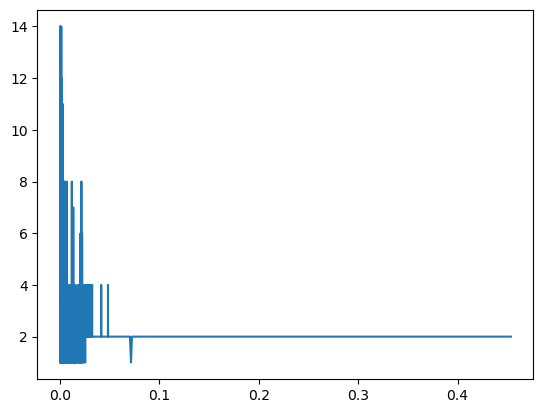

In [22]:
import matplotlib.pyplot as plt


values = all_bug['avg'].value_counts()

lists =  sorted(values.items())
print(lists)
x,y = zip(*lists)
# plt.plot(values_sim.keys().tolist(), values_sim.values)
plt.plot(x, y)
plt.show()

In [142]:
categories = pd.qcut(all_bug['avg'], 5, labels=['Very Low', 'Low','Medium', 'High', 'Very High'])
all_bug['category'] = categories
all_bug

Project Name                                    commit      LOC  \
0   AgentWorkbench  2bc9224e637d536fa0a1e758bad2b4e7d2fd11a8   697137   
1   AgentWorkbench  2bc9224e637d536fa0a1e758bad2b4e7d2fd11a8   697137   
2   AgentWorkbench  2bc9224e637d536fa0a1e758bad2b4e7d2fd11a8   697137   
3   AgentWorkbench  2bc9224e637d536fa0a1e758bad2b4e7d2fd11a8   697137   
4   AgentWorkbench  2bc9224e637d536fa0a1e758bad2b4e7d2fd11a8   697137   
..             ...                                       ...      ...   
62       workcraft  24dd2abbf6d309f70ca0429febb8767115048024  1141200   
63       workcraft  24dd2abbf6d309f70ca0429febb8767115048024  1141200   
64       workcraft  24dd2abbf6d309f70ca0429febb8767115048024  1141200   
65       workcraft  24dd2abbf6d309f70ca0429febb8767115048024  1141200   
66       workcraft  24dd2abbf6d309f70ca0429febb8767115048024  1141200   

           Project                  Smell  count       avg             grp  \
0   AgentWorkbench    Complex Conditional    441  0.000633  Implementation   
1   AgentWorkbench         Complex Method   1197  0.001717  Implementation   
2   AgentWorkbench     Empty catch clause    210  0.000301  Implementation   
3   AgentWorkbench        Long Identifier   2478  0.003555  Implementation   
4   AgentWorkbench            Long Method    147  0.000211  Implementation   
..             ...                    ...    ...       ...             ...   
62       workcraft      Cyclic Dependency   2682  0.002350    Architecture   
63       workcraft        Dense Structure     18  0.000016    Architecture   
64       workcraft  Feature Concentration    846  0.000741    Architecture   
65       workcraft          God Component    180  0.000158    Architecture   
66       workcraft    Unstable Dependency    648  0.000568    Architecture   

       label  category  
0   Inducing    Medium  
1   Inducing      High  
2   Inducing       Low  
3   Inducing      High  
4   Inducing       Low  
..       ...       ...  
62    Fixing      High  
63    Fixing  Very Low  
64    Fixing    Medium  
65    Fixing  Very Low  
66    Fixing    Medium  

[21292 rows x 10 columns]

In [162]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

smells = all_bug['Smell'].unique()
cramers_v_df = pd.DataFrame(columns=['Smell', 'cramers_v'])

# print(contingency_table)
for smell in smells:
    temp_bug = all_bug.copy()
    temp_bug = temp_bug[temp_bug['Smell']==smell]
    contingency_table = pd.crosstab(temp_bug['label'], temp_bug['category'])
    chi2, pval, dof, expected = chi2_contingency(contingency_table.fillna(0))
#     print(smell, pval)
    n = contingency_table.values.sum()
    k = contingency_table.shape[1]
    r = contingency_table.shape[0]
    cramers_v = np.sqrt(chi2 / (n * min(k-1, r-1)))

    # Append the results to the cramers_v_df
    cramers_v_df = pd.concat([cramers_v_df, pd.DataFrame({'Smell': [smell], 'cramers_v': [cramers_v], 'p_value':[pval]})], ignore_index=True)

cramers_v_df

C:\Users\riasa\AppData\Local\Temp\ipykernel_20980\765536339.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cramers_v_df = pd.concat([cramers_v_df, pd.DataFrame({'Smell': [smell], 'cramers_v': [cramers_v], 'p_value':[pval]})], ignore_index=True)
C:\Users\riasa\AppData\Local\Temp\ipykernel_20980\765536339.py:18: RuntimeWarning: invalid value encountered in divide
  cramers_v = np.sqrt(chi2 / (n * min(k-1, r-1)))


Smell  cramers_v   p_value
0                       Complex Conditional   0.000000  1.000000
1                            Complex Method   0.000000  1.000000
2                        Empty catch clause   0.000000  1.000000
3                           Long Identifier   0.000000  1.000000
4                               Long Method   0.000000  1.000000
5                       Long Parameter List   0.000000  1.000000
6                            Long Statement   0.000000  1.000000
7                              Magic Number   0.000000  1.000000
8                           Missing default   0.000000  1.000000
9   Abstract Function Call From Constructor   0.000000  1.000000
10                         Broken Hierarchy   0.110897  0.158348
11                    Broken Modularization   0.113427  0.130604
12                         Cyclic Hierarchy   0.056553  0.884327
13      Cyclically-dependent Modularization   0.073032  0.521463
14                  Deficient Encapsulation   0.058368  0.704499
15                             Feature Envy   0.123369  0.081855
16                   Imperative Abstraction   0.196346  0.006165
17              Insufficient Modularization   0.031097  0.961491
18                        Missing Hierarchy   0.082965  0.621711
19                      Multipath Hierarchy   0.029951  0.764551
20                Unexploited Encapsulation   0.045572  0.919234
21                   Unutilized Abstraction   0.075817  0.277980
22                  Hub-like Modularization   0.000000  1.000000
23                           Wide Hierarchy   0.028609  0.628517
24                     Rebellious Hierarchy   0.086085  0.446998
25                 Multifaceted Abstraction   0.126884  0.389991
26                           Deep Hierarchy        NaN  1.000000
27                        Cyclic Dependency   0.034300  0.942807
28                          Dense Structure   0.045181  0.606460
29                    Feature Concentration   0.102886  0.058798
30                      Unstable Dependency   0.091675  0.220785
31                            God Component   0.005901  0.913614
32                  Scattered Functionality   0.084107  0.788556

In [137]:
cramers_v_df.sort_values(by='cramers_v', ascending=False)

Empty DataFrame
Columns: [Smell, cramers_v]
Index: []

In [136]:
cramers_v_df.sort_values(by='p_value', ascending=False)

KeyError: 'p_value'

In [286]:
import pandas as pd
from scipy.stats import chi2_contingency
p_values = {}

for smell in set(all_grp['Smell']):
    print(smell)
    contingency_table = all_grp.pivot_table(values='count', index='commit', columns='Smell', aggfunc='sum', fill_value=0)
    contingency_table['all'] = contingency_table.loc[:, contingency_table.columns != smell].sum(axis=1)

    chi2, p, _, _ = chi2_contingency(contingency_table)
    print(chi2, " ",  p)

Missing Hierarchy
6786159.967955271   0.0
Unutilized Abstraction
6848891.3702110415   0.0
Unstable Dependency
6781893.749107021   0.0
Deep Hierarchy
6782317.685420003   0.0
Complex Method
6795624.72707304   0.0
Feature Envy
6778817.194957129   0.0
Scattered Functionality
6788959.156827128   0.0
Long Method
6782380.634701954   0.0
Magic Number
6896734.610815161   0.0
Empty catch clause
6797996.404465427   0.0
God Component
6781856.1328969775   0.0
Cyclic Dependency
6778422.465093145   0.0
Multipath Hierarchy
6782102.028009811   0.0
Complex Conditional
6790257.144177148   0.0
Missing default
6787148.392269491   0.0
Multifaceted Abstraction
6782287.262555692   0.0
Feature Concentration
6786147.650904056   0.0
Long Statement
7187936.946470187   0.0
Hub-like Modularization
6782093.13213909   0.0
Broken Hierarchy
6826170.919279959   0.0
Unexploited Encapsulation
6785974.81669079   0.0
Wide Hierarchy
6782876.825043043   0.0
Long Parameter List
6882529.248559688   0.0
Dense Structure
6782468.9

                                        commit             grp    LOC  count
0     00435f6fde51923b4bec49e540c3314d538ae87e    Architecture  32775     19
1     00435f6fde51923b4bec49e540c3314d538ae87e  Implementation  32775   8873
2     009f991039ed4098d415ea208234d657e5de0d51    Architecture  15402    432
3     009f991039ed4098d415ea208234d657e5de0d51          Design  15402    744
4     009f991039ed4098d415ea208234d657e5de0d51  Implementation  15402    666
...                                        ...             ...    ...    ...
2120  ffc7a93d041c4c372b94293babfd89ed6cb66007          Design  43933    402
2121  ffc7a93d041c4c372b94293babfd89ed6cb66007  Implementation  43933   2506
2122  fff12a75dea4be8d9e34390dfef1c756087ee183    Architecture  23747    133
2123  fff12a75dea4be8d9e34390dfef1c756087ee183          Design  23747    286
2124  fff12a75dea4be8d9e34390dfef1c756087ee183  Implementation  23747   1300

[2125 rows x 4 columns]
              grp        LOC     count       avg
0 

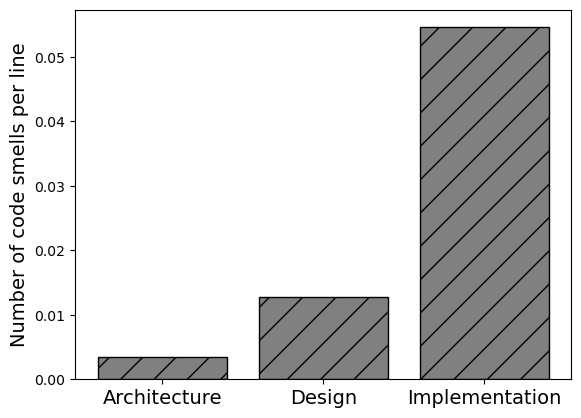

In [134]:
import matplotlib.pyplot as plt

data = all_grp.groupby(['commit', 'grp']).agg({'LOC': 'first', 'count': 'sum'}).reset_index()
print(data)
# data_imp = data[data['grp'] == 'Implementation']
data = data.groupby('grp').agg({'LOC': 'sum', 'count': 'sum'}).reset_index()
data['avg'] = data['count'] / data['LOC']
print(data)

# plt.figure(figsize=(12, 6)) 
plt.bar(['Architecture', 'Design', 'Implementation'], data['count'].tolist(), label='Bug Inducing Commits', color='gray', edgecolor='black', hatch='/')
plt.xticks(fontsize=14)
plt.ylabel("Number of code smells per line", fontsize=14)
plt.savefig('bug-all.png')
plt.show()

              Project             grp      LOC   count
0      AgentWorkbench  Implementation   697137  251368
1   BoomChess-Android  Implementation     6850     868
2              DesSim  Implementation     7944     225
3               EVLib  Implementation    16938    2418
4   Evolving-Protozoa  Implementation    24264    3152
..                ...             ...      ...     ...
74             varsim          Design   213590    3162
75             varsim  Implementation   244728  159776
76          workcraft    Architecture  1141200    4374
77          workcraft          Design  1141200   22356
78          workcraft  Implementation   746469  535748

[79 rows x 4 columns]
              grp       LOC     count       avg
0    Architecture   4035647     17421  0.004317
1          Design   4291626     60460  0.014088
2  Implementation  15107299  14271634  0.944685


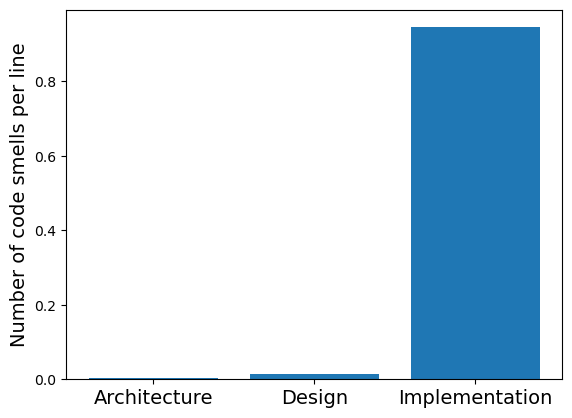

In [114]:
import matplotlib.pyplot as plt

data = all_grp_fix.groupby(['Project', 'grp']).agg({'LOC': 'first', 'count': 'sum'}).reset_index()
print(data)
# data_imp = data[data['grp'] == 'Implementation']
data = data.groupby('grp').agg({'LOC': 'sum', 'count': 'sum'}).reset_index()
data['avg'] = data['count'] / data['LOC']
print(data)

# plt.figure(figsize=(12, 6)) 
plt.bar(['Architecture', 'Design', 'Implementation'], data['avg'].tolist())
plt.xticks(fontsize=14)
plt.ylabel("Number of code smells per line", fontsize=14)
plt.savefig('bug-all.png')
plt.show()

['both', 'left_only', 'right_only']
6018


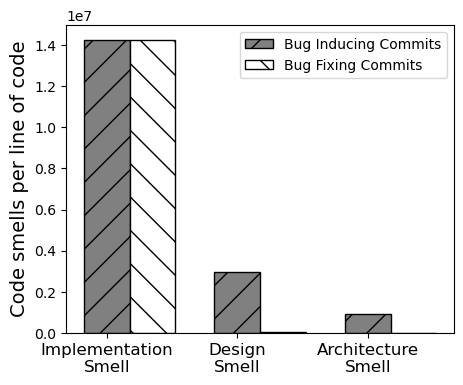

In [165]:
import matplotlib.pyplot as plt
import numpy as np

categories = [ "Implementation\nSmell","Design\nSmell", "Architecture\nSmell", ]

all_data = pd.merge(all_grp, all_grp_fix, how='outer', indicator=True)
print(all_data['_merge'].unique().tolist())
data = all_data[all_data['_merge'] == 'left_only']

data = all_grp.groupby(['grp', 'commit']).agg({'LOC': 'first', 'count': 'sum'}).reset_index()
data = data.groupby('grp').agg({'LOC': 'sum', 'count': 'sum'}).reset_index()
data['avg'] = data['count'] / data['LOC']
data = data.sort_values(by='grp', ascending=False)

data1 = all_data[all_data['_merge'] == 'right_only']
data1 = all_grp_fix.groupby(['grp', 'commit']).agg({'LOC': 'first', 'count': 'sum'}).reset_index()
data1 = data1.groupby('grp').agg({'LOC': 'sum', 'count': 'sum'}).reset_index()
data1['avg'] = data1['count'] / data1['LOC']
data1 = data1.sort_values(by='grp', ascending=False)

fig, ax = plt.subplots(figsize=(5, 4))

bar_width = 0.35
bar1 = ax.bar(np.arange(len(categories)), data['count'], bar_width, label='Bug Inducing Commits', color='gray', edgecolor='black', hatch='/')
bar2 = ax.bar(np.arange(len(categories)) + bar_width, data1['count'], bar_width, label='Bug Fixing Commits',color='white', edgecolor='black', hatch='\\')

print(len(all_data[all_data['_merge'] == 'both']))
# plt.figure(figsize=(12, 6)) 
# plt.bar(['Architecture', 'Design', 'Implementation'], data['avg'].tolist())
plt.xticks(fontsize=14)
ax.set_xticks(np.arange(len(categories)) )
ax.set_xticklabels(categories, fontsize=12)
plt.ylabel("Code smells per line of code", fontsize=14)
ax.legend()
plt.savefig('bug-all.png')
plt.show()

In [51]:
data = all_grp.groupby(['Project Name', 'grp']).agg({'LOC': 'first', 'count': 'sum'}).reset_index()

# data_imp = data[data['grp'] == 'Implementation']
data = data.groupby('grp').agg({'LOC': 'sum', 'count': 'sum'}).reset_index()
data['avg'] = data['count'] / data['LOC']
data

grp       LOC     count       avg
0    Architecture  15159674    914073  0.060296
1          Design  14694044   2969828  0.202111
2  Implementation  15107299  14271634  0.944685

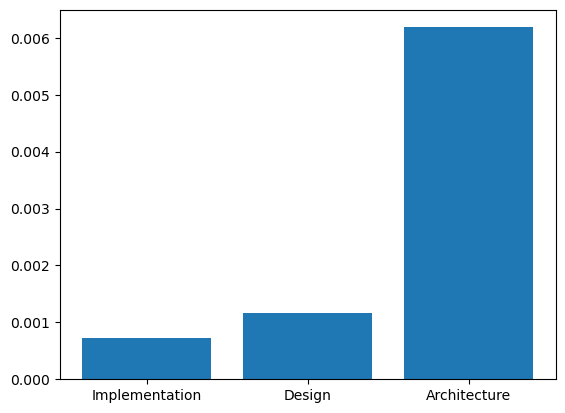

In [228]:
import matplotlib.pyplot as plt

data = all_grp.groupby('grp').agg({'LOC': 'sum', 'count': 'sum'}).reset_index()
data['avg'] = data['count'] / data['LOC']

# plt.figure(figsize=(12, 6)) 
plt.bar(['Implementation', 'Design', 'Architecture'], data['avg'].tolist())
# plt.xticks(rotation=30)
plt.savefig('bug-all.png')
plt.show()

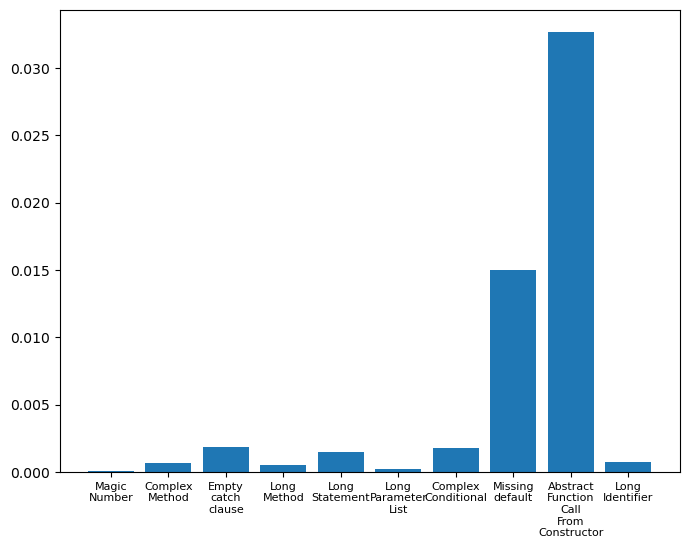

In [253]:
import matplotlib.pyplot as plt

data = imp_grp.groupby('Smell').agg({'LOC': 'sum', 'count': 'sum'}).reset_index()
data['avg'] = data['count'] / data['LOC']

plt.figure(figsize=(8, 6)) 
plt.bar(imp_smells, data['avg'].tolist())
plt.xticks(fontsize=8)
plt.savefig('bug-imp.png',dpi=300)
plt.show()

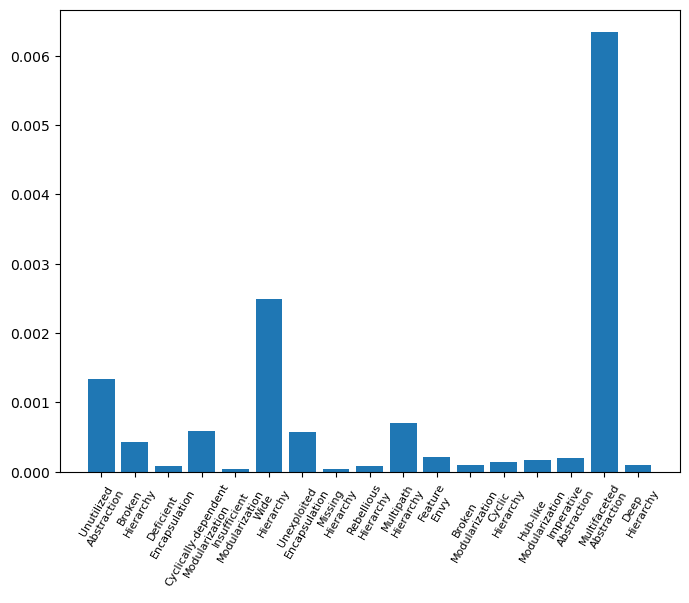

In [251]:
import matplotlib.pyplot as plt

data = des_grp.groupby('Smell').agg({'LOC': 'sum', 'count': 'sum'}).reset_index()
data['avg'] = data['count'] / data['LOC']

plt.figure(figsize=(8, 6)) 
plt.bar(des_smells, data['avg'].tolist())
plt.xticks(fontsize=8, rotation=60)
plt.savefig('bug-des.png', dpi=300)
plt.show()

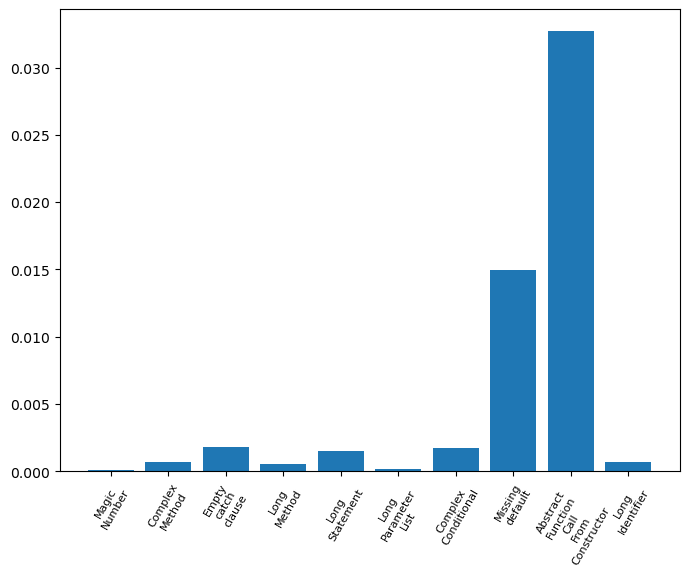

In [256]:
import matplotlib.pyplot as plt

data = imp_grp_fix.groupby('Smell').agg({'LOC': 'sum', 'count': 'sum'}).reset_index()
data['avg'] = data['count'] / data['LOC']

plt.figure(figsize=(8, 6)) 
plt.bar(imp_smells, data['avg'].tolist())
plt.xticks(fontsize=8, rotation=60)
# plt.savefig('bug-des.png', dpi=300)
plt.show()

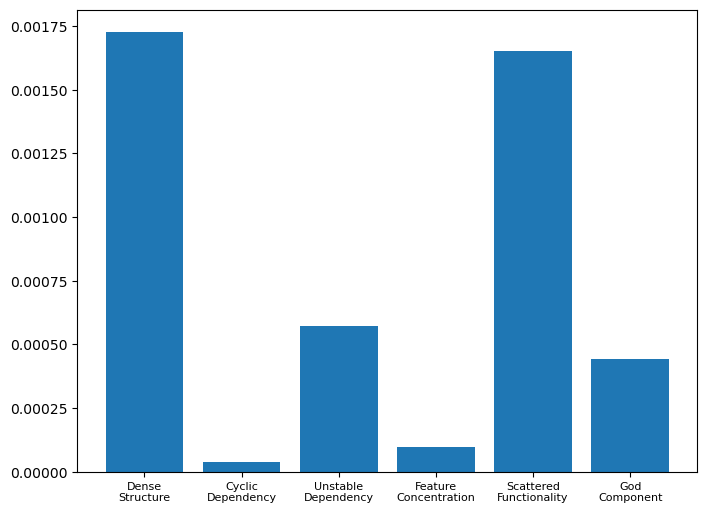

In [252]:
import matplotlib.pyplot as plt

data = arch_grp.groupby('Smell').agg({'LOC': 'sum', 'count': 'sum'}).reset_index()
data['avg'] = data['count'] / data['LOC']

plt.figure(figsize=(8, 6)) 
plt.bar(arch_smells, data['avg'].tolist())

plt.savefig('bug-arch.png',dpi=300)
plt.xticks(fontsize=8)
plt.show()

## break

In [1]:
from markdown import Markdown
from io import StringIO
from bs4 import BeautifulSoup

def unmark_element(element, stream=None):
    if stream is None:
        stream = StringIO()
    if element.text:
        stream.write(element.text)
    for sub in element:
        unmark_element(sub, stream)
    if element.tail:
        stream.write(element.tail)
    return stream.getvalue()


# patching Markdown
Markdown.output_formats["plain"] = unmark_element
__md = Markdown(output_format="plain")
__md.stripTopLevelTags = False


def unmark(text):
    return __md.convert(text)

In [2]:
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    clean_text = soup.get_text()
    return clean_text

In [3]:
def remove_excessive_newlines(text):
    cleaned_text = re.sub(r'\n+', '\n', text)
    cleaned_text = cleaned_text.strip()
    return cleaned_text

In [4]:
import re

def remove_urls(text):
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    return text

def remove_academic_references(text):
    # Remove academic references
    text = re.sub(r'\[\d+(,\d+)*\]', '', text)
    return text

def remove_emojis(text):
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text


In [5]:
def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result

In [18]:
java_stopwords = [
    'abstract', 'assert', 'boolean', 'break', 'byte', 'case', 'catch', 'char', 'class', 'const', 'continue', 
    'default', 'do', 'double', 'else', 'enum', 'extends', 'final', 'finally', 'float', 'for', 'goto', 'if', 
    'implements', 'import', 'instanceof', 'int', 'interface', 'long', 'native', 'new', 'null', 'package', 
    'private', 'protected', 'public', 'return', 'short', 'static', 'strictfp', 'super', 'switch', 'synchronized', 
    'this', 'throw', 'throws', 'transient', 'try', 'void', 'volatile', 'while',
    # Additional common words
    'project', 'repository', 'github', 'issue', 'pull', 'request', 'commit', 'branch', 'merge', 'clone', 'build', 
    'run', 'test', 'code', 'file', 'folder', 'directory', 'path', 'java', 'jvm', 'jdk', 'jre', 'maven', 'gradle', 
    'dependency', 'dependencies', 'version', 'plugin', 'module', 'library', 'documentation', 'doc', 'docs', 'readme', 
    'contribute', 'contributing', 'license', 'example', 'examples', 'sample', 'samples', 'src', 'source', 'main', 
    'resources', 'bin', 'target', 'output', 'input', 'user', 'name', 'description', 'author', 'maintainer', 'date', 
    'time', 'note', 'notes', 'tip', 'tips', 'warning', 'warnings', 'error', 'errors', 'exception', 'exceptions', 
    'log', 'logs', 'logging', 'message', 'messages', 'debug', 'trace', 'info', 'warn', 'fatal', 'severe', 'status', 
    'state', 'config', 'configuration', 'setup', 'installation', 'install', 'uninstall', 'update', 'upgrade', 'version', 
    'versions', 'feature', 'features', 'option', 'options', 'parameter', 'parameters', 'argument', 'arguments', 
    'flag', 'flags', 'setting', 'settings', 'property', 'properties', 'value', 'values', 'default', 'defaults', 'enabled', 
    'disabled', 'true', 'false', 'yes', 'no', 'null', 'none', 'void', 'eclipse'
]

def remove_java_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in java_stopwords]
    filtered_text = ' '.join(filtered_words)
    
    return filtered_text

In [19]:
project_names = []
repo_path = os.path.join('data', 'repos', 'simulation')

project_names = []
for repo in os.listdir(repo_path):
    repo_name = repo.split()
    project_names += repo_name
    
print(project_names)

def remove_project_names(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in project_names]
    filtered_text = ' '.join(filtered_words)
    
    return filtered_text

['aerie', 'amodeus', 'cas', 'cloudsimplus', 'cloudsimsdn', 'computer_kurzweil', 'eqasim-java', 'Evolving-Protozoa', 'finmath-lib', 'gama', 'gips', 'iflye', 'keywords.csv', 'mars-sim', 'MATSim-UAM', 'microtrafficsim', 'Mirage', 'MiSim', 'multiphysics', 'PowerSystemDataModel', 'QSPcc', 'react-native-ble-peripheral', 'Robot-Overlord-App', 'SASS', 'ShapeOfThingsThatWere', 'simulation-construction-set-2', 'synthea', 'varsim', 'workcraft']


In [20]:
def clean_text(text):
    text = remove_excessive_newlines(text)
    text = unmark(text)
    text = remove_urls(text)
    text = remove_academic_references(text)
    text = remove_emojis(text)
    text = remove_html_tags(text)
    text = remove_excessive_newlines(text)
    text = remove_numbers(text)
    text = remove_project_names(text)
    text = remove_java_stopwords(text)
    
    return text

In [21]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import pandas as pd
import os

from sklearn.feature_extraction.text import TfidfVectorizer

# Download the stopwords from NLTK
nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):
    # Tokenize the text
    words = word_tokenize(text)

    # Remove punctuation and convert to lower case
    words = [word.lower() for word in words if word.isalnum()]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    return ' '.join(words)

def extract_keywords(text_array):

    # Preprocess the documents
    documents = [preprocess_text(doc) for doc in text_array]

    # Create the TfidfVectorizer
    vectorizer = TfidfVectorizer()

    # Compute TF-IDF
    tfidf_matrix = vectorizer.fit_transform(documents)

    # Get the words
    words = vectorizer.get_feature_names_out()

    # Compute the sum of TF-IDF scores for each word
    sum_tfidf = tfidf_matrix.sum(axis=0).A1

    # Create a DataFrame with the words and their sum of TF-IDF scores
    df = pd.DataFrame({'Keyword': words, 'Sum TF-IDF': sum_tfidf})

    # Sort the DataFrame by the sum of TF-IDF scores
    df = df.sort_values('Sum TF-IDF', ascending=False)

    return df


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\riasa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\riasa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
import os
import shutil
import re
import git
import pandas as pd

repo_path = os.path.join('data', 'repos', 'simulation')

text_array = []
for repo in os.listdir(repo_path):
    repo_folder_path = os.path.join(repo_path, repo)
    
    if os.path.isdir(repo_folder_path):
        readme_file = os.path.join(repo_folder_path, "README.md")

        text = ""
        with open(readme_file, "r", encoding='utf-8') as file:
            text = file.read()

        text = clean_text(text)
        text_array.append(text)
        

keywords = extract_keywords(text_array)
print(keywords)
print(repo_folder_path)
keywords.to_csv(os.path.join(repo_path, 'keywords.csv'))

         Keyword  Sum TF-IDF
4045  simulation    1.669752
2826       model    0.919305
3900         see    0.880406
737     cloudsim    0.776983
1042        data    0.773725
...          ...         ...
2998      nvidia    0.007021
270        arise    0.007021
3021        odes    0.007021
3022      odeset    0.007021
1683       flags    0.007021

[4977 rows x 2 columns]
data\repos\simulation\workcraft


In [56]:
import os
import shutil
import re
import git
import pandas as pd

repo_path = os.path.join('data', 'repos', 'traditional')

text_array = []
for repo in os.listdir(repo_path):
    repo_folder_path = os.path.join(repo_path, repo)
    
    if os.path.isdir(repo_folder_path):
        readme_file = os.path.join(repo_folder_path, "README.md")

        text = ""
        
        if os.path.exists(readme_file):
            with open(readme_file, "r", encoding='utf-8') as file:
                text = file.read()

            text = clean_text(text)
            text_array.append(text)
        

keywords = extract_keywords(text_array)
print(keywords)
print(repo_folder_path)
keywords.to_csv(os.path.join(repo_path, 'keywords.csv'))

C:\Users\riasa\anaconda3\Lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


                    Keyword  Sum TF-IDF
5230                    web    3.894128
4660                 string    3.828596
4319                 server    2.954368
5077                    use    2.884264
232             application    2.838773
...                     ...         ...
1891      getallprogressbar    0.003982
1195                 denied    0.003982
1303      diskmirrorbackend    0.003982
2052                   hash    0.003982
4957  transferdepositstatus    0.003982

[5504 rows x 2 columns]
data\repos\traditional\YangMVC


In [9]:
import os
import shutil
import re
import git
import pandas as pd

cat_path = os.path.join('data', 'categories', 'simulation')


for cat_folder in os.listdir(cat_path):
    cat_folder_path = os.path.join(cat_path, cat_folder)
    if os.path.isdir(cat_folder_path):
        text_array = []
        for cat_subfolder in os.listdir(cat_folder_path):
            cat_subfolder_path = os.path.join(cat_folder_path, cat_subfolder)
            
            if os.path.isdir(cat_subfolder_path):    
                readme_file = os.path.join(cat_subfolder_path, "README.md")

                text = ""
                with open(readme_file, "r", encoding='utf-8') as file:
                    text = file.read()

                text = clean_text(text)
                text_array.append(text)
        
        keywords = extract_keywords(text_array)
        print(keywords)
        print(cat_folder_path)
        keywords.to_csv(os.path.join(cat_folder_path, 'keywords.csv'))
        

          Keyword  Sum TF-IDF
756          java    0.752579
1377   simulation    0.461010
1478      systems    0.409301
926       mission    0.399772
1611      version    0.373891
...           ...         ...
691     incidents    0.011911
1284      sandbox    0.011911
698   incorporate    0.011911
699    incredible    0.011911
0         ability    0.011911

[1685 rows x 2 columns]
data\categories\simulation\Aerospce & Transportation
         Keyword  Sum TF-IDF
165     cloudsim    0.622599
1068  simulation    0.560238
918        query    0.517253
888      project    0.510568
1249          vm    0.462536
...          ...         ...
1150      tables    0.010556
1151   tablesize    0.010556
996      rounded    0.010556
1155      taking    0.010556
647     linearly    0.010556

[1294 rows x 2 columns]
data\categories\simulation\Computation & Networking
          Keyword  Sum TF-IDF
860    simulation    0.619448
280       eclipse    0.533790
402          gips    0.517649
116      cellular

In [13]:
import pandas as pd

cat_path = os.path.join('data', 'categories', 'simulation')


for cat_folder in os.listdir(cat_path):
    cat_folder_path = os.path.join(cat_path, cat_folder)
    if os.path.isdir(cat_folder_path):
        keywords = pd.read_csv(os.path.join(cat_folder_path, "keywords.csv"))
        keywords = keywords.sort_values(by='Sum TF-IDF', ascending=False).reset_index(drop=True)
        keywords.to_csv(os.path.join(cat_folder_path, "keywords.csv"))
        print(keywords)

      Unnamed: 0     Keyword  Sum TF-IDF
0            756        java    0.752579
1           1377  simulation    0.461010
2           1478     systems    0.409301
3            926     mission    0.399772
4           1611     version    0.373891
...          ...         ...         ...
1680          82  applicable    0.011911
1681          87        arab    0.011911
1682        1608   vehicular    0.011911
1683         132     balance    0.011911
1684           0     ability    0.011911

[1685 rows x 3 columns]
      Unnamed: 0     Keyword  Sum TF-IDF
0            165    cloudsim    0.622599
1           1068  simulation    0.560238
2            918       query    0.517253
3            888     project    0.510568
4           1249          vm    0.462536
...          ...         ...         ...
1289         141  characters    0.010556
1290        1241        view    0.010556
1291        1243     viewing    0.010556
1292         953   rendering    0.010556
1293         647    linearly    

In [14]:
import pandas as pd

cat_path = os.path.join('data', 'categories', 'simulation')

df_list = []
for cat_folder in os.listdir(cat_path):
    cat_folder_path = os.path.join(cat_path, cat_folder)
    if os.path.isdir(cat_folder_path):
        keywords = pd.read_csv(os.path.join(cat_folder_path, "keywords.csv"))
        keywords = keywords.sort_values(by='Sum TF-IDF', ascending=False).reset_index(drop=True)
        df_list.append(keywords)
    
    
merged_df = pd.concat(df_list)
final_df = merged_df.groupby('Keyword').sum().reset_index()
final_df = final_df.sort_values(by='Sum TF-IDF', ascending=False).reset_index(drop=True)
final_df.to_csv(os.path.join(cat_path, "keywords.csv"))
print(final_df)

          Keyword  Unnamed: 0.1  Unnamed: 0  Sum TF-IDF
0      simulation            52        6078    2.063247
1            java           109        3439    1.792310
2         project           109        5155    1.581415
3            file           165        2454    1.454596
4             run           110        5713    1.253548
...           ...           ...         ...         ...
5012      discard          2225         643    0.005850
5013  directories          2223         639    0.005850
5014    blazingly          2585         259    0.005850
5015    directive          2222         637    0.005850
5016       trento          2636        2446    0.005850

[5017 rows x 4 columns]


In [28]:
import matplotlib.pyplot as plt
import requests
import csv

def fetch_repository_information(query):
    url = "https://api.github.com/search/repositories"
    params = {
        "q": query,
        "per_page": 100,
        "sort": "stars",
        "order": "desc"
    }
    headers = {
        "Accept": "application/vnd.github.v3+json"
    }
    response = requests.get(url, params=params, headers=headers)

    repo_info = []

    if response.status_code == 200:
        last_page = 20
        for page in range(1,last_page):
            if response.status_code != 200:
                print("Disconnected at page ", page)
                break

            data = response.json()['items']

            repo_info.append(data)
            if page < last_page:
                print(response.links)
                if  not 'next' in response.links:
                    print("No Next Page after page ", page)
                    break
                next_url = response.links['next']['url']
                response = requests.get(next_url)
            else:
                break

        # print(repo_info)
        return repo_info
    else:
        print(f"Failed to fetch repository information. Status code: {response.status_code}")
        return None

def write_to_csv(repository_list, csv_filename):
    if not repository_list:
        print("No repository data to write.")
        return

    fieldnames = [
        "ID", "Name","URL", "IsFork", "Commits", "Branches", "Releases", "Forks", "MainLanguage",
        "DefaultBranch", "License", "Homepage", "Watchers", "Stargazers", "Contributors",
        "Size", "CreatedAt", "PushedAt", "UpdatedAt", "TotalIssues", "OpenIssues",
        "TotalPullRequests", "OpenPullRequests",   "HasWiki", "IsArchived", "IsDisabled", "Topics"
    ]

    with open(csv_filename, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for page in repository_list:
            for repo in page:
                writer.writerow({
                    "ID": repo["id"],
                    "Name": repo["name"],
                    "URL": repo["html_url"],
                    "IsFork": repo["fork"],
                    "Commits": repo["commits_url"],
                    "Branches": repo["branches_url"],
                    "Releases": repo["releases_url"],
                    "Forks": repo["forks_count"],
                    "MainLanguage": repo["language"],
                    "DefaultBranch": repo["default_branch"],
                    "License": repo["license"]["name"] if repo["license"] else None,
                    "Homepage": repo["homepage"],
                    "Watchers": repo["watchers_count"],
                    "Stargazers": repo["stargazers_count"],
                    "Contributors":  len(repo["contributors_url"]) if "contributors_url" in repo else 0,
                    "CreatedAt": repo["created_at"],
                    "PushedAt": repo["pushed_at"],
                    "UpdatedAt": repo["updated_at"],
                    "TotalIssues": repo["open_issues_count"],
                    "OpenIssues": repo["open_issues_count"],
                    "TotalPullRequests": repo["pulls_url"],
                    "OpenPullRequests": repo["pulls_url"],
                    "HasWiki": repo["has_wiki"],
                    "IsArchived": repo["archived"],
                    "IsDisabled": repo["disabled"],
                    "Topics": repo["topics"] if "topics" in repo else None
                })


In [29]:
def search_and_save_repos(query, filepath):
    print("Searching with the query ", query)
    repositories = fetch_repository_information(query)
    write_to_csv(repositories, filepath)

    print(f"Repository information has been written to '{filepath}'.")

In [35]:
import pandas as pd
import os

repos_path = os.path.join('data', 'repos', 'simulation')

if os.path.isdir(repos_path):
    keywords = pd.read_csv(os.path.join(repos_path, "keywords.csv"))
    top_3 = keywords['Keyword'].to_list()[:3]

    print(top_3)
        
    for keyword in top_3:
        csv_path = os.path.join(repos_path, 'keyword_'+keyword+'.csv')
            
        if os.path.exists(csv_path):
            print("CSV already written for keyword ", keyword)
            continue
                
        query = "language:java -topic:simulation"
        query += " " + keyword
        search_and_save_repos(query, csv_path)

['simulation', 'model', 'see']
CSV already written for keyword  simulation
CSV already written for keyword  model
Searching with the query  language:java -topic:simulation see
{'next': {'url': 'https://api.github.com/search/repositories?q=language%3Ajava+-topic%3Asimulation+see&per_page=100&sort=stars&order=desc&page=2', 'rel': 'next'}, 'last': {'url': 'https://api.github.com/search/repositories?q=language%3Ajava+-topic%3Asimulation+see&per_page=100&sort=stars&order=desc&page=10', 'rel': 'last'}}
{'prev': {'url': 'https://api.github.com/search/repositories?q=language%3Ajava+-topic%3Asimulation+see&per_page=100&sort=stars&order=desc&page=1', 'rel': 'prev'}, 'next': {'url': 'https://api.github.com/search/repositories?q=language%3Ajava+-topic%3Asimulation+see&per_page=100&sort=stars&order=desc&page=3', 'rel': 'next'}, 'last': {'url': 'https://api.github.com/search/repositories?q=language%3Ajava+-topic%3Asimulation+see&per_page=100&sort=stars&order=desc&page=10', 'rel': 'last'}, 'first': {

In [69]:
import pandas as pd
import os

repos_path = os.path.join('data', 'repos', 'traditional')

if os.path.isdir(repos_path):
    keywords = pd.read_csv(os.path.join(repos_path, "keywords.csv"))
    top_10 = keywords['Keyword'].to_list()[:10]

    print(top_10)
        
    for keyword in top_10:
        csv_path = os.path.join(repos_path, 'keyword_'+keyword+'.csv')
        print(csv_path)
        if os.path.exists(csv_path):
            print("CSV already written for keyword ", keyword)
            continue
                
        query = "language:java -topic:web -topic:android -topic:desktop"
        query += " " + keyword
        search_and_save_repos(query, csv_path)

['web', 'string', 'server', 'use', 'application', 'spring', 'add', 'id', 'using', 'get']
data\repos\traditional\keyword_web.csv
CSV already written for keyword  web
data\repos\traditional\keyword_string.csv
CSV already written for keyword  string
data\repos\traditional\keyword_server.csv
CSV already written for keyword  server
data\repos\traditional\keyword_use.csv
CSV already written for keyword  use
data\repos\traditional\keyword_application.csv
CSV already written for keyword  application
data\repos\traditional\keyword_spring.csv
CSV already written for keyword  spring
data\repos\traditional\keyword_add.csv
Searching with the query  language:java -topic:web -topic:android -topic:desktop add
{'next': {'url': 'https://api.github.com/search/repositories?q=language%3Ajava+-topic%3Aweb+-topic%3Aandroid+-topic%3Adesktop+add&per_page=100&sort=stars&order=desc&page=2', 'rel': 'next'}, 'last': {'url': 'https://api.github.com/search/repositories?q=language%3Ajava+-topic%3Aweb+-topic%3Aandroid

{'prev': {'url': 'https://api.github.com/search/repositories?q=language%3Ajava+-topic%3Aweb+-topic%3Aandroid+-topic%3Adesktop+id&per_page=100&sort=stars&order=desc&page=2', 'rel': 'prev'}, 'next': {'url': 'https://api.github.com/search/repositories?q=language%3Ajava+-topic%3Aweb+-topic%3Aandroid+-topic%3Adesktop+id&per_page=100&sort=stars&order=desc&page=4', 'rel': 'next'}, 'last': {'url': 'https://api.github.com/search/repositories?q=language%3Ajava+-topic%3Aweb+-topic%3Aandroid+-topic%3Adesktop+id&per_page=100&sort=stars&order=desc&page=10', 'rel': 'last'}, 'first': {'url': 'https://api.github.com/search/repositories?q=language%3Ajava+-topic%3Aweb+-topic%3Aandroid+-topic%3Adesktop+id&per_page=100&sort=stars&order=desc&page=1', 'rel': 'first'}}
{'prev': {'url': 'https://api.github.com/search/repositories?q=language%3Ajava+-topic%3Aweb+-topic%3Aandroid+-topic%3Adesktop+id&per_page=100&sort=stars&order=desc&page=3', 'rel': 'prev'}, 'next': {'url': 'https://api.github.com/search/reposito

{'prev': {'url': 'https://api.github.com/search/repositories?q=language%3Ajava+-topic%3Aweb+-topic%3Aandroid+-topic%3Adesktop+using&per_page=100&sort=stars&order=desc&page=4', 'rel': 'prev'}, 'next': {'url': 'https://api.github.com/search/repositories?q=language%3Ajava+-topic%3Aweb+-topic%3Aandroid+-topic%3Adesktop+using&per_page=100&sort=stars&order=desc&page=6', 'rel': 'next'}, 'last': {'url': 'https://api.github.com/search/repositories?q=language%3Ajava+-topic%3Aweb+-topic%3Aandroid+-topic%3Adesktop+using&per_page=100&sort=stars&order=desc&page=10', 'rel': 'last'}, 'first': {'url': 'https://api.github.com/search/repositories?q=language%3Ajava+-topic%3Aweb+-topic%3Aandroid+-topic%3Adesktop+using&per_page=100&sort=stars&order=desc&page=1', 'rel': 'first'}}
{'prev': {'url': 'https://api.github.com/search/repositories?q=language%3Ajava+-topic%3Aweb+-topic%3Aandroid+-topic%3Adesktop+using&per_page=100&sort=stars&order=desc&page=5', 'rel': 'prev'}, 'next': {'url': 'https://api.github.com/

{'prev': {'url': 'https://api.github.com/search/repositories?q=language%3Ajava+-topic%3Aweb+-topic%3Aandroid+-topic%3Adesktop+get&per_page=100&sort=stars&order=desc&page=6', 'rel': 'prev'}, 'next': {'url': 'https://api.github.com/search/repositories?q=language%3Ajava+-topic%3Aweb+-topic%3Aandroid+-topic%3Adesktop+get&per_page=100&sort=stars&order=desc&page=8', 'rel': 'next'}, 'last': {'url': 'https://api.github.com/search/repositories?q=language%3Ajava+-topic%3Aweb+-topic%3Aandroid+-topic%3Adesktop+get&per_page=100&sort=stars&order=desc&page=10', 'rel': 'last'}, 'first': {'url': 'https://api.github.com/search/repositories?q=language%3Ajava+-topic%3Aweb+-topic%3Aandroid+-topic%3Adesktop+get&per_page=100&sort=stars&order=desc&page=1', 'rel': 'first'}}
{'prev': {'url': 'https://api.github.com/search/repositories?q=language%3Ajava+-topic%3Aweb+-topic%3Aandroid+-topic%3Adesktop+get&per_page=100&sort=stars&order=desc&page=7', 'rel': 'prev'}, 'next': {'url': 'https://api.github.com/search/rep

In [75]:
import os
import glob
import pandas as pd

repos_path = os.path.join('data', 'repos', 'simulation')

csv_files = glob.glob(os.path.join(repos_path, 'keyword_*.csv'))

new_df = pd.DataFrame()
for file in csv_files:
    df = pd.read_csv(file)
    if len(new_df) == 0:
        new_df = df
    else:
        pd.merge(new_df, df, how='outer')

new_df

ID                           Name  \
0     14734876                 deeplearning4j   
1     50904245                           beam   
2     89322848                          angel   
3     32834215                          mosby   
4     13486910                        rebound   
..         ...                            ...   
995  257290487  Android-Sensor-Data-Collector   
996   14285346                      simplecsv   
997  145095897      Blockchain-based_E-Voting   
998   57598034                         Marvel   
999  137455765                        jdclare   

                                                   URL  IsFork  \
0     https://github.com/deeplearning4j/deeplearning4j   False   
1                       https://github.com/apache/beam   False   
2                    https://github.com/Angel-ML/angel   False   
3                    https://github.com/sockeqwe/mosby   False   
4           https://github.com/facebookarchive/rebound   False   
..                                                 ...     ...   
995  https://github.com/yadev64/Android-Sensor-Data...   False   
996                https://github.com/quux00/simplecsv   False   
997  https://github.com/hvudeshi/Blockchain-based_E...   False   
998                  https://github.com/Nepxion/Marvel   False   
999      https://github.com/ModelingValueGroup/jdclare   False   

                                               Commits  \
0    https://api.github.com/repos/deeplearning4j/de...   
1    https://api.github.com/repos/apache/beam/commi...   
2    https://api.github.com/repos/Angel-ML/angel/co...   
3    https://api.github.com/repos/sockeqwe/mosby/co...   
4    https://api.github.com/repos/facebookarchive/r...   
..                                                 ...   
995  https://api.github.com/repos/yadev64/Android-S...   
996  https://api.github.com/repos/quux00/simplecsv/...   
997  https://api.github.com/repos/hvudeshi/Blockcha...   
998  https://api.github.com/repos/Nepxion/Marvel/co...   
999  https://api.github.com/repos/ModelingValueGrou...   

                                              Branches  \
0    https://api.github.com/repos/deeplearning4j/de...   
1    https://api.github.com/repos/apache/beam/branc...   
2    https://api.github.com/repos/Angel-ML/angel/br...   
3    https://api.github.com/repos/sockeqwe/mosby/br...   
4    https://api.github.com/repos/facebookarchive/r...   
..                                                 ...   
995  https://api.github.com/repos/yadev64/Android-S...   
996  https://api.github.com/repos/quux00/simplecsv/...   
997  https://api.github.com/repos/hvudeshi/Blockcha...   
998  https://api.github.com/repos/Nepxion/Marvel/br...   
999  https://api.github.com/repos/ModelingValueGrou...   

                                              Releases  Forks MainLanguage  \
0    https://api.github.com/repos/deeplearning4j/de...   3823         Java   
1    https://api.github.com/repos/apache/beam/relea...   4148         Java   
2    https://api.github.com/repos/Angel-ML/angel/re...   1605         Java   
3    https://api.github.com/repos/sockeqwe/mosby/re...    840         Java   
4    https://api.github.com/repos/facebookarchive/r...    823         Java   
..                                                 ...    ...          ...   
995  https://api.github.com/repos/yadev64/Android-S...      5         Java   
996  https://api.github.com/repos/quux00/simplecsv/...      3         Java   
997  https://api.github.com/repos/hvudeshi/Blockcha...      6         Java   
998  https://api.github.com/repos/Nepxion/Marvel/re...      2         Java   
999  https://api.github.com/repos/ModelingValueGrou...      0         Java   

    DefaultBranch  ...              PushedAt             UpdatedAt  \
0          master  ...  2024-05-15T12:03:49Z  2024-05-24T12:40:40Z   
1          master  ...  2024-05-24T15:26:32Z  2024-05-24T03:51:57Z   
2          master  ...  2024-01-16T08:06:37Z  2024-05-21T10:03:46Z   
3          master  

In [76]:
old_df = pd.read_csv(os.path.join('data', 'java-sims.csv'))

common_items = pd.merge(new_df, old_df, how='inner')

merged_df = new_df[~new_df.isin(common_items).all(axis=1)]

merged_df.to_csv(os.path.join('data', 'java-sims-extended.csv'))
merged_df

ID                           Name  \
0     14734876                 deeplearning4j   
1     50904245                           beam   
2     89322848                          angel   
3     32834215                          mosby   
4     13486910                        rebound   
..         ...                            ...   
995  257290487  Android-Sensor-Data-Collector   
996   14285346                      simplecsv   
997  145095897      Blockchain-based_E-Voting   
998   57598034                         Marvel   
999  137455765                        jdclare   

                                                   URL  IsFork  \
0     https://github.com/deeplearning4j/deeplearning4j   False   
1                       https://github.com/apache/beam   False   
2                    https://github.com/Angel-ML/angel   False   
3                    https://github.com/sockeqwe/mosby   False   
4           https://github.com/facebookarchive/rebound   False   
..                                                 ...     ...   
995  https://github.com/yadev64/Android-Sensor-Data...   False   
996                https://github.com/quux00/simplecsv   False   
997  https://github.com/hvudeshi/Blockchain-based_E...   False   
998                  https://github.com/Nepxion/Marvel   False   
999      https://github.com/ModelingValueGroup/jdclare   False   

                                               Commits  \
0    https://api.github.com/repos/deeplearning4j/de...   
1    https://api.github.com/repos/apache/beam/commi...   
2    https://api.github.com/repos/Angel-ML/angel/co...   
3    https://api.github.com/repos/sockeqwe/mosby/co...   
4    https://api.github.com/repos/facebookarchive/r...   
..                                                 ...   
995  https://api.github.com/repos/yadev64/Android-S...   
996  https://api.github.com/repos/quux00/simplecsv/...   
997  https://api.github.com/repos/hvudeshi/Blockcha...   
998  https://api.github.com/repos/Nepxion/Marvel/co...   
999  https://api.github.com/repos/ModelingValueGrou...   

                                              Branches  \
0    https://api.github.com/repos/deeplearning4j/de...   
1    https://api.github.com/repos/apache/beam/branc...   
2    https://api.github.com/repos/Angel-ML/angel/br...   
3    https://api.github.com/repos/sockeqwe/mosby/br...   
4    https://api.github.com/repos/facebookarchive/r...   
..                                                 ...   
995  https://api.github.com/repos/yadev64/Android-S...   
996  https://api.github.com/repos/quux00/simplecsv/...   
997  https://api.github.com/repos/hvudeshi/Blockcha...   
998  https://api.github.com/repos/Nepxion/Marvel/br...   
999  https://api.github.com/repos/ModelingValueGrou...   

                                              Releases  Forks MainLanguage  \
0    https://api.github.com/repos/deeplearning4j/de...   3823         Java   
1    https://api.github.com/repos/apache/beam/relea...   4148         Java   
2    https://api.github.com/repos/Angel-ML/angel/re...   1605         Java   
3    https://api.github.com/repos/sockeqwe/mosby/re...    840         Java   
4    https://api.github.com/repos/facebookarchive/r...    823         Java   
..                                                 ...    ...          ...   
995  https://api.github.com/repos/yadev64/Android-S...      5         Java   
996  https://api.github.com/repos/quux00/simplecsv/...      3         Java   
997  https://api.github.com/repos/hvudeshi/Blockcha...      6         Java   
998  https://api.github.com/repos/Nepxion/Marvel/re...      2         Java   
999  https://api.github.com/repos/ModelingValueGrou...      0         Java   

    DefaultBranch  ...              PushedAt             UpdatedAt  \
0          master  ...  2024-05-15T12:03:49Z  2024-05-24T12:40:40Z   
1          master  ...  2024-05-24T15:26:32Z  2024-05-24T03:51:57Z   
2          master  ...  2024-01-16T08:06:37Z  2024-05-21T10:03:46Z   
3          master  

In [70]:
import os
import glob
import pandas as pd

repos_path = os.path.join('data', 'repos', 'traditional')

csv_files = glob.glob(os.path.join(repos_path, 'keyword_*.csv'))

new_df = pd.DataFrame()
for file in csv_files:
    df = pd.read_csv(file)
    if len(new_df) == 0:
        new_df = df
    else:
        pd.merge(new_df, df, how='outer')

new_df

ID                               Name  \
0     10410764              AndroidSlidingUpPanel   
1      8877512                 ListViewAnimations   
2     13486910                            rebound   
3     31441862                    shimmer-android   
4     80640282                            picocli   
..         ...                                ...   
995  143055487                        CitizensCMD   
996   25419724  MultitouchWithDynamicAddandRemove   
997   69339228                   BetterWithAddons   
998   84142745                    NativeAddRnDemo   
999   60422860                            Signals   

                                                   URL  IsFork  \
0       https://github.com/umano/AndroidSlidingUpPanel   False   
1       https://github.com/nhaarman/ListViewAnimations   False   
2           https://github.com/facebookarchive/rebound   False   
3    https://github.com/facebookarchive/shimmer-and...   False   
4                    https://github.com/remkop/picocli   False   
..                                                 ...     ...   
995           https://github.com/LichtHund/CitizensCMD   False   
996  https://github.com/siddhpuraamitr/MultitouchWi...   False   
997   https://github.com/DaedalusGame/BetterWithAddons   False   
998  https://github.com/sunlightAndroid/NativeAddRn...   False   
999             https://github.com/MineMaarten/Signals   False   

                                               Commits  \
0    https://api.github.com/repos/umano/AndroidSlid...   
1    https://api.github.com/repos/nhaarman/ListView...   
2    https://api.github.com/repos/facebookarchive/r...   
3    https://api.github.com/repos/facebookarchive/s...   
4    https://api.github.com/repos/remkop/picocli/co...   
..                                                 ...   
995  https://api.github.com/repos/LichtHund/Citizen...   
996  https://api.github.com/repos/siddhpuraamitr/Mu...   
997  https://api.github.com/repos/DaedalusGame/Bett...   
998  https://api.github.com/repos/sunlightAndroid/N...   
999  https://api.github.com/repos/MineMaarten/Signa...   

                                              Branches  \
0    https://api.github.com/repos/umano/AndroidSlid...   
1    https://api.github.com/repos/nhaarman/ListView...   
2    https://api.github.com/repos/facebookarchive/r...   
3    https://api.github.com/repos/facebookarchive/s...   
4    https://api.github.com/repos/remkop/picocli/br...   
..                                                 ...   
995  https://api.github.com/repos/LichtHund/Citizen...   
996  https://api.github.com/repos/siddhpuraamitr/Mu...   
997  https://api.github.com/repos/DaedalusGame/Bett...   
998  https://api.github.com/repos/sunlightAndroid/N...   
999  https://api.github.com/repos/MineMaarten/Signa...   

                                              Releases  Forks MainLanguage  \
0    https://api.github.com/repos/umano/AndroidSlid...   2268         Java   
1    https://api.github.com/repos/nhaarman/ListView...   1655         Java   
2    https://api.github.com/repos/facebookarchive/r...    823         Java   
3    https://api.github.com/repos/facebookarchive/s...    697         Java   
4    https://api.github.com/repos/remkop/picocli/re...    411         Java   
..                                                 ...    ...          ...   
995  https://api.github.com/repos/LichtHund/Citizen...     13         Java   
996  https://api.github.com/repos/siddhpuraamitr/Mu...      7         Java   
997  https://api.github.com/repos/DaedalusGame/Bett...      5         Java   
998  https://api.github.com/repos/sunlightAndroid/N...      5         Java   
999  https://api.github.com/repos/MineMaarten/Signa...     14         Java   

    DefaultBranch  ...              PushedAt             UpdatedAt  \
0          master  ...  2022-07-21T00:21:03Z  2024-05-23T04:31:45Z   
1          master  ...  2016-11-03T13:04:11Z  2024-05-10T08:58:12Z   
2          master  ...  2019-03-27T22:30:

In [77]:
old_df = pd.read_csv(os.path.join('data', 'java-repos.csv'))

common_items = pd.merge(new_df, old_df, how='inner')

merged_df = new_df[~new_df.isin(common_items).all(axis=1)]

merged_df.to_csv(os.path.join('data', 'java-repos-extended.csv'))
merged_df

ID                           Name  \
0     14734876                 deeplearning4j   
1     50904245                           beam   
2     89322848                          angel   
3     32834215                          mosby   
4     13486910                        rebound   
..         ...                            ...   
995  257290487  Android-Sensor-Data-Collector   
996   14285346                      simplecsv   
997  145095897      Blockchain-based_E-Voting   
998   57598034                         Marvel   
999  137455765                        jdclare   

                                                   URL  IsFork  \
0     https://github.com/deeplearning4j/deeplearning4j   False   
1                       https://github.com/apache/beam   False   
2                    https://github.com/Angel-ML/angel   False   
3                    https://github.com/sockeqwe/mosby   False   
4           https://github.com/facebookarchive/rebound   False   
..                                                 ...     ...   
995  https://github.com/yadev64/Android-Sensor-Data...   False   
996                https://github.com/quux00/simplecsv   False   
997  https://github.com/hvudeshi/Blockchain-based_E...   False   
998                  https://github.com/Nepxion/Marvel   False   
999      https://github.com/ModelingValueGroup/jdclare   False   

                                               Commits  \
0    https://api.github.com/repos/deeplearning4j/de...   
1    https://api.github.com/repos/apache/beam/commi...   
2    https://api.github.com/repos/Angel-ML/angel/co...   
3    https://api.github.com/repos/sockeqwe/mosby/co...   
4    https://api.github.com/repos/facebookarchive/r...   
..                                                 ...   
995  https://api.github.com/repos/yadev64/Android-S...   
996  https://api.github.com/repos/quux00/simplecsv/...   
997  https://api.github.com/repos/hvudeshi/Blockcha...   
998  https://api.github.com/repos/Nepxion/Marvel/co...   
999  https://api.github.com/repos/ModelingValueGrou...   

                                              Branches  \
0    https://api.github.com/repos/deeplearning4j/de...   
1    https://api.github.com/repos/apache/beam/branc...   
2    https://api.github.com/repos/Angel-ML/angel/br...   
3    https://api.github.com/repos/sockeqwe/mosby/br...   
4    https://api.github.com/repos/facebookarchive/r...   
..                                                 ...   
995  https://api.github.com/repos/yadev64/Android-S...   
996  https://api.github.com/repos/quux00/simplecsv/...   
997  https://api.github.com/repos/hvudeshi/Blockcha...   
998  https://api.github.com/repos/Nepxion/Marvel/br...   
999  https://api.github.com/repos/ModelingValueGrou...   

                                              Releases  Forks MainLanguage  \
0    https://api.github.com/repos/deeplearning4j/de...   3823         Java   
1    https://api.github.com/repos/apache/beam/relea...   4148         Java   
2    https://api.github.com/repos/Angel-ML/angel/re...   1605         Java   
3    https://api.github.com/repos/sockeqwe/mosby/re...    840         Java   
4    https://api.github.com/repos/facebookarchive/r...    823         Java   
..                                                 ...    ...          ...   
995  https://api.github.com/repos/yadev64/Android-S...      5         Java   
996  https://api.github.com/repos/quux00/simplecsv/...      3         Java   
997  https://api.github.com/repos/hvudeshi/Blockcha...      6         Java   
998  https://api.github.com/repos/Nepxion/Marvel/re...      2         Java   
999  https://api.github.com/repos/ModelingValueGrou...      0         Java   

    DefaultBranch  ...              PushedAt             UpdatedAt  \
0          master  ...  2024-05-15T12:03:49Z  2024-05-24T12:40:40Z   
1          master  ...  2024-05-24T15:26:32Z  2024-05-24T03:51:57Z   
2          master  ...  2024-01-16T08:06:37Z  2024-05-21T10:03:46Z   
3          master  

## Data Preprocessing 

In [346]:
import pandas as pd
sim_df = pd.read_csv("data/java-sims-extended.csv")
original_df = pd.read_csv("data/java-sims.csv")
sim_df = pd.merge(sim_df, original_df, how='outer')
sim_df = sim_df[sim_df['Stargazers'] >= 100]
sim_df = sim_df[sim_df['Contributors'] >= 10]
sim_df = sim_df[sim_df['TotalIssues'] > 0]
sim_df = sim_df[sim_df['IsArchived'] == False]
sim_df = sim_df[sim_df['IsDisabled'] == False]
sim_df = sim_df[sim_df['IsFork'] == False]
sim_df = sim_df.dropna(subset=['License'])
sim_df = sim_df[sim_df['License'] != "Other"]
sim_df['UpdatedAt'] = pd.to_datetime(sim_df['UpdatedAt'])
sim_df = sim_df[sim_df['UpdatedAt'].dt.year >= 2023]
sim_df = sim_df.drop_duplicates().reset_index(drop=True)
# sim_df['UpdatedAt'] = pd.to_datetime(sim_df['UpdatedAt'])
# sim_df = sim_df.sort_values(by='UpdatedAt')
sim_df

Unnamed: 0         ID                Name  \
0           0.0   14734876      deeplearning4j   
1           1.0   50904245                beam   
2           3.0   32834215               mosby   
3           5.0    7083240            orientdb   
4           6.0    7616158              ribbon   
..          ...        ...                 ...   
128         NaN    8832601         finmath-lib   
129         NaN   32472801        cloudsimplus   
130         NaN   56945187   Evolving-Protozoa   
131         NaN  163447483         PureEdgeSim   
132         NaN   41836729  Robot-Overlord-App   

                                                   URL  IsFork  \
0     https://github.com/deeplearning4j/deeplearning4j   False   
1                       https://github.com/apache/beam   False   
2                    https://github.com/sockeqwe/mosby   False   
3        https://github.com/orientechnologies/orientdb   False   
4                    https://github.com/Netflix/ribbon   False   
..                                                 ...     ...   
128             https://github.com/finmath/finmath-lib   False   
129       https://github.com/cloudsimplus/cloudsimplus   False   
130     https://github.com/DylanCope/Evolving-Protozoa   False   
131  https://github.com/CharafeddineMechalikh/PureE...   False   
132  https://github.com/MarginallyClever/Robot-Over...   False   

                                               Commits  \
0    https://api.github.com/repos/deeplearning4j/de...   
1    https://api.github.com/repos/apache/beam/commi...   
2    https://api.github.com/repos/sockeqwe/mosby/co...   
3    https://api.github.com/repos/orientechnologies...   
4    https://api.github.com/repos/Netflix/ribbon/co...   
..                                                 ...   
128  https://api.github.com/repos/finmath/finmath-l...   
129  https://api.github.com/repos/cloudsimplus/clou...   
130  https://api.github.com/repos/DylanCope/Evolvin...   
131  https://api.github.com/repos/CharafeddineMecha...   
132  https://api.github.com/repos/MarginallyClever/...   

                                              Branches  \
0    https://api.github.com/repos/deeplearning4j/de...   
1    https://api.github.com/repos/apache/beam/branc...   
2    https://api.github.com/repos/sockeqwe/mosby/br...   
3    https://api.github.com/repos/orientechnologies...   
4    https://api.github.com/repos/Netflix/ribbon/br...   
..                                                 ...   
128  https://api.github.com/repos/finmath/finmath-l...   
129  https://api.github.com/repos/cloudsimplus/clou...   
130  https://api.github.com/repos/DylanCope/Evolvin...   
131  https://api.github.com/repos/CharafeddineMecha...   
132  https://api.github.com/repos/MarginallyClever/...   

                                              Releases  Forks MainLanguage  \
0    https://api.github.com/repos/deeplearning4j/de...   3823         Java   
1    https://api.github.com/repos/apache/beam/relea...   4148         Java   
2    https://api.github.com/repos/sockeqwe/mosby/re...    840         Java   
3    https://api.github.com/repos/orientechnologies...    866         Java   
4    https://api.github.com/repos/Netflix/ribbon/re...   1236         Java   
..                                                 ...    ...          ...   
128  https://api.github.com/repos/finmath/finmath-l...    166         Java   
129  https://api.github.com/repos/cloudsimplus/clou...    192         Java   
130  https://api.github.com/repos/DylanCope/Evolvin...     21         Java   
131  https://api.github.com/repos/CharafeddineMecha...     73         Java   
132  https://api.github.com/repos/MarginallyClever/...     48         Java   

     ...              PushedAt                 UpdatedAt TotalIssues  \
0    ...  2024-05-15T12:03:49Z 2024-05-24 12:40:40+00:00         633   
1    ...  2024-05-24T15:26:32Z 2024-05-24 03:51:57+00:00        4405   
2    ...  2022-03-09T15:17:41Z 2024-05-23 09:31:17+00:00        

In [347]:
import pandas as pd
df = pd.read_csv("data/java-repos.csv")
# df = pd.read_csv("data/java-repos-extended.csv")
# df = pd.merge(df, original_df, how='outer')
df = df[df['Stargazers'] >= 100]
df = df[df['Contributors'] >= 10]
df = df[df['TotalIssues'] > 0]
df = df[df['IsArchived'] == False]
df = df[df['IsDisabled'] == False]
df = df[df['IsFork'] == False]
df = df.dropna(subset=['License'])
df = df[df['License'] != "Other"]
df['UpdatedAt'] = pd.to_datetime(df['UpdatedAt'])
df = df[df['UpdatedAt'].dt.year >= 2023]
df = df.drop_duplicates().reset_index(drop=True)
# df['UpdatedAt'] = pd.to_datetime(df['UpdatedAt'])
# df = df.sort_values(by='UpdatedAt')
df

ID                          Name  \
0      4710920                         dubbo   
1     70198875                lottie-android   
2    110211147              spring-boot-demo   
3    190964861  tech-interview-for-developer   
4      9623064                      webmagic   
..         ...                           ...   
926   60957572                   PinLockView   
927   87080888                      Daedalus   
928    7398151               HoloColorPicker   
929  311451920                        Player   
930   81846634                      mkloader   

                                                   URL  IsFork  \
0                      https://github.com/apache/dubbo   False   
1             https://github.com/airbnb/lottie-android   False   
2         https://github.com/xkcoding/spring-boot-demo   False   
3    https://github.com/gyoogle/tech-interview-for-...   False   
4               https://github.com/code4craft/webmagic   False   
..                                                 ...     ...   
926           https://github.com/aritraroy/PinLockView   False   
927                https://github.com/iTXTech/Daedalus   False   
928     https://github.com/LarsWerkman/HoloColorPicker   False   
929                 https://github.com/moneytoo/Player   False   
930                https://github.com/nntuyen/mkloader   False   

                                               Commits  \
0    https://api.github.com/repos/apache/dubbo/comm...   
1    https://api.github.com/repos/airbnb/lottie-and...   
2    https://api.github.com/repos/xkcoding/spring-b...   
3    https://api.github.com/repos/gyoogle/tech-inte...   
4    https://api.github.com/repos/code4craft/webmag...   
..                                                 ...   
926  https://api.github.com/repos/aritraroy/PinLock...   
927  https://api.github.com/repos/iTXTech/Daedalus/...   
928  https://api.github.com/repos/LarsWerkman/HoloC...   
929  https://api.github.com/repos/moneytoo/Player/c...   
930  https://api.github.com/repos/nntuyen/mkloader/...   

                                              Branches  \
0    https://api.github.com/repos/apache/dubbo/bran...   
1    https://api.github.com/repos/airbnb/lottie-and...   
2    https://api.github.com/repos/xkcoding/spring-b...   
3    https://api.github.com/repos/gyoogle/tech-inte...   
4    https://api.github.com/repos/code4craft/webmag...   
..                                                 ...   
926  https://api.github.com/repos/aritraroy/PinLock...   
927  https://api.github.com/repos/iTXTech/Daedalus/...   
928  https://api.github.com/repos/LarsWerkman/HoloC...   
929  https://api.github.com/repos/moneytoo/Player/b...   
930  https://api.github.com/repos/nntuyen/mkloader/...   

                                              Releases  Forks MainLanguage  \
0    https://api.github.com/repos/apache/dubbo/rele...  26292         Java   
1    https://api.github.com/repos/airbnb/lottie-and...   5376         Java   
2    https://api.github.com/repos/xkcoding/spring-b...  10701         Java   
3    https://api.github.com/repos/gyoogle/tech-inte...   3263         Java   
4    https://api.github.com/repos/code4craft/webmag...   4180         Java   
..                                                 ...    ...          ...   
926  https://api.github.com/repos/aritraroy/PinLock...    256         Java   
927  https://api.github.com/repos/iTXTech/Daedalus/...    203         Java   
928  https://api.github.com/repos/LarsWerkman/HoloC...    382         Java   
929  https://api.github.com/repos/moneytoo/Player/r...    169         Java   
930  https://api.github.com/repos/nntuyen/mkloader/...    166         Java   

    DefaultBranch  ...              PushedAt                 UpdatedAt  \
0             3.2  ...  2024-05-27T12:56:41Z 2024-05-27 06:29:01+00:00   
1          master  ...  2024-05-27T02:38:35Z 2024-05-27 02:38:38+00:00   
2          master  ...  2024-04-08T06:40:37Z 2024-05-27 07:36:37+00:00   
3          mast

In [348]:
merged = df.merge(sim_df, how='left', indicator=True)
df = merged[merged['_merge'] == 'left_only'].drop(columns='_merge')
df

ID                          Name  \
0      4710920                         dubbo   
1     70198875                lottie-android   
2    110211147              spring-boot-demo   
3    190964861  tech-interview-for-developer   
4      9623064                      webmagic   
..         ...                           ...   
926   60957572                   PinLockView   
927   87080888                      Daedalus   
928    7398151               HoloColorPicker   
929  311451920                        Player   
930   81846634                      mkloader   

                                                   URL  IsFork  \
0                      https://github.com/apache/dubbo   False   
1             https://github.com/airbnb/lottie-android   False   
2         https://github.com/xkcoding/spring-boot-demo   False   
3    https://github.com/gyoogle/tech-interview-for-...   False   
4               https://github.com/code4craft/webmagic   False   
..                                                 ...     ...   
926           https://github.com/aritraroy/PinLockView   False   
927                https://github.com/iTXTech/Daedalus   False   
928     https://github.com/LarsWerkman/HoloColorPicker   False   
929                 https://github.com/moneytoo/Player   False   
930                https://github.com/nntuyen/mkloader   False   

                                               Commits  \
0    https://api.github.com/repos/apache/dubbo/comm...   
1    https://api.github.com/repos/airbnb/lottie-and...   
2    https://api.github.com/repos/xkcoding/spring-b...   
3    https://api.github.com/repos/gyoogle/tech-inte...   
4    https://api.github.com/repos/code4craft/webmag...   
..                                                 ...   
926  https://api.github.com/repos/aritraroy/PinLock...   
927  https://api.github.com/repos/iTXTech/Daedalus/...   
928  https://api.github.com/repos/LarsWerkman/HoloC...   
929  https://api.github.com/repos/moneytoo/Player/c...   
930  https://api.github.com/repos/nntuyen/mkloader/...   

                                              Branches  \
0    https://api.github.com/repos/apache/dubbo/bran...   
1    https://api.github.com/repos/airbnb/lottie-and...   
2    https://api.github.com/repos/xkcoding/spring-b...   
3    https://api.github.com/repos/gyoogle/tech-inte...   
4    https://api.github.com/repos/code4craft/webmag...   
..                                                 ...   
926  https://api.github.com/repos/aritraroy/PinLock...   
927  https://api.github.com/repos/iTXTech/Daedalus/...   
928  https://api.github.com/repos/LarsWerkman/HoloC...   
929  https://api.github.com/repos/moneytoo/Player/b...   
930  https://api.github.com/repos/nntuyen/mkloader/...   

                                              Releases  Forks MainLanguage  \
0    https://api.github.com/repos/apache/dubbo/rele...  26292         Java   
1    https://api.github.com/repos/airbnb/lottie-and...   5376         Java   
2    https://api.github.com/repos/xkcoding/spring-b...  10701         Java   
3    https://api.github.com/repos/gyoogle/tech-inte...   3263         Java   
4    https://api.github.com/repos/code4craft/webmag...   4180         Java   
..                                                 ...    ...          ...   
926  https://api.github.com/repos/aritraroy/PinLock...    256         Java   
927  https://api.github.com/repos/iTXTech/Daedalus/...    203         Java   
928  https://api.github.com/repos/LarsWerkman/HoloC...    382         Java   
929  https://api.github.com/repos/moneytoo/Player/r...    169         Java   
930  https://api.github.com/repos/nntuyen/mkloader/...    166         Java   

    DefaultBranch  ...                 UpdatedAt TotalIssues  OpenIssues  \
0             3.2  ... 2024-05-27 06:29:01+00:00         822         822   
1          master  ... 2024-05-27 02:38:38+00:00          14          14   
2          master  ... 2024-05-27 07:36:37+00:00         129         129   
3      

In [349]:
def show_stats(df, cols, name):
    print("Stats for ", name)
    print("---------------------------------")
    for col in cols:
        print("Minimum for ", name, " in column ", col, " ---> ", df[col].min())
        print("Mean value for ", name, " in column ", col, " ---> ", df[col].mean())
        print("Standard Deviation for ", name, " in column ", col, " ---> ", df[col].std())
        print()


In [350]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)].reset_index(drop=True)

In [354]:
import matplotlib.pyplot as plt

def plot_col(colx, df1, df2):

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    axes[0].plot( df1[colx], marker='o')
    axes[0].set_title(f'Distribution of {colx} in DF1')
    axes[0].set_xlabel('Index')
    axes[0].set_ylabel(column_to_plot)

    axes[1].plot( df2[colx], marker='o')
    axes[1].set_title(f'Distribution of {colx} in DF2')
    axes[1].set_xlabel('Index')
    axes[1].set_ylabel(column_to_plot)

    plt.tight_layout()

    plt.show()

In [355]:

cols = ['Stargazers', 'Contributors', 'TotalIssues']

show_stats(sim_df, cols, "Simulation")
show_stats(df, cols, "Traditional")

for col in cols:
    print("Removing simulation outliers for ", col)
    print("-----------------")
    sim_df = remove_outliers(sim_df, col)
    show_stats(sim_df, cols, "Simulation")

    print()
    print("Number of simulation repos -------> ", len(sim_df))

    print("Removing traditional outliers for ", col)
    print("-----------------")
    df = remove_outliers(df, col)
    show_stats(df, cols, "Traditional")

    print()
    print("Number of Traditional repos -------> ", len(df))



Stats for  Simulation
---------------------------------
Minimum for  Simulation  in column  Stargazers  --->  100
Mean value for  Simulation  in column  Stargazers  --->  260.9591836734694
Standard Deviation for  Simulation  in column  Stargazers  --->  192.87562994357495

Minimum for  Simulation  in column  Contributors  --->  51
Mean value for  Simulation  in column  Contributors  --->  64.4795918367347
Standard Deviation for  Simulation  in column  Contributors  --->  7.166976949493544

Minimum for  Simulation  in column  TotalIssues  --->  1
Mean value for  Simulation  in column  TotalIssues  --->  18.979591836734695
Standard Deviation for  Simulation  in column  TotalIssues  --->  19.12303064011071

Stats for  Traditional
---------------------------------
Minimum for  Traditional  in column  Stargazers  --->  100
Mean value for  Traditional  in column  Stargazers  --->  2008.041388518024
Standard Deviation for  Traditional  in column  Stargazers  --->  1573.102783015707

Minimum f

Stargazers


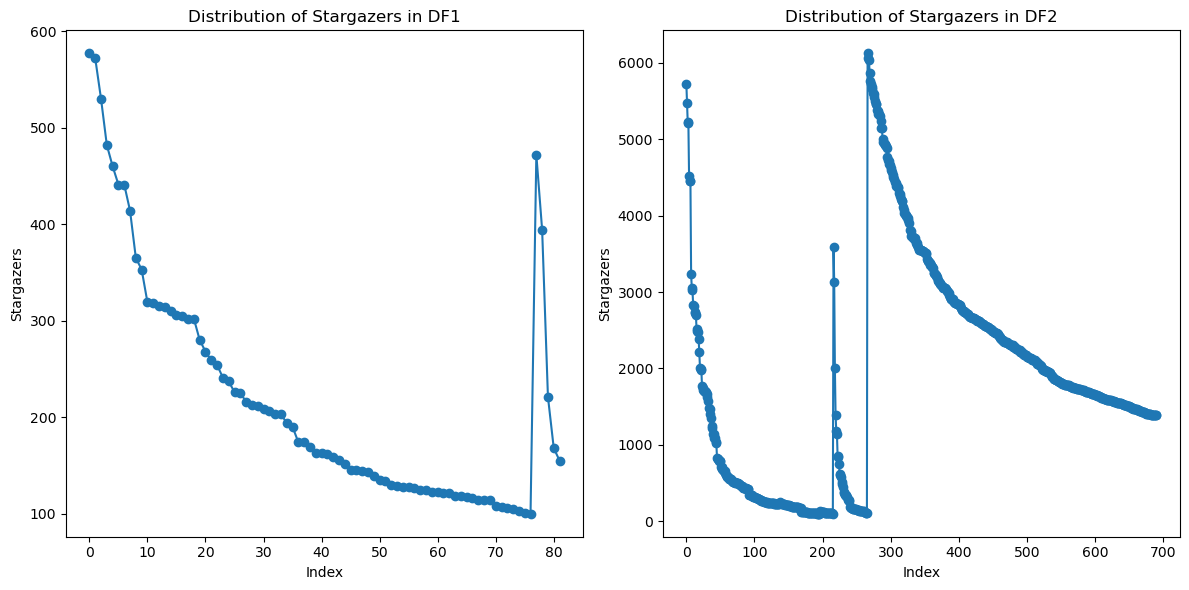

Contributors


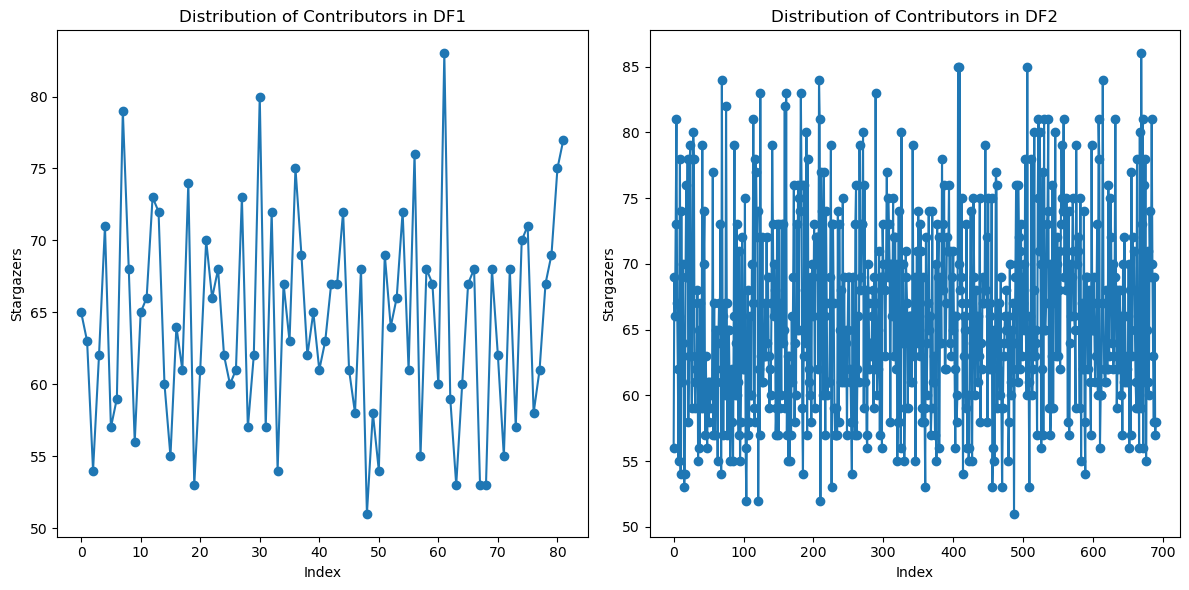

TotalIssues


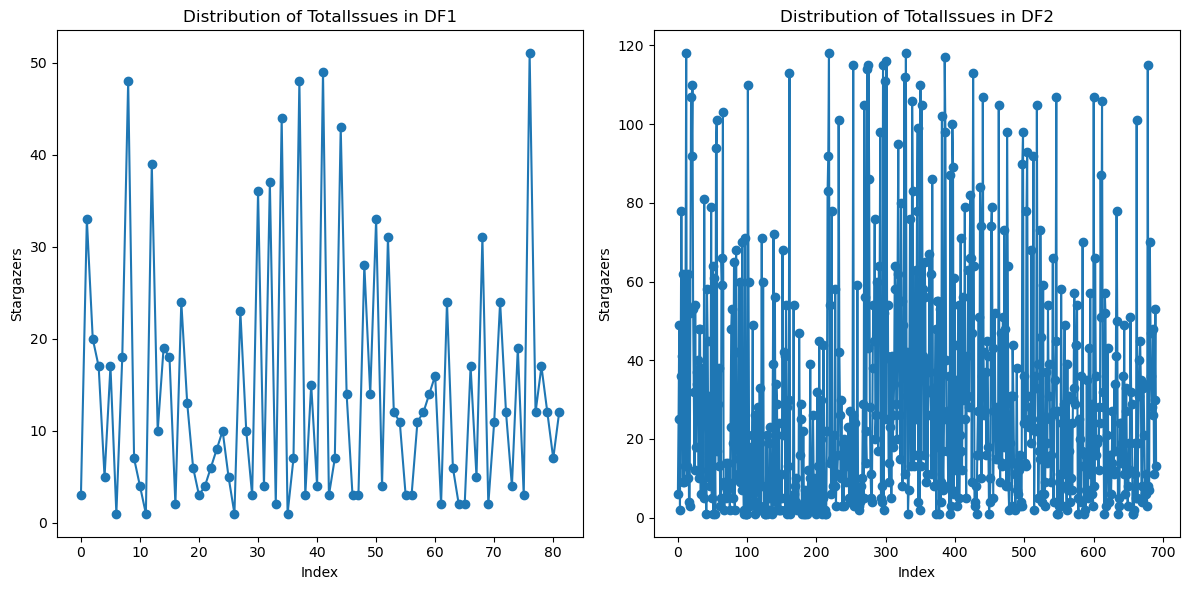

In [356]:
cols = ['Stargazers', 'Contributors', 'TotalIssues']

df = df.reset_index(drop=True)

for col in cols:
    print(col)
    plot_col(col, sim_df, df)

In [357]:
# import math

# sim_max_star = sim_df['Stargazers'].max()
# trad_mean_star= df['Stargazers'].mean()

# print("Mean ", trad_mean_star, " Max ", sim_max_star)
# while trad_mean_star > math.floor(sim_max_star):
#     trad_max_idx = df['Stargazers'].idxmax()
#     df = df.drop(index=trad_max_idx)
# #     df = df.reset_index(drop=True, inplace=True)
#     trad_mean_star= df['Stargazers'].mean()
    
#     print("Mean ", trad_mean_star, " Max ", sim_max_star)

# df.reset_index(drop=True, inplace=True)
# df

In [358]:
# import math

# sim_max_issues = sim_df['TotalIssues'].max()
# trad_mean_issues= df['TotalIssues'].mean()

# print("Mean ", trad_mean_issues, " Max ", sim_max_issues)
# while trad_mean_issues > math.floor(sim_max_issues):
#     trad_max_idx = df['TotalIssues'].idxmax()
#     df = df.drop(index=trad_max_idx)
# #     df = df.reset_index(drop=True, inplace=True)
#     trad_mean_issues= df['TotalIssues'].mean()
    
#     print("Mean ", trad_mean_issues, " Max ", sim_max_issues)

# df.reset_index(drop=True, inplace=True)
# df

In [359]:
# import math

# sim_max_con = sim_df['Contributors'].max()
# trad_mean_con= df['Contributors'].mean()

# print("Mean ", trad_mean_con, " Max ", sim_max_con)
# while trad_mean_con > math.floor(sim_max_con):
#     trad_max_idx = df['Contributors'].idxmax()
#     df = df.drop(index=trad_max_idx)
# #     df = df.reset_index(drop=True, inplace=True)
#     trad_mean_con= df['Contributors'].mean()
    
#     print("Mean ", trad_mean_con, " Max ", sim_max_con)

# df.reset_index(drop=True, inplace=True)
# df

In [360]:
df = df[df['Stargazers'] <= sim_df['Stargazers'].max()]
df

ID                  Name  \
61     9178484           openscoring   
62     8121696           jpetstore-6   
63     1765693                cometd   
64     3562089          bdd-security   
65    81557006  Android-SmartWebView   
..         ...                   ...   
261   27004894         SilenceEngine   
262   76278143               actlist   
263   28114816         javafxwebview   
264   16442206         borg_calendar   
265  171342580           OpenLabeler   

                                                   URL  IsFork  \
61          https://github.com/openscoring/openscoring   False   
62              https://github.com/mybatis/jpetstore-6   False   
63                    https://github.com/cometd/cometd   False   
64           https://github.com/iriusrisk/bdd-security   False   
65        https://github.com/mgks/Android-SmartWebView   False   
..                                                 ...     ...   
261  https://github.com/sriharshachilakapati/Silenc...   False   
262                 https://github.com/actlist/actlist   False   
263            https://github.com/lipido/javafxwebview   False   
264        https://github.com/mikeberger/borg_calendar   False   
265             https://github.com/kinhong/OpenLabeler   False   

                                               Commits  \
61   https://api.github.com/repos/openscoring/opens...   
62   https://api.github.com/repos/mybatis/jpetstore...   
63   https://api.github.com/repos/cometd/cometd/com...   
64   https://api.github.com/repos/iriusrisk/bdd-sec...   
65   https://api.github.com/repos/mgks/Android-Smar...   
..                                                 ...   
261  https://api.github.com/repos/sriharshachilakap...   
262  https://api.github.com/repos/actlist/actlist/c...   
263  https://api.github.com/repos/lipido/javafxwebv...   
264  https://api.github.com/repos/mikeberger/borg_c...   
265  https://api.github.com/repos/kinhong/OpenLabel...   

                                              Branches  \
61   https://api.github.com/repos/openscoring/opens...   
62   https://api.github.com/repos/mybatis/jpetstore...   
63   https://api.github.com/repos/cometd/cometd/bra...   
64   https://api.github.com/repos/iriusrisk/bdd-sec...   
65   https://api.github.com/repos/mgks/Android-Smar...   
..                                                 ...   
261  https://api.github.com/repos/sriharshachilakap...   
262  https://api.github.com/repos/actlist/actlist/b...   
263  https://api.github.com/repos/lipido/javafxwebv...   
264  https://api.github.com/repos/mikeberger/borg_c...   
265  https://api.github.com/repos/kinhong/OpenLabel...   

                                              Releases  Forks MainLanguage  \
61   https://api.github.com/repos/openscoring/opens...    173         Java   
62   https://api.github.com/repos/mybatis/jpetstore...   1274         Java   
63   https://api.github.com/repos/cometd/cometd/rel...    207         Java   
64   https://api.github.com/repos/iriusrisk/bdd-sec...    177         Java   
65   https://api.github.com/repos/mgks/Android-Smar...    276         Java   
..                                                 ...    ...          ...   
261  https://api.github.com/repos/sriharshachilakap...     21         Java   
262  https://api.github.com/repos/actlist/actlist/r...     21         Java   
263  https://api.github.com/repos/lipido/javafxwebv...     28         Java   
264  https://api.github.com/repos/mikeberger/borg_c...     38         Java   
265  https://api.github.com/repos/kinhong/OpenLabel...     11         Java   

    DefaultBranch  ...                 UpdatedAt TotalIssues  OpenIssues  \
61         master  ... 2024-05-16 13:13:53+00:00           3           3   
62         master  ... 2024-05-26 21:18:37+00:00           5           5   
63          8.0.x  ... 2024-05-21 14:39:58+00:00          66          66   
64         master  ... 2024-05-07 08:59:31+00:00          59          59   
65         master  ... 2024

Stats for  Simulation
---------------------------------
Minimum for  Simulation  in column  Stargazers  --->  100
Mean value for  Simulation  in column  Stargazers  --->  220.09756097560975
Standard Deviation for  Simulation  in column  Stargazers  --->  120.46664512042457

Minimum for  Simulation  in column  Contributors  --->  51
Mean value for  Simulation  in column  Contributors  --->  64.3048780487805
Standard Deviation for  Simulation  in column  Contributors  --->  7.112307233414145

Minimum for  Simulation  in column  TotalIssues  --->  1
Mean value for  Simulation  in column  TotalIssues  --->  14.24390243902439
Standard Deviation for  Simulation  in column  TotalIssues  --->  13.348658762429903

Stats for  Traditional
---------------------------------
Minimum for  Traditional  in column  Stargazers  --->  100
Mean value for  Traditional  in column  Stargazers  --->  247.159793814433
Standard Deviation for  Traditional  in column  Stargazers  --->  135.2734334404798

Minimum f

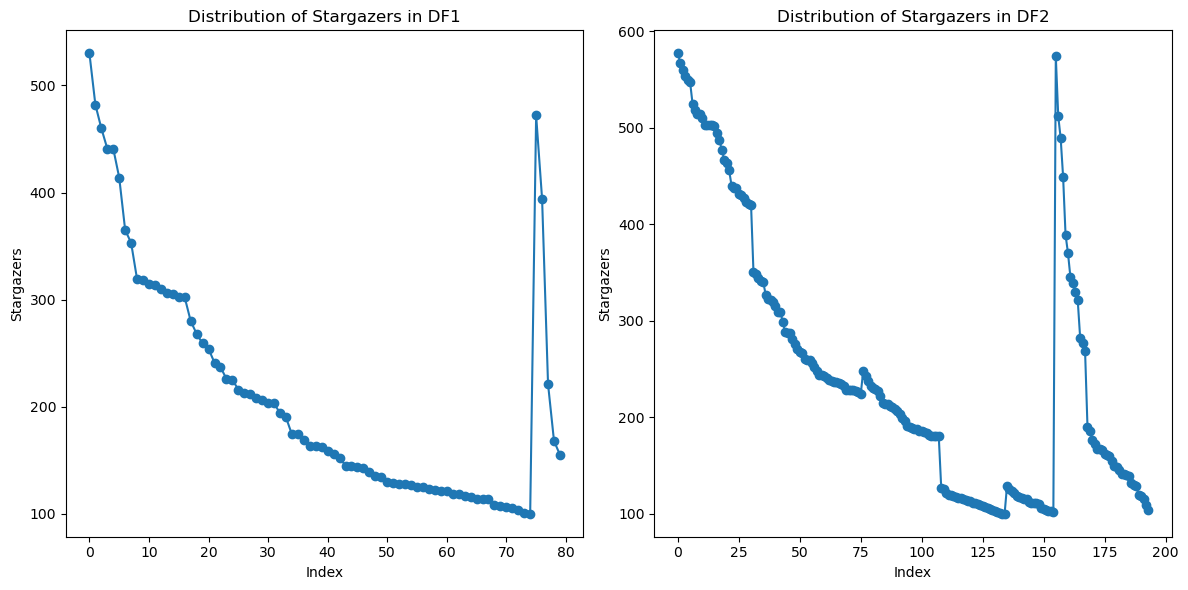

Removing simulation outliers for  Contributors
-----------------
Stats for  Simulation
---------------------------------
Minimum for  Simulation  in column  Stargazers  --->  100
Mean value for  Simulation  in column  Stargazers  --->  211.2375
Standard Deviation for  Simulation  in column  Stargazers  --->  107.79695443785016

Minimum for  Simulation  in column  Contributors  --->  51
Mean value for  Simulation  in column  Contributors  --->  64.3125
Standard Deviation for  Simulation  in column  Contributors  --->  7.19984836338212

Minimum for  Simulation  in column  TotalIssues  --->  1
Mean value for  Simulation  in column  TotalIssues  --->  14.15
Standard Deviation for  Simulation  in column  TotalIssues  --->  13.290426744012949


Number of simulation repos ------->  80
Removing traditional outliers for  Contributors
-----------------
Stats for  Traditional
---------------------------------
Minimum for  Traditional  in column  Stargazers  --->  100
Mean value for  Traditional  

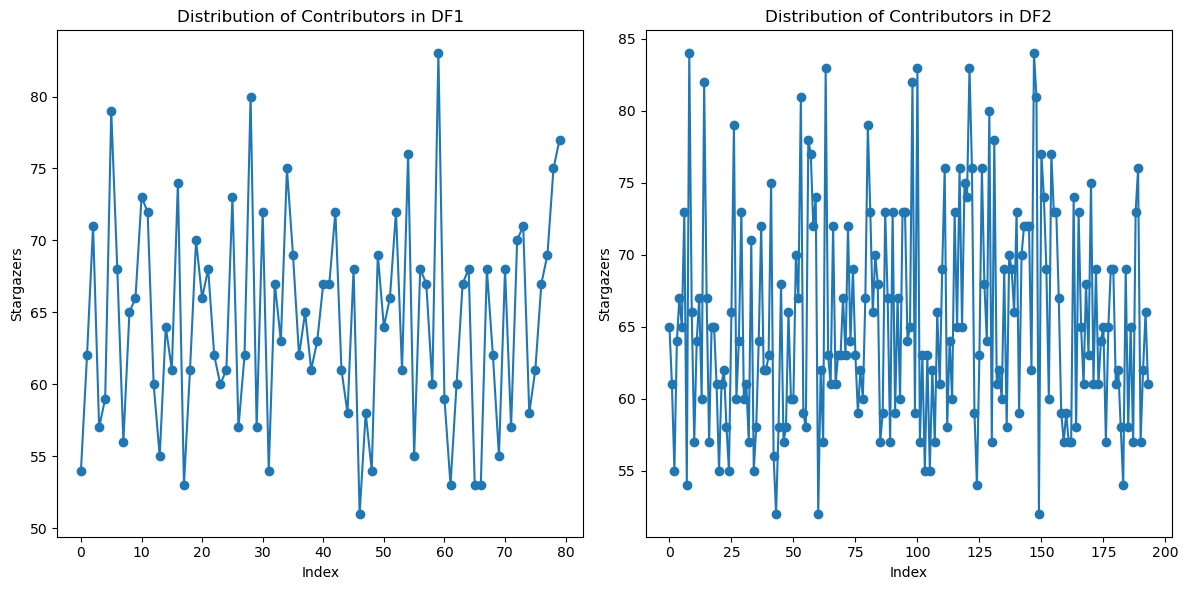

Removing simulation outliers for  TotalIssues
-----------------
Stats for  Simulation
---------------------------------
Minimum for  Simulation  in column  Stargazers  --->  101
Mean value for  Simulation  in column  Stargazers  --->  212.86486486486487
Standard Deviation for  Simulation  in column  Stargazers  --->  109.42969524158613

Minimum for  Simulation  in column  Contributors  --->  51
Mean value for  Simulation  in column  Contributors  --->  64.16216216216216
Standard Deviation for  Simulation  in column  Contributors  --->  7.355972369958288

Minimum for  Simulation  in column  TotalIssues  --->  1
Mean value for  Simulation  in column  TotalIssues  --->  11.472972972972974
Standard Deviation for  Simulation  in column  TotalIssues  --->  9.67729014058238


Number of simulation repos ------->  74
Removing traditional outliers for  TotalIssues
-----------------
Stats for  Traditional
---------------------------------
Minimum for  Traditional  in column  Stargazers  --->  100

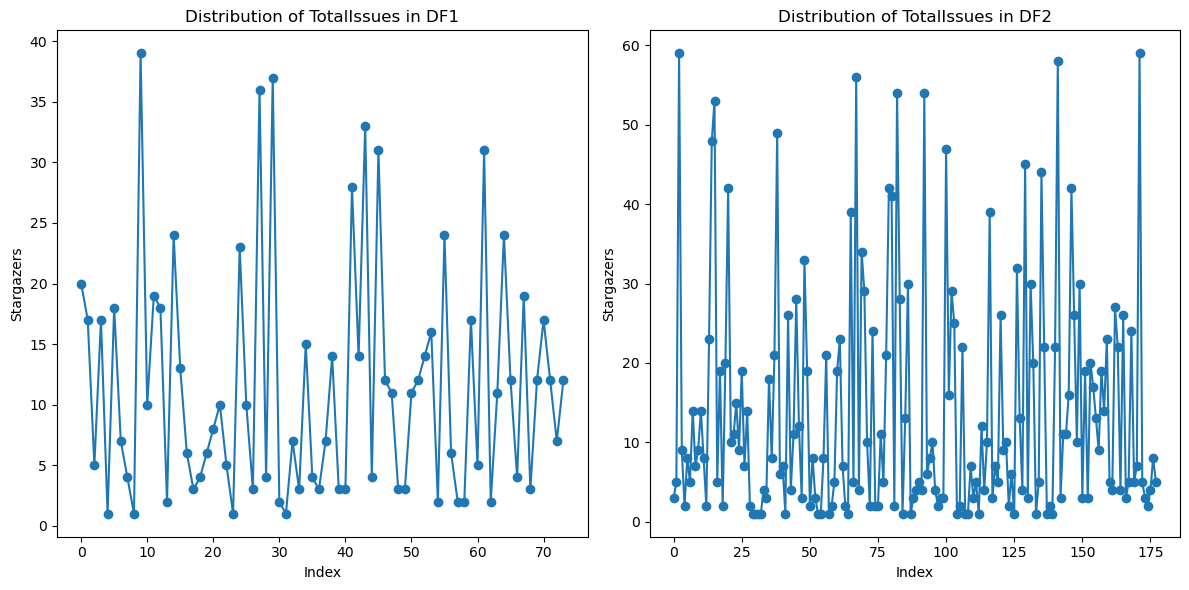

In [361]:

cols = ['Stargazers', 'Contributors', 'TotalIssues']

show_stats(sim_df, cols, "Simulation")
show_stats(df, cols, "Traditional")

for col in cols:
    print("Removing simulation outliers for ", col)
    print("-----------------")
    sim_df = remove_outliers(sim_df, col)
    show_stats(sim_df, cols, "Simulation")

    print()
    print("Number of simulation repos -------> ", len(sim_df))

    print("Removing traditional outliers for ", col)
    print("-----------------")
    df = remove_outliers(df, col)
    show_stats(df, cols, "Traditional")

    print()
    print("Number of Traditional repos -------> ", len(df))
        
    plot_col(col, sim_df, df)

Stargazers


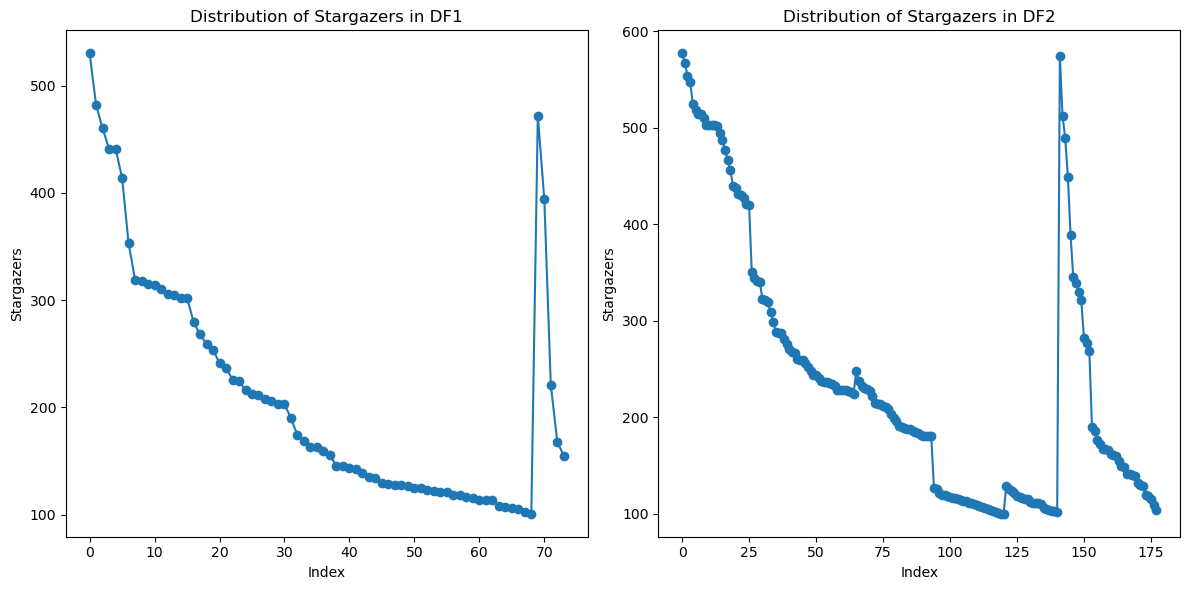

Contributors


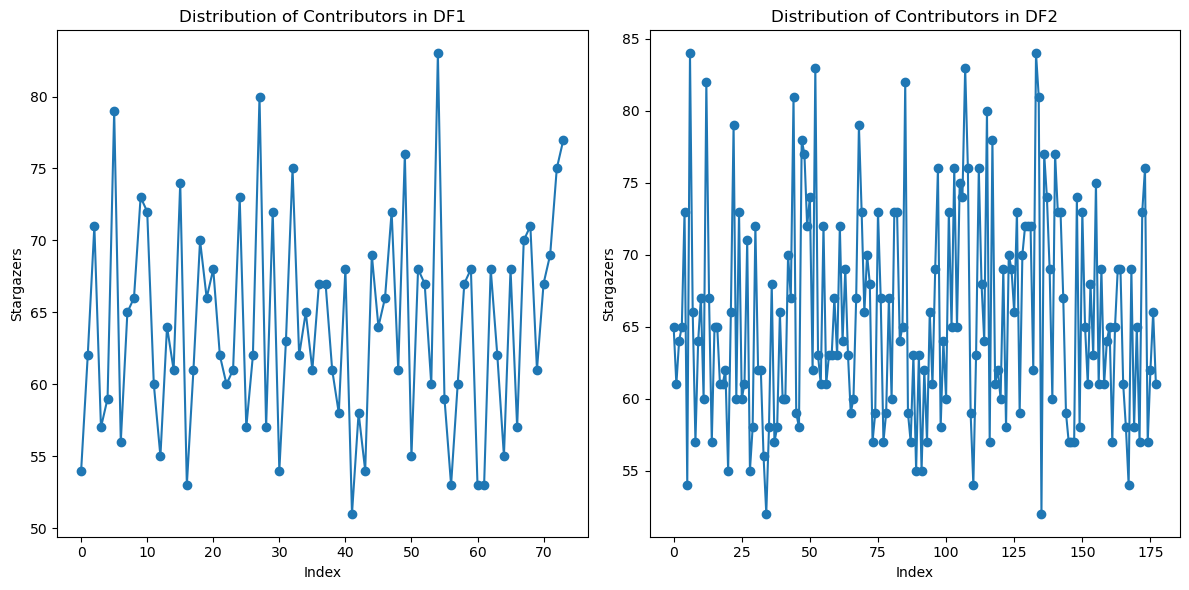

TotalIssues


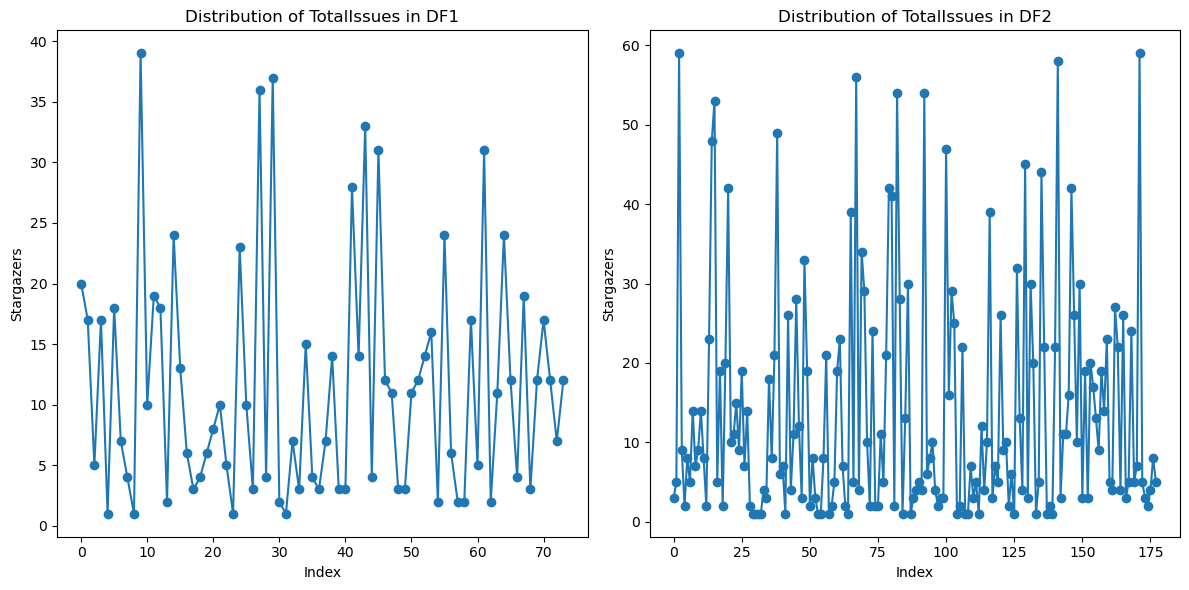

In [362]:
cols = ['Stargazers', 'Contributors', 'TotalIssues']

df = df.reset_index(drop=True)

for col in cols:
    print(col)
    plot_col(col, sim_df, df)

In [363]:
df.to_csv('data/trad_df.csv')
df

ID                 Name  \
0      9178484          openscoring   
1      8121696          jpetstore-6   
2      3562089         bdd-security   
3    158332163           DimpleBlog   
4     97118672  spring-web-services   
..         ...                  ...   
173   27004894        SilenceEngine   
174   76278143              actlist   
175   28114816        javafxwebview   
176   16442206        borg_calendar   
177  171342580          OpenLabeler   

                                                   URL  IsFork  \
0           https://github.com/openscoring/openscoring   False   
1               https://github.com/mybatis/jpetstore-6   False   
2            https://github.com/iriusrisk/bdd-security   False   
3           https://github.com/martin-chips/DimpleBlog   False   
4    https://github.com/in28minutes/spring-web-serv...   False   
..                                                 ...     ...   
173  https://github.com/sriharshachilakapati/Silenc...   False   
174                 https://github.com/actlist/actlist   False   
175            https://github.com/lipido/javafxwebview   False   
176        https://github.com/mikeberger/borg_calendar   False   
177             https://github.com/kinhong/OpenLabeler   False   

                                               Commits  \
0    https://api.github.com/repos/openscoring/opens...   
1    https://api.github.com/repos/mybatis/jpetstore...   
2    https://api.github.com/repos/iriusrisk/bdd-sec...   
3    https://api.github.com/repos/martin-chips/Dimp...   
4    https://api.github.com/repos/in28minutes/sprin...   
..                                                 ...   
173  https://api.github.com/repos/sriharshachilakap...   
174  https://api.github.com/repos/actlist/actlist/c...   
175  https://api.github.com/repos/lipido/javafxwebv...   
176  https://api.github.com/repos/mikeberger/borg_c...   
177  https://api.github.com/repos/kinhong/OpenLabel...   

                                              Branches  \
0    https://api.github.com/repos/openscoring/opens...   
1    https://api.github.com/repos/mybatis/jpetstore...   
2    https://api.github.com/repos/iriusrisk/bdd-sec...   
3    https://api.github.com/repos/martin-chips/Dimp...   
4    https://api.github.com/repos/in28minutes/sprin...   
..                                                 ...   
173  https://api.github.com/repos/sriharshachilakap...   
174  https://api.github.com/repos/actlist/actlist/b...   
175  https://api.github.com/repos/lipido/javafxwebv...   
176  https://api.github.com/repos/mikeberger/borg_c...   
177  https://api.github.com/repos/kinhong/OpenLabel...   

                                              Releases  Forks MainLanguage  \
0    https://api.github.com/repos/openscoring/opens...    173         Java   
1    https://api.github.com/repos/mybatis/jpetstore...   1274         Java   
2    https://api.github.com/repos/iriusrisk/bdd-sec...    177         Java   
3    https://api.github.com/repos/martin-chips/Dimp...    162         Java   
4    https://api.github.com/repos/in28minutes/sprin...    752         Java   
..                                                 ...    ...          ...   
173  https://api.github.com/repos/sriharshachilakap...     21         Java   
174  https://api.github.com/repos/actlist/actlist/r...     21         Java   
175  https://api.github.com/repos/lipido/javafxwebv...     28         Java   
176  https://api.github.com/repos/mikeberger/borg_c...     38         Java   
177  https://api.github.com/repos/kinhong/OpenLabel...     11         Java   

      DefaultBranch  ...                 UpdatedAt TotalIssues  OpenIssues  \
0            master  ... 2024-05-16 13:13:53+00:00           3           3   
1            master  ... 2024-05-26 21:18:37+00:00           5           5   
2            master  ... 2024-05-07 08:59:31+00:00          59          59   
3    DimpleBlogV3.1  ... 2024-05-07 06:17:41+00:00           9           9   
4            master  ... 2024

In [365]:
sim_df.to_csv('data/sim_df.csv')
sim_df

Unnamed: 0         ID                Name  \
0         47.0   44735189                 let   
1         51.0  616182479             jtokkit   
2         55.0  619103288     bibliothecarius   
3         56.0  708783006             openspg   
4         57.0   22344826          ButtonMenu   
..         ...        ...                 ...   
69         NaN    8832601         finmath-lib   
70         NaN   32472801        cloudsimplus   
71         NaN   56945187   Evolving-Protozoa   
72         NaN  163447483         PureEdgeSim   
73         NaN   41836729  Robot-Overlord-App   

                                                  URL  IsFork  \
0                     https://github.com/canelmas/let   False   
1             https://github.com/knuddelsgmbh/jtokkit   False   
2    https://github.com/coderabbit214/bibliothecarius   False   
3                  https://github.com/OpenSPG/openspg   False   
4                https://github.com/tuenti/ButtonMenu   False   
..                                                ...     ...   
69             https://github.com/finmath/finmath-lib   False   
70       https://github.com/cloudsimplus/cloudsimplus   False   
71     https://github.com/DylanCope/Evolving-Protozoa   False   
72  https://github.com/CharafeddineMechalikh/PureE...   False   
73  https://github.com/MarginallyClever/Robot-Over...   False   

                                              Commits  \
0   https://api.github.com/repos/canelmas/let/comm...   
1   https://api.github.com/repos/knuddelsgmbh/jtok...   
2   https://api.github.com/repos/coderabbit214/bib...   
3   https://api.github.com/repos/OpenSPG/openspg/c...   
4   https://api.github.com/repos/tuenti/ButtonMenu...   
..                                                ...   
69  https://api.github.com/repos/finmath/finmath-l...   
70  https://api.github.com/repos/cloudsimplus/clou...   
71  https://api.github.com/repos/DylanCope/Evolvin...   
72  https://api.github.com/repos/CharafeddineMecha...   
73  https://api.github.com/repos/MarginallyClever/...   

                                             Branches  \
0   https://api.github.com/repos/canelmas/let/bran...   
1   https://api.github.com/repos/knuddelsgmbh/jtok...   
2   https://api.github.com/repos/coderabbit214/bib...   
3   https://api.github.com/repos/OpenSPG/openspg/b...   
4   https://api.github.com/repos/tuenti/ButtonMenu...   
..                                                ...   
69  https://api.github.com/repos/finmath/finmath-l...   
70  https://api.github.com/repos/cloudsimplus/clou...   
71  https://api.github.com/repos/DylanCope/Evolvin...   
72  https://api.github.com/repos/CharafeddineMecha...   
73  https://api.github.com/repos/MarginallyClever/...   

                                             Releases  Forks MainLanguage  \
0   https://api.github.com/repos/canelmas/let/rele...     40         Java   
1   https://api.github.com/repos/knuddelsgmbh/jtok...     35         Java   
2   https://api.github.com/repos/coderabbit214/bib...     77         Java   
3   https://api.github.com/repos/OpenSPG/openspg/r...     59         Java   
4   https://api.github.com/repos/tuenti/ButtonMenu...     84         Java   
..                                                ...    ...          ...   
69  https://api.github.com/repos/finmath/finmath-l...    166         Java   
70  https://api.github.com/repos/cloudsimplus/clou...    192         Java   
71  https://api.github.com/repos/DylanCope/Evolvin...     21         Java   
72  https://api.github.com/repos/CharafeddineMecha...     73         Java   
73  https://api.github.com/repos/MarginallyClever/...     48         Java   

    ...              PushedAt                 UpdatedAt TotalIssues  \
0   ...  2018-02-11T11:35:10Z 2024-05-18 19:15:24+00:00          20   
1   ...  2024-05-19T02:27:09Z 2024-05-24 09:32:38+00:00          17   
2   ...  2023-06-16T11:20:57Z 2024-04-19 12:45:36+00:00           5   
3   ...  2024-05-24T15:18:13Z 2024-05-24 06:43:16+00:00

In [369]:
import os

prev_repos = []
for repo in os.listdir('data/repos/traditional'):
    prev_repos.append(repo)

prev_repos

['activej',
 'alchemy',
 'android-http-server',
 'Android-Web-Server',
 'AndroidWebAutoLaunch',
 'AnywhereAlertConfirm',
 'APKMirror',
 'app',
 'Arkhota',
 'automotion-java',
 'avaje-jex',
 'bdd-security',
 'botwall4j',
 'boyka-framework',
 'bring',
 'BUbiNG',
 'buildvu-microservice-example',
 'capacitor-firebase',
 'CatLogging',
 'chaos-server',
 'cloudterm',
 'dataviewer',
 'dicom-web-pacs',
 'DiscoveryDesktop',
 'DiskMirror',
 'dotenv',
 'e-commerce',
 'espresso',
 'fili',
 'final-framework',
 'firefly',
 'Gamp-Forest-site',
 'gcn-intellij-tooling',
 'go-fastdfs-web',
 'gwt-ol',
 'Hacktoberfest-2022',
 'hasor',
 'HtmlNative',
 'java-reverse-tcp',
 'java-web-exercises',
 'javafx-dataviewer-wrapper',
 'JCrawl',
 'Jerrydog',
 'JumpGo-for-Android',
 'keywords.csv',
 'keyword_add.csv',
 'keyword_application.csv',
 'keyword_get.csv',
 'keyword_id.csv',
 'keyword_server.csv',
 'keyword_spring.csv',
 'keyword_string.csv',
 'keyword_use.csv',
 'keyword_using.csv',
 'keyword_web.csv',
 'Learn

In [372]:
new_repos = df['Name'].tolist()
new_repos

['openscoring',
 'jpetstore-6',
 'bdd-security',
 'DimpleBlog',
 'spring-web-services',
 'para',
 'gs-messaging-stomp-websocket',
 'chromium_webview',
 'gargl',
 'go-fastdfs-web',
 'LuckyFrameWeb',
 'DeepfakeHTTP',
 'Jwt-Spring-Security-JPA',
 'StudentManagement',
 'nutzboot',
 'WeBASE',
 'Cerberus',
 'WS-Attacker',
 'redis-admin',
 'seatunnel-web',
 'ache',
 'Kafka-Sprout',
 'data-integration',
 'AgentWebX5',
 'UberEatsClone',
 'zdh_web',
 'stubby4j',
 'Android-PWA-Wrapper',
 'cim',
 'CronHub',
 'android-http-server',
 'webapp-runner',
 'WebStack-Guns',
 'redant',
 'Tpay',
 'alchemy',
 'Breakpoint-http',
 'riptide',
 'dhis2-core',
 'ngWebDriver',
 'jpasskit',
 'psychoPATH',
 'dubbo-postman',
 'fast-framework',
 'apache-shiro-tutorial-webapp',
 'hmdm-server',
 'mytwitter',
 'BurpSuite-Team-Extension',
 'weblogic-kubernetes-operator',
 'JavaVulnerableLab',
 'WebLogicPasswordDecryptor',
 'FastWebView',
 'unipiazza-android-twostepslogin',
 'kubehelper',
 'moti-blog',
 'WhatsApp-Bulk-Sende

In [382]:
import shutil

unique_values = [x for x in prev_repos if x not in new_repos]

repos_path = os.path.join('data', 'repos', 'traditional')

folders_to_delete = []
for repo in unique_values:
    repo_folder_path = os.path.join(repos_path, repo)
    
    if os.path.isdir(repo_folder_path):
        folders_to_delete.append(repo_folder_path)

with open('folders_to_delete.txt', 'w') as file:
    for folder_path in folders_to_delete:
        linux_path = folder_path.replace('\\', '/')
        file.write(f"{linux_path}\n")

print("List exported to 'folders_to_delete.txt'")

List exported to 'folders_to_delete.txt'


In [383]:
folders_to_delete

['data\\repos\\traditional\\Android-Web-Server',
 'data\\repos\\traditional\\AndroidWebAutoLaunch',
 'data\\repos\\traditional\\AnywhereAlertConfirm',
 'data\\repos\\traditional\\app',
 'data\\repos\\traditional\\Arkhota',
 'data\\repos\\traditional\\automotion-java',
 'data\\repos\\traditional\\avaje-jex',
 'data\\repos\\traditional\\botwall4j',
 'data\\repos\\traditional\\bring',
 'data\\repos\\traditional\\BUbiNG',
 'data\\repos\\traditional\\buildvu-microservice-example',
 'data\\repos\\traditional\\capacitor-firebase',
 'data\\repos\\traditional\\CatLogging',
 'data\\repos\\traditional\\chaos-server',
 'data\\repos\\traditional\\cloudterm',
 'data\\repos\\traditional\\dataviewer',
 'data\\repos\\traditional\\dicom-web-pacs',
 'data\\repos\\traditional\\DiscoveryDesktop',
 'data\\repos\\traditional\\DiskMirror',
 'data\\repos\\traditional\\dotenv',
 'data\\repos\\traditional\\e-commerce',
 'data\\repos\\traditional\\espresso',
 'data\\repos\\traditional\\fili',
 'data\\repos\\tradi

## break

In [31]:
import pandas as pd
import os

cat_path = os.path.join('data', 'categories', 'simulation')


for cat_folder in os.listdir(cat_path):
    cat_folder_path = os.path.join(cat_path, cat_folder)
    if os.path.isdir(cat_folder_path):
        keywords = pd.read_csv(os.path.join(cat_folder_path, "keywords.csv"))
        top_10 = keywords['Keyword'].to_list()[:10]
        print('In the category of ', cat_folder)
        print(cat_folder, "---->", top_10)
        
        for keyword in top_10:
            csv_path = os.path.join(cat_folder_path, 'keyword_'+keyword+'.csv')
            
            if os.path.exists(csv_path):
                print("CSV already written for keyword ", keyword)
                continue
                
            query = "language:java -topic:simulation"
            query += " " + keyword
            search_and_save_repos(query, csv_path)


In the category of  Aerospce & Transportation
Aerospce & Transportation ----> ['java', 'simulation', 'systems', 'mission', 'version', 'mars', 'frazzoli', 'rothfeld', 'urban', 'vehicle']
CSV already written for keyword  java
CSV already written for keyword  simulation
CSV already written for keyword  systems
CSV already written for keyword  mission
CSV already written for keyword  version
CSV already written for keyword  mars
CSV already written for keyword  frazzoli
CSV already written for keyword  rothfeld
CSV already written for keyword  urban
CSV already written for keyword  vehicle
In the category of  Computation & Networking
Computation & Networking ----> ['cloudsim', 'simulation', 'query', 'project', 'vm', 'plus', 'misim', 'data', 'file', 'information']
CSV already written for keyword  cloudsim
CSV already written for keyword  simulation
Searching with the query  language:java -topic:simulation query
{'next': {'url': 'https://api.github.com/search/repositories?q=language%3Ajava+-

KeyboardInterrupt: 

In [16]:
import os
import glob

# Specify the directory path
cat_path = os.path.join('data', 'categories', 'simulation')

# Use glob to find all files that match the pattern 'keyword_*.csv'
csv_files = glob.glob(os.path.join(cat_path, 'key*.csv'))

for file in csv_files:
    print(file)

data\categories\simulation\keywords.csv


In [56]:
cat_path = os.path.join('data', 'categories', 'simulation')

for cat_folder in os.listdir(cat_path):
    cat_folder_path = os.path.join(cat_path, cat_folder)
    if os.path.isdir(cat_folder_path):
        keywords = pd.read_csv(os.path.join(cat_folder_path, "keywords.csv"))
        keywords = keywords.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

        print(keywords['Keyword'].tolist()[:10])

['java', 'simulation', 'mars', 'systems', 'version', 'would', 'mobility', 'air', 'project', 'urban']
['cloudsim', 'simulation', 'query', 'project', 'data', 'vm', 'plus', 'file', 'parameter', 'example']
['simulation', 'project', 'cellular', 'time', 'projects', 'eclipse', 'install', 'file', 'gips', 'cells']
['java', 'model', 'version', 'finmath', 'code', 'lib', 'file', 'maven', 'build', 'market']
['c', 'qspcc', 'matlab', 'code', 'file', 'matrix', 'function', 'make', 'use', 'using']


In [1]:
import pandas as pd
from transformers import pipeline

ner_model = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english")


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
def summarize_text(text, max_length=130, min_length=30):
    summarizer = pipeline('summarization', model='facebook/bart-large-cnn')
    try:
        summary = summarizer(text, max_length=max_length, min_length=min_length, do_sample=False)
    except Exception as e:
        print("Cannot Summarize")
        return "No summary"
    
    return summary[0]['summary_text']

In [10]:
def summarize_helper(readme_file):
    with open(readme_file, "r", encoding='utf-8') as file:
        readme_content = file.read()

    plain_text_content = readme_content
    plain_text_content = remove_excessive_newlines(readme_content)
    plain_text_content = unmark(plain_text_content)
    plain_text_content = remove_html_tags(plain_text_content)
    
    summary = summarize_text(plain_text_content)
    
    return {'original_text': plain_text_content, 'summary': summary}

In [7]:
import pandas as pd

def tag_readme(readme_file):
    with open(readme_file, "r", encoding='utf-8') as file:
        readme_content = file.read()
    
    plain_text_content = readme_content
    plain_text_content = remove_excessive_newlines(readme_content)
    plain_text_content = unmark(plain_text_content)
    plain_text_content = remove_html_tags(plain_text_content)
    
    ner_results = ner_model(plain_text_content)

    entities = {}
    for result in ner_results:
        entity = result['entity']
        word = result['word']
        if entity not in entities:
            entities[entity] = {}
        if word not in entities[entity]:
            entities[entity][word] = 0
        entities[entity][word] += 1

    entity_totals = {entity: sum(words.values()) for entity, words in entities.items()}

    detailed_data = []
    for entity, words in entities.items():
        for word, count in words.items():
            detailed_data.append({'Entity': entity, 'Word': word, 'Word Count': count, 'Total Count': entity_totals[entity]})

  
    detailed_df = pd.DataFrame(detailed_data)

    total_data = [{'Entity': entity, 'Total Count': total_count} for entity, total_count in entity_totals.items()]

    total_df = pd.DataFrame(total_data)
    return [detailed_df, total_df]

In [8]:
import os
import shutil
import re

repos_path = os.path.join('data', 'repos', 'simulation')
analyzed_repos_path = os.path.join('data', 'analyzed_repos', 'simulation')
dj_file_path = os.path.join('apps', 'DJ', 'DesigniteJava.jar')


count = 0
for folder in os.listdir(repos_path):
    folder_path = os.path.join(repos_path, folder)
    readme_file = os.path.join(folder_path, 'README.md')
    
    if os.path.exists(readme_file):
        dfs = tag_readme(readme_file)
        
        break
        df = dfs[0]
        ndf = dfs[1]
        df.to_csv(os.path.join(folder_path, "entities.csv"), index=False)
        ndf.to_csv(os.path.join(folder_path, "total_entities.csv"), index=False)
        print("entities written to ", folder_path)
    else:
        try:
            shutil.rmtree(folder_path)
            count +=1
            print(f"Folder '{folder_path}' has been deleted")
        except OSError as e:
            print(f"Error: {e}. Folder '{folder_path}' is not empty or cannot be deleted")

print("Total folders deleted", count)

Total folders deleted 0


In [11]:
import os
import shutil 

repos_path = os.path.join('data', 'repos', 'simulation')

summaries = []
for folder in os.listdir(repos_path):
    folder_path = os.path.join(repos_path, folder)
    readme_file = os.path.join(folder_path, 'README.md')
    
    if os.path.exists(readme_file):
        summary = summarize_helper(readme_file)
        summaries.append(summary)
        print("The readme is summarized for ", folder_path)
    else:
        try:
            shutil.rmtree(folder_path)
            count +=1
            print(f"Folder '{folder_path}' has been deleted")
        except OSError as e:
            print(f"Error: {e}. Folder '{folder_path}' is not empty or cannot be deleted")
    

print("Total folders deleted", count)
df = pd.df = pd.DataFrame(summaries)
df.to_csv('summaries_sim.csv')
df

The readme is summarized for  data\repos\simulation\aerie


Token indices sequence length is longer than the specified maximum sequence length for this model (2166 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\simulation\amodeus


Token indices sequence length is longer than the specified maximum sequence length for this model (1200 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\simulation\cas


Token indices sequence length is longer than the specified maximum sequence length for this model (4129 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\simulation\cloudsimplus


Token indices sequence length is longer than the specified maximum sequence length for this model (3581 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\simulation\cloudsimsdn


Token indices sequence length is longer than the specified maximum sequence length for this model (3923 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\simulation\computer_kurzweil
The readme is summarized for  data\repos\simulation\eqasim-java


Token indices sequence length is longer than the specified maximum sequence length for this model (2175 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\simulation\Evolving-Protozoa


Token indices sequence length is longer than the specified maximum sequence length for this model (2540 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\simulation\finmath-lib
The readme is summarized for  data\repos\simulation\gama


Token indices sequence length is longer than the specified maximum sequence length for this model (1276 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\simulation\gips


Token indices sequence length is longer than the specified maximum sequence length for this model (1903 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\simulation\iflye


Token indices sequence length is longer than the specified maximum sequence length for this model (5197 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\simulation\mars-sim


Token indices sequence length is longer than the specified maximum sequence length for this model (2392 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\simulation\MATSim-UAM
The readme is summarized for  data\repos\simulation\microtrafficsim


Token indices sequence length is longer than the specified maximum sequence length for this model (4882 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\simulation\Mirage
The readme is summarized for  data\repos\simulation\MiSim


Token indices sequence length is longer than the specified maximum sequence length for this model (6217 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\simulation\multiphysics
The readme is summarized for  data\repos\simulation\PowerSystemDataModel


Token indices sequence length is longer than the specified maximum sequence length for this model (12915 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\simulation\QSPcc


Token indices sequence length is longer than the specified maximum sequence length for this model (1372 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\simulation\react-native-ble-peripheral
The readme is summarized for  data\repos\simulation\Robot-Overlord-App
The readme is summarized for  data\repos\simulation\SASS
The readme is summarized for  data\repos\simulation\ShapeOfThingsThatWere


Token indices sequence length is longer than the specified maximum sequence length for this model (2965 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\simulation\simulation-construction-set-2


Token indices sequence length is longer than the specified maximum sequence length for this model (1299 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\simulation\synthea


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


The readme is summarized for  data\repos\simulation\varsim
The readme is summarized for  data\repos\simulation\workcraft
Total folders deleted 0


original_text  \
0   \n\n\n\n\nAerie is a software framework for mo...   
1   amodeus.amodeus \nAutonomous mobility-on-deman...   
2   CAS - Cellular Automata Simulator\n\n\n\n\n\nT...   
3   \n1. Overview\n        \nCloudSim Plus is a mo...   
4   CloudSimSDN\nCloudSimSDN: SDN extension of Clo...   
5   Computer Kurzweil\n \n\n\nComputer Science Inf...   
6   eqasim-java\n\nThe eqasim package is a collect...   
7   Evolving-Protozoa\nCheck the simulation out on...   
8   About finmath lib\n\nMathematical Finance Libr...   
9   GAMA 2024-06 - Next release of GAMA\nDue to se...   
10  GIPS\nGIPS is an open-source framework for Gra...   
11  iflye\nifyle is an open-source framework for I...   
12  mars-sim\nTable of Contents\n\nIntroduction  \...   
13  UAM-Extension\nThis extension enhances MATSim ...   
14  Microscopic Traffic Simulation\nwith OpenStree...   
15  Mirage\nMirage is a query-aware database gener...   
16  \n\nMiSim - Microservice Resilience Simulator\...   
17  Under the hood...\n\nNumerical Algorithms for ...   
18  PowerSystemDataModel\n\n\n\n\n\n\nProvides an ...   
19  QSPcc: Breaking through model simulation time ...   
20  React Native BLE Peripheral\nNative BLE Periph...   
21  Robot Overlord\n\n\n\nRobot Overlord\n\nRobot ...   
22  Super-resolution Acquisition Simulation Softwa...   
23  Shape Of Things That Were\n===================...   
24  Install standalone application on Ubuntu 22.04...   
25  SyntheaTM Patient Generator  \nSyntheaTM is a ...   
26  VarSim: A high-fidelity simulation validation ...   
27  Workcraft is a cross-platform toolset to captu...   

                                              summary  
0   Aerie is a software framework for modeling spa...  
1                                          No summary  
2                                          No summary  
3                                          No summary  
4                                          No summary  
5                                          No summary  
6   The eqasim package is a collection of ready-to...  
7                                          No summary  
8                                          No summary  
9   GAMA 2024-06 - Next release of GAMA. Eclipse f...  
10                                         No summary  
11                                         No summary  
12                                         No summary  
13                                         No summary  
14  A new release containing the multilane logic h...  
15                                         No summary  
16  MiSim allows the simulation of microservice ar...  
17                                         No summary  
18  PowerSystemDataModel is a data model capable o...  
19                                         No summary  
20                                         No summary  
21  Robot Overlord is 3D control software for robo...  
22  SASS is a super-resolution acquisition simulat...  
23  Shape Of Things That Were is an open source st...  
24                                         No summary  
25                                         No summary  
26   VarSim is a high-fidelity simulation validati...  
27  Workcraft is a cross-platform toolset to captu...

In [12]:
import os
import shutil 

repos_path = os.path.join('data', 'repos', 'traditional')

summaries = []
for folder in os.listdir(repos_path):
    folder_path = os.path.join(repos_path, folder)
    readme_file = os.path.join(folder_path, 'README.md')
    
    if os.path.exists(readme_file):
        summary = summarize_helper(readme_file)
        summaries.append(summary)
        print("The readme is summarized for ", folder_path)
    else:
        try:
            shutil.rmtree(folder_path)
            count +=1
            print(f"Folder '{folder_path}' has been deleted")
        except OSError as e:
            print(f"Error: {e}. Folder '{folder_path}' is not empty or cannot be deleted")
    

print("Total folders deleted", count)
df = pd.df = pd.DataFrame(summaries)
df.to_csv('summaries_trad.csv')
df

Token indices sequence length is longer than the specified maximum sequence length for this model (5212 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\activej
The readme is summarized for  data\repos\traditional\alchemy


Token indices sequence length is longer than the specified maximum sequence length for this model (3467 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\android-http-server
The readme is summarized for  data\repos\traditional\Android-Web-Server


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


The readme is summarized for  data\repos\traditional\AndroidWebAutoLaunch
The readme is summarized for  data\repos\traditional\AnywhereAlertConfirm
The readme is summarized for  data\repos\traditional\APKMirror


Token indices sequence length is longer than the specified maximum sequence length for this model (1149 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\app


Token indices sequence length is longer than the specified maximum sequence length for this model (1110 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\Arkhota


Token indices sequence length is longer than the specified maximum sequence length for this model (4248 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\automotion-java
The readme is summarized for  data\repos\traditional\avaje-jex
The readme is summarized for  data\repos\traditional\botwall4j


Token indices sequence length is longer than the specified maximum sequence length for this model (7844 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\boyka-framework


Token indices sequence length is longer than the specified maximum sequence length for this model (1287 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\bring


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


The readme is summarized for  data\repos\traditional\BUbiNG
The readme is summarized for  data\repos\traditional\buildvu-microservice-example


Token indices sequence length is longer than the specified maximum sequence length for this model (1420 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\capacitor-firebase
The readme is summarized for  data\repos\traditional\CatLogging


Token indices sequence length is longer than the specified maximum sequence length for this model (2518 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\chaos-server
Error: [WinError 5] Access is denied: 'data\\repos\\traditional\\cloudterm\\.git\\objects\\pack\\pack-50b9150ea45f56dcb0840c7a1a413d65fc4f6f28.idx'. Folder 'data\repos\traditional\cloudterm' is not empty or cannot be deleted


Token indices sequence length is longer than the specified maximum sequence length for this model (3902 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\dataviewer
The readme is summarized for  data\repos\traditional\dicom-web-pacs


Token indices sequence length is longer than the specified maximum sequence length for this model (2075 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\DiscoveryDesktop


Token indices sequence length is longer than the specified maximum sequence length for this model (49197 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\DiskMirror
The readme is summarized for  data\repos\traditional\dotenv


Token indices sequence length is longer than the specified maximum sequence length for this model (3337 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\e-commerce
The readme is summarized for  data\repos\traditional\espresso


Token indices sequence length is longer than the specified maximum sequence length for this model (1788 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\fili
The readme is summarized for  data\repos\traditional\final-framework


C:\Users\riasa\anaconda3\Lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (1504 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\firefly


Token indices sequence length is longer than the specified maximum sequence length for this model (1136 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\Gamp-Forest-site
The readme is summarized for  data\repos\traditional\gcn-intellij-tooling


Token indices sequence length is longer than the specified maximum sequence length for this model (1025 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\go-fastdfs-web
The readme is summarized for  data\repos\traditional\gwt-ol
The readme is summarized for  data\repos\traditional\Hacktoberfest-2022
The readme is summarized for  data\repos\traditional\hasor


Token indices sequence length is longer than the specified maximum sequence length for this model (4583 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\HtmlNative


Token indices sequence length is longer than the specified maximum sequence length for this model (1555 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\java-reverse-tcp
The readme is summarized for  data\repos\traditional\java-web-exercises


Token indices sequence length is longer than the specified maximum sequence length for this model (4334 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\javafx-dataviewer-wrapper
The readme is summarized for  data\repos\traditional\JCrawl


Token indices sequence length is longer than the specified maximum sequence length for this model (1457 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\Jerrydog


Token indices sequence length is longer than the specified maximum sequence length for this model (1511 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\JumpGo-for-Android
The readme is summarized for  data\repos\traditional\Learning_platform


Token indices sequence length is longer than the specified maximum sequence length for this model (1743 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\LGame


Token indices sequence length is longer than the specified maximum sequence length for this model (9439 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\Liberg


Token indices sequence length is longer than the specified maximum sequence length for this model (2660 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\linwin-sploit


Token indices sequence length is longer than the specified maximum sequence length for this model (1494 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\log-requests-to-sqlite


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


The readme is summarized for  data\repos\traditional\log_generator


Token indices sequence length is longer than the specified maximum sequence length for this model (6991 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\LoopAuth


Your max_length is set to 130, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


The readme is summarized for  data\repos\traditional\Lucid-Browser
The readme is summarized for  data\repos\traditional\magic-starter
The readme is summarized for  data\repos\traditional\mailspider
The readme is summarized for  data\repos\traditional\metl
The readme is summarized for  data\repos\traditional\modern-app-dev


Token indices sequence length is longer than the specified maximum sequence length for this model (8467 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\molecule


Token indices sequence length is longer than the specified maximum sequence length for this model (1136 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\MotoGP-API
The readme is summarized for  data\repos\traditional\ng-objects


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


The readme is summarized for  data\repos\traditional\OpenChess
Error: [WinError 5] Access is denied: 'data\\repos\\traditional\\opengse\\.git\\objects\\pack\\pack-5775e17b0f6b089c921ce201268ff63109511581.idx'. Folder 'data\repos\traditional\opengse' is not empty or cannot be deleted
The readme is summarized for  data\repos\traditional\OpenKettleWebUI
The readme is summarized for  data\repos\traditional\openlibs.easywebframework


Token indices sequence length is longer than the specified maximum sequence length for this model (4311 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\openLinwin
Error: [WinError 5] Access is denied: 'data\\repos\\traditional\\opentest\\.git\\objects\\pack\\pack-a4321ca100186098c8ecc610f22ffe9f28519880.idx'. Folder 'data\repos\traditional\opentest' is not empty or cannot be deleted


Token indices sequence length is longer than the specified maximum sequence length for this model (2624 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\parsec
The readme is summarized for  data\repos\traditional\parsec-libraries


Token indices sequence length is longer than the specified maximum sequence length for this model (5831 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\ph-oton


Token indices sequence length is longer than the specified maximum sequence length for this model (2443 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\pippo


Token indices sequence length is longer than the specified maximum sequence length for this model (3170 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\problem-spring-web


Token indices sequence length is longer than the specified maximum sequence length for this model (1140 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\qaf
The readme is summarized for  data\repos\traditional\quarkus-primefaces
The readme is summarized for  data\repos\traditional\quarkus-quinoa
The readme is summarized for  data\repos\traditional\quarkus-web-bundler
The readme is summarized for  data\repos\traditional\react-native-social-fab


Token indices sequence length is longer than the specified maximum sequence length for this model (3629 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\redant


Token indices sequence length is longer than the specified maximum sequence length for this model (1301 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\reqn


Token indices sequence length is longer than the specified maximum sequence length for this model (6742 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\Resty
The readme is summarized for  data\repos\traditional\retail-banking


Token indices sequence length is longer than the specified maximum sequence length for this model (2360 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\rife2


Token indices sequence length is longer than the specified maximum sequence length for this model (3678 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\riptide
The readme is summarized for  data\repos\traditional\RiseLoader
The readme is summarized for  data\repos\traditional\routekit
The readme is summarized for  data\repos\traditional\rtsp-websocket-server


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


The readme is summarized for  data\repos\traditional\seed


Token indices sequence length is longer than the specified maximum sequence length for this model (1843 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\Setool-Main


Token indices sequence length is longer than the specified maximum sequence length for this model (1143 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\sfe4j


Token indices sequence length is longer than the specified maximum sequence length for this model (2003 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\shoulder-framework
The readme is summarized for  data\repos\traditional\simplejmx
The readme is summarized for  data\repos\traditional\skeleton-starter-flow
The readme is summarized for  data\repos\traditional\skeleton-starter-flow-spring


Token indices sequence length is longer than the specified maximum sequence length for this model (1606 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\SORMAS-Project


Token indices sequence length is longer than the specified maximum sequence length for this model (1643 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\spring-s3-properties-loader


Your max_length is set to 130, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


The readme is summarized for  data\repos\traditional\swim-java-bindings
The readme is summarized for  data\repos\traditional\teachingCodeRepo


Your max_length is set to 130, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


The readme is summarized for  data\repos\traditional\urlpattern
The readme is summarized for  data\repos\traditional\UserCenter
The readme is summarized for  data\repos\traditional\venom


Token indices sequence length is longer than the specified maximum sequence length for this model (6158 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\vertx-ddns
Error: [WinError 5] Access is denied: 'data\\repos\\traditional\\vertx-web\\.git\\objects\\pack\\pack-890e8713e4ebdf5d737e83f68d1d7e651d0c526c.idx'. Folder 'data\repos\traditional\vertx-web' is not empty or cannot be deleted


Token indices sequence length is longer than the specified maximum sequence length for this model (1087 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\vtm


Token indices sequence length is longer than the specified maximum sequence length for this model (2143 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\w2j-cli
The readme is summarized for  data\repos\traditional\web-budget


Token indices sequence length is longer than the specified maximum sequence length for this model (4032 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\Web-DICOM-Management


Token indices sequence length is longer than the specified maximum sequence length for this model (4472 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\WebAndAppUITesting
The readme is summarized for  data\repos\traditional\webby
The readme is summarized for  data\repos\traditional\webinloop
The readme is summarized for  data\repos\traditional\WeBlocker
The readme is summarized for  data\repos\traditional\webrest-starter


Token indices sequence length is longer than the specified maximum sequence length for this model (4483 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\WebSocketaaS


Token indices sequence length is longer than the specified maximum sequence length for this model (2718 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\wicket


Token indices sequence length is longer than the specified maximum sequence length for this model (1052 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\wicket-iziToast
The readme is summarized for  data\repos\traditional\Wicket-tutorial-examples


Token indices sequence length is longer than the specified maximum sequence length for this model (3945 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\wrappedelements


Token indices sequence length is longer than the specified maximum sequence length for this model (1903 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\xxl-crawler


Token indices sequence length is longer than the specified maximum sequence length for this model (3228 > 1024). Running this sequence through the model will result in indexing errors


Cannot Summarize
The readme is summarized for  data\repos\traditional\YangMVC
Total folders deleted 0


original_text  \
0    Introduction\nActiveJ is a modern Java platfor...   
1    Alchemy:\n\nalchemy是以Jhipster为脚手架开发的web系统，能够在界...   
2    Android HTTP Server\nSmall but powerful multit...   
3    Android Web Server (FireFly)\nSimple and Small...   
4    Auto Web Launcher\nA simple App to launch webp...   
..                                                 ...   
106  wicket-iziToast\nApache Wicket utilities for u...   
107  Wicket-tutorial-examples\nThis repository cont...   
108  wrappedelements\n\n\n\nA convenient framework ...   
109  \n\nXXL-CRAWLER\n\n        XXL-CRAWLER, a dist...   
110  [toc]\nYangMVC\n下载地址\nhttps://git.oschina.net/...   

                                               summary  
0                                           No summary  
1    jar alchemy-web/target/alchemy- web-1.0.0-SNAP...  
2                                           No summary  
3    Android Web Server (FireFly) is a TCP/IP Web S...  
4    A simple App to launch webpages at full screen...  
..                                                 ...  
106                                         No summary  
107  Wicket-tutorial-examples contains the example ...  
108                                         No summary  
109                                         No summary  
110                                         No summary  

[111 rows x 2 columns]

In [13]:
import os
import shutil 

repos_path = os.path.join('data', 'repos', 'traditional')
analyzed_repos_path = os.path.join('data', 'analyzed_repos', 'traditional')
dj_file_path = os.path.join('apps', 'DJ', 'DesigniteJava.jar')


count = 0
for folder in os.listdir(repos_path):
    folder_path = os.path.join(repos_path, folder)
    readme_file = os.path.join(folder_path, 'README.md')
    
    if os.path.exists(readme_file):
        df = tag_readme(readme_file)
        df.to_csv(os.path.join(folder_path, "entities.csv"), index=False)
        print("entities written to ", folder_path)
    else:
        try:
            shutil.rmtree(folder_path)
            count +=1
            print(f"Folder '{folder_path}' has been deleted")
        except OSError as e:
            print(f"Error: {e}. Folder '{folder_path}' is not empty or cannot be deleted")

print("Total folders deleted", count)

AttributeError: 'list' object has no attribute 'to_csv'

In [ ]:
import os
import shutil 

repos_path = os.path.join('data', 'repos', 'traditional')
cat_path = os.path.join('data', 'categories', 'traditional')

for folder in os.listdir(repos_path):
    folder_path = os.path.join(repos_path, folder)
    entity_path = os.path.join(folder_path, 'entities.csv')
    
    try:
        entity = pd.read_csv(entity_path)
    except Exception as e:
        print("An error occurred:", e, " at ", folder_path)
        continue

    max_row_index = df['Total Count'].idxmax()
    max_row = df.iloc[max_row_index]
    
    entity_folder = os.path.join(cat_path, max_row['Entity'])
    
    if not os.path.exists(entity_folder):
        os.mkdir(entity_folder)
    
    new_folder_path = os.path.join(entity_folder, folder)
    
    if os.path.exists(new_folder_path):
        print(new_folder_path, " Already present")
        continue
    
    try:
        shutil.copytree(folder_path, new_folder_path)
    except OSError as e:
        print(f"Error: {e}. Folder '{folder_path}' cannot be copied")

        
    print("Copied ", folder_path, "to ", new_folder_path)
    

In [ ]:
import os
import shutil 

repos_path = os.path.join('data', 'repos', 'simulation')
cat_path = os.path.join('data', 'categories', 'simulation')

for folder in os.listdir(repos_path):
    folder_path = os.path.join(repos_path, folder)
    entity_path = os.path.join(folder_path, 'entities.csv')
    
    try:
        entity = pd.read_csv(entity_path)
    except Exception as e:
        print("An error occurred:", e, " at ", folder_path)
        continue

    max_row_index = df['Total Count'].idxmax()
    max_row = df.iloc[max_row_index]
    
    entity_folder = os.path.join(cat_path, max_row['Entity'])
    
    if not os.path.exists(entity_folder):
        os.mkdir(entity_folder)
    
    new_folder_path = os.path.join(entity_folder, folder)
    
    if os.path.exists(new_folder_path):
        print(new_folder_path, " Already present")
        continue
    
    try:
        shutil.copytree(folder_path, new_folder_path)
    except OSError as e:
        print(f"Error: {e}. Folder '{folder_path}' cannot be copied")

        
    print("Copied ", folder_path, "to ", new_folder_path)

In [ ]:
import pandas as pd

a = pd.read_csv("C:/Users/riasa/Downloads/Most starred Github Repositories.csv")
a = a[a['language'] == 'Java']
a

In [ ]:
import os

repos = 
for repo in os.listdir('/data/repos/simulation'):
    